# 4E - 14 DAYS (baseline run)

In [4]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import json
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from scipy.stats import zscore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
## Change directory to where your scripts and data file is placed ### 
BASE_PATH = "./private/thesisFinalFiles/"
os.chdir(BASE_PATH)
print(os.path.abspath('')) 

from preprocessing_exp2 import *
from spacetimemodel import spacetimemodel

In [7]:
data = pd.read_csv('vietnam_dataMatrix_modelling2.csv', header=0)
idx_dic = {}
for col in data.columns:
    idx_dic[col] = data.columns.get_loc(col)
print(idx_dic)
# import sys


{'OID_': 0, 'area': 1, 'landslide': 2, 'su_ID': 3, 'eventDate': 4, 'inventory': 5, 'reliefMax': 6, 'reliefSD': 7, 'planCurMax': 8, 'planCurvSD': 9, 'profCurMax': 10, 'profCurSD': 11, 'slopeMax': 12, 'slopeSD': 13, 'faultDiMax': 14, 'faultDiSD': 15, 'litho': 16, 'landcover': 17, 'F1_max': 18, 'F1_sum': 19, 'F2_max': 20, 'F2_sum': 21, 'F3_max': 22, 'F3_sum': 23, 'F4_max': 24, 'F4_sum': 25, 'F5_max': 26, 'F5_sum': 27, 'F6_max': 28, 'F6_sum': 29, 'F7_max': 30, 'F7_sum': 31, 'F8_max': 32, 'F8_sum': 33, 'F9_max': 34, 'F9_sum': 35, 'F10_max': 36, 'F10_sum': 37, 'F11_max': 38, 'F11_sum': 39, 'F12_max': 40, 'F12_sum': 41, 'F13_max': 42, 'F13_sum': 43, 'F14_max': 44, 'F14_sum': 45, 'F15_max': 46, 'F15_sum': 47, 'F16_max': 48, 'F16_sum': 49, 'F17_max': 50, 'F17_sum': 51, 'F18_max': 52, 'F18_sum': 53, 'F19_max': 54, 'F19_sum': 55, 'F20_max': 56, 'F20_sum': 57, 'F21_max': 58, 'F21_sum': 59, 'F22_max': 60, 'F22_sum': 61, 'F23_max': 62, 'F23_sum': 63, 'F24_max': 64, 'F24_sum': 65, 'F25_max': 66, 'F25

# Preparing rainfall data

## difference

In [8]:
# create a new DataFrame to hold the differences
diffMax_df = pd.DataFrame()
diffSum_df = pd.DataFrame()

df_max = data.iloc[:,np.arange(50,78,2)]
df_sum = data.iloc[:,np.arange(51,78,2)]

# iterate over the columns of the original DataFrame
for i in range(1, len(df_max.columns)):
    if i == 1: 
        diffMax_df[f'diff_{1}'] = 0

    # calculate the difference between this column and the previous column
    diff = df_max.iloc[:, i] - df_max.iloc[:, i-1]
    # add the difference as a new column in the diff_df DataFrame
    diffMax_df[f'diff_{i+1}'] = diff

diffMax_df['diff_1'].fillna(value=0,inplace=True)

for i in range(1, len(df_max.columns)):
    if i == 1: 
        diffSum_df[f'diff_{1}'] = 0

    # calculate the difference between this column and the previous column
    diff = df_sum.iloc[:, i] - df_sum.iloc[:, i-1]
    # add the difference as a new column in the diff_df DataFrame
    diffSum_df[f'diff_{i+1}'] = diff

diffSum_df['diff_1'].fillna(value=0,inplace=True)

# display the resulting DataFrame
diffSum_df.head(10)

diff_1     diff_2     diff_3    diff_4    diff_5     diff_6     diff_7  \
0     0.0   9.710696  16.184493 -3.236900  0.215438 -17.868099   6.540532   
1     0.0   6.144605  10.241009 -2.048202  0.000000 -11.827802   5.151284   
2     0.0  10.557746  17.596243 -3.519248  2.936230 -24.051722   9.780282   
3     0.0   7.531363  11.900925 -4.218611  1.940526 -12.691337   4.967809   
4     0.0  12.447235  19.605534 -7.585746  3.151703 -19.605534   7.085655   
5     0.0   9.887270  16.478782 -3.295755  3.295755 -23.070295  10.147362   
6     0.0   6.512400  10.853999 -2.170801  0.174945 -13.132517   6.057903   
7     0.0   6.507313   3.904389 -2.602926  1.301463  -6.507314   2.755542   
8     0.0   6.983759  11.639598 -2.327920  1.075618 -13.967517   5.718315   
9     0.0   4.594466   7.657443 -1.531489  0.000000  -9.188932   4.311626   

     diff_8     diff_9   diff_10    diff_11    diff_12   diff_13   diff_14  
0  3.848720 -15.394880  0.979931  10.601730   9.434524 -5.588925  2.961902  
1  2.553631 -10.214524  0.255634   6.639711   6.098299 -2.396875  0.772670  
2  4.896277 -15.921331 -1.927152  11.025055   9.234516 -2.575861 -0.362949  
3  2.395039  -8.927871 -1.367964   6.119515   6.849701 -3.851039  2.069589  
4  4.749598 -15.098847 -2.233124  10.065898  10.840843 -5.675763  3.378005  
5  1.360612 -10.574092 -2.114819   8.459274  11.177274 -8.156763  2.718921  
6  2.837765 -11.133694  0.000000   6.849877   6.648347 -1.687277  0.000000  
7  1.786155  -5.358467 -0.893078   3.572312   2.769399  0.000000  0.000000  
8  4.199885 -13.321738  0.000000   6.587186   8.297678 -1.860607  0.000000  
9  1.947706  -7.790820  0.000000   4.869262   4.632146 -1.187675  0.000000

In [9]:
df_cumSumRainfall, df_sumRainfall = cumRainfall(data, 51, 77, 'sum')
df_cumMaxRainfall, df_maxRainfall = cumRainfall(data, 50, 77, 'max')

In [11]:
scaler = MinMaxScaler()

df_sumDiffScaled= scaler.fit_transform(diffSum_df)
df_sumDiffScaled = pd.DataFrame(df_sumDiffScaled, columns=diffSum_df.columns)
df_sumDiffScaled.head(2)

diff_1    diff_2    diff_3    diff_4    diff_5    diff_6    diff_7  \
0     0.0  0.732172  0.773510  0.348107  0.498392  0.158549  0.596939   
1     0.0  0.637948  0.616015  0.379334  0.493465  0.283835  0.559144   

     diff_8    diff_9   diff_10   diff_11   diff_12   diff_13   diff_14  
0  0.432004  0.237318  0.416769  0.866596  0.685095  0.171108  0.533706  
1  0.398977  0.359422  0.379240  0.712965  0.621861  0.250050  0.490652

In [12]:
rainfall_array = rainfallMatrix_4(df_maxRainfall.apply(zscore), df_sumRainfall.apply(zscore), df_cumSumRainfall.apply(zscore), df_sumDiffScaled)

In [15]:
rainfall_array.shape

(2759, 14, 4)

## extracting only the last value of the time series for cumulative sum

In [16]:
# Extracting the last column
last_reading = rainfall_array[:, -1:, -2:-1]
# Extracting the last column and reshaping it
# last_column = my_array[:, -1:, :]
last_reading.shape

(2759, 1, 1)

In [17]:
print(last_reading)

[[[ 3.38156715]]

 [[ 1.74014056]]

 [[ 3.76879337]]

 ...

 [[-0.60817409]]

 [[-0.54537598]]

 [[-0.54054123]]]


In [50]:
print(df_cumSumRainfall.apply(zscore)[:4]) # to check that i indeed use cumsum rainfall

   cumsum_1  cumsum_2  cumsum_3  cumsum_4  cumsum_5  cumsum_6  cumsum_7  \
0  -0.47458  2.151495  4.079327  4.279559  4.269727  4.258325  3.958457   
1  -0.47458  1.090300  2.331823  2.466430  2.452755  2.354627  2.196664   
2  -0.47458  2.403559  4.494410  4.710230  4.863361  4.745165  4.445868   
3  -0.47458  1.502970  2.924331  2.916371  2.946046  2.946346  2.771548   

   cumsum_8  cumsum_9  cumsum_10  cumsum_11  cumsum_12  cumsum_13  cumsum_14  
0  3.798156  3.611587   3.444039   3.409459   3.507406   3.424114   3.381567  
1  2.123340  1.989567   1.854626   1.812410   1.858181   1.800390   1.740141  
2  4.316710  4.202704   3.989519   3.895673   3.923882   3.871753   3.768793  
3  2.666646  2.629023   2.518449   2.438455   2.455456   2.342289   2.263501  


# Processing environmental data

In [21]:
# normalizing continuous static environmental data 
df_staticOnly = data[['litho','landcover',
                    'reliefSD', 'slopeSD', 'cosAspSD', 'sinAspSD', 'faultDiSD',
                     'reliefME', 'plancurME', 'profcurvME', 'slopeME','fautltDiME','sinAspME', 'cosAspME' ]]

catCols = ['landcover','litho']
df_staticOnlyNorm = normCols(df_staticOnly, catCols)
# df_staticOnlyNorm.head(10)

litho          object
landcover      object
reliefSD      float64
slopeSD       float64
cosAspSD      float64
sinAspSD      float64
faultDiSD     float64
reliefME      float64
plancurME     float64
profcurvME    float64
slopeME       float64
fautltDiME    float64
sinAspME      float64
cosAspME      float64
dtype: object 

Index(['reliefSD', 'slopeSD', 'cosAspSD', 'sinAspSD', 'faultDiSD', 'reliefME',
       'plancurME', 'profcurvME', 'slopeME', 'fautltDiME', 'sinAspME',
       'cosAspME'],
      dtype='object')


In [22]:
# one hot encoding the categorical variables in the df 
in_array_env, outDf = catPrep(df_staticOnlyNorm, ['litho','landcover'])

outDf.columns
len(outDf.columns)
env_array = outDf.to_numpy()
env_array.shape

landslide_array = np.array(data['landslide'], dtype=int)
# print(landslide_array)


You have one-hot encoded  2  categorical variables. These are: 

litho 

landcover 



# Space-Time Modelling

In [18]:
#split data first into train and test 
idx=np.arange(0,2759)
idx_tr, idx_ts = train_test_split(idx, test_size=0.25,random_state=42)
idx_tr.sort()
idx_ts.sort()

## actual modelling

In [30]:
from spacetimemodel import * 
import json
params= json.load(open('Exp4E_14days_baseline_bay.json','r'))
print(params)



{'modelparam': {'gru_depth': 1, 'gru_units': 64, 'no_time_series_param': 1, 'time_series_length': 1, 'gru_activation': 'relu', 'no_env_param': 26, 'env_depth': 2, 'env_units': 16, 'env_activation': 'tanh', 'comb_depth': 1, 'comb_units': 16, 'comb_activation': 'swish', 'kernel_initializer': 'he_normal', 'bias_initializer': 'he_normal', 'dropout': True, 'batch_normalization': True, 'gru_dropout_ratio': 0.05, 'env_dropout_ratio': 0.1, 'comb_dropout_ratio': 0.15, 'lr': 1e-05, 'decay_steps': 1000, 'decay_rate': 0.95}, 'trainparam': {'nepoch': 200, 'ckpt': 'checkpoints/', 'batchsize': 21, 'valsplit': 0.3}}


In [31]:
# prepare model
lsmodel = spacetimemodel(params['modelparam'])
comp_lsmodel = lsmodel.preparemodel()
from trainmodelTestData import trainmodel
out = trainmodel(comp_lsmodel, xdata=[env_array[idx_tr],last_reading[idx_tr]], ydata=landslide_array[idx_tr], 
                 xtest=[env_array[idx_ts],last_reading[idx_ts]], ytest=landslide_array[idx_ts],args=params['trainparam'])


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: spacekatze. Use `wandb login --relogin` to force relogin


Fit model on training data
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.70622, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 12s - loss: 0.8274 - precision: 0.4369 - recall: 0.4509 - Accuracy: 0.5215 - auc: 0.5080 - f1_m: 0.4303 - val_loss: 0.7062 - val_precision: 0.4915 - val_recall: 0.4899 - val_Accuracy: 0.5638 - val_auc: 0.5254 - val_f1_m: 0.4474 - 12s/epoch - 121ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.70622
99/99 - 2s - loss: 0.8266 - precision: 0.4278 - recall: 0.4395 - Accuracy: 0.5138 - auc: 0.5064 - f1_m: 0.4263 - val_loss: 0.7185 - val_precision: 0.4670 - val_recall: 0.3581 - val_Accuracy: 0.5493 - val_auc: 0.5218 - val_f1_m: 0.3733 - 2s/epoch - 19ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.70622
99/99 - 2s - loss: 0.8233 - precision: 0.4167 - recall: 0.4623 - Accuracy: 0.4983 - auc: 0.5046 - f1_m: 0.4331 - val_loss: 0.7382 - val_precision: 0.4578 - val_recall: 0.3480 - val_Accuracy: 0.5435 - val_auc: 0.5189 - val_f1_m: 0.3652 - 2s/epoch - 19ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.70622
99/99 - 2s - loss: 0.8215 - precision: 0.41

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7448 - precision: 0.4625 - recall: 0.5274 - Accuracy: 0.5404 - auc: 0.5623 - f1_m: 0.4847 - val_loss: 0.7037 - val_precision: 0.4937 - val_recall: 0.5270 - val_Accuracy: 0.5652 - val_auc: 0.5864 - val_f1_m: 0.4573 - 7s/epoch - 69ms/step
Epoch 22/200

Epoch 22: val_loss improved from 0.70369 to 0.70177, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7454 - precision: 0.4562 - recall: 0.4874 - Accuracy: 0.5370 - auc: 0.5508 - f1_m: 0.4617 - val_loss: 0.7018 - val_precision: 0.4953 - val_recall: 0.5372 - val_Accuracy: 0.5667 - val_auc: 0.5904 - val_f1_m: 0.4625 - 6s/epoch - 65ms/step
Epoch 23/200

Epoch 23: val_loss improved from 0.70177 to 0.69765, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7324 - precision: 0.4773 - recall: 0.5274 - Accuracy: 0.5553 - auc: 0.5723 - f1_m: 0.4879 - val_loss: 0.6977 - val_precision: 0.5031 - val_recall: 0.5473 - val_Accuracy: 0.5739 - val_auc: 0.5961 - val_f1_m: 0.4734 - 6s/epoch - 64ms/step
Epoch 24/200

Epoch 24: val_loss improved from 0.69765 to 0.69715, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7258 - precision: 0.4752 - recall: 0.5148 - Accuracy: 0.5539 - auc: 0.5760 - f1_m: 0.4810 - val_loss: 0.6971 - val_precision: 0.5047 - val_recall: 0.5473 - val_Accuracy: 0.5754 - val_auc: 0.5956 - val_f1_m: 0.4717 - 7s/epoch - 71ms/step
Epoch 25/200

Epoch 25: val_loss improved from 0.69715 to 0.69578, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7074 - precision: 0.5143 - recall: 0.5537 - Accuracy: 0.5897 - auc: 0.6054 - f1_m: 0.5217 - val_loss: 0.6958 - val_precision: 0.5093 - val_recall: 0.5574 - val_Accuracy: 0.5797 - val_auc: 0.5986 - val_f1_m: 0.4791 - 6s/epoch - 65ms/step
Epoch 26/200

Epoch 26: val_loss improved from 0.69578 to 0.69335, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7150 - precision: 0.4931 - recall: 0.5285 - Accuracy: 0.5703 - auc: 0.5870 - f1_m: 0.4988 - val_loss: 0.6934 - val_precision: 0.5077 - val_recall: 0.5541 - val_Accuracy: 0.5783 - val_auc: 0.6006 - val_f1_m: 0.4728 - 7s/epoch - 68ms/step
Epoch 27/200

Epoch 27: val_loss improved from 0.69335 to 0.69144, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7170 - precision: 0.4927 - recall: 0.5422 - Accuracy: 0.5698 - auc: 0.5893 - f1_m: 0.5098 - val_loss: 0.6914 - val_precision: 0.5123 - val_recall: 0.5608 - val_Accuracy: 0.5826 - val_auc: 0.6029 - val_f1_m: 0.4799 - 7s/epoch - 69ms/step
Epoch 28/200

Epoch 28: val_loss improved from 0.69144 to 0.68710, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7167 - precision: 0.4846 - recall: 0.5377 - Accuracy: 0.5621 - auc: 0.5816 - f1_m: 0.5001 - val_loss: 0.6871 - val_precision: 0.5142 - val_recall: 0.5507 - val_Accuracy: 0.5841 - val_auc: 0.6078 - val_f1_m: 0.4741 - 6s/epoch - 65ms/step
Epoch 29/200

Epoch 29: val_loss improved from 0.68710 to 0.68326, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7269 - precision: 0.4791 - recall: 0.5228 - Accuracy: 0.5573 - auc: 0.5757 - f1_m: 0.4898 - val_loss: 0.6833 - val_precision: 0.5191 - val_recall: 0.5507 - val_Accuracy: 0.5884 - val_auc: 0.6121 - val_f1_m: 0.4754 - 7s/epoch - 72ms/step
Epoch 30/200

Epoch 30: val_loss improved from 0.68326 to 0.68071, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7182 - precision: 0.4818 - recall: 0.5297 - Accuracy: 0.5597 - auc: 0.5830 - f1_m: 0.4943 - val_loss: 0.6807 - val_precision: 0.5272 - val_recall: 0.5574 - val_Accuracy: 0.5957 - val_auc: 0.6157 - val_f1_m: 0.4915 - 7s/epoch - 66ms/step
Epoch 31/200

Epoch 31: val_loss improved from 0.68071 to 0.67949, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7099 - precision: 0.4766 - recall: 0.5240 - Accuracy: 0.5549 - auc: 0.5880 - f1_m: 0.4888 - val_loss: 0.6795 - val_precision: 0.5288 - val_recall: 0.5574 - val_Accuracy: 0.5971 - val_auc: 0.6171 - val_f1_m: 0.4942 - 6s/epoch - 63ms/step
Epoch 32/200

Epoch 32: val_loss improved from 0.67949 to 0.67571, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.7045 - precision: 0.5032 - recall: 0.5411 - Accuracy: 0.5795 - auc: 0.6029 - f1_m: 0.5128 - val_loss: 0.6757 - val_precision: 0.5359 - val_recall: 0.5541 - val_Accuracy: 0.6029 - val_auc: 0.6214 - val_f1_m: 0.4927 - 8s/epoch - 76ms/step
Epoch 33/200

Epoch 33: val_loss improved from 0.67571 to 0.67550, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7137 - precision: 0.4949 - recall: 0.5559 - Accuracy: 0.5718 - auc: 0.5958 - f1_m: 0.5151 - val_loss: 0.6755 - val_precision: 0.5344 - val_recall: 0.5507 - val_Accuracy: 0.6014 - val_auc: 0.6220 - val_f1_m: 0.4842 - 7s/epoch - 67ms/step
Epoch 34/200

Epoch 34: val_loss improved from 0.67550 to 0.67290, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7092 - precision: 0.5144 - recall: 0.5708 - Accuracy: 0.5901 - auc: 0.6028 - f1_m: 0.5316 - val_loss: 0.6729 - val_precision: 0.5342 - val_recall: 0.5541 - val_Accuracy: 0.6014 - val_auc: 0.6263 - val_f1_m: 0.4920 - 7s/epoch - 66ms/step
Epoch 35/200

Epoch 35: val_loss improved from 0.67290 to 0.67233, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.7056 - precision: 0.5084 - recall: 0.5514 - Accuracy: 0.5843 - auc: 0.6027 - f1_m: 0.5177 - val_loss: 0.6723 - val_precision: 0.5323 - val_recall: 0.5574 - val_Accuracy: 0.6000 - val_auc: 0.6287 - val_f1_m: 0.4913 - 8s/epoch - 82ms/step
Epoch 36/200

Epoch 36: val_loss improved from 0.67233 to 0.66994, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7000 - precision: 0.5026 - recall: 0.5514 - Accuracy: 0.5790 - auc: 0.6085 - f1_m: 0.5181 - val_loss: 0.6699 - val_precision: 0.5370 - val_recall: 0.5642 - val_Accuracy: 0.6043 - val_auc: 0.6306 - val_f1_m: 0.4969 - 6s/epoch - 65ms/step
Epoch 37/200

Epoch 37: val_loss improved from 0.66994 to 0.66856, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7224 - precision: 0.4925 - recall: 0.5274 - Accuracy: 0.5698 - auc: 0.5809 - f1_m: 0.4932 - val_loss: 0.6686 - val_precision: 0.5357 - val_recall: 0.5574 - val_Accuracy: 0.6029 - val_auc: 0.6323 - val_f1_m: 0.4870 - 7s/epoch - 69ms/step
Epoch 38/200

Epoch 38: val_loss improved from 0.66856 to 0.66820, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7026 - precision: 0.5010 - recall: 0.5479 - Accuracy: 0.5776 - auc: 0.6005 - f1_m: 0.5137 - val_loss: 0.6682 - val_precision: 0.5344 - val_recall: 0.5507 - val_Accuracy: 0.6014 - val_auc: 0.6329 - val_f1_m: 0.4839 - 7s/epoch - 68ms/step
Epoch 39/200

Epoch 39: val_loss improved from 0.66820 to 0.66571, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6961 - precision: 0.4974 - recall: 0.5400 - Accuracy: 0.5742 - auc: 0.6048 - f1_m: 0.5094 - val_loss: 0.6657 - val_precision: 0.5395 - val_recall: 0.5541 - val_Accuracy: 0.6058 - val_auc: 0.6357 - val_f1_m: 0.4874 - 6s/epoch - 64ms/step
Epoch 40/200

Epoch 40: val_loss improved from 0.66571 to 0.66537, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7061 - precision: 0.5042 - recall: 0.5479 - Accuracy: 0.5805 - auc: 0.5989 - f1_m: 0.5161 - val_loss: 0.6654 - val_precision: 0.5407 - val_recall: 0.5608 - val_Accuracy: 0.6072 - val_auc: 0.6368 - val_f1_m: 0.4899 - 7s/epoch - 69ms/step
Epoch 41/200

Epoch 41: val_loss improved from 0.66537 to 0.66311, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7009 - precision: 0.4906 - recall: 0.5342 - Accuracy: 0.5679 - auc: 0.6032 - f1_m: 0.5024 - val_loss: 0.6631 - val_precision: 0.5410 - val_recall: 0.5574 - val_Accuracy: 0.6072 - val_auc: 0.6390 - val_f1_m: 0.4888 - 7s/epoch - 67ms/step
Epoch 42/200

Epoch 42: val_loss improved from 0.66311 to 0.66135, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6909 - precision: 0.5043 - recall: 0.5297 - Accuracy: 0.5805 - auc: 0.6082 - f1_m: 0.5066 - val_loss: 0.6614 - val_precision: 0.5485 - val_recall: 0.5541 - val_Accuracy: 0.6130 - val_auc: 0.6410 - val_f1_m: 0.4894 - 6s/epoch - 64ms/step
Epoch 43/200

Epoch 43: val_loss improved from 0.66135 to 0.66130, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7021 - precision: 0.5052 - recall: 0.5525 - Accuracy: 0.5814 - auc: 0.6038 - f1_m: 0.5192 - val_loss: 0.6613 - val_precision: 0.5490 - val_recall: 0.5676 - val_Accuracy: 0.6145 - val_auc: 0.6426 - val_f1_m: 0.4948 - 7s/epoch - 71ms/step
Epoch 44/200

Epoch 44: val_loss improved from 0.66130 to 0.66002, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7042 - precision: 0.4984 - recall: 0.5320 - Accuracy: 0.5752 - auc: 0.5958 - f1_m: 0.5049 - val_loss: 0.6600 - val_precision: 0.5508 - val_recall: 0.5676 - val_Accuracy: 0.6159 - val_auc: 0.6427 - val_f1_m: 0.4955 - 6s/epoch - 64ms/step
Epoch 45/200

Epoch 45: val_loss did not improve from 0.66002
99/99 - 2s - loss: 0.6957 - precision: 0.4875 - recall: 0.5331 - Accuracy: 0.5650 - auc: 0.6094 - f1_m: 0.5022 - val_loss: 0.6601 - val_precision: 0.5508 - val_recall: 0.5676 - val_Accuracy: 0.6159 - val_auc: 0.6429 - val_f1_m: 0.4955 - 2s/epoch - 19ms/step
Epoch 46/200

Epoch 46: val_loss improved from 0.66002 to 0.65908, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6994 - precision: 0.5011 - recall: 0.5388 - Accuracy: 0.5776 - auc: 0.6098 - f1_m: 0.5148 - val_loss: 0.6591 - val_precision: 0.5523 - val_recall: 0.5709 - val_Accuracy: 0.6174 - val_auc: 0.6452 - val_f1_m: 0.4960 - 7s/epoch - 71ms/step
Epoch 47/200

Epoch 47: val_loss improved from 0.65908 to 0.65828, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7058 - precision: 0.4843 - recall: 0.5297 - Accuracy: 0.5621 - auc: 0.5941 - f1_m: 0.4981 - val_loss: 0.6583 - val_precision: 0.5541 - val_recall: 0.5709 - val_Accuracy: 0.6188 - val_auc: 0.6456 - val_f1_m: 0.4969 - 7s/epoch - 66ms/step
Epoch 48/200

Epoch 48: val_loss improved from 0.65828 to 0.65427, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7081 - precision: 0.4973 - recall: 0.5217 - Accuracy: 0.5742 - auc: 0.5959 - f1_m: 0.4960 - val_loss: 0.6543 - val_precision: 0.5578 - val_recall: 0.5541 - val_Accuracy: 0.6203 - val_auc: 0.6501 - val_f1_m: 0.4905 - 6s/epoch - 65ms/step
Epoch 49/200

Epoch 49: val_loss improved from 0.65427 to 0.65336, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7031 - precision: 0.4887 - recall: 0.5194 - Accuracy: 0.5665 - auc: 0.5994 - f1_m: 0.4945 - val_loss: 0.6534 - val_precision: 0.5556 - val_recall: 0.5574 - val_Accuracy: 0.6188 - val_auc: 0.6522 - val_f1_m: 0.4917 - 7s/epoch - 70ms/step
Epoch 50/200

Epoch 50: val_loss improved from 0.65336 to 0.65283, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.7057 - precision: 0.4963 - recall: 0.5422 - Accuracy: 0.5732 - auc: 0.6011 - f1_m: 0.5082 - val_loss: 0.6528 - val_precision: 0.5578 - val_recall: 0.5709 - val_Accuracy: 0.6217 - val_auc: 0.6534 - val_f1_m: 0.4982 - 6s/epoch - 64ms/step
Epoch 51/200

Epoch 51: val_loss improved from 0.65283 to 0.65240, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6953 - precision: 0.5137 - recall: 0.5548 - Accuracy: 0.5892 - auc: 0.6068 - f1_m: 0.5232 - val_loss: 0.6524 - val_precision: 0.5563 - val_recall: 0.5676 - val_Accuracy: 0.6203 - val_auc: 0.6537 - val_f1_m: 0.4970 - 7s/epoch - 75ms/step
Epoch 52/200

Epoch 52: val_loss improved from 0.65240 to 0.65182, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.7006 - precision: 0.4995 - recall: 0.5274 - Accuracy: 0.5761 - auc: 0.5993 - f1_m: 0.5014 - val_loss: 0.6518 - val_precision: 0.5548 - val_recall: 0.5642 - val_Accuracy: 0.6188 - val_auc: 0.6550 - val_f1_m: 0.4915 - 7s/epoch - 67ms/step
Epoch 53/200

Epoch 53: val_loss improved from 0.65182 to 0.65048, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6850 - precision: 0.5043 - recall: 0.5342 - Accuracy: 0.5805 - auc: 0.6201 - f1_m: 0.5086 - val_loss: 0.6505 - val_precision: 0.5548 - val_recall: 0.5642 - val_Accuracy: 0.6188 - val_auc: 0.6564 - val_f1_m: 0.4918 - 7s/epoch - 70ms/step
Epoch 54/200

Epoch 54: val_loss improved from 0.65048 to 0.64846, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6939 - precision: 0.5021 - recall: 0.5365 - Accuracy: 0.5785 - auc: 0.6063 - f1_m: 0.5091 - val_loss: 0.6485 - val_precision: 0.5517 - val_recall: 0.5405 - val_Accuracy: 0.6145 - val_auc: 0.6589 - val_f1_m: 0.4803 - 8s/epoch - 76ms/step
Epoch 55/200

Epoch 55: val_loss improved from 0.64846 to 0.64706, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6953 - precision: 0.5183 - recall: 0.5331 - Accuracy: 0.5926 - auc: 0.6097 - f1_m: 0.5143 - val_loss: 0.6471 - val_precision: 0.5540 - val_recall: 0.5372 - val_Accuracy: 0.6159 - val_auc: 0.6601 - val_f1_m: 0.4752 - 6s/epoch - 65ms/step
Epoch 56/200

Epoch 56: val_loss improved from 0.64706 to 0.64568, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6892 - precision: 0.5079 - recall: 0.5160 - Accuracy: 0.5834 - auc: 0.6128 - f1_m: 0.5028 - val_loss: 0.6457 - val_precision: 0.5556 - val_recall: 0.5405 - val_Accuracy: 0.6174 - val_auc: 0.6635 - val_f1_m: 0.4815 - 8s/epoch - 76ms/step
Epoch 57/200

Epoch 57: val_loss improved from 0.64568 to 0.64540, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6926 - precision: 0.5181 - recall: 0.5388 - Accuracy: 0.5926 - auc: 0.6139 - f1_m: 0.5190 - val_loss: 0.6454 - val_precision: 0.5556 - val_recall: 0.5405 - val_Accuracy: 0.6174 - val_auc: 0.6643 - val_f1_m: 0.4817 - 6s/epoch - 64ms/step
Epoch 58/200

Epoch 58: val_loss improved from 0.64540 to 0.64434, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6929 - precision: 0.5131 - recall: 0.5377 - Accuracy: 0.5882 - auc: 0.6131 - f1_m: 0.5156 - val_loss: 0.6443 - val_precision: 0.5559 - val_recall: 0.5372 - val_Accuracy: 0.6174 - val_auc: 0.6650 - val_f1_m: 0.4811 - 6s/epoch - 62ms/step
Epoch 59/200

Epoch 59: val_loss improved from 0.64434 to 0.64349, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6766 - precision: 0.5376 - recall: 0.5628 - Accuracy: 0.6100 - auc: 0.6333 - f1_m: 0.5381 - val_loss: 0.6435 - val_precision: 0.5618 - val_recall: 0.5372 - val_Accuracy: 0.6217 - val_auc: 0.6655 - val_f1_m: 0.4835 - 8s/epoch - 80ms/step
Epoch 60/200

Epoch 60: val_loss improved from 0.64349 to 0.64291, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6923 - precision: 0.5000 - recall: 0.5251 - Accuracy: 0.5766 - auc: 0.6113 - f1_m: 0.5008 - val_loss: 0.6429 - val_precision: 0.5658 - val_recall: 0.5372 - val_Accuracy: 0.6246 - val_auc: 0.6667 - val_f1_m: 0.4845 - 6s/epoch - 64ms/step
Epoch 61/200

Epoch 61: val_loss improved from 0.64291 to 0.64235, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6895 - precision: 0.5129 - recall: 0.5434 - Accuracy: 0.5882 - auc: 0.6172 - f1_m: 0.5175 - val_loss: 0.6424 - val_precision: 0.5714 - val_recall: 0.5270 - val_Accuracy: 0.6275 - val_auc: 0.6667 - val_f1_m: 0.4800 - 7s/epoch - 70ms/step
Epoch 62/200

Epoch 62: val_loss improved from 0.64235 to 0.64202, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6860 - precision: 0.5109 - recall: 0.5365 - Accuracy: 0.5863 - auc: 0.6188 - f1_m: 0.5133 - val_loss: 0.6420 - val_precision: 0.5679 - val_recall: 0.5372 - val_Accuracy: 0.6261 - val_auc: 0.6678 - val_f1_m: 0.4815 - 6s/epoch - 63ms/step
Epoch 63/200

Epoch 63: val_loss improved from 0.64202 to 0.64066, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6915 - precision: 0.5268 - recall: 0.5491 - Accuracy: 0.6003 - auc: 0.6159 - f1_m: 0.5232 - val_loss: 0.6407 - val_precision: 0.5725 - val_recall: 0.5338 - val_Accuracy: 0.6290 - val_auc: 0.6693 - val_f1_m: 0.4818 - 6s/epoch - 66ms/step
Epoch 64/200

Epoch 64: val_loss improved from 0.64066 to 0.64042, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6860 - precision: 0.5182 - recall: 0.5365 - Accuracy: 0.5926 - auc: 0.6215 - f1_m: 0.5178 - val_loss: 0.6404 - val_precision: 0.5735 - val_recall: 0.5405 - val_Accuracy: 0.6304 - val_auc: 0.6704 - val_f1_m: 0.4890 - 7s/epoch - 71ms/step
Epoch 65/200

Epoch 65: val_loss improved from 0.64042 to 0.63877, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6939 - precision: 0.5034 - recall: 0.5126 - Accuracy: 0.5795 - auc: 0.6060 - f1_m: 0.4956 - val_loss: 0.6388 - val_precision: 0.5693 - val_recall: 0.5270 - val_Accuracy: 0.6261 - val_auc: 0.6720 - val_f1_m: 0.4764 - 7s/epoch - 66ms/step
Epoch 66/200

Epoch 66: val_loss did not improve from 0.63877
99/99 - 2s - loss: 0.6853 - precision: 0.5131 - recall: 0.5365 - Accuracy: 0.5882 - auc: 0.6189 - f1_m: 0.5136 - val_loss: 0.6388 - val_precision: 0.5688 - val_recall: 0.5304 - val_Accuracy: 0.6261 - val_auc: 0.6720 - val_f1_m: 0.4794 - 2s/epoch - 20ms/step
Epoch 67/200

Epoch 67: val_loss improved from 0.63877 to 0.63759, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6794 - precision: 0.5295 - recall: 0.5331 - Accuracy: 0.6017 - auc: 0.6302 - f1_m: 0.5185 - val_loss: 0.6376 - val_precision: 0.5725 - val_recall: 0.5203 - val_Accuracy: 0.6275 - val_auc: 0.6734 - val_f1_m: 0.4761 - 7s/epoch - 66ms/step
Epoch 68/200

Epoch 68: val_loss improved from 0.63759 to 0.63671, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6814 - precision: 0.5284 - recall: 0.5411 - Accuracy: 0.6013 - auc: 0.6302 - f1_m: 0.5252 - val_loss: 0.6367 - val_precision: 0.5673 - val_recall: 0.5270 - val_Accuracy: 0.6246 - val_auc: 0.6750 - val_f1_m: 0.4795 - 7s/epoch - 74ms/step
Epoch 69/200

Epoch 69: val_loss improved from 0.63671 to 0.63664, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6782 - precision: 0.5347 - recall: 0.5457 - Accuracy: 0.6066 - auc: 0.6297 - f1_m: 0.5289 - val_loss: 0.6366 - val_precision: 0.5699 - val_recall: 0.5236 - val_Accuracy: 0.6261 - val_auc: 0.6746 - val_f1_m: 0.4757 - 6s/epoch - 64ms/step
Epoch 70/200

Epoch 70: val_loss improved from 0.63664 to 0.63601, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6793 - precision: 0.5202 - recall: 0.5285 - Accuracy: 0.5940 - auc: 0.6314 - f1_m: 0.5139 - val_loss: 0.6360 - val_precision: 0.5720 - val_recall: 0.5236 - val_Accuracy: 0.6275 - val_auc: 0.6759 - val_f1_m: 0.4767 - 7s/epoch - 67ms/step
Epoch 71/200

Epoch 71: val_loss improved from 0.63601 to 0.63497, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6941 - precision: 0.4962 - recall: 0.5183 - Accuracy: 0.5732 - auc: 0.6075 - f1_m: 0.4962 - val_loss: 0.6350 - val_precision: 0.5699 - val_recall: 0.5236 - val_Accuracy: 0.6261 - val_auc: 0.6772 - val_f1_m: 0.4767 - 7s/epoch - 71ms/step
Epoch 72/200

Epoch 72: val_loss improved from 0.63497 to 0.63430, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6794 - precision: 0.5188 - recall: 0.5354 - Accuracy: 0.5930 - auc: 0.6292 - f1_m: 0.5222 - val_loss: 0.6343 - val_precision: 0.5762 - val_recall: 0.5236 - val_Accuracy: 0.6304 - val_auc: 0.6775 - val_f1_m: 0.4777 - 7s/epoch - 67ms/step
Epoch 73/200

Epoch 73: val_loss improved from 0.63430 to 0.63360, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6930 - precision: 0.5056 - recall: 0.5114 - Accuracy: 0.5814 - auc: 0.6094 - f1_m: 0.4995 - val_loss: 0.6336 - val_precision: 0.5756 - val_recall: 0.5270 - val_Accuracy: 0.6304 - val_auc: 0.6802 - val_f1_m: 0.4795 - 7s/epoch - 72ms/step
Epoch 74/200

Epoch 74: val_loss improved from 0.63360 to 0.63312, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6874 - precision: 0.5152 - recall: 0.5217 - Accuracy: 0.5897 - auc: 0.6130 - f1_m: 0.5079 - val_loss: 0.6331 - val_precision: 0.5668 - val_recall: 0.5304 - val_Accuracy: 0.6246 - val_auc: 0.6803 - val_f1_m: 0.4808 - 7s/epoch - 71ms/step
Epoch 75/200

Epoch 75: val_loss improved from 0.63312 to 0.63077, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6744 - precision: 0.5161 - recall: 0.5297 - Accuracy: 0.5906 - auc: 0.6328 - f1_m: 0.5098 - val_loss: 0.6308 - val_precision: 0.5805 - val_recall: 0.5236 - val_Accuracy: 0.6333 - val_auc: 0.6844 - val_f1_m: 0.4798 - 7s/epoch - 67ms/step
Epoch 76/200

Epoch 76: val_loss did not improve from 0.63077
99/99 - 2s - loss: 0.6787 - precision: 0.5321 - recall: 0.5582 - Accuracy: 0.6051 - auc: 0.6351 - f1_m: 0.5385 - val_loss: 0.6317 - val_precision: 0.5762 - val_recall: 0.5236 - val_Accuracy: 0.6304 - val_auc: 0.6823 - val_f1_m: 0.4784 - 2s/epoch - 19ms/step
Epoch 77/200

Epoch 77: val_loss improved from 0.63077 to 0.63025, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6769 - precision: 0.5223 - recall: 0.5342 - Accuracy: 0.5959 - auc: 0.6302 - f1_m: 0.5209 - val_loss: 0.6302 - val_precision: 0.5885 - val_recall: 0.5169 - val_Accuracy: 0.6377 - val_auc: 0.6850 - val_f1_m: 0.4779 - 8s/epoch - 76ms/step
Epoch 78/200

Epoch 78: val_loss did not improve from 0.63025
99/99 - 2s - loss: 0.6816 - precision: 0.5238 - recall: 0.5400 - Accuracy: 0.5974 - auc: 0.6262 - f1_m: 0.5219 - val_loss: 0.6303 - val_precision: 0.5894 - val_recall: 0.5236 - val_Accuracy: 0.6391 - val_auc: 0.6847 - val_f1_m: 0.4810 - 2s/epoch - 20ms/step
Epoch 79/200

Epoch 79: val_loss improved from 0.63025 to 0.62861, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6680 - precision: 0.5406 - recall: 0.5468 - Accuracy: 0.6114 - auc: 0.6419 - f1_m: 0.5358 - val_loss: 0.6286 - val_precision: 0.5930 - val_recall: 0.5169 - val_Accuracy: 0.6406 - val_auc: 0.6873 - val_f1_m: 0.4791 - 7s/epoch - 68ms/step
Epoch 80/200

Epoch 80: val_loss did not improve from 0.62861
99/99 - 2s - loss: 0.6882 - precision: 0.5191 - recall: 0.5422 - Accuracy: 0.5935 - auc: 0.6219 - f1_m: 0.5255 - val_loss: 0.6289 - val_precision: 0.5878 - val_recall: 0.5203 - val_Accuracy: 0.6377 - val_auc: 0.6868 - val_f1_m: 0.4782 - 2s/epoch - 19ms/step
Epoch 81/200

Epoch 81: val_loss did not improve from 0.62861
99/99 - 2s - loss: 0.6826 - precision: 0.5237 - recall: 0.5422 - Accuracy: 0.5974 - auc: 0.6226 - f1_m: 0.5243 - val_loss: 0.6288 - val_precision: 0.5862 - val_recall: 0.5169 - val_Accuracy: 0.6362 - val_auc: 0.6867 - val_f1_m: 0.4778 - 2s/epoch - 20ms/step
Epoch 82/200

Epoch 82: val_loss did not improve from 0.62861
99/99 - 2s - loss: 0.6852 - precision: 0

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6820 - precision: 0.5302 - recall: 0.5217 - Accuracy: 0.6017 - auc: 0.6271 - f1_m: 0.5187 - val_loss: 0.6281 - val_precision: 0.5887 - val_recall: 0.5270 - val_Accuracy: 0.6391 - val_auc: 0.6883 - val_f1_m: 0.4838 - 6s/epoch - 65ms/step
Epoch 85/200

Epoch 85: val_loss improved from 0.62810 to 0.62748, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6819 - precision: 0.5162 - recall: 0.5263 - Accuracy: 0.5906 - auc: 0.6254 - f1_m: 0.5136 - val_loss: 0.6275 - val_precision: 0.5932 - val_recall: 0.5270 - val_Accuracy: 0.6420 - val_auc: 0.6887 - val_f1_m: 0.4862 - 8s/epoch - 77ms/step
Epoch 86/200

Epoch 86: val_loss improved from 0.62748 to 0.62630, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6737 - precision: 0.5282 - recall: 0.5342 - Accuracy: 0.6008 - auc: 0.6306 - f1_m: 0.5211 - val_loss: 0.6263 - val_precision: 0.5954 - val_recall: 0.5270 - val_Accuracy: 0.6435 - val_auc: 0.6900 - val_f1_m: 0.4866 - 6s/epoch - 64ms/step
Epoch 87/200

Epoch 87: val_loss improved from 0.62630 to 0.62528, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6738 - precision: 0.5278 - recall: 0.5308 - Accuracy: 0.6003 - auc: 0.6339 - f1_m: 0.5248 - val_loss: 0.6253 - val_precision: 0.6008 - val_recall: 0.5338 - val_Accuracy: 0.6478 - val_auc: 0.6925 - val_f1_m: 0.4905 - 7s/epoch - 69ms/step
Epoch 88/200

Epoch 88: val_loss did not improve from 0.62528
99/99 - 2s - loss: 0.6840 - precision: 0.5046 - recall: 0.5000 - Accuracy: 0.5805 - auc: 0.6126 - f1_m: 0.4904 - val_loss: 0.6255 - val_precision: 0.6015 - val_recall: 0.5304 - val_Accuracy: 0.6478 - val_auc: 0.6912 - val_f1_m: 0.4906 - 2s/epoch - 20ms/step
Epoch 89/200

Epoch 89: val_loss improved from 0.62528 to 0.62467, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6757 - precision: 0.5345 - recall: 0.5217 - Accuracy: 0.6051 - auc: 0.6305 - f1_m: 0.5204 - val_loss: 0.6247 - val_precision: 0.5992 - val_recall: 0.5203 - val_Accuracy: 0.6449 - val_auc: 0.6925 - val_f1_m: 0.4811 - 6s/epoch - 65ms/step
Epoch 90/200

Epoch 90: val_loss improved from 0.62467 to 0.62466, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6670 - precision: 0.5443 - recall: 0.5468 - Accuracy: 0.6143 - auc: 0.6455 - f1_m: 0.5324 - val_loss: 0.6247 - val_precision: 0.6023 - val_recall: 0.5270 - val_Accuracy: 0.6478 - val_auc: 0.6927 - val_f1_m: 0.4903 - 6s/epoch - 64ms/step
Epoch 91/200

Epoch 91: val_loss improved from 0.62466 to 0.62448, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6884 - precision: 0.5146 - recall: 0.5228 - Accuracy: 0.5892 - auc: 0.6157 - f1_m: 0.5069 - val_loss: 0.6245 - val_precision: 0.5962 - val_recall: 0.5236 - val_Accuracy: 0.6435 - val_auc: 0.6933 - val_f1_m: 0.4862 - 7s/epoch - 71ms/step
Epoch 92/200

Epoch 92: val_loss did not improve from 0.62448
99/99 - 2s - loss: 0.6790 - precision: 0.5422 - recall: 0.5422 - Accuracy: 0.6124 - auc: 0.6318 - f1_m: 0.5311 - val_loss: 0.6247 - val_precision: 0.5985 - val_recall: 0.5338 - val_Accuracy: 0.6464 - val_auc: 0.6928 - val_f1_m: 0.4899 - 2s/epoch - 20ms/step
Epoch 93/200

Epoch 93: val_loss improved from 0.62448 to 0.62423, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6832 - precision: 0.5167 - recall: 0.5297 - Accuracy: 0.5911 - auc: 0.6218 - f1_m: 0.5162 - val_loss: 0.6242 - val_precision: 0.5954 - val_recall: 0.5270 - val_Accuracy: 0.6435 - val_auc: 0.6931 - val_f1_m: 0.4860 - 6s/epoch - 65ms/step
Epoch 94/200

Epoch 94: val_loss improved from 0.62423 to 0.62309, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6691 - precision: 0.5358 - recall: 0.5468 - Accuracy: 0.6075 - auc: 0.6405 - f1_m: 0.5280 - val_loss: 0.6231 - val_precision: 0.6016 - val_recall: 0.5203 - val_Accuracy: 0.6464 - val_auc: 0.6949 - val_f1_m: 0.4819 - 7s/epoch - 69ms/step
Epoch 95/200

Epoch 95: val_loss did not improve from 0.62309
99/99 - 2s - loss: 0.6704 - precision: 0.5321 - recall: 0.5297 - Accuracy: 0.6037 - auc: 0.6377 - f1_m: 0.5150 - val_loss: 0.6236 - val_precision: 0.5962 - val_recall: 0.5236 - val_Accuracy: 0.6435 - val_auc: 0.6944 - val_f1_m: 0.4856 - 2s/epoch - 19ms/step
Epoch 96/200

Epoch 96: val_loss did not improve from 0.62309
99/99 - 2s - loss: 0.6693 - precision: 0.5471 - recall: 0.5434 - Accuracy: 0.6162 - auc: 0.6435 - f1_m: 0.5374 - val_loss: 0.6234 - val_precision: 0.6031 - val_recall: 0.5338 - val_Accuracy: 0.6493 - val_auc: 0.6941 - val_f1_m: 0.4882 - 2s/epoch - 20ms/step
Epoch 97/200

Epoch 97: val_loss improved from 0.62309 to 0.62242, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6739 - precision: 0.5365 - recall: 0.5205 - Accuracy: 0.6066 - auc: 0.6333 - f1_m: 0.5217 - val_loss: 0.6224 - val_precision: 0.6031 - val_recall: 0.5338 - val_Accuracy: 0.6493 - val_auc: 0.6956 - val_f1_m: 0.4882 - 6s/epoch - 65ms/step
Epoch 98/200

Epoch 98: val_loss did not improve from 0.62242
99/99 - 2s - loss: 0.6678 - precision: 0.5319 - recall: 0.5331 - Accuracy: 0.6037 - auc: 0.6458 - f1_m: 0.5245 - val_loss: 0.6231 - val_precision: 0.6008 - val_recall: 0.5338 - val_Accuracy: 0.6478 - val_auc: 0.6945 - val_f1_m: 0.4906 - 2s/epoch - 20ms/step
Epoch 99/200

Epoch 99: val_loss did not improve from 0.62242
99/99 - 2s - loss: 0.6702 - precision: 0.5370 - recall: 0.5297 - Accuracy: 0.6075 - auc: 0.6375 - f1_m: 0.5208 - val_loss: 0.6227 - val_precision: 0.6054 - val_recall: 0.5338 - val_Accuracy: 0.6507 - val_auc: 0.6945 - val_f1_m: 0.4890 - 2s/epoch - 19ms/step
Epoch 100/200

Epoch 100: val_loss improved from 0.62242 to 0.62161, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6675 - precision: 0.5464 - recall: 0.5445 - Accuracy: 0.6158 - auc: 0.6487 - f1_m: 0.5380 - val_loss: 0.6216 - val_precision: 0.6055 - val_recall: 0.5236 - val_Accuracy: 0.6493 - val_auc: 0.6962 - val_f1_m: 0.4841 - 6s/epoch - 65ms/step
Epoch 101/200

Epoch 101: val_loss improved from 0.62161 to 0.62093, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6774 - precision: 0.5381 - recall: 0.5240 - Accuracy: 0.6080 - auc: 0.6266 - f1_m: 0.5251 - val_loss: 0.6209 - val_precision: 0.6070 - val_recall: 0.5270 - val_Accuracy: 0.6507 - val_auc: 0.6977 - val_f1_m: 0.4863 - 7s/epoch - 72ms/step
Epoch 102/200

Epoch 102: val_loss did not improve from 0.62093
99/99 - 2s - loss: 0.6668 - precision: 0.5431 - recall: 0.5320 - Accuracy: 0.6124 - auc: 0.6418 - f1_m: 0.5271 - val_loss: 0.6211 - val_precision: 0.6031 - val_recall: 0.5236 - val_Accuracy: 0.6478 - val_auc: 0.6971 - val_f1_m: 0.4826 - 2s/epoch - 20ms/step
Epoch 103/200

Epoch 103: val_loss improved from 0.62093 to 0.62073, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6786 - precision: 0.5254 - recall: 0.5308 - Accuracy: 0.5984 - auc: 0.6241 - f1_m: 0.5169 - val_loss: 0.6207 - val_precision: 0.6023 - val_recall: 0.5270 - val_Accuracy: 0.6478 - val_auc: 0.6990 - val_f1_m: 0.4856 - 6s/epoch - 64ms/step
Epoch 104/200

Epoch 104: val_loss improved from 0.62073 to 0.61918, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6812 - precision: 0.5228 - recall: 0.5228 - Accuracy: 0.5959 - auc: 0.6240 - f1_m: 0.5099 - val_loss: 0.6192 - val_precision: 0.6102 - val_recall: 0.5236 - val_Accuracy: 0.6522 - val_auc: 0.7009 - val_f1_m: 0.4858 - 7s/epoch - 69ms/step
Epoch 105/200

Epoch 105: val_loss improved from 0.61918 to 0.61855, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6767 - precision: 0.5323 - recall: 0.5274 - Accuracy: 0.6037 - auc: 0.6281 - f1_m: 0.5260 - val_loss: 0.6186 - val_precision: 0.6120 - val_recall: 0.5169 - val_Accuracy: 0.6522 - val_auc: 0.7010 - val_f1_m: 0.4848 - 6s/epoch - 65ms/step
Epoch 106/200

Epoch 106: val_loss did not improve from 0.61855
99/99 - 2s - loss: 0.6839 - precision: 0.5229 - recall: 0.5217 - Accuracy: 0.5959 - auc: 0.6191 - f1_m: 0.5152 - val_loss: 0.6189 - val_precision: 0.6118 - val_recall: 0.5270 - val_Accuracy: 0.6536 - val_auc: 0.7011 - val_f1_m: 0.4882 - 2s/epoch - 20ms/step
Epoch 107/200

Epoch 107: val_loss did not improve from 0.61855
99/99 - 2s - loss: 0.6662 - precision: 0.5492 - recall: 0.5354 - Accuracy: 0.6172 - auc: 0.6483 - f1_m: 0.5326 - val_loss: 0.6187 - val_precision: 0.6118 - val_recall: 0.5270 - val_Accuracy: 0.6536 - val_auc: 0.7019 - val_f1_m: 0.4881 - 2s/epoch - 20ms/step
Epoch 108/200

Epoch 108: val_loss did not improve from 0.61855
99/99 - 2s - loss: 0.6717 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6557 - precision: 0.5520 - recall: 0.5388 - Accuracy: 0.6196 - auc: 0.6537 - f1_m: 0.5357 - val_loss: 0.6179 - val_precision: 0.6126 - val_recall: 0.5236 - val_Accuracy: 0.6536 - val_auc: 0.7019 - val_f1_m: 0.4857 - 7s/epoch - 71ms/step
Epoch 113/200

Epoch 113: val_loss improved from 0.61787 to 0.61698, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6648 - precision: 0.5528 - recall: 0.5263 - Accuracy: 0.6191 - auc: 0.6453 - f1_m: 0.5294 - val_loss: 0.6170 - val_precision: 0.6111 - val_recall: 0.5203 - val_Accuracy: 0.6522 - val_auc: 0.7031 - val_f1_m: 0.4834 - 7s/epoch - 70ms/step
Epoch 114/200

Epoch 114: val_loss did not improve from 0.61698
99/99 - 2s - loss: 0.6617 - precision: 0.5558 - recall: 0.5571 - Accuracy: 0.6240 - auc: 0.6535 - f1_m: 0.5499 - val_loss: 0.6171 - val_precision: 0.6126 - val_recall: 0.5236 - val_Accuracy: 0.6536 - val_auc: 0.7031 - val_f1_m: 0.4857 - 2s/epoch - 20ms/step
Epoch 115/200

Epoch 115: val_loss improved from 0.61698 to 0.61673, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6644 - precision: 0.5382 - recall: 0.5228 - Accuracy: 0.6080 - auc: 0.6472 - f1_m: 0.5168 - val_loss: 0.6167 - val_precision: 0.6142 - val_recall: 0.5270 - val_Accuracy: 0.6551 - val_auc: 0.7047 - val_f1_m: 0.4881 - 7s/epoch - 67ms/step
Epoch 116/200

Epoch 116: val_loss improved from 0.61673 to 0.61649, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6823 - precision: 0.5240 - recall: 0.5228 - Accuracy: 0.5969 - auc: 0.6233 - f1_m: 0.5137 - val_loss: 0.6165 - val_precision: 0.6126 - val_recall: 0.5236 - val_Accuracy: 0.6536 - val_auc: 0.7036 - val_f1_m: 0.4857 - 6s/epoch - 63ms/step
Epoch 117/200

Epoch 117: val_loss improved from 0.61649 to 0.61627, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6719 - precision: 0.5236 - recall: 0.5068 - Accuracy: 0.5959 - auc: 0.6293 - f1_m: 0.5044 - val_loss: 0.6163 - val_precision: 0.6126 - val_recall: 0.5236 - val_Accuracy: 0.6536 - val_auc: 0.7043 - val_f1_m: 0.4857 - 7s/epoch - 70ms/step
Epoch 118/200

Epoch 118: val_loss improved from 0.61627 to 0.61507, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6675 - precision: 0.5218 - recall: 0.5320 - Accuracy: 0.5955 - auc: 0.6392 - f1_m: 0.5187 - val_loss: 0.6151 - val_precision: 0.6181 - val_recall: 0.5304 - val_Accuracy: 0.6580 - val_auc: 0.7060 - val_f1_m: 0.4920 - 7s/epoch - 69ms/step
Epoch 119/200

Epoch 119: val_loss did not improve from 0.61507
99/99 - 2s - loss: 0.6654 - precision: 0.5340 - recall: 0.5114 - Accuracy: 0.6042 - auc: 0.6441 - f1_m: 0.5102 - val_loss: 0.6153 - val_precision: 0.6135 - val_recall: 0.5203 - val_Accuracy: 0.6536 - val_auc: 0.7057 - val_f1_m: 0.4846 - 2s/epoch - 20ms/step
Epoch 120/200

Epoch 120: val_loss improved from 0.61507 to 0.61506, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6671 - precision: 0.5598 - recall: 0.5240 - Accuracy: 0.6240 - auc: 0.6489 - f1_m: 0.5320 - val_loss: 0.6151 - val_precision: 0.6151 - val_recall: 0.5236 - val_Accuracy: 0.6551 - val_auc: 0.7060 - val_f1_m: 0.4869 - 7s/epoch - 69ms/step
Epoch 121/200

Epoch 121: val_loss improved from 0.61506 to 0.61488, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6602 - precision: 0.5543 - recall: 0.5422 - Accuracy: 0.6216 - auc: 0.6497 - f1_m: 0.5471 - val_loss: 0.6149 - val_precision: 0.6190 - val_recall: 0.5270 - val_Accuracy: 0.6580 - val_auc: 0.7059 - val_f1_m: 0.4922 - 7s/epoch - 70ms/step
Epoch 122/200

Epoch 122: val_loss improved from 0.61488 to 0.61454, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6723 - precision: 0.5318 - recall: 0.5148 - Accuracy: 0.6027 - auc: 0.6349 - f1_m: 0.5084 - val_loss: 0.6145 - val_precision: 0.6175 - val_recall: 0.5236 - val_Accuracy: 0.6565 - val_auc: 0.7063 - val_f1_m: 0.4607 - 6s/epoch - 64ms/step
Epoch 123/200

Epoch 123: val_loss improved from 0.61454 to 0.61451, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6670 - precision: 0.5498 - recall: 0.5297 - Accuracy: 0.6172 - auc: 0.6392 - f1_m: 0.5282 - val_loss: 0.6145 - val_precision: 0.6196 - val_recall: 0.5338 - val_Accuracy: 0.6594 - val_auc: 0.7071 - val_f1_m: 0.4941 - 7s/epoch - 70ms/step
Epoch 124/200

Epoch 124: val_loss improved from 0.61451 to 0.61437, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6738 - precision: 0.5449 - recall: 0.5263 - Accuracy: 0.6133 - auc: 0.6358 - f1_m: 0.5254 - val_loss: 0.6144 - val_precision: 0.6126 - val_recall: 0.5236 - val_Accuracy: 0.6536 - val_auc: 0.7071 - val_f1_m: 0.4857 - 7s/epoch - 71ms/step
Epoch 125/200

Epoch 125: val_loss improved from 0.61437 to 0.61423, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6897 - precision: 0.5152 - recall: 0.5046 - Accuracy: 0.5892 - auc: 0.6111 - f1_m: 0.5028 - val_loss: 0.6142 - val_precision: 0.6166 - val_recall: 0.5270 - val_Accuracy: 0.6565 - val_auc: 0.7074 - val_f1_m: 0.4880 - 7s/epoch - 69ms/step
Epoch 126/200

Epoch 126: val_loss improved from 0.61423 to 0.61412, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6679 - precision: 0.5390 - recall: 0.5046 - Accuracy: 0.6075 - auc: 0.6402 - f1_m: 0.5145 - val_loss: 0.6141 - val_precision: 0.6148 - val_recall: 0.5338 - val_Accuracy: 0.6565 - val_auc: 0.7080 - val_f1_m: 0.4911 - 6s/epoch - 65ms/step
Epoch 127/200

Epoch 127: val_loss improved from 0.61412 to 0.61382, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6682 - precision: 0.5457 - recall: 0.5251 - Accuracy: 0.6138 - auc: 0.6392 - f1_m: 0.5253 - val_loss: 0.6138 - val_precision: 0.6190 - val_recall: 0.5270 - val_Accuracy: 0.6580 - val_auc: 0.7085 - val_f1_m: 0.4910 - 7s/epoch - 69ms/step
Epoch 128/200

Epoch 128: val_loss improved from 0.61382 to 0.61368, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6632 - precision: 0.5584 - recall: 0.5240 - Accuracy: 0.6230 - auc: 0.6480 - f1_m: 0.5310 - val_loss: 0.6137 - val_precision: 0.6166 - val_recall: 0.5270 - val_Accuracy: 0.6565 - val_auc: 0.7085 - val_f1_m: 0.4902 - 7s/epoch - 70ms/step
Epoch 129/200

Epoch 129: val_loss improved from 0.61368 to 0.61362, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6620 - precision: 0.5609 - recall: 0.5308 - Accuracy: 0.6254 - auc: 0.6522 - f1_m: 0.5374 - val_loss: 0.6136 - val_precision: 0.6220 - val_recall: 0.5338 - val_Accuracy: 0.6609 - val_auc: 0.7083 - val_f1_m: 0.4944 - 7s/epoch - 66ms/step
Epoch 130/200

Epoch 130: val_loss improved from 0.61362 to 0.61327, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6646 - precision: 0.5420 - recall: 0.5525 - Accuracy: 0.6129 - auc: 0.6451 - f1_m: 0.5403 - val_loss: 0.6133 - val_precision: 0.6235 - val_recall: 0.5372 - val_Accuracy: 0.6623 - val_auc: 0.7089 - val_f1_m: 0.4954 - 7s/epoch - 71ms/step
Epoch 131/200

Epoch 131: val_loss improved from 0.61327 to 0.61244, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6734 - precision: 0.5370 - recall: 0.5137 - Accuracy: 0.6066 - auc: 0.6318 - f1_m: 0.5166 - val_loss: 0.6124 - val_precision: 0.6206 - val_recall: 0.5304 - val_Accuracy: 0.6594 - val_auc: 0.7107 - val_f1_m: 0.4917 - 7s/epoch - 73ms/step
Epoch 132/200

Epoch 132: val_loss improved from 0.61244 to 0.61183, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6601 - precision: 0.5469 - recall: 0.5194 - Accuracy: 0.6143 - auc: 0.6495 - f1_m: 0.5269 - val_loss: 0.6118 - val_precision: 0.6260 - val_recall: 0.5372 - val_Accuracy: 0.6638 - val_auc: 0.7114 - val_f1_m: 0.4962 - 6s/epoch - 65ms/step
Epoch 133/200

Epoch 133: val_loss did not improve from 0.61183
99/99 - 2s - loss: 0.6710 - precision: 0.5285 - recall: 0.5183 - Accuracy: 0.6003 - auc: 0.6376 - f1_m: 0.5140 - val_loss: 0.6124 - val_precision: 0.6215 - val_recall: 0.5270 - val_Accuracy: 0.6594 - val_auc: 0.7105 - val_f1_m: 0.4914 - 2s/epoch - 20ms/step
Epoch 134/200

Epoch 134: val_loss did not improve from 0.61183
99/99 - 2s - loss: 0.6724 - precision: 0.5456 - recall: 0.5331 - Accuracy: 0.6143 - auc: 0.6444 - f1_m: 0.5280 - val_loss: 0.6124 - val_precision: 0.6185 - val_recall: 0.5203 - val_Accuracy: 0.6565 - val_auc: 0.7099 - val_f1_m: 0.4587 - 2s/epoch - 20ms/step
Epoch 135/200

Epoch 135: val_loss did not improve from 0.61183
99/99 - 2s - loss: 0.6665 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6691 - precision: 0.5539 - recall: 0.5457 - Accuracy: 0.6216 - auc: 0.6444 - f1_m: 0.5416 - val_loss: 0.6118 - val_precision: 0.6255 - val_recall: 0.5304 - val_Accuracy: 0.6623 - val_auc: 0.7105 - val_f1_m: 0.4653 - 7s/epoch - 67ms/step
Epoch 137/200

Epoch 137: val_loss did not improve from 0.61178
99/99 - 2s - loss: 0.6646 - precision: 0.5395 - recall: 0.5228 - Accuracy: 0.6090 - auc: 0.6446 - f1_m: 0.5208 - val_loss: 0.6125 - val_precision: 0.6187 - val_recall: 0.5372 - val_Accuracy: 0.6594 - val_auc: 0.7099 - val_f1_m: 0.4658 - 2s/epoch - 19ms/step
Epoch 138/200

Epoch 138: val_loss improved from 0.61178 to 0.61126, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6684 - precision: 0.5498 - recall: 0.5103 - Accuracy: 0.6158 - auc: 0.6407 - f1_m: 0.5228 - val_loss: 0.6113 - val_precision: 0.6265 - val_recall: 0.5270 - val_Accuracy: 0.6623 - val_auc: 0.7118 - val_f1_m: 0.4650 - 8s/epoch - 78ms/step
Epoch 139/200

Epoch 139: val_loss improved from 0.61126 to 0.61114, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6695 - precision: 0.5361 - recall: 0.5251 - Accuracy: 0.6066 - auc: 0.6367 - f1_m: 0.5239 - val_loss: 0.6111 - val_precision: 0.6290 - val_recall: 0.5270 - val_Accuracy: 0.6638 - val_auc: 0.7119 - val_f1_m: 0.4640 - 7s/epoch - 68ms/step
Epoch 140/200

Epoch 140: val_loss improved from 0.61114 to 0.61000, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6712 - precision: 0.5366 - recall: 0.5103 - Accuracy: 0.6061 - auc: 0.6354 - f1_m: 0.5125 - val_loss: 0.6100 - val_precision: 0.6322 - val_recall: 0.5169 - val_Accuracy: 0.6638 - val_auc: 0.7137 - val_f1_m: 0.4617 - 7s/epoch - 74ms/step
Epoch 141/200

Epoch 141: val_loss did not improve from 0.61000
99/99 - 2s - loss: 0.6601 - precision: 0.5556 - recall: 0.5194 - Accuracy: 0.6206 - auc: 0.6502 - f1_m: 0.5247 - val_loss: 0.6106 - val_precision: 0.6255 - val_recall: 0.5135 - val_Accuracy: 0.6594 - val_auc: 0.7121 - val_f1_m: 0.4598 - 2s/epoch - 20ms/step
Epoch 142/200

Epoch 142: val_loss did not improve from 0.61000
99/99 - 2s - loss: 0.6703 - precision: 0.5415 - recall: 0.5137 - Accuracy: 0.6100 - auc: 0.6395 - f1_m: 0.5182 - val_loss: 0.6102 - val_precision: 0.6275 - val_recall: 0.5236 - val_Accuracy: 0.6623 - val_auc: 0.7128 - val_f1_m: 0.4640 - 2s/epoch - 20ms/step
Epoch 143/200

Epoch 143: val_loss improved from 0.61000 to 0.60968, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6686 - precision: 0.5443 - recall: 0.5114 - Accuracy: 0.6119 - auc: 0.6370 - f1_m: 0.5171 - val_loss: 0.6097 - val_precision: 0.6305 - val_recall: 0.5304 - val_Accuracy: 0.6652 - val_auc: 0.7135 - val_f1_m: 0.4953 - 7s/epoch - 73ms/step
Epoch 144/200

Epoch 144: val_loss improved from 0.60968 to 0.60847, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6741 - precision: 0.5592 - recall: 0.5445 - Accuracy: 0.6254 - auc: 0.6411 - f1_m: 0.5390 - val_loss: 0.6085 - val_precision: 0.6402 - val_recall: 0.5169 - val_Accuracy: 0.6681 - val_auc: 0.7164 - val_f1_m: 0.4953 - 7s/epoch - 70ms/step
Epoch 145/200

Epoch 145: val_loss did not improve from 0.60847
99/99 - 2s - loss: 0.6753 - precision: 0.5261 - recall: 0.5068 - Accuracy: 0.5979 - auc: 0.6325 - f1_m: 0.5086 - val_loss: 0.6099 - val_precision: 0.6280 - val_recall: 0.5304 - val_Accuracy: 0.6638 - val_auc: 0.7144 - val_f1_m: 0.4945 - 2s/epoch - 19ms/step
Epoch 146/200

Epoch 146: val_loss did not improve from 0.60847
99/99 - 2s - loss: 0.6601 - precision: 0.5727 - recall: 0.5308 - Accuracy: 0.6336 - auc: 0.6553 - f1_m: 0.5409 - val_loss: 0.6100 - val_precision: 0.6245 - val_recall: 0.5338 - val_Accuracy: 0.6623 - val_auc: 0.7134 - val_f1_m: 0.4674 - 2s/epoch - 20ms/step
Epoch 147/200

Epoch 147: val_loss did not improve from 0.60847
99/99 - 2s - loss: 0.6649 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6825 - precision: 0.5236 - recall: 0.5068 - Accuracy: 0.5959 - auc: 0.6220 - f1_m: 0.5115 - val_loss: 0.6081 - val_precision: 0.6387 - val_recall: 0.5135 - val_Accuracy: 0.6667 - val_auc: 0.7164 - val_f1_m: 0.4663 - 7s/epoch - 74ms/step
Epoch 151/200

Epoch 151: val_loss did not improve from 0.60812
99/99 - 2s - loss: 0.6697 - precision: 0.5372 - recall: 0.5114 - Accuracy: 0.6066 - auc: 0.6393 - f1_m: 0.5178 - val_loss: 0.6095 - val_precision: 0.6356 - val_recall: 0.5304 - val_Accuracy: 0.6681 - val_auc: 0.7141 - val_f1_m: 0.4681 - 2s/epoch - 19ms/step
Epoch 152/200

Epoch 152: val_loss did not improve from 0.60812
99/99 - 2s - loss: 0.6564 - precision: 0.5525 - recall: 0.5046 - Accuracy: 0.6172 - auc: 0.6520 - f1_m: 0.5175 - val_loss: 0.6089 - val_precision: 0.6286 - val_recall: 0.5203 - val_Accuracy: 0.6623 - val_auc: 0.7148 - val_f1_m: 0.4619 - 2s/epoch - 20ms/step
Epoch 153/200

Epoch 153: val_loss did not improve from 0.60812
99/99 - 2s - loss: 0.6668 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 8s - loss: 0.6725 - precision: 0.5329 - recall: 0.5171 - Accuracy: 0.6037 - auc: 0.6386 - f1_m: 0.5117 - val_loss: 0.6080 - val_precision: 0.6327 - val_recall: 0.5236 - val_Accuracy: 0.6652 - val_auc: 0.7165 - val_f1_m: 0.4662 - 8s/epoch - 77ms/step
Epoch 157/200

Epoch 157: val_loss did not improve from 0.60798
99/99 - 2s - loss: 0.6595 - precision: 0.5507 - recall: 0.5274 - Accuracy: 0.6177 - auc: 0.6484 - f1_m: 0.5323 - val_loss: 0.6087 - val_precision: 0.6301 - val_recall: 0.5236 - val_Accuracy: 0.6638 - val_auc: 0.7153 - val_f1_m: 0.4639 - 2s/epoch - 20ms/step
Epoch 158/200

Epoch 158: val_loss did not improve from 0.60798
99/99 - 2s - loss: 0.6689 - precision: 0.5354 - recall: 0.5183 - Accuracy: 0.6056 - auc: 0.6370 - f1_m: 0.5194 - val_loss: 0.6088 - val_precision: 0.6364 - val_recall: 0.5203 - val_Accuracy: 0.6667 - val_auc: 0.7150 - val_f1_m: 0.4648 - 2s/epoch - 19ms/step
Epoch 159/200

Epoch 159: val_loss improved from 0.60798 to 0.60780, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6637 - precision: 0.5415 - recall: 0.5137 - Accuracy: 0.6100 - auc: 0.6470 - f1_m: 0.5181 - val_loss: 0.6078 - val_precision: 0.6393 - val_recall: 0.5270 - val_Accuracy: 0.6696 - val_auc: 0.7172 - val_f1_m: 0.4687 - 7s/epoch - 68ms/step
Epoch 160/200

Epoch 160: val_loss improved from 0.60780 to 0.60747, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6584 - precision: 0.5528 - recall: 0.5263 - Accuracy: 0.6191 - auc: 0.6512 - f1_m: 0.5275 - val_loss: 0.6075 - val_precision: 0.6398 - val_recall: 0.5101 - val_Accuracy: 0.6667 - val_auc: 0.7175 - val_f1_m: 0.4644 - 7s/epoch - 72ms/step
Epoch 161/200

Epoch 161: val_loss improved from 0.60747 to 0.60715, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6549 - precision: 0.5611 - recall: 0.5400 - Accuracy: 0.6264 - auc: 0.6547 - f1_m: 0.5433 - val_loss: 0.6071 - val_precision: 0.6471 - val_recall: 0.5203 - val_Accuracy: 0.6725 - val_auc: 0.7182 - val_f1_m: 0.4659 - 7s/epoch - 66ms/step
Epoch 162/200

Epoch 162: val_loss did not improve from 0.60715
99/99 - 2s - loss: 0.6598 - precision: 0.5438 - recall: 0.5103 - Accuracy: 0.6114 - auc: 0.6510 - f1_m: 0.5185 - val_loss: 0.6073 - val_precision: 0.6397 - val_recall: 0.5338 - val_Accuracy: 0.6710 - val_auc: 0.7184 - val_f1_m: 0.5002 - 2s/epoch - 20ms/step
Epoch 163/200

Epoch 163: val_loss improved from 0.60715 to 0.60674, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6589 - precision: 0.5616 - recall: 0.5308 - Accuracy: 0.6259 - auc: 0.6517 - f1_m: 0.5389 - val_loss: 0.6067 - val_precision: 0.6485 - val_recall: 0.5236 - val_Accuracy: 0.6739 - val_auc: 0.7189 - val_f1_m: 0.4703 - 7s/epoch - 73ms/step
Epoch 164/200

Epoch 164: val_loss did not improve from 0.60674
99/99 - 2s - loss: 0.6443 - precision: 0.5721 - recall: 0.5434 - Accuracy: 0.6346 - auc: 0.6717 - f1_m: 0.5490 - val_loss: 0.6069 - val_precision: 0.6390 - val_recall: 0.5203 - val_Accuracy: 0.6681 - val_auc: 0.7183 - val_f1_m: 0.4668 - 2s/epoch - 20ms/step
Epoch 165/200

Epoch 165: val_loss improved from 0.60674 to 0.60639, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6539 - precision: 0.5623 - recall: 0.5411 - Accuracy: 0.6274 - auc: 0.6635 - f1_m: 0.5430 - val_loss: 0.6064 - val_precision: 0.6468 - val_recall: 0.5135 - val_Accuracy: 0.6710 - val_auc: 0.7188 - val_f1_m: 0.4665 - 7s/epoch - 69ms/step
Epoch 166/200

Epoch 166: val_loss improved from 0.60639 to 0.60563, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6556 - precision: 0.5554 - recall: 0.5148 - Accuracy: 0.6201 - auc: 0.6548 - f1_m: 0.5225 - val_loss: 0.6056 - val_precision: 0.6498 - val_recall: 0.5203 - val_Accuracy: 0.6739 - val_auc: 0.7204 - val_f1_m: 0.4699 - 7s/epoch - 73ms/step
Epoch 167/200

Epoch 167: val_loss improved from 0.60563 to 0.60547, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6665 - precision: 0.5458 - recall: 0.5103 - Accuracy: 0.6129 - auc: 0.6429 - f1_m: 0.5187 - val_loss: 0.6055 - val_precision: 0.6496 - val_recall: 0.5135 - val_Accuracy: 0.6725 - val_auc: 0.7204 - val_f1_m: 0.4673 - 7s/epoch - 69ms/step
Epoch 168/200

Epoch 168: val_loss improved from 0.60547 to 0.60543, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6584 - precision: 0.5531 - recall: 0.5228 - Accuracy: 0.6191 - auc: 0.6517 - f1_m: 0.5321 - val_loss: 0.6054 - val_precision: 0.6478 - val_recall: 0.5034 - val_Accuracy: 0.6696 - val_auc: 0.7209 - val_f1_m: 0.4635 - 7s/epoch - 67ms/step
Epoch 169/200

Epoch 169: val_loss did not improve from 0.60543
99/99 - 2s - loss: 0.6799 - precision: 0.5474 - recall: 0.5137 - Accuracy: 0.6143 - auc: 0.6325 - f1_m: 0.5155 - val_loss: 0.6057 - val_precision: 0.6496 - val_recall: 0.5135 - val_Accuracy: 0.6725 - val_auc: 0.7202 - val_f1_m: 0.4953 - 2s/epoch - 19ms/step
Epoch 170/200

Epoch 170: val_loss did not improve from 0.60543
99/99 - 2s - loss: 0.6588 - precision: 0.5469 - recall: 0.5194 - Accuracy: 0.6143 - auc: 0.6490 - f1_m: 0.5235 - val_loss: 0.6057 - val_precision: 0.6481 - val_recall: 0.5101 - val_Accuracy: 0.6710 - val_auc: 0.7202 - val_f1_m: 0.4650 - 2s/epoch - 20ms/step
Epoch 171/200

Epoch 171: val_loss improved from 0.60543 to 0.60515, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6530 - precision: 0.5628 - recall: 0.5217 - Accuracy: 0.6259 - auc: 0.6644 - f1_m: 0.5275 - val_loss: 0.6051 - val_precision: 0.6552 - val_recall: 0.5135 - val_Accuracy: 0.6754 - val_auc: 0.7208 - val_f1_m: 0.4691 - 7s/epoch - 73ms/step
Epoch 172/200

Epoch 172: val_loss improved from 0.60515 to 0.60492, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6576 - precision: 0.5531 - recall: 0.5114 - Accuracy: 0.6182 - auc: 0.6554 - f1_m: 0.5242 - val_loss: 0.6049 - val_precision: 0.6594 - val_recall: 0.5101 - val_Accuracy: 0.6768 - val_auc: 0.7209 - val_f1_m: 0.4677 - 6s/epoch - 65ms/step
Epoch 173/200

Epoch 173: val_loss improved from 0.60492 to 0.60466, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6592 - precision: 0.5655 - recall: 0.5126 - Accuracy: 0.6269 - auc: 0.6550 - f1_m: 0.5296 - val_loss: 0.6047 - val_precision: 0.6565 - val_recall: 0.5101 - val_Accuracy: 0.6754 - val_auc: 0.7216 - val_f1_m: 0.4668 - 6s/epoch - 64ms/step
Epoch 174/200

Epoch 174: val_loss did not improve from 0.60466
99/99 - 2s - loss: 0.6595 - precision: 0.5573 - recall: 0.5217 - Accuracy: 0.6220 - auc: 0.6512 - f1_m: 0.5281 - val_loss: 0.6047 - val_precision: 0.6552 - val_recall: 0.5135 - val_Accuracy: 0.6754 - val_auc: 0.7214 - val_f1_m: 0.4682 - 2s/epoch - 21ms/step
Epoch 175/200

Epoch 175: val_loss did not improve from 0.60466
99/99 - 2s - loss: 0.6574 - precision: 0.5618 - recall: 0.5240 - Accuracy: 0.6254 - auc: 0.6539 - f1_m: 0.5302 - val_loss: 0.6047 - val_precision: 0.6552 - val_recall: 0.5135 - val_Accuracy: 0.6754 - val_auc: 0.7214 - val_f1_m: 0.4694 - 2s/epoch - 20ms/step
Epoch 176/200

Epoch 176: val_loss improved from 0.60466 to 0.60413, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6593 - precision: 0.5547 - recall: 0.5205 - Accuracy: 0.6201 - auc: 0.6482 - f1_m: 0.5272 - val_loss: 0.6041 - val_precision: 0.6538 - val_recall: 0.5169 - val_Accuracy: 0.6754 - val_auc: 0.7229 - val_f1_m: 0.4985 - 7s/epoch - 75ms/step
Epoch 177/200

Epoch 177: val_loss did not improve from 0.60413
99/99 - 2s - loss: 0.6555 - precision: 0.5620 - recall: 0.5274 - Accuracy: 0.6259 - auc: 0.6563 - f1_m: 0.5320 - val_loss: 0.6043 - val_precision: 0.6580 - val_recall: 0.5135 - val_Accuracy: 0.6768 - val_auc: 0.7223 - val_f1_m: 0.4980 - 2s/epoch - 20ms/step
Epoch 178/200

Epoch 178: val_loss did not improve from 0.60413
99/99 - 2s - loss: 0.6628 - precision: 0.5499 - recall: 0.5342 - Accuracy: 0.6177 - auc: 0.6474 - f1_m: 0.5318 - val_loss: 0.6042 - val_precision: 0.6580 - val_recall: 0.5135 - val_Accuracy: 0.6768 - val_auc: 0.7222 - val_f1_m: 0.4980 - 2s/epoch - 20ms/step
Epoch 179/200

Epoch 179: val_loss improved from 0.60413 to 0.60408, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6651 - precision: 0.5485 - recall: 0.5034 - Accuracy: 0.6143 - auc: 0.6442 - f1_m: 0.5211 - val_loss: 0.6041 - val_precision: 0.6623 - val_recall: 0.5101 - val_Accuracy: 0.6783 - val_auc: 0.7222 - val_f1_m: 0.4698 - 6s/epoch - 64ms/step
Epoch 180/200

Epoch 180: val_loss improved from 0.60408 to 0.60404, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6546 - precision: 0.5646 - recall: 0.5240 - Accuracy: 0.6274 - auc: 0.6575 - f1_m: 0.5343 - val_loss: 0.6040 - val_precision: 0.6609 - val_recall: 0.5135 - val_Accuracy: 0.6783 - val_auc: 0.7225 - val_f1_m: 0.4713 - 7s/epoch - 71ms/step
Epoch 181/200

Epoch 181: val_loss improved from 0.60404 to 0.60381, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6550 - precision: 0.5598 - recall: 0.5183 - Accuracy: 0.6235 - auc: 0.6556 - f1_m: 0.5302 - val_loss: 0.6038 - val_precision: 0.6552 - val_recall: 0.5135 - val_Accuracy: 0.6754 - val_auc: 0.7227 - val_f1_m: 0.4682 - 7s/epoch - 73ms/step
Epoch 182/200

Epoch 182: val_loss improved from 0.60381 to 0.60331, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6595 - precision: 0.5575 - recall: 0.5148 - Accuracy: 0.6216 - auc: 0.6485 - f1_m: 0.5276 - val_loss: 0.6033 - val_precision: 0.6579 - val_recall: 0.5068 - val_Accuracy: 0.6754 - val_auc: 0.7236 - val_f1_m: 0.4655 - 7s/epoch - 68ms/step
Epoch 183/200

Epoch 183: val_loss did not improve from 0.60331
99/99 - 2s - loss: 0.6609 - precision: 0.5526 - recall: 0.5160 - Accuracy: 0.6182 - auc: 0.6521 - f1_m: 0.5246 - val_loss: 0.6039 - val_precision: 0.6525 - val_recall: 0.5203 - val_Accuracy: 0.6754 - val_auc: 0.7229 - val_f1_m: 0.4705 - 2s/epoch - 20ms/step
Epoch 184/200

Epoch 184: val_loss did not improve from 0.60331
99/99 - 2s - loss: 0.6548 - precision: 0.5707 - recall: 0.5297 - Accuracy: 0.6322 - auc: 0.6621 - f1_m: 0.5409 - val_loss: 0.6039 - val_precision: 0.6623 - val_recall: 0.5169 - val_Accuracy: 0.6797 - val_auc: 0.7225 - val_f1_m: 0.4725 - 2s/epoch - 19ms/step
Epoch 185/200

Epoch 185: val_loss did not improve from 0.60331
99/99 - 2s - loss: 0.6607 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6556 - precision: 0.5599 - recall: 0.5388 - Accuracy: 0.6254 - auc: 0.6570 - f1_m: 0.5389 - val_loss: 0.6028 - val_precision: 0.6580 - val_recall: 0.5135 - val_Accuracy: 0.6768 - val_auc: 0.7244 - val_f1_m: 0.4699 - 7s/epoch - 71ms/step
Epoch 188/200

Epoch 188: val_loss did not improve from 0.60283
99/99 - 2s - loss: 0.6585 - precision: 0.5485 - recall: 0.5160 - Accuracy: 0.6153 - auc: 0.6498 - f1_m: 0.5248 - val_loss: 0.6040 - val_precision: 0.6623 - val_recall: 0.5101 - val_Accuracy: 0.6783 - val_auc: 0.7224 - val_f1_m: 0.4691 - 2s/epoch - 19ms/step
Epoch 189/200

Epoch 189: val_loss did not improve from 0.60283
99/99 - 2s - loss: 0.6436 - precision: 0.5700 - recall: 0.5388 - Accuracy: 0.6327 - auc: 0.6748 - f1_m: 0.5450 - val_loss: 0.6040 - val_precision: 0.6638 - val_recall: 0.5203 - val_Accuracy: 0.6812 - val_auc: 0.7224 - val_f1_m: 0.4797 - 2s/epoch - 20ms/step
Epoch 190/200

Epoch 190: val_loss did not improve from 0.60283
99/99 - 2s - loss: 0.6685 - precis

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6570 - precision: 0.5661 - recall: 0.5228 - Accuracy: 0.6283 - auc: 0.6538 - f1_m: 0.5360 - val_loss: 0.6023 - val_precision: 0.6667 - val_recall: 0.5270 - val_Accuracy: 0.6841 - val_auc: 0.7256 - val_f1_m: 0.5106 - 7s/epoch - 67ms/step
Epoch 193/200

Epoch 193: val_loss improved from 0.60232 to 0.60210, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 6s - loss: 0.6556 - precision: 0.5606 - recall: 0.5331 - Accuracy: 0.6254 - auc: 0.6564 - f1_m: 0.5383 - val_loss: 0.6021 - val_precision: 0.6638 - val_recall: 0.5203 - val_Accuracy: 0.6812 - val_auc: 0.7261 - val_f1_m: 0.5068 - 6s/epoch - 65ms/step
Epoch 194/200

Epoch 194: val_loss did not improve from 0.60210
99/99 - 2s - loss: 0.6583 - precision: 0.5456 - recall: 0.5057 - Accuracy: 0.6124 - auc: 0.6521 - f1_m: 0.5117 - val_loss: 0.6028 - val_precision: 0.6623 - val_recall: 0.5169 - val_Accuracy: 0.6797 - val_auc: 0.7242 - val_f1_m: 0.4726 - 2s/epoch - 20ms/step
Epoch 195/200

Epoch 195: val_loss did not improve from 0.60210
99/99 - 2s - loss: 0.6557 - precision: 0.5616 - recall: 0.5148 - Accuracy: 0.6245 - auc: 0.6566 - f1_m: 0.5267 - val_loss: 0.6023 - val_precision: 0.6726 - val_recall: 0.5068 - val_Accuracy: 0.6826 - val_auc: 0.7254 - val_f1_m: 0.4699 - 2s/epoch - 20ms/step
Epoch 196/200

Epoch 196: val_loss improved from 0.60210 to 0.60198, saving model to checkpoints/


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


99/99 - 7s - loss: 0.6715 - precision: 0.5273 - recall: 0.4966 - Accuracy: 0.5984 - auc: 0.6318 - f1_m: 0.5033 - val_loss: 0.6020 - val_precision: 0.6667 - val_recall: 0.5068 - val_Accuracy: 0.6797 - val_auc: 0.7256 - val_f1_m: 0.4688 - 7s/epoch - 72ms/step
Epoch 197/200

Epoch 197: val_loss did not improve from 0.60198
99/99 - 2s - loss: 0.6610 - precision: 0.5634 - recall: 0.5126 - Accuracy: 0.6254 - auc: 0.6515 - f1_m: 0.5259 - val_loss: 0.6024 - val_precision: 0.6623 - val_recall: 0.5169 - val_Accuracy: 0.6797 - val_auc: 0.7248 - val_f1_m: 0.4725 - 2s/epoch - 20ms/step
Epoch 198/200

Epoch 198: val_loss did not improve from 0.60198
99/99 - 2s - loss: 0.6594 - precision: 0.5588 - recall: 0.5205 - Accuracy: 0.6230 - auc: 0.6524 - f1_m: 0.5277 - val_loss: 0.6021 - val_precision: 0.6652 - val_recall: 0.5169 - val_Accuracy: 0.6812 - val_auc: 0.7252 - val_f1_m: 0.4727 - 2s/epoch - 19ms/step
Epoch 199/200

Epoch 199: val_loss did not improve from 0.60198
99/99 - 2s - loss: 0.6485 - precis

In [38]:
save_dir = "./Exp4E_baseline"
comp_lsmodel.save(os.path.join(save_dir,'Exp4E_14days_baseline_bay_model.h5'))

## random k-fold cross validation

In [44]:
import numpy as np
from sklearn.model_selection import KFold
from kfoldcv import trainmodelCV
from sklearn.metrics import roc_auc_score
from spacetimemodel import * 
import json


params = json.load(open('Exp4E_14days_baseline_bay.json','r'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# indexes 
idx_kcv = np.arange(0,2759)


# Set number of folds
k = 10

# Initialize lists for storing results
scores = []
histories = []
y_preds_list = []

# Split data into k folds and train/evaluate model on each fold
kf = KFold(n_splits=k, shuffle=True)
for train_index, test_index in kf.split(idx_kcv):
    # Define model
    lsmodel = spacetimemodel(params['modelparam'])
    comp_lsmodel_cv = lsmodel.preparemodel()
    history = trainmodelCV(comp_lsmodel_cv, xdata=[env_array[train_index],last_reading[train_index]], 
                           ydata=landslide_array[train_index],args=params['trainparam'])
    # Train model on this fold
  
    # Evaluate model on this fold
    y_pred = comp_lsmodel_cv.predict([env_array[test_index],last_reading[test_index]])

    score = roc_auc_score(landslide_array[test_index], y_pred)
    
    # Append results to lists
    scores.append(score)
    histories.append(history)
    y_preds_list.append(y_pred)
    del lsmodel

# Print mean and standard deviation of scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

Fit model on training data
Epoch 1/200
117/119 [============================>.] - ETA: 0s - loss: 1.1768 - precision_1: 0.4676 - recall_1: 0.5916 - Accuracy: 0.5385 - auc: 0.5641 - f1_m: 0.5148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 1.1779 - precision_1: 0.4679 - recall_1: 0.5904 - Accuracy: 0.5377 - auc: 0.5629 - f1_m: 0.5156
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 1.1463 - precision_1: 0.4636 - recall_1: 0.5942 - Accuracy: 0.5324 - auc: 0.5628 - f1_m: 0.5054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.1463 - precision_1: 0.4636 - recall_1: 0.5942 - Accuracy: 0.5324 - auc: 0.5628 - f1_m: 0.5054
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 1.0998 - precision_1: 0.4741 - recall_1: 0.6026 - Accuracy: 0.5441 - auc: 0.5651 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.0998 - precision_1: 0.4741 - recall_1: 0.6026 - Accuracy: 0.5441 - auc: 0.5651 - f1_m: 0.5222
Epoch 4/200
118/119 [============================>.] - ETA: 0s - loss: 1.0696 - precision_1: 0.4754 - recall_1: 0.5921 - Accuracy: 0.5464 - auc: 0.5615 - f1_m: 0.5144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.0688 - precision_1: 0.4758 - recall_1: 0.5923 - Accuracy: 0.5465 - auc: 0.5618 - f1_m: 0.5157
Epoch 5/200
118/119 [============================>.] - ETA: 0s - loss: 1.0299 - precision_1: 0.4863 - recall_1: 0.6043 - Accuracy: 0.5581 - auc: 0.5708 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 1.0294 - precision_1: 0.4867 - recall_1: 0.6045 - Accuracy: 0.5582 - auc: 0.5712 - f1_m: 0.5324
Epoch 6/200
119/119 [==============================] - ETA: 0s - loss: 1.0104 - precision_1: 0.4801 - recall_1: 0.6026 - Accuracy: 0.5509 - auc: 0.5665 - f1_m: 0.5246WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.0104 - precision_1: 0.4801 - recall_1: 0.6026 - Accuracy: 0.5509 - auc: 0.5665 - f1_m: 0.5246
Epoch 7/200
118/119 [============================>.] - ETA: 0s - loss: 0.9972 - precision_1: 0.4773 - recall_1: 0.5840 - Accuracy: 0.5484 - auc: 0.5626 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9968 - precision_1: 0.4769 - recall_1: 0.5838 - Accuracy: 0.5481 - auc: 0.5626 - f1_m: 0.5133
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.9600 - precision_1: 0.4744 - recall_1: 0.5857 - Accuracy: 0.5453 - auc: 0.5677 - f1_m: 0.5160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9600 - precision_1: 0.4744 - recall_1: 0.5857 - Accuracy: 0.5453 - auc: 0.5677 - f1_m: 0.5160
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.9773 - precision_1: 0.4609 - recall_1: 0.5613 - Accuracy: 0.5315 - auc: 0.5463 - f1_m: 0.4967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9766 - precision_1: 0.4609 - recall_1: 0.5612 - Accuracy: 0.5316 - auc: 0.5468 - f1_m: 0.4967
Epoch 10/200
118/119 [============================>.] - ETA: 0s - loss: 0.9297 - precision_1: 0.4649 - recall_1: 0.5683 - Accuracy: 0.5351 - auc: 0.5562 - f1_m: 0.5012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9293 - precision_1: 0.4646 - recall_1: 0.5687 - Accuracy: 0.5352 - auc: 0.5563 - f1_m: 0.5011
Epoch 11/200
118/119 [============================>.] - ETA: 0s - loss: 0.9020 - precision_1: 0.4706 - recall_1: 0.5817 - Accuracy: 0.5416 - auc: 0.5651 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.9024 - precision_1: 0.4706 - recall_1: 0.5810 - Accuracy: 0.5413 - auc: 0.5644 - f1_m: 0.5088
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.9034 - precision_1: 0.4782 - recall_1: 0.5698 - Accuracy: 0.5500 - auc: 0.5669 - f1_m: 0.5107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9031 - precision_1: 0.4779 - recall_1: 0.5697 - Accuracy: 0.5497 - auc: 0.5669 - f1_m: 0.5098
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.8774 - precision_1: 0.4828 - recall_1: 0.5713 - Accuracy: 0.5553 - auc: 0.5668 - f1_m: 0.5142WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8779 - precision_1: 0.4825 - recall_1: 0.5706 - Accuracy: 0.5546 - auc: 0.5663 - f1_m: 0.5127
Epoch 14/200
118/119 [============================>.] - ETA: 0s - loss: 0.8868 - precision_1: 0.4712 - recall_1: 0.5557 - Accuracy: 0.5432 - auc: 0.5564 - f1_m: 0.4997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8895 - precision_1: 0.4704 - recall_1: 0.5546 - Accuracy: 0.5425 - auc: 0.5551 - f1_m: 0.4955
Epoch 15/200
118/119 [============================>.] - ETA: 0s - loss: 0.8806 - precision_1: 0.4705 - recall_1: 0.5566 - Accuracy: 0.5424 - auc: 0.5610 - f1_m: 0.4996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8803 - precision_1: 0.4705 - recall_1: 0.5565 - Accuracy: 0.5425 - auc: 0.5612 - f1_m: 0.4996
Epoch 16/200
118/119 [============================>.] - ETA: 0s - loss: 0.8682 - precision_1: 0.4629 - recall_1: 0.5410 - Accuracy: 0.5347 - auc: 0.5499 - f1_m: 0.4941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8698 - precision_1: 0.4618 - recall_1: 0.5405 - Accuracy: 0.5340 - auc: 0.5490 - f1_m: 0.4899
Epoch 17/200
118/119 [============================>.] - ETA: 0s - loss: 0.8919 - precision_1: 0.4545 - recall_1: 0.5236 - Accuracy: 0.5282 - auc: 0.5343 - f1_m: 0.4736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8913 - precision_1: 0.4554 - recall_1: 0.5235 - Accuracy: 0.5284 - auc: 0.5347 - f1_m: 0.4752
Epoch 18/200
117/119 [============================>.] - ETA: 0s - loss: 0.8566 - precision_1: 0.4714 - recall_1: 0.5556 - Accuracy: 0.5425 - auc: 0.5527 - f1_m: 0.5002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8559 - precision_1: 0.4712 - recall_1: 0.5556 - Accuracy: 0.5433 - auc: 0.5537 - f1_m: 0.5034
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.8827 - precision_1: 0.4503 - recall_1: 0.5425 - Accuracy: 0.5210 - auc: 0.5401 - f1_m: 0.4826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8824 - precision_1: 0.4504 - recall_1: 0.5424 - Accuracy: 0.5211 - auc: 0.5402 - f1_m: 0.4827
Epoch 20/200
118/119 [============================>.] - ETA: 0s - loss: 0.8388 - precision_1: 0.4597 - recall_1: 0.5486 - Accuracy: 0.5315 - auc: 0.5566 - f1_m: 0.4903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8391 - precision_1: 0.4601 - recall_1: 0.5490 - Accuracy: 0.5316 - auc: 0.5563 - f1_m: 0.4918
Epoch 21/200
118/119 [============================>.] - ETA: 0s - loss: 0.8394 - precision_1: 0.4674 - recall_1: 0.5533 - Accuracy: 0.5387 - auc: 0.5581 - f1_m: 0.4928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8386 - precision_1: 0.4674 - recall_1: 0.5537 - Accuracy: 0.5393 - auc: 0.5588 - f1_m: 0.4943
Epoch 22/200
118/119 [============================>.] - ETA: 0s - loss: 0.8356 - precision_1: 0.4637 - recall_1: 0.5245 - Accuracy: 0.5371 - auc: 0.5493 - f1_m: 0.4847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8353 - precision_1: 0.4642 - recall_1: 0.5254 - Accuracy: 0.5377 - auc: 0.5498 - f1_m: 0.4874
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.8335 - precision_1: 0.4803 - recall_1: 0.5425 - Accuracy: 0.5541 - auc: 0.5522 - f1_m: 0.5008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8332 - precision_1: 0.4816 - recall_1: 0.5433 - Accuracy: 0.5546 - auc: 0.5525 - f1_m: 0.5037
Epoch 24/200
119/119 [==============================] - ETA: 0s - loss: 0.8508 - precision_1: 0.4586 - recall_1: 0.5367 - Accuracy: 0.5308 - auc: 0.5394 - f1_m: 0.4887WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8508 - precision_1: 0.4586 - recall_1: 0.5367 - Accuracy: 0.5308 - auc: 0.5394 - f1_m: 0.4887
Epoch 25/200
118/119 [============================>.] - ETA: 0s - loss: 0.8208 - precision_1: 0.4710 - recall_1: 0.5358 - Accuracy: 0.5440 - auc: 0.5586 - f1_m: 0.4918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8207 - precision_1: 0.4710 - recall_1: 0.5358 - Accuracy: 0.5441 - auc: 0.5587 - f1_m: 0.4918
Epoch 26/200
119/119 [==============================] - ETA: 0s - loss: 0.8046 - precision_1: 0.4883 - recall_1: 0.5480 - Accuracy: 0.5610 - auc: 0.5698 - f1_m: 0.5010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8046 - precision_1: 0.4883 - recall_1: 0.5480 - Accuracy: 0.5610 - auc: 0.5698 - f1_m: 0.5010
Epoch 27/200
117/119 [============================>.] - ETA: 0s - loss: 0.8050 - precision_1: 0.4758 - recall_1: 0.5439 - Accuracy: 0.5499 - auc: 0.5674 - f1_m: 0.4971WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8053 - precision_1: 0.4761 - recall_1: 0.5433 - Accuracy: 0.5489 - auc: 0.5670 - f1_m: 0.4982
Epoch 28/200
119/119 [==============================] - ETA: 0s - loss: 0.8314 - precision_1: 0.4748 - recall_1: 0.5235 - Accuracy: 0.5485 - auc: 0.5500 - f1_m: 0.4895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8314 - precision_1: 0.4748 - recall_1: 0.5235 - Accuracy: 0.5485 - auc: 0.5500 - f1_m: 0.4895
Epoch 29/200
118/119 [============================>.] - ETA: 0s - loss: 0.8192 - precision_1: 0.4605 - recall_1: 0.5293 - Accuracy: 0.5343 - auc: 0.5539 - f1_m: 0.4850WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8186 - precision_1: 0.4619 - recall_1: 0.5311 - Accuracy: 0.5348 - auc: 0.5547 - f1_m: 0.4884
Epoch 30/200
118/119 [============================>.] - ETA: 0s - loss: 0.8152 - precision_1: 0.4755 - recall_1: 0.5312 - Accuracy: 0.5496 - auc: 0.5566 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8156 - precision_1: 0.4755 - recall_1: 0.5301 - Accuracy: 0.5489 - auc: 0.5560 - f1_m: 0.4911
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.8070 - precision_1: 0.4737 - recall_1: 0.5348 - Accuracy: 0.5469 - auc: 0.5588 - f1_m: 0.4897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8070 - precision_1: 0.4737 - recall_1: 0.5348 - Accuracy: 0.5469 - auc: 0.5588 - f1_m: 0.4897
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7995 - precision_1: 0.4715 - recall_1: 0.5241 - Accuracy: 0.5456 - auc: 0.5685 - f1_m: 0.4805WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.8000 - precision_1: 0.4716 - recall_1: 0.5235 - Accuracy: 0.5453 - auc: 0.5683 - f1_m: 0.4798
Epoch 33/200
117/119 [============================>.] - ETA: 0s - loss: 0.7934 - precision_1: 0.4710 - recall_1: 0.5247 - Accuracy: 0.5442 - auc: 0.5634 - f1_m: 0.4844WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7946 - precision_1: 0.4699 - recall_1: 0.5226 - Accuracy: 0.5437 - auc: 0.5622 - f1_m: 0.4792
Epoch 34/200
118/119 [============================>.] - ETA: 0s - loss: 0.8018 - precision_1: 0.4829 - recall_1: 0.5473 - Accuracy: 0.5565 - auc: 0.5654 - f1_m: 0.5045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8019 - precision_1: 0.4834 - recall_1: 0.5471 - Accuracy: 0.5562 - auc: 0.5651 - f1_m: 0.5051
Epoch 35/200
117/119 [============================>.] - ETA: 0s - loss: 0.7796 - precision_1: 0.4948 - recall_1: 0.5470 - Accuracy: 0.5665 - auc: 0.5792 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7785 - precision_1: 0.4945 - recall_1: 0.5480 - Accuracy: 0.5671 - auc: 0.5802 - f1_m: 0.5118
Epoch 36/200
118/119 [============================>.] - ETA: 0s - loss: 0.7974 - precision_1: 0.4699 - recall_1: 0.5301 - Accuracy: 0.5424 - auc: 0.5564 - f1_m: 0.4891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7975 - precision_1: 0.4692 - recall_1: 0.5301 - Accuracy: 0.5425 - auc: 0.5564 - f1_m: 0.4850
Epoch 37/200
117/119 [============================>.] - ETA: 0s - loss: 0.7862 - precision_1: 0.4720 - recall_1: 0.5290 - Accuracy: 0.5446 - auc: 0.5675 - f1_m: 0.4845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7855 - precision_1: 0.4716 - recall_1: 0.5311 - Accuracy: 0.5449 - auc: 0.5686 - f1_m: 0.4848
Epoch 38/200
118/119 [============================>.] - ETA: 0s - loss: 0.7716 - precision_1: 0.4872 - recall_1: 0.5387 - Accuracy: 0.5601 - auc: 0.5829 - f1_m: 0.4994WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7715 - precision_1: 0.4868 - recall_1: 0.5386 - Accuracy: 0.5598 - auc: 0.5828 - f1_m: 0.4986
Epoch 39/200
117/119 [============================>.] - ETA: 0s - loss: 0.7824 - precision_1: 0.4826 - recall_1: 0.5380 - Accuracy: 0.5543 - auc: 0.5699 - f1_m: 0.5025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7809 - precision_1: 0.4823 - recall_1: 0.5395 - Accuracy: 0.5554 - auc: 0.5709 - f1_m: 0.5043
Epoch 40/200
117/119 [============================>.] - ETA: 0s - loss: 0.7805 - precision_1: 0.4702 - recall_1: 0.5200 - Accuracy: 0.5454 - auc: 0.5690 - f1_m: 0.4852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7823 - precision_1: 0.4718 - recall_1: 0.5207 - Accuracy: 0.5457 - auc: 0.5677 - f1_m: 0.4884
Epoch 41/200
118/119 [============================>.] - ETA: 0s - loss: 0.7806 - precision_1: 0.4743 - recall_1: 0.5142 - Accuracy: 0.5492 - auc: 0.5691 - f1_m: 0.4853WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7828 - precision_1: 0.4743 - recall_1: 0.5132 - Accuracy: 0.5485 - auc: 0.5677 - f1_m: 0.4840
Epoch 42/200
119/119 [==============================] - ETA: 0s - loss: 0.7879 - precision_1: 0.4734 - recall_1: 0.5273 - Accuracy: 0.5469 - auc: 0.5624 - f1_m: 0.4928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7879 - precision_1: 0.4734 - recall_1: 0.5273 - Accuracy: 0.5469 - auc: 0.5624 - f1_m: 0.4928
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7851 - precision_1: 0.4846 - recall_1: 0.5330 - Accuracy: 0.5577 - auc: 0.5706 - f1_m: 0.4960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7840 - precision_1: 0.4854 - recall_1: 0.5339 - Accuracy: 0.5586 - auc: 0.5718 - f1_m: 0.5002
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.7673 - precision_1: 0.4961 - recall_1: 0.5401 - Accuracy: 0.5682 - auc: 0.5862 - f1_m: 0.5042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7670 - precision_1: 0.4952 - recall_1: 0.5395 - Accuracy: 0.5679 - auc: 0.5863 - f1_m: 0.4999
Epoch 45/200
119/119 [==============================] - ETA: 0s - loss: 0.7621 - precision_1: 0.4974 - recall_1: 0.5405 - Accuracy: 0.5699 - auc: 0.5859 - f1_m: 0.5120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7621 - precision_1: 0.4974 - recall_1: 0.5405 - Accuracy: 0.5699 - auc: 0.5859 - f1_m: 0.5120
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7663 - precision_1: 0.4919 - recall_1: 0.5443 - Accuracy: 0.5646 - auc: 0.5843 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7664 - precision_1: 0.4919 - recall_1: 0.5443 - Accuracy: 0.5646 - auc: 0.5842 - f1_m: 0.5096
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7756 - precision_1: 0.4842 - recall_1: 0.5203 - Accuracy: 0.5573 - auc: 0.5746 - f1_m: 0.4947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7753 - precision_1: 0.4838 - recall_1: 0.5198 - Accuracy: 0.5574 - auc: 0.5746 - f1_m: 0.4906
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.7747 - precision_1: 0.4863 - recall_1: 0.5194 - Accuracy: 0.5601 - auc: 0.5725 - f1_m: 0.4915WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7745 - precision_1: 0.4872 - recall_1: 0.5207 - Accuracy: 0.5606 - auc: 0.5730 - f1_m: 0.4946
Epoch 49/200
117/119 [============================>.] - ETA: 0s - loss: 0.7912 - precision_1: 0.4854 - recall_1: 0.5184 - Accuracy: 0.5564 - auc: 0.5657 - f1_m: 0.4933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7924 - precision_1: 0.4816 - recall_1: 0.5179 - Accuracy: 0.5554 - auc: 0.5642 - f1_m: 0.4918
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.7682 - precision_1: 0.4934 - recall_1: 0.5316 - Accuracy: 0.5666 - auc: 0.5835 - f1_m: 0.5060WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7694 - precision_1: 0.4930 - recall_1: 0.5311 - Accuracy: 0.5658 - auc: 0.5826 - f1_m: 0.5046
Epoch 51/200
119/119 [==============================] - ETA: 0s - loss: 0.7570 - precision_1: 0.4983 - recall_1: 0.5386 - Accuracy: 0.5707 - auc: 0.5845 - f1_m: 0.5090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7570 - precision_1: 0.4983 - recall_1: 0.5386 - Accuracy: 0.5707 - auc: 0.5845 - f1_m: 0.5090
Epoch 52/200
119/119 [==============================] - ETA: 0s - loss: 0.7854 - precision_1: 0.4724 - recall_1: 0.5085 - Accuracy: 0.5469 - auc: 0.5627 - f1_m: 0.4773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7854 - precision_1: 0.4724 - recall_1: 0.5085 - Accuracy: 0.5469 - auc: 0.5627 - f1_m: 0.4773
Epoch 53/200
117/119 [============================>.] - ETA: 0s - loss: 0.7713 - precision_1: 0.4876 - recall_1: 0.5228 - Accuracy: 0.5604 - auc: 0.5769 - f1_m: 0.4925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7719 - precision_1: 0.4864 - recall_1: 0.5226 - Accuracy: 0.5598 - auc: 0.5759 - f1_m: 0.4928
Epoch 54/200
118/119 [============================>.] - ETA: 0s - loss: 0.7715 - precision_1: 0.4908 - recall_1: 0.5312 - Accuracy: 0.5646 - auc: 0.5769 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7713 - precision_1: 0.4917 - recall_1: 0.5311 - Accuracy: 0.5646 - auc: 0.5772 - f1_m: 0.5044
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7665 - precision_1: 0.4947 - recall_1: 0.5297 - Accuracy: 0.5678 - auc: 0.5760 - f1_m: 0.5037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7668 - precision_1: 0.4947 - recall_1: 0.5292 - Accuracy: 0.5675 - auc: 0.5755 - f1_m: 0.5028
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.7473 - precision_1: 0.4965 - recall_1: 0.5335 - Accuracy: 0.5686 - auc: 0.5962 - f1_m: 0.5060WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7468 - precision_1: 0.4961 - recall_1: 0.5339 - Accuracy: 0.5687 - auc: 0.5966 - f1_m: 0.5060
Epoch 57/200
118/119 [============================>.] - ETA: 0s - loss: 0.7849 - precision_1: 0.4798 - recall_1: 0.5038 - Accuracy: 0.5541 - auc: 0.5591 - f1_m: 0.4793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7850 - precision_1: 0.4798 - recall_1: 0.5038 - Accuracy: 0.5542 - auc: 0.5591 - f1_m: 0.4795
Epoch 58/200
118/119 [============================>.] - ETA: 0s - loss: 0.7686 - precision_1: 0.4907 - recall_1: 0.5212 - Accuracy: 0.5634 - auc: 0.5816 - f1_m: 0.4958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7684 - precision_1: 0.4903 - recall_1: 0.5217 - Accuracy: 0.5634 - auc: 0.5818 - f1_m: 0.4958
Epoch 59/200
118/119 [============================>.] - ETA: 0s - loss: 0.7770 - precision_1: 0.4779 - recall_1: 0.5005 - Accuracy: 0.5521 - auc: 0.5627 - f1_m: 0.4779WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7772 - precision_1: 0.4767 - recall_1: 0.5000 - Accuracy: 0.5513 - auc: 0.5622 - f1_m: 0.4739
Epoch 60/200
118/119 [============================>.] - ETA: 0s - loss: 0.7613 - precision_1: 0.4952 - recall_1: 0.5326 - Accuracy: 0.5682 - auc: 0.5846 - f1_m: 0.5035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7614 - precision_1: 0.4956 - recall_1: 0.5330 - Accuracy: 0.5683 - auc: 0.5846 - f1_m: 0.5049
Epoch 61/200
118/119 [============================>.] - ETA: 0s - loss: 0.7679 - precision_1: 0.4991 - recall_1: 0.5254 - Accuracy: 0.5706 - auc: 0.5801 - f1_m: 0.5029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7684 - precision_1: 0.4987 - recall_1: 0.5254 - Accuracy: 0.5711 - auc: 0.5800 - f1_m: 0.4987
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.7448 - precision_1: 0.4915 - recall_1: 0.5198 - Accuracy: 0.5646 - auc: 0.5903 - f1_m: 0.4900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7448 - precision_1: 0.4915 - recall_1: 0.5198 - Accuracy: 0.5646 - auc: 0.5903 - f1_m: 0.4901
Epoch 63/200
117/119 [============================>.] - ETA: 0s - loss: 0.7549 - precision_1: 0.4896 - recall_1: 0.5182 - Accuracy: 0.5649 - auc: 0.5821 - f1_m: 0.4922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7543 - precision_1: 0.4924 - recall_1: 0.5198 - Accuracy: 0.5654 - auc: 0.5829 - f1_m: 0.4940
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.7781 - precision_1: 0.4787 - recall_1: 0.4981 - Accuracy: 0.5534 - auc: 0.5665 - f1_m: 0.4797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7781 - precision_1: 0.4787 - recall_1: 0.4981 - Accuracy: 0.5534 - auc: 0.5665 - f1_m: 0.4797
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.7505 - precision_1: 0.5022 - recall_1: 0.5349 - Accuracy: 0.5743 - auc: 0.5929 - f1_m: 0.5085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7511 - precision_1: 0.5018 - recall_1: 0.5348 - Accuracy: 0.5739 - auc: 0.5925 - f1_m: 0.5076
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.7486 - precision_1: 0.5041 - recall_1: 0.5194 - Accuracy: 0.5763 - auc: 0.5939 - f1_m: 0.5040WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7491 - precision_1: 0.5037 - recall_1: 0.5179 - Accuracy: 0.5755 - auc: 0.5932 - f1_m: 0.4997
Epoch 67/200
119/119 [==============================] - ETA: 0s - loss: 0.7704 - precision_1: 0.4882 - recall_1: 0.5056 - Accuracy: 0.5618 - auc: 0.5710 - f1_m: 0.4871WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7704 - precision_1: 0.4882 - recall_1: 0.5056 - Accuracy: 0.5618 - auc: 0.5710 - f1_m: 0.4871
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7656 - precision_1: 0.4875 - recall_1: 0.5170 - Accuracy: 0.5617 - auc: 0.5766 - f1_m: 0.4932WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7662 - precision_1: 0.4880 - recall_1: 0.5160 - Accuracy: 0.5614 - auc: 0.5764 - f1_m: 0.4924
Epoch 69/200
118/119 [============================>.] - ETA: 0s - loss: 0.7582 - precision_1: 0.5005 - recall_1: 0.5188 - Accuracy: 0.5718 - auc: 0.5861 - f1_m: 0.5006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7577 - precision_1: 0.4995 - recall_1: 0.5188 - Accuracy: 0.5719 - auc: 0.5864 - f1_m: 0.4963
Epoch 70/200
118/119 [============================>.] - ETA: 0s - loss: 0.7422 - precision_1: 0.5060 - recall_1: 0.5188 - Accuracy: 0.5767 - auc: 0.5970 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7422 - precision_1: 0.5046 - recall_1: 0.5188 - Accuracy: 0.5763 - auc: 0.5968 - f1_m: 0.4987
Epoch 71/200
119/119 [==============================] - ETA: 0s - loss: 0.7474 - precision_1: 0.4927 - recall_1: 0.5056 - Accuracy: 0.5658 - auc: 0.5854 - f1_m: 0.4896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7474 - precision_1: 0.4927 - recall_1: 0.5056 - Accuracy: 0.5658 - auc: 0.5854 - f1_m: 0.4896
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.7536 - precision_1: 0.4814 - recall_1: 0.5005 - Accuracy: 0.5553 - auc: 0.5807 - f1_m: 0.4795WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7539 - precision_1: 0.4810 - recall_1: 0.5009 - Accuracy: 0.5554 - auc: 0.5807 - f1_m: 0.4797
Epoch 73/200
118/119 [============================>.] - ETA: 0s - loss: 0.7516 - precision_1: 0.4987 - recall_1: 0.5302 - Accuracy: 0.5710 - auc: 0.5830 - f1_m: 0.5037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7509 - precision_1: 0.4991 - recall_1: 0.5301 - Accuracy: 0.5715 - auc: 0.5836 - f1_m: 0.5051
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.7482 - precision_1: 0.5053 - recall_1: 0.5364 - Accuracy: 0.5775 - auc: 0.5888 - f1_m: 0.5069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7488 - precision_1: 0.5053 - recall_1: 0.5358 - Accuracy: 0.5771 - auc: 0.5884 - f1_m: 0.5060
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.7354 - precision_1: 0.5138 - recall_1: 0.5623 - Accuracy: 0.5851 - auc: 0.6097 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7347 - precision_1: 0.5146 - recall_1: 0.5631 - Accuracy: 0.5860 - auc: 0.6103 - f1_m: 0.5344
Epoch 76/200
118/119 [============================>.] - ETA: 0s - loss: 0.7249 - precision_1: 0.5322 - recall_1: 0.5448 - Accuracy: 0.6001 - auc: 0.6135 - f1_m: 0.5289WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7251 - precision_1: 0.5312 - recall_1: 0.5452 - Accuracy: 0.5997 - auc: 0.6133 - f1_m: 0.5278
Epoch 77/200
119/119 [==============================] - ETA: 0s - loss: 0.7580 - precision_1: 0.4851 - recall_1: 0.4915 - Accuracy: 0.5594 - auc: 0.5775 - f1_m: 0.4798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7580 - precision_1: 0.4851 - recall_1: 0.4915 - Accuracy: 0.5594 - auc: 0.5775 - f1_m: 0.4798
Epoch 78/200
118/119 [============================>.] - ETA: 0s - loss: 0.7519 - precision_1: 0.5037 - recall_1: 0.5099 - Accuracy: 0.5759 - auc: 0.5855 - f1_m: 0.4953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7526 - precision_1: 0.5037 - recall_1: 0.5094 - Accuracy: 0.5755 - auc: 0.5848 - f1_m: 0.4945
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.7397 - precision_1: 0.5042 - recall_1: 0.5127 - Accuracy: 0.5763 - auc: 0.5951 - f1_m: 0.4917WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7405 - precision_1: 0.5037 - recall_1: 0.5122 - Accuracy: 0.5755 - auc: 0.5942 - f1_m: 0.4904
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.7420 - precision_1: 0.4958 - recall_1: 0.5071 - Accuracy: 0.5690 - auc: 0.5897 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7413 - precision_1: 0.4972 - recall_1: 0.5085 - Accuracy: 0.5699 - auc: 0.5905 - f1_m: 0.4952
Epoch 81/200
117/119 [============================>.] - ETA: 0s - loss: 0.7343 - precision_1: 0.5196 - recall_1: 0.5300 - Accuracy: 0.5893 - auc: 0.6009 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7409 - precision_1: 0.5152 - recall_1: 0.5254 - Accuracy: 0.5856 - auc: 0.5952 - f1_m: 0.5099
Epoch 82/200
118/119 [============================>.] - ETA: 0s - loss: 0.7406 - precision_1: 0.5174 - recall_1: 0.5462 - Accuracy: 0.5880 - auc: 0.6017 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7404 - precision_1: 0.5174 - recall_1: 0.5461 - Accuracy: 0.5880 - auc: 0.6019 - f1_m: 0.5175
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.7386 - precision_1: 0.5062 - recall_1: 0.5406 - Accuracy: 0.5779 - auc: 0.5970 - f1_m: 0.5103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7384 - precision_1: 0.5066 - recall_1: 0.5405 - Accuracy: 0.5783 - auc: 0.5971 - f1_m: 0.5116
Epoch 84/200
118/119 [============================>.] - ETA: 0s - loss: 0.7410 - precision_1: 0.5248 - recall_1: 0.5292 - Accuracy: 0.5936 - auc: 0.5989 - f1_m: 0.5149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7411 - precision_1: 0.5238 - recall_1: 0.5282 - Accuracy: 0.5928 - auc: 0.5986 - f1_m: 0.5106
Epoch 85/200
119/119 [==============================] - ETA: 0s - loss: 0.7354 - precision_1: 0.5183 - recall_1: 0.5330 - Accuracy: 0.5884 - auc: 0.6035 - f1_m: 0.5156WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7354 - precision_1: 0.5183 - recall_1: 0.5330 - Accuracy: 0.5884 - auc: 0.6035 - f1_m: 0.5156
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.7304 - precision_1: 0.5028 - recall_1: 0.5057 - Accuracy: 0.5755 - auc: 0.5974 - f1_m: 0.4949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7311 - precision_1: 0.5033 - recall_1: 0.5056 - Accuracy: 0.5751 - auc: 0.5972 - f1_m: 0.4955
Epoch 87/200
118/119 [============================>.] - ETA: 0s - loss: 0.7401 - precision_1: 0.5000 - recall_1: 0.5042 - Accuracy: 0.5726 - auc: 0.5933 - f1_m: 0.4936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7399 - precision_1: 0.5005 - recall_1: 0.5038 - Accuracy: 0.5727 - auc: 0.5934 - f1_m: 0.4937
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.7349 - precision_1: 0.5121 - recall_1: 0.5165 - Accuracy: 0.5823 - auc: 0.6026 - f1_m: 0.5035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7350 - precision_1: 0.5112 - recall_1: 0.5160 - Accuracy: 0.5820 - auc: 0.6022 - f1_m: 0.4993
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.7418 - precision_1: 0.5128 - recall_1: 0.5264 - Accuracy: 0.5827 - auc: 0.5985 - f1_m: 0.5095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7420 - precision_1: 0.5119 - recall_1: 0.5264 - Accuracy: 0.5828 - auc: 0.5982 - f1_m: 0.5052
Epoch 90/200
118/119 [============================>.] - ETA: 0s - loss: 0.7293 - precision_1: 0.5213 - recall_1: 0.5194 - Accuracy: 0.5908 - auc: 0.6107 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7300 - precision_1: 0.5213 - recall_1: 0.5188 - Accuracy: 0.5904 - auc: 0.6099 - f1_m: 0.5106
Epoch 91/200
115/119 [===========================>..] - ETA: 0s - loss: 0.7450 - precision_1: 0.5042 - recall_1: 0.5164 - Accuracy: 0.5756 - auc: 0.5920 - f1_m: 0.4995WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7461 - precision_1: 0.5027 - recall_1: 0.5169 - Accuracy: 0.5747 - auc: 0.5902 - f1_m: 0.5012
Epoch 92/200
117/119 [============================>.] - ETA: 0s - loss: 0.7283 - precision_1: 0.5119 - recall_1: 0.5314 - Accuracy: 0.5832 - auc: 0.6052 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7279 - precision_1: 0.5132 - recall_1: 0.5320 - Accuracy: 0.5840 - auc: 0.6053 - f1_m: 0.5105
Epoch 93/200
119/119 [==============================] - ETA: 0s - loss: 0.7499 - precision_1: 0.4943 - recall_1: 0.4915 - Accuracy: 0.5675 - auc: 0.5838 - f1_m: 0.4858WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7499 - precision_1: 0.4943 - recall_1: 0.4915 - Accuracy: 0.5675 - auc: 0.5838 - f1_m: 0.4858
Epoch 94/200
118/119 [============================>.] - ETA: 0s - loss: 0.7210 - precision_1: 0.5219 - recall_1: 0.5179 - Accuracy: 0.5908 - auc: 0.6114 - f1_m: 0.5044WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7212 - precision_1: 0.5214 - recall_1: 0.5169 - Accuracy: 0.5904 - auc: 0.6110 - f1_m: 0.5001
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.7265 - precision_1: 0.5114 - recall_1: 0.5264 - Accuracy: 0.5824 - auc: 0.6057 - f1_m: 0.5074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7265 - precision_1: 0.5114 - recall_1: 0.5264 - Accuracy: 0.5824 - auc: 0.6057 - f1_m: 0.5074
Epoch 96/200
119/119 [==============================] - ETA: 0s - loss: 0.7446 - precision_1: 0.5177 - recall_1: 0.5377 - Accuracy: 0.5880 - auc: 0.5962 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7446 - precision_1: 0.5177 - recall_1: 0.5377 - Accuracy: 0.5880 - auc: 0.5962 - f1_m: 0.5146
Epoch 97/200
119/119 [==============================] - ETA: 0s - loss: 0.7513 - precision_1: 0.5074 - recall_1: 0.5160 - Accuracy: 0.5787 - auc: 0.5880 - f1_m: 0.5038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7513 - precision_1: 0.5074 - recall_1: 0.5160 - Accuracy: 0.5787 - auc: 0.5880 - f1_m: 0.5038
Epoch 98/200
119/119 [==============================] - ETA: 0s - loss: 0.7463 - precision_1: 0.5105 - recall_1: 0.5028 - Accuracy: 0.5812 - auc: 0.5928 - f1_m: 0.4903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7463 - precision_1: 0.5105 - recall_1: 0.5028 - Accuracy: 0.5812 - auc: 0.5928 - f1_m: 0.4903
Epoch 99/200
118/119 [============================>.] - ETA: 0s - loss: 0.7282 - precision_1: 0.5220 - recall_1: 0.5255 - Accuracy: 0.5912 - auc: 0.6070 - f1_m: 0.5147WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7278 - precision_1: 0.5224 - recall_1: 0.5264 - Accuracy: 0.5916 - auc: 0.6075 - f1_m: 0.5171
Epoch 100/200
118/119 [============================>.] - ETA: 0s - loss: 0.7501 - precision_1: 0.4870 - recall_1: 0.4934 - Accuracy: 0.5609 - auc: 0.5813 - f1_m: 0.4829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7510 - precision_1: 0.4865 - recall_1: 0.4934 - Accuracy: 0.5606 - auc: 0.5803 - f1_m: 0.4822
Epoch 101/200
118/119 [============================>.] - ETA: 0s - loss: 0.7049 - precision_1: 0.5324 - recall_1: 0.5414 - Accuracy: 0.5997 - auc: 0.6270 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7055 - precision_1: 0.5309 - recall_1: 0.5414 - Accuracy: 0.5993 - auc: 0.6266 - f1_m: 0.5193
Epoch 102/200
118/119 [============================>.] - ETA: 0s - loss: 0.7305 - precision_1: 0.4991 - recall_1: 0.5095 - Accuracy: 0.5722 - auc: 0.5958 - f1_m: 0.4947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7301 - precision_1: 0.5000 - recall_1: 0.5094 - Accuracy: 0.5723 - auc: 0.5964 - f1_m: 0.4961
Epoch 103/200
117/119 [============================>.] - ETA: 0s - loss: 0.7339 - precision_1: 0.4899 - recall_1: 0.5086 - Accuracy: 0.5645 - auc: 0.5938 - f1_m: 0.4877WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7366 - precision_1: 0.4896 - recall_1: 0.5085 - Accuracy: 0.5630 - auc: 0.5914 - f1_m: 0.4871
Epoch 104/200
118/119 [============================>.] - ETA: 0s - loss: 0.7391 - precision_1: 0.5079 - recall_1: 0.5161 - Accuracy: 0.5799 - auc: 0.5929 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7394 - precision_1: 0.5079 - recall_1: 0.5141 - Accuracy: 0.5791 - auc: 0.5925 - f1_m: 0.5011
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.7326 - precision_1: 0.5181 - recall_1: 0.5127 - Accuracy: 0.5880 - auc: 0.5994 - f1_m: 0.5056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7328 - precision_1: 0.5181 - recall_1: 0.5122 - Accuracy: 0.5876 - auc: 0.5991 - f1_m: 0.5047
Epoch 106/200
119/119 [==============================] - ETA: 0s - loss: 0.7232 - precision_1: 0.5202 - recall_1: 0.5217 - Accuracy: 0.5896 - auc: 0.6073 - f1_m: 0.5084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7232 - precision_1: 0.5202 - recall_1: 0.5217 - Accuracy: 0.5896 - auc: 0.6073 - f1_m: 0.5084
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.7258 - precision_1: 0.5237 - recall_1: 0.5311 - Accuracy: 0.5928 - auc: 0.6111 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7258 - precision_1: 0.5237 - recall_1: 0.5311 - Accuracy: 0.5928 - auc: 0.6111 - f1_m: 0.5237
Epoch 108/200
118/119 [============================>.] - ETA: 0s - loss: 0.7349 - precision_1: 0.5019 - recall_1: 0.5024 - Accuracy: 0.5743 - auc: 0.5962 - f1_m: 0.4933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7350 - precision_1: 0.5014 - recall_1: 0.5019 - Accuracy: 0.5735 - auc: 0.5960 - f1_m: 0.4920
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.7310 - precision_1: 0.5110 - recall_1: 0.5024 - Accuracy: 0.5811 - auc: 0.5973 - f1_m: 0.4980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7303 - precision_1: 0.5115 - recall_1: 0.5028 - Accuracy: 0.5820 - auc: 0.5979 - f1_m: 0.5022
Epoch 110/200
119/119 [==============================] - ETA: 0s - loss: 0.7385 - precision_1: 0.5184 - recall_1: 0.5169 - Accuracy: 0.5880 - auc: 0.5995 - f1_m: 0.5080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7385 - precision_1: 0.5184 - recall_1: 0.5169 - Accuracy: 0.5880 - auc: 0.5995 - f1_m: 0.5080
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.7237 - precision_1: 0.5193 - recall_1: 0.5212 - Accuracy: 0.5892 - auc: 0.6100 - f1_m: 0.5115WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7233 - precision_1: 0.5202 - recall_1: 0.5217 - Accuracy: 0.5896 - auc: 0.6104 - f1_m: 0.5139
Epoch 112/200
116/119 [============================>.] - ETA: 0s - loss: 0.7364 - precision_1: 0.4939 - recall_1: 0.5096 - Accuracy: 0.5677 - auc: 0.5936 - f1_m: 0.4938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7350 - precision_1: 0.4954 - recall_1: 0.5113 - Accuracy: 0.5683 - auc: 0.5953 - f1_m: 0.4958
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.7040 - precision_1: 0.5291 - recall_1: 0.5321 - Accuracy: 0.5973 - auc: 0.6272 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_1: 0.5295 - recall_1: 0.5330 - Accuracy: 0.5977 - auc: 0.6275 - f1_m: 0.5280
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.7161 - precision_1: 0.5107 - recall_1: 0.4953 - Accuracy: 0.5811 - auc: 0.6103 - f1_m: 0.4947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7158 - precision_1: 0.5112 - recall_1: 0.4953 - Accuracy: 0.5816 - auc: 0.6105 - f1_m: 0.4961
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.7132 - precision_1: 0.5311 - recall_1: 0.5321 - Accuracy: 0.5989 - auc: 0.6187 - f1_m: 0.5238WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7132 - precision_1: 0.5305 - recall_1: 0.5320 - Accuracy: 0.5985 - auc: 0.6186 - f1_m: 0.5228
Epoch 116/200
118/119 [============================>.] - ETA: 0s - loss: 0.7247 - precision_1: 0.5294 - recall_1: 0.5269 - Accuracy: 0.5969 - auc: 0.6077 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7241 - precision_1: 0.5298 - recall_1: 0.5273 - Accuracy: 0.5977 - auc: 0.6082 - f1_m: 0.5244
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.7267 - precision_1: 0.5043 - recall_1: 0.5019 - Accuracy: 0.5759 - auc: 0.5968 - f1_m: 0.4938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7270 - precision_1: 0.5038 - recall_1: 0.5019 - Accuracy: 0.5755 - auc: 0.5967 - f1_m: 0.4930
Epoch 118/200
119/119 [==============================] - ETA: 0s - loss: 0.7346 - precision_1: 0.5005 - recall_1: 0.4934 - Accuracy: 0.5727 - auc: 0.5943 - f1_m: 0.4903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7346 - precision_1: 0.5005 - recall_1: 0.4934 - Accuracy: 0.5727 - auc: 0.5943 - f1_m: 0.4903
Epoch 119/200
118/119 [============================>.] - ETA: 0s - loss: 0.7402 - precision_1: 0.5085 - recall_1: 0.5094 - Accuracy: 0.5787 - auc: 0.5967 - f1_m: 0.4957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7407 - precision_1: 0.5070 - recall_1: 0.5094 - Accuracy: 0.5783 - auc: 0.5962 - f1_m: 0.4915
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.7193 - precision_1: 0.5262 - recall_1: 0.5391 - Accuracy: 0.5948 - auc: 0.6160 - f1_m: 0.5227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7191 - precision_1: 0.5262 - recall_1: 0.5395 - Accuracy: 0.5952 - auc: 0.6162 - f1_m: 0.5240
Epoch 121/200
117/119 [============================>.] - ETA: 0s - loss: 0.7362 - precision_1: 0.5168 - recall_1: 0.5271 - Accuracy: 0.5869 - auc: 0.6001 - f1_m: 0.5130WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7349 - precision_1: 0.5166 - recall_1: 0.5273 - Accuracy: 0.5868 - auc: 0.6012 - f1_m: 0.5139
Epoch 122/200
118/119 [============================>.] - ETA: 0s - loss: 0.7363 - precision_1: 0.5118 - recall_1: 0.5104 - Accuracy: 0.5823 - auc: 0.5952 - f1_m: 0.4991WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7365 - precision_1: 0.5118 - recall_1: 0.5113 - Accuracy: 0.5824 - auc: 0.5951 - f1_m: 0.5005
Epoch 123/200
119/119 [==============================] - ETA: 0s - loss: 0.7031 - precision_1: 0.5432 - recall_1: 0.5330 - Accuracy: 0.6085 - auc: 0.6321 - f1_m: 0.5280WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7031 - precision_1: 0.5432 - recall_1: 0.5330 - Accuracy: 0.6085 - auc: 0.6321 - f1_m: 0.5280
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.7162 - precision_1: 0.5102 - recall_1: 0.4967 - Accuracy: 0.5811 - auc: 0.6095 - f1_m: 0.4914WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7163 - precision_1: 0.5107 - recall_1: 0.4962 - Accuracy: 0.5812 - auc: 0.6094 - f1_m: 0.4915
Epoch 125/200
117/119 [============================>.] - ETA: 0s - loss: 0.7357 - precision_1: 0.5073 - recall_1: 0.4948 - Accuracy: 0.5775 - auc: 0.5960 - f1_m: 0.4904WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7341 - precision_1: 0.5067 - recall_1: 0.4962 - Accuracy: 0.5779 - auc: 0.5972 - f1_m: 0.4872
Epoch 126/200
118/119 [============================>.] - ETA: 0s - loss: 0.7259 - precision_1: 0.5242 - recall_1: 0.5208 - Accuracy: 0.5928 - auc: 0.6056 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7254 - precision_1: 0.5246 - recall_1: 0.5217 - Accuracy: 0.5932 - auc: 0.6061 - f1_m: 0.5136
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.7220 - precision_1: 0.5123 - recall_1: 0.5099 - Accuracy: 0.5823 - auc: 0.6086 - f1_m: 0.4997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7222 - precision_1: 0.5113 - recall_1: 0.5094 - Accuracy: 0.5820 - auc: 0.6081 - f1_m: 0.4955
Epoch 128/200
119/119 [==============================] - ETA: 0s - loss: 0.7208 - precision_1: 0.5201 - recall_1: 0.5122 - Accuracy: 0.5892 - auc: 0.6113 - f1_m: 0.5064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7208 - precision_1: 0.5201 - recall_1: 0.5122 - Accuracy: 0.5892 - auc: 0.6113 - f1_m: 0.5064
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.7119 - precision_1: 0.5268 - recall_1: 0.5104 - Accuracy: 0.5952 - auc: 0.6162 - f1_m: 0.5072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7125 - precision_1: 0.5278 - recall_1: 0.5104 - Accuracy: 0.5952 - auc: 0.6159 - f1_m: 0.5086
Epoch 130/200
119/119 [==============================] - ETA: 0s - loss: 0.7213 - precision_1: 0.5197 - recall_1: 0.5085 - Accuracy: 0.5888 - auc: 0.6084 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7213 - precision_1: 0.5197 - recall_1: 0.5085 - Accuracy: 0.5888 - auc: 0.6084 - f1_m: 0.5055
Epoch 131/200
117/119 [============================>.] - ETA: 0s - loss: 0.7263 - precision_1: 0.5074 - recall_1: 0.5171 - Accuracy: 0.5775 - auc: 0.6029 - f1_m: 0.5019WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7268 - precision_1: 0.5055 - recall_1: 0.5160 - Accuracy: 0.5771 - auc: 0.6019 - f1_m: 0.4969
Epoch 132/200
118/119 [============================>.] - ETA: 0s - loss: 0.7148 - precision_1: 0.5333 - recall_1: 0.5292 - Accuracy: 0.6005 - auc: 0.6164 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7141 - precision_1: 0.5342 - recall_1: 0.5301 - Accuracy: 0.6013 - auc: 0.6171 - f1_m: 0.5282
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.7022 - precision_1: 0.5199 - recall_1: 0.5292 - Accuracy: 0.5896 - auc: 0.6275 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7027 - precision_1: 0.5194 - recall_1: 0.5292 - Accuracy: 0.5892 - auc: 0.6270 - f1_m: 0.5168
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.7285 - precision_1: 0.5186 - recall_1: 0.5274 - Accuracy: 0.5884 - auc: 0.6071 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7293 - precision_1: 0.5185 - recall_1: 0.5273 - Accuracy: 0.5884 - auc: 0.6067 - f1_m: 0.5144
Epoch 135/200
119/119 [==============================] - ETA: 0s - loss: 0.7299 - precision_1: 0.5095 - recall_1: 0.5056 - Accuracy: 0.5803 - auc: 0.6018 - f1_m: 0.4931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7299 - precision_1: 0.5095 - recall_1: 0.5056 - Accuracy: 0.5803 - auc: 0.6018 - f1_m: 0.4931
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.7059 - precision_1: 0.5319 - recall_1: 0.5349 - Accuracy: 0.5997 - auc: 0.6230 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7072 - precision_1: 0.5309 - recall_1: 0.5339 - Accuracy: 0.5989 - auc: 0.6219 - f1_m: 0.5181
Epoch 137/200
117/119 [============================>.] - ETA: 0s - loss: 0.7155 - precision_1: 0.5255 - recall_1: 0.5170 - Accuracy: 0.5918 - auc: 0.6127 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7160 - precision_1: 0.5229 - recall_1: 0.5160 - Accuracy: 0.5916 - auc: 0.6118 - f1_m: 0.5066
Epoch 138/200
118/119 [============================>.] - ETA: 0s - loss: 0.7135 - precision_1: 0.5202 - recall_1: 0.4986 - Accuracy: 0.5892 - auc: 0.6159 - f1_m: 0.4985WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7134 - precision_1: 0.5207 - recall_1: 0.4981 - Accuracy: 0.5892 - auc: 0.6159 - f1_m: 0.4986
Epoch 139/200
117/119 [============================>.] - ETA: 0s - loss: 0.7229 - precision_1: 0.5270 - recall_1: 0.5180 - Accuracy: 0.5938 - auc: 0.6066 - f1_m: 0.5115WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7207 - precision_1: 0.5273 - recall_1: 0.5188 - Accuracy: 0.5952 - auc: 0.6091 - f1_m: 0.5133
Epoch 140/200
118/119 [============================>.] - ETA: 0s - loss: 0.7277 - precision_1: 0.5159 - recall_1: 0.5052 - Accuracy: 0.5851 - auc: 0.6003 - f1_m: 0.5033WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7277 - precision_1: 0.5154 - recall_1: 0.5047 - Accuracy: 0.5852 - auc: 0.6000 - f1_m: 0.4991
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.7158 - precision_1: 0.5090 - recall_1: 0.5085 - Accuracy: 0.5799 - auc: 0.6110 - f1_m: 0.5008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7158 - precision_1: 0.5090 - recall_1: 0.5085 - Accuracy: 0.5799 - auc: 0.6110 - f1_m: 0.5008
Epoch 142/200
118/119 [============================>.] - ETA: 0s - loss: 0.7090 - precision_1: 0.5303 - recall_1: 0.5024 - Accuracy: 0.5964 - auc: 0.6201 - f1_m: 0.5066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7086 - precision_1: 0.5303 - recall_1: 0.5028 - Accuracy: 0.5969 - auc: 0.6205 - f1_m: 0.5080
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.7255 - precision_1: 0.5160 - recall_1: 0.5170 - Accuracy: 0.5860 - auc: 0.6061 - f1_m: 0.5074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7255 - precision_1: 0.5155 - recall_1: 0.5160 - Accuracy: 0.5856 - auc: 0.6058 - f1_m: 0.5031
Epoch 144/200
118/119 [============================>.] - ETA: 0s - loss: 0.7072 - precision_1: 0.5282 - recall_1: 0.5142 - Accuracy: 0.5964 - auc: 0.6228 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7076 - precision_1: 0.5281 - recall_1: 0.5132 - Accuracy: 0.5957 - auc: 0.6225 - f1_m: 0.5082
Epoch 145/200
118/119 [============================>.] - ETA: 0s - loss: 0.7099 - precision_1: 0.5189 - recall_1: 0.4797 - Accuracy: 0.5876 - auc: 0.6125 - f1_m: 0.4907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7096 - precision_1: 0.5193 - recall_1: 0.4802 - Accuracy: 0.5876 - auc: 0.6128 - f1_m: 0.4922
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.7167 - precision_1: 0.5239 - recall_1: 0.5259 - Accuracy: 0.5924 - auc: 0.6168 - f1_m: 0.5161WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7164 - precision_1: 0.5239 - recall_1: 0.5264 - Accuracy: 0.5928 - auc: 0.6169 - f1_m: 0.5174
Epoch 147/200
118/119 [============================>.] - ETA: 0s - loss: 0.7190 - precision_1: 0.5187 - recall_1: 0.4972 - Accuracy: 0.5876 - auc: 0.6042 - f1_m: 0.4984WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7199 - precision_1: 0.5177 - recall_1: 0.4962 - Accuracy: 0.5868 - auc: 0.6032 - f1_m: 0.4942
Epoch 148/200
119/119 [==============================] - ETA: 0s - loss: 0.7116 - precision_1: 0.5275 - recall_1: 0.5151 - Accuracy: 0.5952 - auc: 0.6185 - f1_m: 0.5066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7116 - precision_1: 0.5275 - recall_1: 0.5151 - Accuracy: 0.5952 - auc: 0.6185 - f1_m: 0.5066
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.7283 - precision_1: 0.5225 - recall_1: 0.5264 - Accuracy: 0.5916 - auc: 0.6061 - f1_m: 0.5169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7280 - precision_1: 0.5225 - recall_1: 0.5254 - Accuracy: 0.5916 - auc: 0.6063 - f1_m: 0.5126
Epoch 150/200
117/119 [============================>.] - ETA: 0s - loss: 0.7117 - precision_1: 0.5398 - recall_1: 0.5081 - Accuracy: 0.6028 - auc: 0.6182 - f1_m: 0.5121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7112 - precision_1: 0.5383 - recall_1: 0.5094 - Accuracy: 0.6033 - auc: 0.6186 - f1_m: 0.5133
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.7157 - precision_1: 0.5251 - recall_1: 0.5316 - Accuracy: 0.5936 - auc: 0.6159 - f1_m: 0.5141WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7152 - precision_1: 0.5251 - recall_1: 0.5320 - Accuracy: 0.5940 - auc: 0.6164 - f1_m: 0.5154
Epoch 152/200
117/119 [============================>.] - ETA: 0s - loss: 0.7131 - precision_1: 0.5240 - recall_1: 0.5195 - Accuracy: 0.5934 - auc: 0.6177 - f1_m: 0.5125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7137 - precision_1: 0.5252 - recall_1: 0.5207 - Accuracy: 0.5936 - auc: 0.6171 - f1_m: 0.5134
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.7098 - precision_1: 0.5238 - recall_1: 0.5109 - Accuracy: 0.5932 - auc: 0.6154 - f1_m: 0.5042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7111 - precision_1: 0.5251 - recall_1: 0.5113 - Accuracy: 0.5932 - auc: 0.6146 - f1_m: 0.5063
Epoch 154/200
117/119 [============================>.] - ETA: 0s - loss: 0.7236 - precision_1: 0.5148 - recall_1: 0.5133 - Accuracy: 0.5853 - auc: 0.6043 - f1_m: 0.5017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7247 - precision_1: 0.5137 - recall_1: 0.5113 - Accuracy: 0.5840 - auc: 0.6028 - f1_m: 0.5010
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.7234 - precision_1: 0.5029 - recall_1: 0.4925 - Accuracy: 0.5747 - auc: 0.5988 - f1_m: 0.4881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7227 - precision_1: 0.5034 - recall_1: 0.4925 - Accuracy: 0.5751 - auc: 0.5996 - f1_m: 0.4896
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.7115 - precision_1: 0.5219 - recall_1: 0.5179 - Accuracy: 0.5908 - auc: 0.6163 - f1_m: 0.5092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7106 - precision_1: 0.5228 - recall_1: 0.5188 - Accuracy: 0.5916 - auc: 0.6174 - f1_m: 0.5134
Epoch 157/200
118/119 [============================>.] - ETA: 0s - loss: 0.6941 - precision_1: 0.5347 - recall_1: 0.5316 - Accuracy: 0.6021 - auc: 0.6350 - f1_m: 0.5208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6939 - precision_1: 0.5355 - recall_1: 0.5320 - Accuracy: 0.6025 - auc: 0.6352 - f1_m: 0.5231
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.7082 - precision_1: 0.5324 - recall_1: 0.5042 - Accuracy: 0.5989 - auc: 0.6206 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7079 - precision_1: 0.5329 - recall_1: 0.5038 - Accuracy: 0.5989 - auc: 0.6209 - f1_m: 0.5055
Epoch 159/200
119/119 [==============================] - ETA: 0s - loss: 0.7209 - precision_1: 0.5118 - recall_1: 0.4887 - Accuracy: 0.5820 - auc: 0.6074 - f1_m: 0.4831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7209 - precision_1: 0.5118 - recall_1: 0.4887 - Accuracy: 0.5820 - auc: 0.6074 - f1_m: 0.4831
Epoch 160/200
118/119 [============================>.] - ETA: 0s - loss: 0.7164 - precision_1: 0.5167 - recall_1: 0.5123 - Accuracy: 0.5864 - auc: 0.6088 - f1_m: 0.5068WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7165 - precision_1: 0.5166 - recall_1: 0.5122 - Accuracy: 0.5864 - auc: 0.6085 - f1_m: 0.5067
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.7197 - precision_1: 0.5116 - recall_1: 0.5000 - Accuracy: 0.5819 - auc: 0.6083 - f1_m: 0.4953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7198 - precision_1: 0.5116 - recall_1: 0.5000 - Accuracy: 0.5820 - auc: 0.6081 - f1_m: 0.4954
Epoch 162/200
118/119 [============================>.] - ETA: 0s - loss: 0.7022 - precision_1: 0.5370 - recall_1: 0.5274 - Accuracy: 0.6033 - auc: 0.6293 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7019 - precision_1: 0.5374 - recall_1: 0.5282 - Accuracy: 0.6037 - auc: 0.6298 - f1_m: 0.5297
Epoch 163/200
119/119 [==============================] - ETA: 0s - loss: 0.7296 - precision_1: 0.5169 - recall_1: 0.5028 - Accuracy: 0.5864 - auc: 0.6018 - f1_m: 0.5021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7296 - precision_1: 0.5169 - recall_1: 0.5028 - Accuracy: 0.5864 - auc: 0.6018 - f1_m: 0.5021
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.7068 - precision_1: 0.5297 - recall_1: 0.5137 - Accuracy: 0.5973 - auc: 0.6191 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7073 - precision_1: 0.5301 - recall_1: 0.5141 - Accuracy: 0.5973 - auc: 0.6188 - f1_m: 0.5117
Epoch 165/200
119/119 [==============================] - ETA: 0s - loss: 0.7282 - precision_1: 0.5124 - recall_1: 0.4878 - Accuracy: 0.5824 - auc: 0.5990 - f1_m: 0.4872WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7282 - precision_1: 0.5124 - recall_1: 0.4878 - Accuracy: 0.5824 - auc: 0.5990 - f1_m: 0.4872
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.7246 - precision_1: 0.5121 - recall_1: 0.5005 - Accuracy: 0.5819 - auc: 0.6009 - f1_m: 0.4966WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7245 - precision_1: 0.5115 - recall_1: 0.5009 - Accuracy: 0.5820 - auc: 0.6010 - f1_m: 0.4966
Epoch 167/200
118/119 [============================>.] - ETA: 0s - loss: 0.7271 - precision_1: 0.5103 - recall_1: 0.5127 - Accuracy: 0.5807 - auc: 0.6038 - f1_m: 0.4999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7270 - precision_1: 0.5103 - recall_1: 0.5132 - Accuracy: 0.5812 - auc: 0.6042 - f1_m: 0.5013
Epoch 168/200
119/119 [==============================] - ETA: 0s - loss: 0.7299 - precision_1: 0.5118 - recall_1: 0.4915 - Accuracy: 0.5820 - auc: 0.6003 - f1_m: 0.4959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7299 - precision_1: 0.5118 - recall_1: 0.4915 - Accuracy: 0.5820 - auc: 0.6003 - f1_m: 0.4959
Epoch 169/200
119/119 [==============================] - ETA: 0s - loss: 0.7003 - precision_1: 0.5236 - recall_1: 0.5113 - Accuracy: 0.5920 - auc: 0.6244 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7003 - precision_1: 0.5236 - recall_1: 0.5113 - Accuracy: 0.5920 - auc: 0.6244 - f1_m: 0.5073
Epoch 170/200
117/119 [============================>.] - ETA: 0s - loss: 0.7407 - precision_1: 0.4903 - recall_1: 0.4805 - Accuracy: 0.5649 - auc: 0.5847 - f1_m: 0.4766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7409 - precision_1: 0.4904 - recall_1: 0.4793 - Accuracy: 0.5642 - auc: 0.5848 - f1_m: 0.4763
Epoch 171/200
119/119 [==============================] - ETA: 0s - loss: 0.7077 - precision_1: 0.5276 - recall_1: 0.4944 - Accuracy: 0.5944 - auc: 0.6189 - f1_m: 0.5009WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7077 - precision_1: 0.5276 - recall_1: 0.4944 - Accuracy: 0.5944 - auc: 0.6189 - f1_m: 0.5009
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.7148 - precision_1: 0.5199 - recall_1: 0.4934 - Accuracy: 0.5884 - auc: 0.6091 - f1_m: 0.4951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7151 - precision_1: 0.5188 - recall_1: 0.4925 - Accuracy: 0.5876 - auc: 0.6087 - f1_m: 0.4909
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.7069 - precision_1: 0.5337 - recall_1: 0.5160 - Accuracy: 0.6001 - auc: 0.6208 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7062 - precision_1: 0.5341 - recall_1: 0.5160 - Accuracy: 0.6005 - auc: 0.6215 - f1_m: 0.5159
Epoch 174/200
119/119 [==============================] - ETA: 0s - loss: 0.6990 - precision_1: 0.5477 - recall_1: 0.5348 - Accuracy: 0.6122 - auc: 0.6316 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6990 - precision_1: 0.5477 - recall_1: 0.5348 - Accuracy: 0.6122 - auc: 0.6316 - f1_m: 0.5353
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.7199 - precision_1: 0.5194 - recall_1: 0.5052 - Accuracy: 0.5880 - auc: 0.6137 - f1_m: 0.5026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7199 - precision_1: 0.5188 - recall_1: 0.5056 - Accuracy: 0.5880 - auc: 0.6137 - f1_m: 0.5026
Epoch 176/200
118/119 [============================>.] - ETA: 0s - loss: 0.7013 - precision_1: 0.5347 - recall_1: 0.5231 - Accuracy: 0.6009 - auc: 0.6269 - f1_m: 0.5202WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7011 - precision_1: 0.5342 - recall_1: 0.5226 - Accuracy: 0.6009 - auc: 0.6269 - f1_m: 0.5158
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.7161 - precision_1: 0.5170 - recall_1: 0.5028 - Accuracy: 0.5872 - auc: 0.6145 - f1_m: 0.5002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7164 - precision_1: 0.5170 - recall_1: 0.5019 - Accuracy: 0.5864 - auc: 0.6142 - f1_m: 0.4988
Epoch 178/200
119/119 [==============================] - ETA: 0s - loss: 0.7049 - precision_1: 0.5270 - recall_1: 0.5056 - Accuracy: 0.5944 - auc: 0.6167 - f1_m: 0.5013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7049 - precision_1: 0.5270 - recall_1: 0.5056 - Accuracy: 0.5944 - auc: 0.6167 - f1_m: 0.5013
Epoch 179/200
119/119 [==============================] - ETA: 0s - loss: 0.7209 - precision_1: 0.5157 - recall_1: 0.4962 - Accuracy: 0.5852 - auc: 0.6066 - f1_m: 0.4926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7209 - precision_1: 0.5157 - recall_1: 0.4962 - Accuracy: 0.5852 - auc: 0.6066 - f1_m: 0.4926
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.7167 - precision_1: 0.5245 - recall_1: 0.5146 - Accuracy: 0.5924 - auc: 0.6135 - f1_m: 0.5057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7176 - precision_1: 0.5235 - recall_1: 0.5141 - Accuracy: 0.5920 - auc: 0.6127 - f1_m: 0.5014
Epoch 181/200
119/119 [==============================] - ETA: 0s - loss: 0.7238 - precision_1: 0.5055 - recall_1: 0.4783 - Accuracy: 0.5767 - auc: 0.6026 - f1_m: 0.4793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7238 - precision_1: 0.5055 - recall_1: 0.4783 - Accuracy: 0.5767 - auc: 0.6026 - f1_m: 0.4793
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.7099 - precision_1: 0.5238 - recall_1: 0.5297 - Accuracy: 0.5924 - auc: 0.6222 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7099 - precision_1: 0.5232 - recall_1: 0.5301 - Accuracy: 0.5924 - auc: 0.6221 - f1_m: 0.5188
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.7017 - precision_1: 0.5284 - recall_1: 0.5189 - Accuracy: 0.5969 - auc: 0.6264 - f1_m: 0.5156WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7027 - precision_1: 0.5288 - recall_1: 0.5188 - Accuracy: 0.5965 - auc: 0.6259 - f1_m: 0.5161
Epoch 184/200
118/119 [============================>.] - ETA: 0s - loss: 0.7308 - precision_1: 0.5052 - recall_1: 0.5019 - Accuracy: 0.5759 - auc: 0.5971 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7313 - precision_1: 0.5038 - recall_1: 0.5019 - Accuracy: 0.5755 - auc: 0.5964 - f1_m: 0.4883
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.7166 - precision_1: 0.5133 - recall_1: 0.5099 - Accuracy: 0.5839 - auc: 0.6086 - f1_m: 0.4998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7163 - precision_1: 0.5142 - recall_1: 0.5104 - Accuracy: 0.5844 - auc: 0.6091 - f1_m: 0.5023
Epoch 186/200
119/119 [==============================] - ETA: 0s - loss: 0.7055 - precision_1: 0.5304 - recall_1: 0.5179 - Accuracy: 0.5977 - auc: 0.6193 - f1_m: 0.5118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7055 - precision_1: 0.5304 - recall_1: 0.5179 - Accuracy: 0.5977 - auc: 0.6193 - f1_m: 0.5118
Epoch 187/200
118/119 [============================>.] - ETA: 0s - loss: 0.7048 - precision_1: 0.5292 - recall_1: 0.4967 - Accuracy: 0.5960 - auc: 0.6177 - f1_m: 0.5065WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7055 - precision_1: 0.5291 - recall_1: 0.4962 - Accuracy: 0.5957 - auc: 0.6170 - f1_m: 0.5056
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.7125 - precision_1: 0.5172 - recall_1: 0.4981 - Accuracy: 0.5872 - auc: 0.6117 - f1_m: 0.4977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7132 - precision_1: 0.5176 - recall_1: 0.4981 - Accuracy: 0.5868 - auc: 0.6112 - f1_m: 0.4983
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6916 - precision_1: 0.5417 - recall_1: 0.5085 - Accuracy: 0.6057 - auc: 0.6359 - f1_m: 0.5122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6916 - precision_1: 0.5406 - recall_1: 0.5075 - Accuracy: 0.6049 - auc: 0.6357 - f1_m: 0.5079
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.7253 - precision_1: 0.5206 - recall_1: 0.5014 - Accuracy: 0.5896 - auc: 0.6029 - f1_m: 0.4977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7250 - precision_1: 0.5215 - recall_1: 0.5019 - Accuracy: 0.5900 - auc: 0.6033 - f1_m: 0.5003
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.7142 - precision_1: 0.5232 - recall_1: 0.5005 - Accuracy: 0.5916 - auc: 0.6150 - f1_m: 0.4989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7133 - precision_1: 0.5246 - recall_1: 0.5019 - Accuracy: 0.5924 - auc: 0.6162 - f1_m: 0.5031
Epoch 192/200
118/119 [============================>.] - ETA: 0s - loss: 0.7034 - precision_1: 0.5218 - recall_1: 0.5085 - Accuracy: 0.5904 - auc: 0.6203 - f1_m: 0.5021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7034 - precision_1: 0.5212 - recall_1: 0.5085 - Accuracy: 0.5900 - auc: 0.6201 - f1_m: 0.5012
Epoch 193/200
117/119 [============================>.] - ETA: 0s - loss: 0.7084 - precision_1: 0.5348 - recall_1: 0.5220 - Accuracy: 0.6032 - auc: 0.6220 - f1_m: 0.5183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7100 - precision_1: 0.5358 - recall_1: 0.5217 - Accuracy: 0.6021 - auc: 0.6206 - f1_m: 0.5190
Epoch 194/200
119/119 [==============================] - ETA: 0s - loss: 0.7081 - precision_1: 0.5267 - recall_1: 0.5019 - Accuracy: 0.5940 - auc: 0.6223 - f1_m: 0.5066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7081 - precision_1: 0.5267 - recall_1: 0.5019 - Accuracy: 0.5940 - auc: 0.6223 - f1_m: 0.5066
Epoch 195/200
118/119 [============================>.] - ETA: 0s - loss: 0.7185 - precision_1: 0.5200 - recall_1: 0.4892 - Accuracy: 0.5880 - auc: 0.6116 - f1_m: 0.4948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7183 - precision_1: 0.5195 - recall_1: 0.4887 - Accuracy: 0.5880 - auc: 0.6117 - f1_m: 0.4906
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6983 - precision_1: 0.5307 - recall_1: 0.5217 - Accuracy: 0.5981 - auc: 0.6258 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6993 - precision_1: 0.5301 - recall_1: 0.5217 - Accuracy: 0.5977 - auc: 0.6249 - f1_m: 0.5169
Epoch 197/200
119/119 [==============================] - ETA: 0s - loss: 0.7077 - precision_1: 0.5349 - recall_1: 0.5198 - Accuracy: 0.6013 - auc: 0.6211 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7077 - precision_1: 0.5349 - recall_1: 0.5198 - Accuracy: 0.6013 - auc: 0.6211 - f1_m: 0.5119
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.7092 - precision_1: 0.5287 - recall_1: 0.5123 - Accuracy: 0.5960 - auc: 0.6189 - f1_m: 0.5080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7096 - precision_1: 0.5282 - recall_1: 0.5113 - Accuracy: 0.5957 - auc: 0.6183 - f1_m: 0.5037
Epoch 199/200
117/119 [============================>.] - ETA: 0s - loss: 0.7098 - precision_1: 0.5328 - recall_1: 0.4938 - Accuracy: 0.5975 - auc: 0.6191 - f1_m: 0.5039WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7090 - precision_1: 0.5335 - recall_1: 0.4953 - Accuracy: 0.5989 - auc: 0.6202 - f1_m: 0.5013
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.7006 - precision_1: 0.5344 - recall_1: 0.5198 - Accuracy: 0.6009 - auc: 0.6241 - f1_m: 0.5175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 1.0350 - precision_2: 0.3876 - recall_2: 0.4538 - Accuracy: 0.4664 - auc: 0.4483 - f1_m: 0.4054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 6s 18ms/step - loss: 1.0350 - precision_2: 0.3876 - recall_2: 0.4538 - Accuracy: 0.4664 - auc: 0.4483 - f1_m: 0.4054
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 1.0179 - precision_2: 0.3779 - recall_2: 0.4395 - Accuracy: 0.4575 - auc: 0.4516 - f1_m: 0.3954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.0179 - precision_2: 0.3779 - recall_2: 0.4395 - Accuracy: 0.4575 - auc: 0.4516 - f1_m: 0.3954
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 1.0152 - precision_2: 0.3768 - recall_2: 0.4357 - Accuracy: 0.4571 - auc: 0.4416 - f1_m: 0.3916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 1.0152 - precision_2: 0.3768 - recall_2: 0.4357 - Accuracy: 0.4571 - auc: 0.4416 - f1_m: 0.3916
Epoch 4/200
119/119 [==============================] - ETA: 0s - loss: 0.9910 - precision_2: 0.3776 - recall_2: 0.4442 - Accuracy: 0.4559 - auc: 0.4503 - f1_m: 0.3992WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9910 - precision_2: 0.3776 - recall_2: 0.4442 - Accuracy: 0.4559 - auc: 0.4503 - f1_m: 0.3992
Epoch 5/200
118/119 [============================>.] - ETA: 0s - loss: 0.9815 - precision_2: 0.3807 - recall_2: 0.4302 - Accuracy: 0.4641 - auc: 0.4414 - f1_m: 0.3940WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.9809 - precision_2: 0.3814 - recall_2: 0.4309 - Accuracy: 0.4644 - auc: 0.4416 - f1_m: 0.3962
Epoch 6/200
118/119 [============================>.] - ETA: 0s - loss: 0.9462 - precision_2: 0.3980 - recall_2: 0.4599 - Accuracy: 0.4774 - auc: 0.4658 - f1_m: 0.4174WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9455 - precision_2: 0.3974 - recall_2: 0.4595 - Accuracy: 0.4772 - auc: 0.4661 - f1_m: 0.4139
Epoch 7/200
118/119 [============================>.] - ETA: 0s - loss: 0.9682 - precision_2: 0.3861 - recall_2: 0.4478 - Accuracy: 0.4669 - auc: 0.4522 - f1_m: 0.4071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9670 - precision_2: 0.3877 - recall_2: 0.4490 - Accuracy: 0.4676 - auc: 0.4534 - f1_m: 0.4109
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.9199 - precision_2: 0.4082 - recall_2: 0.4728 - Accuracy: 0.4877 - auc: 0.4756 - f1_m: 0.4263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9199 - precision_2: 0.4082 - recall_2: 0.4728 - Accuracy: 0.4877 - auc: 0.4756 - f1_m: 0.4263
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.9253 - precision_2: 0.4085 - recall_2: 0.4713 - Accuracy: 0.4887 - auc: 0.4721 - f1_m: 0.4274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9257 - precision_2: 0.4091 - recall_2: 0.4719 - Accuracy: 0.4889 - auc: 0.4719 - f1_m: 0.4294
Epoch 10/200
117/119 [============================>.] - ETA: 0s - loss: 0.9051 - precision_2: 0.3998 - recall_2: 0.4561 - Accuracy: 0.4815 - auc: 0.4675 - f1_m: 0.4113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9062 - precision_2: 0.4003 - recall_2: 0.4557 - Accuracy: 0.4817 - auc: 0.4678 - f1_m: 0.4115
Epoch 11/200
119/119 [==============================] - ETA: 0s - loss: 0.9008 - precision_2: 0.4002 - recall_2: 0.4662 - Accuracy: 0.4793 - auc: 0.4656 - f1_m: 0.4246WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9008 - precision_2: 0.4002 - recall_2: 0.4662 - Accuracy: 0.4793 - auc: 0.4656 - f1_m: 0.4246
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.8732 - precision_2: 0.4060 - recall_2: 0.4507 - Accuracy: 0.4903 - auc: 0.4818 - f1_m: 0.4184WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8727 - precision_2: 0.4071 - recall_2: 0.4509 - Accuracy: 0.4905 - auc: 0.4822 - f1_m: 0.4204
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.8645 - precision_2: 0.4064 - recall_2: 0.4589 - Accuracy: 0.4887 - auc: 0.4845 - f1_m: 0.4176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8649 - precision_2: 0.4066 - recall_2: 0.4585 - Accuracy: 0.4885 - auc: 0.4844 - f1_m: 0.4174
Epoch 14/200
118/119 [============================>.] - ETA: 0s - loss: 0.8602 - precision_2: 0.4072 - recall_2: 0.4752 - Accuracy: 0.4855 - auc: 0.4870 - f1_m: 0.4220WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8598 - precision_2: 0.4065 - recall_2: 0.4747 - Accuracy: 0.4853 - auc: 0.4872 - f1_m: 0.4184
Epoch 15/200
119/119 [==============================] - ETA: 0s - loss: 0.8520 - precision_2: 0.4203 - recall_2: 0.4700 - Accuracy: 0.5022 - auc: 0.4956 - f1_m: 0.4357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8520 - precision_2: 0.4203 - recall_2: 0.4700 - Accuracy: 0.5022 - auc: 0.4956 - f1_m: 0.4357
Epoch 16/200
118/119 [============================>.] - ETA: 0s - loss: 0.8448 - precision_2: 0.3974 - recall_2: 0.4422 - Accuracy: 0.4810 - auc: 0.4839 - f1_m: 0.4032WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8452 - precision_2: 0.3973 - recall_2: 0.4423 - Accuracy: 0.4809 - auc: 0.4836 - f1_m: 0.4032
Epoch 17/200
119/119 [==============================] - ETA: 0s - loss: 0.8385 - precision_2: 0.4244 - recall_2: 0.4814 - Accuracy: 0.5050 - auc: 0.4957 - f1_m: 0.4383WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8385 - precision_2: 0.4244 - recall_2: 0.4814 - Accuracy: 0.5050 - auc: 0.4957 - f1_m: 0.4383
Epoch 18/200
119/119 [==============================] - ETA: 0s - loss: 0.8241 - precision_2: 0.4188 - recall_2: 0.4671 - Accuracy: 0.5010 - auc: 0.5019 - f1_m: 0.4354WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8241 - precision_2: 0.4188 - recall_2: 0.4671 - Accuracy: 0.5010 - auc: 0.5019 - f1_m: 0.4354
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.8173 - precision_2: 0.4409 - recall_2: 0.4943 - Accuracy: 0.5210 - auc: 0.5143 - f1_m: 0.4559WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8172 - precision_2: 0.4405 - recall_2: 0.4938 - Accuracy: 0.5211 - auc: 0.5144 - f1_m: 0.4520
Epoch 20/200
119/119 [==============================] - ETA: 0s - loss: 0.8140 - precision_2: 0.4361 - recall_2: 0.4909 - Accuracy: 0.5167 - auc: 0.5173 - f1_m: 0.4473WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8140 - precision_2: 0.4361 - recall_2: 0.4909 - Accuracy: 0.5167 - auc: 0.5173 - f1_m: 0.4473
Epoch 21/200
118/119 [============================>.] - ETA: 0s - loss: 0.8099 - precision_2: 0.4276 - recall_2: 0.4876 - Accuracy: 0.5073 - auc: 0.5136 - f1_m: 0.4435WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8101 - precision_2: 0.4265 - recall_2: 0.4871 - Accuracy: 0.5066 - auc: 0.5131 - f1_m: 0.4397
Epoch 22/200
119/119 [==============================] - ETA: 0s - loss: 0.8071 - precision_2: 0.4414 - recall_2: 0.4843 - Accuracy: 0.5232 - auc: 0.5137 - f1_m: 0.4443WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8071 - precision_2: 0.4414 - recall_2: 0.4843 - Accuracy: 0.5232 - auc: 0.5137 - f1_m: 0.4443
Epoch 23/200
117/119 [============================>.] - ETA: 0s - loss: 0.7987 - precision_2: 0.4384 - recall_2: 0.4793 - Accuracy: 0.5201 - auc: 0.5255 - f1_m: 0.4502WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7981 - precision_2: 0.4390 - recall_2: 0.4805 - Accuracy: 0.5211 - auc: 0.5262 - f1_m: 0.4533
Epoch 24/200
118/119 [============================>.] - ETA: 0s - loss: 0.8080 - precision_2: 0.4153 - recall_2: 0.4756 - Accuracy: 0.4956 - auc: 0.4974 - f1_m: 0.4338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8076 - precision_2: 0.4160 - recall_2: 0.4766 - Accuracy: 0.4962 - auc: 0.4978 - f1_m: 0.4369
Epoch 25/200
119/119 [==============================] - ETA: 0s - loss: 0.7991 - precision_2: 0.4288 - recall_2: 0.4824 - Accuracy: 0.5099 - auc: 0.5181 - f1_m: 0.4418WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7991 - precision_2: 0.4288 - recall_2: 0.4824 - Accuracy: 0.5099 - auc: 0.5181 - f1_m: 0.4418
Epoch 26/200
119/119 [==============================] - ETA: 0s - loss: 0.7812 - precision_2: 0.4546 - recall_2: 0.5062 - Accuracy: 0.5348 - auc: 0.5334 - f1_m: 0.4714WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7812 - precision_2: 0.4546 - recall_2: 0.5062 - Accuracy: 0.5348 - auc: 0.5334 - f1_m: 0.4714
Epoch 27/200
118/119 [============================>.] - ETA: 0s - loss: 0.7654 - precision_2: 0.4502 - recall_2: 0.4924 - Accuracy: 0.5319 - auc: 0.5462 - f1_m: 0.4617WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7656 - precision_2: 0.4503 - recall_2: 0.4929 - Accuracy: 0.5316 - auc: 0.5461 - f1_m: 0.4626
Epoch 28/200
119/119 [==============================] - ETA: 0s - loss: 0.7818 - precision_2: 0.4531 - recall_2: 0.5014 - Accuracy: 0.5336 - auc: 0.5309 - f1_m: 0.4681WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7818 - precision_2: 0.4531 - recall_2: 0.5014 - Accuracy: 0.5336 - auc: 0.5309 - f1_m: 0.4681
Epoch 29/200
117/119 [============================>.] - ETA: 0s - loss: 0.7578 - precision_2: 0.4594 - recall_2: 0.4957 - Accuracy: 0.5401 - auc: 0.5559 - f1_m: 0.4656WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7573 - precision_2: 0.4594 - recall_2: 0.4967 - Accuracy: 0.5405 - auc: 0.5569 - f1_m: 0.4628
Epoch 30/200
118/119 [============================>.] - ETA: 0s - loss: 0.7729 - precision_2: 0.4485 - recall_2: 0.4794 - Accuracy: 0.5319 - auc: 0.5423 - f1_m: 0.4497WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7722 - precision_2: 0.4505 - recall_2: 0.4814 - Accuracy: 0.5328 - auc: 0.5434 - f1_m: 0.4543
Epoch 31/200
118/119 [============================>.] - ETA: 0s - loss: 0.7752 - precision_2: 0.4324 - recall_2: 0.4670 - Accuracy: 0.5157 - auc: 0.5277 - f1_m: 0.4410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7742 - precision_2: 0.4334 - recall_2: 0.4681 - Accuracy: 0.5167 - auc: 0.5292 - f1_m: 0.4457
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7556 - precision_2: 0.4565 - recall_2: 0.4962 - Accuracy: 0.5379 - auc: 0.5502 - f1_m: 0.4694WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7552 - precision_2: 0.4574 - recall_2: 0.4967 - Accuracy: 0.5385 - auc: 0.5509 - f1_m: 0.4722
Epoch 33/200
119/119 [==============================] - ETA: 0s - loss: 0.7468 - precision_2: 0.4770 - recall_2: 0.5148 - Accuracy: 0.5566 - auc: 0.5605 - f1_m: 0.4887WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7468 - precision_2: 0.4770 - recall_2: 0.5148 - Accuracy: 0.5566 - auc: 0.5605 - f1_m: 0.4887
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7563 - precision_2: 0.4500 - recall_2: 0.4766 - Accuracy: 0.5328 - auc: 0.5476 - f1_m: 0.4514WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7563 - precision_2: 0.4500 - recall_2: 0.4766 - Accuracy: 0.5328 - auc: 0.5476 - f1_m: 0.4514
Epoch 35/200
119/119 [==============================] - ETA: 0s - loss: 0.7639 - precision_2: 0.4574 - recall_2: 0.4909 - Accuracy: 0.5389 - auc: 0.5395 - f1_m: 0.4577WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7639 - precision_2: 0.4574 - recall_2: 0.4909 - Accuracy: 0.5389 - auc: 0.5395 - f1_m: 0.4577
Epoch 36/200
118/119 [============================>.] - ETA: 0s - loss: 0.7529 - precision_2: 0.4535 - recall_2: 0.4895 - Accuracy: 0.5355 - auc: 0.5534 - f1_m: 0.4632WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7524 - precision_2: 0.4545 - recall_2: 0.4900 - Accuracy: 0.5360 - auc: 0.5540 - f1_m: 0.4660
Epoch 37/200
119/119 [==============================] - ETA: 0s - loss: 0.7603 - precision_2: 0.4686 - recall_2: 0.5052 - Accuracy: 0.5489 - auc: 0.5475 - f1_m: 0.4696WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7603 - precision_2: 0.4686 - recall_2: 0.5052 - Accuracy: 0.5489 - auc: 0.5475 - f1_m: 0.4696
Epoch 38/200
118/119 [============================>.] - ETA: 0s - loss: 0.7483 - precision_2: 0.4713 - recall_2: 0.5172 - Accuracy: 0.5513 - auc: 0.5668 - f1_m: 0.4828WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7477 - precision_2: 0.4722 - recall_2: 0.5186 - Accuracy: 0.5518 - auc: 0.5676 - f1_m: 0.4859
Epoch 39/200
117/119 [============================>.] - ETA: 0s - loss: 0.7464 - precision_2: 0.4801 - recall_2: 0.5121 - Accuracy: 0.5600 - auc: 0.5651 - f1_m: 0.4837WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7457 - precision_2: 0.4799 - recall_2: 0.5119 - Accuracy: 0.5594 - auc: 0.5658 - f1_m: 0.4831
Epoch 40/200
119/119 [==============================] - ETA: 0s - loss: 0.7443 - precision_2: 0.4663 - recall_2: 0.5071 - Accuracy: 0.5465 - auc: 0.5614 - f1_m: 0.4745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7443 - precision_2: 0.4663 - recall_2: 0.5071 - Accuracy: 0.5465 - auc: 0.5614 - f1_m: 0.4745
Epoch 41/200
118/119 [============================>.] - ETA: 0s - loss: 0.7531 - precision_2: 0.4558 - recall_2: 0.4785 - Accuracy: 0.5391 - auc: 0.5606 - f1_m: 0.4559WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7533 - precision_2: 0.4568 - recall_2: 0.4786 - Accuracy: 0.5393 - auc: 0.5605 - f1_m: 0.4577
Epoch 42/200
119/119 [==============================] - ETA: 0s - loss: 0.7410 - precision_2: 0.4794 - recall_2: 0.5205 - Accuracy: 0.5586 - auc: 0.5678 - f1_m: 0.4875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7410 - precision_2: 0.4794 - recall_2: 0.5205 - Accuracy: 0.5586 - auc: 0.5678 - f1_m: 0.4875
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7309 - precision_2: 0.4825 - recall_2: 0.4990 - Accuracy: 0.5617 - auc: 0.5744 - f1_m: 0.4781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7306 - precision_2: 0.4825 - recall_2: 0.4995 - Accuracy: 0.5622 - auc: 0.5750 - f1_m: 0.4797
Epoch 44/200
119/119 [==============================] - ETA: 0s - loss: 0.7442 - precision_2: 0.4676 - recall_2: 0.5167 - Accuracy: 0.5473 - auc: 0.5608 - f1_m: 0.4793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7442 - precision_2: 0.4676 - recall_2: 0.5167 - Accuracy: 0.5473 - auc: 0.5608 - f1_m: 0.4793
Epoch 45/200
118/119 [============================>.] - ETA: 0s - loss: 0.7366 - precision_2: 0.4880 - recall_2: 0.5273 - Accuracy: 0.5674 - auc: 0.5762 - f1_m: 0.4951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7364 - precision_2: 0.4889 - recall_2: 0.5272 - Accuracy: 0.5675 - auc: 0.5765 - f1_m: 0.4965
Epoch 46/200
119/119 [==============================] - ETA: 0s - loss: 0.7376 - precision_2: 0.4780 - recall_2: 0.5081 - Accuracy: 0.5578 - auc: 0.5696 - f1_m: 0.4852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7376 - precision_2: 0.4780 - recall_2: 0.5081 - Accuracy: 0.5578 - auc: 0.5696 - f1_m: 0.4852
Epoch 47/200
119/119 [==============================] - ETA: 0s - loss: 0.7268 - precision_2: 0.4816 - recall_2: 0.4995 - Accuracy: 0.5614 - auc: 0.5774 - f1_m: 0.4831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7268 - precision_2: 0.4816 - recall_2: 0.4995 - Accuracy: 0.5614 - auc: 0.5774 - f1_m: 0.4831
Epoch 48/200
119/119 [==============================] - ETA: 0s - loss: 0.7206 - precision_2: 0.5032 - recall_2: 0.5319 - Accuracy: 0.5803 - auc: 0.5933 - f1_m: 0.5043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7206 - precision_2: 0.5032 - recall_2: 0.5319 - Accuracy: 0.5803 - auc: 0.5933 - f1_m: 0.5043
Epoch 49/200
118/119 [============================>.] - ETA: 0s - loss: 0.7387 - precision_2: 0.4729 - recall_2: 0.5000 - Accuracy: 0.5537 - auc: 0.5645 - f1_m: 0.4712WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7385 - precision_2: 0.4729 - recall_2: 0.4995 - Accuracy: 0.5534 - auc: 0.5647 - f1_m: 0.4706
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.7359 - precision_2: 0.4796 - recall_2: 0.4943 - Accuracy: 0.5593 - auc: 0.5700 - f1_m: 0.4770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7358 - precision_2: 0.4788 - recall_2: 0.4948 - Accuracy: 0.5590 - auc: 0.5700 - f1_m: 0.4764
Epoch 51/200
119/119 [==============================] - ETA: 0s - loss: 0.7217 - precision_2: 0.4919 - recall_2: 0.5214 - Accuracy: 0.5703 - auc: 0.5868 - f1_m: 0.4938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7217 - precision_2: 0.4919 - recall_2: 0.5214 - Accuracy: 0.5703 - auc: 0.5868 - f1_m: 0.4938
Epoch 52/200
117/119 [============================>.] - ETA: 0s - loss: 0.7236 - precision_2: 0.4925 - recall_2: 0.5053 - Accuracy: 0.5706 - auc: 0.5857 - f1_m: 0.4895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7234 - precision_2: 0.4926 - recall_2: 0.5052 - Accuracy: 0.5711 - auc: 0.5856 - f1_m: 0.4892
Epoch 53/200
117/119 [============================>.] - ETA: 0s - loss: 0.7261 - precision_2: 0.4852 - recall_2: 0.5048 - Accuracy: 0.5637 - auc: 0.5817 - f1_m: 0.4856WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7287 - precision_2: 0.4831 - recall_2: 0.5052 - Accuracy: 0.5626 - auc: 0.5791 - f1_m: 0.4852
Epoch 54/200
115/119 [===========================>..] - ETA: 0s - loss: 0.7162 - precision_2: 0.5010 - recall_2: 0.5137 - Accuracy: 0.5785 - auc: 0.5917 - f1_m: 0.4964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7158 - precision_2: 0.5005 - recall_2: 0.5110 - Accuracy: 0.5779 - auc: 0.5915 - f1_m: 0.4913
Epoch 55/200
117/119 [============================>.] - ETA: 0s - loss: 0.7326 - precision_2: 0.4783 - recall_2: 0.4875 - Accuracy: 0.5588 - auc: 0.5731 - f1_m: 0.4694WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7326 - precision_2: 0.4790 - recall_2: 0.4890 - Accuracy: 0.5594 - auc: 0.5734 - f1_m: 0.4702
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.7280 - precision_2: 0.4751 - recall_2: 0.5005 - Accuracy: 0.5553 - auc: 0.5770 - f1_m: 0.4761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7280 - precision_2: 0.4746 - recall_2: 0.4995 - Accuracy: 0.5550 - auc: 0.5768 - f1_m: 0.4721
Epoch 57/200
116/119 [============================>.] - ETA: 0s - loss: 0.7192 - precision_2: 0.4920 - recall_2: 0.5082 - Accuracy: 0.5698 - auc: 0.5868 - f1_m: 0.4893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7184 - precision_2: 0.4931 - recall_2: 0.5081 - Accuracy: 0.5715 - auc: 0.5881 - f1_m: 0.4911
Epoch 58/200
119/119 [==============================] - ETA: 0s - loss: 0.7139 - precision_2: 0.5023 - recall_2: 0.5205 - Accuracy: 0.5795 - auc: 0.5955 - f1_m: 0.5002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7139 - precision_2: 0.5023 - recall_2: 0.5205 - Accuracy: 0.5795 - auc: 0.5955 - f1_m: 0.5002
Epoch 59/200
119/119 [==============================] - ETA: 0s - loss: 0.7212 - precision_2: 0.4834 - recall_2: 0.5129 - Accuracy: 0.5626 - auc: 0.5845 - f1_m: 0.4904WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7212 - precision_2: 0.4834 - recall_2: 0.5129 - Accuracy: 0.5626 - auc: 0.5845 - f1_m: 0.4904
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.7226 - precision_2: 0.4828 - recall_2: 0.4938 - Accuracy: 0.5626 - auc: 0.5836 - f1_m: 0.4724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7226 - precision_2: 0.4828 - recall_2: 0.4938 - Accuracy: 0.5626 - auc: 0.5836 - f1_m: 0.4724
Epoch 61/200
119/119 [==============================] - ETA: 0s - loss: 0.7214 - precision_2: 0.4873 - recall_2: 0.4929 - Accuracy: 0.5667 - auc: 0.5829 - f1_m: 0.4825WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7214 - precision_2: 0.4873 - recall_2: 0.4929 - Accuracy: 0.5667 - auc: 0.5829 - f1_m: 0.4825
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.7190 - precision_2: 0.5094 - recall_2: 0.5201 - Accuracy: 0.5860 - auc: 0.5956 - f1_m: 0.5031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7189 - precision_2: 0.5103 - recall_2: 0.5205 - Accuracy: 0.5864 - auc: 0.5958 - f1_m: 0.5056
Epoch 63/200
118/119 [============================>.] - ETA: 0s - loss: 0.7100 - precision_2: 0.5032 - recall_2: 0.5234 - Accuracy: 0.5795 - auc: 0.6085 - f1_m: 0.5038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7102 - precision_2: 0.5023 - recall_2: 0.5234 - Accuracy: 0.5795 - auc: 0.6081 - f1_m: 0.4996
Epoch 64/200
118/119 [============================>.] - ETA: 0s - loss: 0.7259 - precision_2: 0.4897 - recall_2: 0.4986 - Accuracy: 0.5686 - auc: 0.5840 - f1_m: 0.4877WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7255 - precision_2: 0.4897 - recall_2: 0.4986 - Accuracy: 0.5687 - auc: 0.5845 - f1_m: 0.4878
Epoch 65/200
119/119 [==============================] - ETA: 0s - loss: 0.7135 - precision_2: 0.5103 - recall_2: 0.5214 - Accuracy: 0.5864 - auc: 0.5977 - f1_m: 0.5041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7135 - precision_2: 0.5103 - recall_2: 0.5214 - Accuracy: 0.5864 - auc: 0.5977 - f1_m: 0.5041
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.7125 - precision_2: 0.5129 - recall_2: 0.5138 - Accuracy: 0.5884 - auc: 0.6001 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7120 - precision_2: 0.5138 - recall_2: 0.5148 - Accuracy: 0.5892 - auc: 0.6007 - f1_m: 0.5071
Epoch 67/200
119/119 [==============================] - ETA: 0s - loss: 0.7090 - precision_2: 0.5029 - recall_2: 0.5014 - Accuracy: 0.5799 - auc: 0.5966 - f1_m: 0.4838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7090 - precision_2: 0.5029 - recall_2: 0.5014 - Accuracy: 0.5799 - auc: 0.5966 - f1_m: 0.4838
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7166 - precision_2: 0.4995 - recall_2: 0.4909 - Accuracy: 0.5771 - auc: 0.5907 - f1_m: 0.4876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7165 - precision_2: 0.5000 - recall_2: 0.4909 - Accuracy: 0.5775 - auc: 0.5908 - f1_m: 0.4891
Epoch 69/200
119/119 [==============================] - ETA: 0s - loss: 0.7107 - precision_2: 0.4947 - recall_2: 0.4929 - Accuracy: 0.5731 - auc: 0.5951 - f1_m: 0.4781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7107 - precision_2: 0.4947 - recall_2: 0.4929 - Accuracy: 0.5731 - auc: 0.5951 - f1_m: 0.4781
Epoch 70/200
118/119 [============================>.] - ETA: 0s - loss: 0.7142 - precision_2: 0.4991 - recall_2: 0.5124 - Accuracy: 0.5771 - auc: 0.5925 - f1_m: 0.4970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7136 - precision_2: 0.5005 - recall_2: 0.5138 - Accuracy: 0.5779 - auc: 0.5934 - f1_m: 0.5012
Epoch 71/200
119/119 [==============================] - ETA: 0s - loss: 0.7089 - precision_2: 0.5162 - recall_2: 0.5300 - Accuracy: 0.5916 - auc: 0.6035 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7089 - precision_2: 0.5162 - recall_2: 0.5300 - Accuracy: 0.5916 - auc: 0.6035 - f1_m: 0.5073
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.7043 - precision_2: 0.5255 - recall_2: 0.5234 - Accuracy: 0.5997 - auc: 0.6115 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7048 - precision_2: 0.5264 - recall_2: 0.5234 - Accuracy: 0.5997 - auc: 0.6113 - f1_m: 0.5155
Epoch 73/200
119/119 [==============================] - ETA: 0s - loss: 0.7302 - precision_2: 0.4866 - recall_2: 0.5033 - Accuracy: 0.5658 - auc: 0.5788 - f1_m: 0.4802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7302 - precision_2: 0.4866 - recall_2: 0.5033 - Accuracy: 0.5658 - auc: 0.5788 - f1_m: 0.4802
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.7018 - precision_2: 0.5231 - recall_2: 0.5201 - Accuracy: 0.5973 - auc: 0.6136 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7024 - precision_2: 0.5221 - recall_2: 0.5186 - Accuracy: 0.5961 - auc: 0.6127 - f1_m: 0.5089
Epoch 75/200
119/119 [==============================] - ETA: 0s - loss: 0.7122 - precision_2: 0.5115 - recall_2: 0.5100 - Accuracy: 0.5872 - auc: 0.5982 - f1_m: 0.5054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7122 - precision_2: 0.5115 - recall_2: 0.5100 - Accuracy: 0.5872 - auc: 0.5982 - f1_m: 0.5054
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.7130 - precision_2: 0.4976 - recall_2: 0.5033 - Accuracy: 0.5755 - auc: 0.5942 - f1_m: 0.4941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7130 - precision_2: 0.4976 - recall_2: 0.5033 - Accuracy: 0.5755 - auc: 0.5942 - f1_m: 0.4941
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.6999 - precision_2: 0.5226 - recall_2: 0.5362 - Accuracy: 0.5975 - auc: 0.6135 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7006 - precision_2: 0.5237 - recall_2: 0.5377 - Accuracy: 0.5981 - auc: 0.6135 - f1_m: 0.5211
Epoch 78/200
118/119 [============================>.] - ETA: 0s - loss: 0.7156 - precision_2: 0.5030 - recall_2: 0.4866 - Accuracy: 0.5803 - auc: 0.5952 - f1_m: 0.4871WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7156 - precision_2: 0.5035 - recall_2: 0.4862 - Accuracy: 0.5803 - auc: 0.5952 - f1_m: 0.4872
Epoch 79/200
117/119 [============================>.] - ETA: 0s - loss: 0.7062 - precision_2: 0.5122 - recall_2: 0.5211 - Accuracy: 0.5857 - auc: 0.6026 - f1_m: 0.5058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7047 - precision_2: 0.5112 - recall_2: 0.5224 - Accuracy: 0.5872 - auc: 0.6038 - f1_m: 0.5096
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.7065 - precision_2: 0.5202 - recall_2: 0.5162 - Accuracy: 0.5940 - auc: 0.6087 - f1_m: 0.5086WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7064 - precision_2: 0.5202 - recall_2: 0.5167 - Accuracy: 0.5944 - auc: 0.6088 - f1_m: 0.5099
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.6997 - precision_2: 0.5187 - recall_2: 0.5182 - Accuracy: 0.5936 - auc: 0.6163 - f1_m: 0.5058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6993 - precision_2: 0.5191 - recall_2: 0.5176 - Accuracy: 0.5936 - auc: 0.6169 - f1_m: 0.5058
Epoch 82/200
118/119 [============================>.] - ETA: 0s - loss: 0.6983 - precision_2: 0.5153 - recall_2: 0.5138 - Accuracy: 0.5904 - auc: 0.6151 - f1_m: 0.5057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6984 - precision_2: 0.5153 - recall_2: 0.5138 - Accuracy: 0.5904 - auc: 0.6150 - f1_m: 0.5057
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.7061 - precision_2: 0.5178 - recall_2: 0.5291 - Accuracy: 0.5928 - auc: 0.6113 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7058 - precision_2: 0.5177 - recall_2: 0.5300 - Accuracy: 0.5928 - auc: 0.6117 - f1_m: 0.5117
Epoch 84/200
118/119 [============================>.] - ETA: 0s - loss: 0.7109 - precision_2: 0.5062 - recall_2: 0.5076 - Accuracy: 0.5831 - auc: 0.5994 - f1_m: 0.4962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7110 - precision_2: 0.5062 - recall_2: 0.5071 - Accuracy: 0.5828 - auc: 0.5994 - f1_m: 0.4954
Epoch 85/200
119/119 [==============================] - ETA: 0s - loss: 0.7054 - precision_2: 0.5145 - recall_2: 0.4909 - Accuracy: 0.5892 - auc: 0.6058 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7054 - precision_2: 0.5145 - recall_2: 0.4909 - Accuracy: 0.5892 - auc: 0.6058 - f1_m: 0.4909
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.6948 - precision_2: 0.5146 - recall_2: 0.5038 - Accuracy: 0.5892 - auc: 0.6186 - f1_m: 0.5042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6948 - precision_2: 0.5136 - recall_2: 0.5043 - Accuracy: 0.5888 - auc: 0.6185 - f1_m: 0.5033
Epoch 87/200
118/119 [============================>.] - ETA: 0s - loss: 0.6918 - precision_2: 0.5267 - recall_2: 0.5177 - Accuracy: 0.5997 - auc: 0.6240 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - precision_2: 0.5271 - recall_2: 0.5186 - Accuracy: 0.6001 - auc: 0.6242 - f1_m: 0.5150
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.7029 - precision_2: 0.5087 - recall_2: 0.5014 - Accuracy: 0.5847 - auc: 0.6085 - f1_m: 0.4981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7029 - precision_2: 0.5082 - recall_2: 0.5005 - Accuracy: 0.5844 - auc: 0.6083 - f1_m: 0.4939
Epoch 89/200
117/119 [============================>.] - ETA: 0s - loss: 0.6989 - precision_2: 0.5301 - recall_2: 0.5067 - Accuracy: 0.5995 - auc: 0.6168 - f1_m: 0.5064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6983 - precision_2: 0.5278 - recall_2: 0.5071 - Accuracy: 0.6001 - auc: 0.6166 - f1_m: 0.5021
Epoch 90/200
118/119 [============================>.] - ETA: 0s - loss: 0.6846 - precision_2: 0.5395 - recall_2: 0.5215 - Accuracy: 0.6098 - auc: 0.6328 - f1_m: 0.5218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6849 - precision_2: 0.5394 - recall_2: 0.5214 - Accuracy: 0.6097 - auc: 0.6326 - f1_m: 0.5216
Epoch 91/200
118/119 [============================>.] - ETA: 0s - loss: 0.6938 - precision_2: 0.5309 - recall_2: 0.5167 - Accuracy: 0.6029 - auc: 0.6237 - f1_m: 0.5165WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6933 - precision_2: 0.5318 - recall_2: 0.5176 - Accuracy: 0.6037 - auc: 0.6243 - f1_m: 0.5205
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6954 - precision_2: 0.5250 - recall_2: 0.5200 - Accuracy: 0.5981 - auc: 0.6166 - f1_m: 0.5176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6954 - precision_2: 0.5245 - recall_2: 0.5205 - Accuracy: 0.5981 - auc: 0.6165 - f1_m: 0.5174
Epoch 93/200
119/119 [==============================] - ETA: 0s - loss: 0.7127 - precision_2: 0.5083 - recall_2: 0.4948 - Accuracy: 0.5844 - auc: 0.6029 - f1_m: 0.4865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7127 - precision_2: 0.5083 - recall_2: 0.4948 - Accuracy: 0.5844 - auc: 0.6029 - f1_m: 0.4865
Epoch 94/200
118/119 [============================>.] - ETA: 0s - loss: 0.7031 - precision_2: 0.5237 - recall_2: 0.5267 - Accuracy: 0.5973 - auc: 0.6083 - f1_m: 0.5121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7030 - precision_2: 0.5227 - recall_2: 0.5272 - Accuracy: 0.5969 - auc: 0.6082 - f1_m: 0.5111
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.6927 - precision_2: 0.5303 - recall_2: 0.5176 - Accuracy: 0.6025 - auc: 0.6211 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6927 - precision_2: 0.5303 - recall_2: 0.5176 - Accuracy: 0.6025 - auc: 0.6211 - f1_m: 0.5170
Epoch 96/200
119/119 [==============================] - ETA: 0s - loss: 0.7015 - precision_2: 0.5186 - recall_2: 0.5186 - Accuracy: 0.5932 - auc: 0.6130 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7015 - precision_2: 0.5186 - recall_2: 0.5186 - Accuracy: 0.5932 - auc: 0.6130 - f1_m: 0.5117
Epoch 97/200
119/119 [==============================] - ETA: 0s - loss: 0.6879 - precision_2: 0.5350 - recall_2: 0.5167 - Accuracy: 0.6061 - auc: 0.6297 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6879 - precision_2: 0.5350 - recall_2: 0.5167 - Accuracy: 0.6061 - auc: 0.6297 - f1_m: 0.5177
Epoch 98/200
118/119 [============================>.] - ETA: 0s - loss: 0.6961 - precision_2: 0.5125 - recall_2: 0.5100 - Accuracy: 0.5872 - auc: 0.6202 - f1_m: 0.5054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6962 - precision_2: 0.5110 - recall_2: 0.5100 - Accuracy: 0.5868 - auc: 0.6198 - f1_m: 0.5011
Epoch 99/200
118/119 [============================>.] - ETA: 0s - loss: 0.7009 - precision_2: 0.5191 - recall_2: 0.5062 - Accuracy: 0.5932 - auc: 0.6163 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7004 - precision_2: 0.5191 - recall_2: 0.5062 - Accuracy: 0.5932 - auc: 0.6168 - f1_m: 0.5052
Epoch 100/200
118/119 [============================>.] - ETA: 0s - loss: 0.6925 - precision_2: 0.5235 - recall_2: 0.5105 - Accuracy: 0.5973 - auc: 0.6196 - f1_m: 0.5040WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6927 - precision_2: 0.5239 - recall_2: 0.5110 - Accuracy: 0.5973 - auc: 0.6194 - f1_m: 0.5054
Epoch 101/200
119/119 [==============================] - ETA: 0s - loss: 0.6956 - precision_2: 0.5226 - recall_2: 0.4957 - Accuracy: 0.5957 - auc: 0.6184 - f1_m: 0.4953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6956 - precision_2: 0.5226 - recall_2: 0.4957 - Accuracy: 0.5957 - auc: 0.6184 - f1_m: 0.4953
Epoch 102/200
119/119 [==============================] - ETA: 0s - loss: 0.7072 - precision_2: 0.5090 - recall_2: 0.4852 - Accuracy: 0.5848 - auc: 0.5996 - f1_m: 0.4859WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7072 - precision_2: 0.5090 - recall_2: 0.4852 - Accuracy: 0.5848 - auc: 0.5996 - f1_m: 0.4859
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.6965 - precision_2: 0.5291 - recall_2: 0.5367 - Accuracy: 0.6025 - auc: 0.6197 - f1_m: 0.5206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6965 - precision_2: 0.5291 - recall_2: 0.5367 - Accuracy: 0.6025 - auc: 0.6197 - f1_m: 0.5206
Epoch 104/200
117/119 [============================>.] - ETA: 0s - loss: 0.6961 - precision_2: 0.5164 - recall_2: 0.5029 - Accuracy: 0.5918 - auc: 0.6202 - f1_m: 0.4998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6959 - precision_2: 0.5177 - recall_2: 0.5024 - Accuracy: 0.5920 - auc: 0.6204 - f1_m: 0.5030
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6809 - precision_2: 0.5436 - recall_2: 0.5124 - Accuracy: 0.6126 - auc: 0.6325 - f1_m: 0.5181WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6807 - precision_2: 0.5445 - recall_2: 0.5129 - Accuracy: 0.6130 - auc: 0.6328 - f1_m: 0.5204
Epoch 106/200
118/119 [============================>.] - ETA: 0s - loss: 0.6954 - precision_2: 0.5273 - recall_2: 0.5172 - Accuracy: 0.6005 - auc: 0.6227 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_2: 0.5272 - recall_2: 0.5167 - Accuracy: 0.6001 - auc: 0.6224 - f1_m: 0.5103
Epoch 107/200
118/119 [============================>.] - ETA: 0s - loss: 0.6888 - precision_2: 0.5435 - recall_2: 0.5425 - Accuracy: 0.6142 - auc: 0.6340 - f1_m: 0.5341WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6884 - precision_2: 0.5444 - recall_2: 0.5434 - Accuracy: 0.6150 - auc: 0.6345 - f1_m: 0.5380
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.6877 - precision_2: 0.5323 - recall_2: 0.5024 - Accuracy: 0.6033 - auc: 0.6284 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_2: 0.5323 - recall_2: 0.5024 - Accuracy: 0.6033 - auc: 0.6284 - f1_m: 0.5053
Epoch 109/200
117/119 [============================>.] - ETA: 0s - loss: 0.6803 - precision_2: 0.5347 - recall_2: 0.5275 - Accuracy: 0.6068 - auc: 0.6381 - f1_m: 0.5211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6803 - precision_2: 0.5343 - recall_2: 0.5272 - Accuracy: 0.6061 - auc: 0.6378 - f1_m: 0.5176
Epoch 110/200
117/119 [============================>.] - ETA: 0s - loss: 0.7059 - precision_2: 0.5365 - recall_2: 0.5375 - Accuracy: 0.6077 - auc: 0.6190 - f1_m: 0.5299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7062 - precision_2: 0.5356 - recall_2: 0.5377 - Accuracy: 0.6077 - auc: 0.6185 - f1_m: 0.5294
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6912 - precision_2: 0.5253 - recall_2: 0.5048 - Accuracy: 0.5977 - auc: 0.6205 - f1_m: 0.5043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6912 - precision_2: 0.5248 - recall_2: 0.5043 - Accuracy: 0.5977 - auc: 0.6202 - f1_m: 0.5001
Epoch 112/200
118/119 [============================>.] - ETA: 0s - loss: 0.6955 - precision_2: 0.5331 - recall_2: 0.5229 - Accuracy: 0.6053 - auc: 0.6234 - f1_m: 0.5161WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6949 - precision_2: 0.5340 - recall_2: 0.5234 - Accuracy: 0.6057 - auc: 0.6242 - f1_m: 0.5185
Epoch 113/200
119/119 [==============================] - ETA: 0s - loss: 0.6886 - precision_2: 0.5339 - recall_2: 0.5100 - Accuracy: 0.6049 - auc: 0.6249 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6886 - precision_2: 0.5339 - recall_2: 0.5100 - Accuracy: 0.6049 - auc: 0.6249 - f1_m: 0.5170
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6982 - precision_2: 0.5219 - recall_2: 0.5000 - Accuracy: 0.5948 - auc: 0.6165 - f1_m: 0.5036WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6980 - precision_2: 0.5219 - recall_2: 0.5005 - Accuracy: 0.5952 - auc: 0.6167 - f1_m: 0.5050
Epoch 115/200
119/119 [==============================] - ETA: 0s - loss: 0.6890 - precision_2: 0.5571 - recall_2: 0.5396 - Accuracy: 0.6242 - auc: 0.6350 - f1_m: 0.5393WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6890 - precision_2: 0.5571 - recall_2: 0.5396 - Accuracy: 0.6242 - auc: 0.6350 - f1_m: 0.5393
Epoch 116/200
119/119 [==============================] - ETA: 0s - loss: 0.6845 - precision_2: 0.5232 - recall_2: 0.5062 - Accuracy: 0.5965 - auc: 0.6316 - f1_m: 0.5084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6845 - precision_2: 0.5232 - recall_2: 0.5062 - Accuracy: 0.5965 - auc: 0.6316 - f1_m: 0.5084
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6993 - precision_2: 0.5193 - recall_2: 0.5153 - Accuracy: 0.5940 - auc: 0.6146 - f1_m: 0.5122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6999 - precision_2: 0.5188 - recall_2: 0.5138 - Accuracy: 0.5932 - auc: 0.6138 - f1_m: 0.5079
Epoch 118/200
119/119 [==============================] - ETA: 0s - loss: 0.6954 - precision_2: 0.5400 - recall_2: 0.5148 - Accuracy: 0.6097 - auc: 0.6249 - f1_m: 0.5150WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6954 - precision_2: 0.5400 - recall_2: 0.5148 - Accuracy: 0.6097 - auc: 0.6249 - f1_m: 0.5150
Epoch 119/200
119/119 [==============================] - ETA: 0s - loss: 0.6948 - precision_2: 0.5368 - recall_2: 0.5281 - Accuracy: 0.6081 - auc: 0.6218 - f1_m: 0.5188WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6948 - precision_2: 0.5368 - recall_2: 0.5281 - Accuracy: 0.6081 - auc: 0.6218 - f1_m: 0.5188
Epoch 120/200
117/119 [============================>.] - ETA: 0s - loss: 0.6867 - precision_2: 0.5277 - recall_2: 0.4875 - Accuracy: 0.5999 - auc: 0.6269 - f1_m: 0.5001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6883 - precision_2: 0.5273 - recall_2: 0.4871 - Accuracy: 0.5989 - auc: 0.6257 - f1_m: 0.4999
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.6869 - precision_2: 0.5369 - recall_2: 0.5014 - Accuracy: 0.6073 - auc: 0.6288 - f1_m: 0.5056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6881 - precision_2: 0.5368 - recall_2: 0.5005 - Accuracy: 0.6065 - auc: 0.6276 - f1_m: 0.5042
Epoch 122/200
119/119 [==============================] - ETA: 0s - loss: 0.6915 - precision_2: 0.5170 - recall_2: 0.4938 - Accuracy: 0.5912 - auc: 0.6226 - f1_m: 0.5004WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6915 - precision_2: 0.5170 - recall_2: 0.4938 - Accuracy: 0.5912 - auc: 0.6226 - f1_m: 0.5004
Epoch 123/200
119/119 [==============================] - ETA: 0s - loss: 0.6962 - precision_2: 0.5139 - recall_2: 0.4938 - Accuracy: 0.5888 - auc: 0.6195 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6962 - precision_2: 0.5139 - recall_2: 0.4938 - Accuracy: 0.5888 - auc: 0.6195 - f1_m: 0.4924
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_2: 0.5442 - recall_2: 0.5172 - Accuracy: 0.6126 - auc: 0.6296 - f1_m: 0.5252WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6896 - precision_2: 0.5431 - recall_2: 0.5167 - Accuracy: 0.6122 - auc: 0.6285 - f1_m: 0.5208
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6941 - precision_2: 0.5168 - recall_2: 0.4847 - Accuracy: 0.5912 - auc: 0.6136 - f1_m: 0.4905WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6943 - precision_2: 0.5163 - recall_2: 0.4843 - Accuracy: 0.5904 - auc: 0.6134 - f1_m: 0.4892
Epoch 126/200
119/119 [==============================] - ETA: 0s - loss: 0.6923 - precision_2: 0.5310 - recall_2: 0.4986 - Accuracy: 0.6021 - auc: 0.6221 - f1_m: 0.5058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6923 - precision_2: 0.5310 - recall_2: 0.4986 - Accuracy: 0.6021 - auc: 0.6221 - f1_m: 0.5058
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.6975 - precision_2: 0.5155 - recall_2: 0.4909 - Accuracy: 0.5900 - auc: 0.6136 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6973 - precision_2: 0.5160 - recall_2: 0.4909 - Accuracy: 0.5904 - auc: 0.6137 - f1_m: 0.4938
Epoch 128/200
119/119 [==============================] - ETA: 0s - loss: 0.6903 - precision_2: 0.5390 - recall_2: 0.5071 - Accuracy: 0.6085 - auc: 0.6245 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6903 - precision_2: 0.5390 - recall_2: 0.5071 - Accuracy: 0.6085 - auc: 0.6245 - f1_m: 0.5117
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.6869 - precision_2: 0.5288 - recall_2: 0.5167 - Accuracy: 0.6013 - auc: 0.6294 - f1_m: 0.5135WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6868 - precision_2: 0.5283 - recall_2: 0.5157 - Accuracy: 0.6009 - auc: 0.6292 - f1_m: 0.5092
Epoch 130/200
119/119 [==============================] - ETA: 0s - loss: 0.7082 - precision_2: 0.5046 - recall_2: 0.4747 - Accuracy: 0.5812 - auc: 0.5989 - f1_m: 0.4823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7082 - precision_2: 0.5046 - recall_2: 0.4747 - Accuracy: 0.5812 - auc: 0.5989 - f1_m: 0.4823
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6967 - precision_2: 0.5198 - recall_2: 0.4780 - Accuracy: 0.5932 - auc: 0.6185 - f1_m: 0.4921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6964 - precision_2: 0.5202 - recall_2: 0.4776 - Accuracy: 0.5932 - auc: 0.6189 - f1_m: 0.4922
Epoch 132/200
119/119 [==============================] - ETA: 0s - loss: 0.6907 - precision_2: 0.5391 - recall_2: 0.5186 - Accuracy: 0.6093 - auc: 0.6255 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6907 - precision_2: 0.5391 - recall_2: 0.5186 - Accuracy: 0.6093 - auc: 0.6255 - f1_m: 0.5104
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6831 - precision_2: 0.5322 - recall_2: 0.5220 - Accuracy: 0.6053 - auc: 0.6339 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6839 - precision_2: 0.5331 - recall_2: 0.5214 - Accuracy: 0.6049 - auc: 0.6331 - f1_m: 0.5148
Epoch 134/200
119/119 [==============================] - ETA: 0s - loss: 0.6956 - precision_2: 0.5271 - recall_2: 0.5005 - Accuracy: 0.5993 - auc: 0.6202 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_2: 0.5271 - recall_2: 0.5005 - Accuracy: 0.5993 - auc: 0.6202 - f1_m: 0.5051
Epoch 135/200
119/119 [==============================] - ETA: 0s - loss: 0.6928 - precision_2: 0.5374 - recall_2: 0.5062 - Accuracy: 0.6073 - auc: 0.6223 - f1_m: 0.5181WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6928 - precision_2: 0.5374 - recall_2: 0.5062 - Accuracy: 0.6073 - auc: 0.6223 - f1_m: 0.5181
Epoch 136/200
119/119 [==============================] - ETA: 0s - loss: 0.6799 - precision_2: 0.5251 - recall_2: 0.4786 - Accuracy: 0.5969 - auc: 0.6297 - f1_m: 0.4921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6799 - precision_2: 0.5251 - recall_2: 0.4786 - Accuracy: 0.5969 - auc: 0.6297 - f1_m: 0.4921
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6734 - precision_2: 0.5391 - recall_2: 0.5072 - Accuracy: 0.6086 - auc: 0.6441 - f1_m: 0.5148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6739 - precision_2: 0.5390 - recall_2: 0.5071 - Accuracy: 0.6085 - auc: 0.6436 - f1_m: 0.5146
Epoch 138/200
118/119 [============================>.] - ETA: 0s - loss: 0.6743 - precision_2: 0.5536 - recall_2: 0.5277 - Accuracy: 0.6203 - auc: 0.6461 - f1_m: 0.5325WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6744 - precision_2: 0.5523 - recall_2: 0.5281 - Accuracy: 0.6198 - auc: 0.6458 - f1_m: 0.5314
Epoch 139/200
118/119 [============================>.] - ETA: 0s - loss: 0.6957 - precision_2: 0.5265 - recall_2: 0.4928 - Accuracy: 0.5985 - auc: 0.6225 - f1_m: 0.4942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6957 - precision_2: 0.5265 - recall_2: 0.4929 - Accuracy: 0.5985 - auc: 0.6224 - f1_m: 0.4942
Epoch 140/200
118/119 [============================>.] - ETA: 0s - loss: 0.7040 - precision_2: 0.5321 - recall_2: 0.4981 - Accuracy: 0.6025 - auc: 0.6121 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7039 - precision_2: 0.5320 - recall_2: 0.4986 - Accuracy: 0.6029 - auc: 0.6121 - f1_m: 0.5044
Epoch 141/200
117/119 [============================>.] - ETA: 0s - loss: 0.6921 - precision_2: 0.5166 - recall_2: 0.4942 - Accuracy: 0.5902 - auc: 0.6184 - f1_m: 0.4951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6916 - precision_2: 0.5165 - recall_2: 0.4938 - Accuracy: 0.5908 - auc: 0.6186 - f1_m: 0.4912
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6920 - precision_2: 0.5283 - recall_2: 0.5243 - Accuracy: 0.6013 - auc: 0.6268 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6920 - precision_2: 0.5283 - recall_2: 0.5243 - Accuracy: 0.6013 - auc: 0.6268 - f1_m: 0.5124
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.6957 - precision_2: 0.5244 - recall_2: 0.4828 - Accuracy: 0.5969 - auc: 0.6211 - f1_m: 0.4930WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6959 - precision_2: 0.5244 - recall_2: 0.4824 - Accuracy: 0.5965 - auc: 0.6209 - f1_m: 0.4923
Epoch 144/200
118/119 [============================>.] - ETA: 0s - loss: 0.6803 - precision_2: 0.5248 - recall_2: 0.5048 - Accuracy: 0.5973 - auc: 0.6328 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_2: 0.5238 - recall_2: 0.5043 - Accuracy: 0.5969 - auc: 0.6328 - f1_m: 0.5028
Epoch 145/200
119/119 [==============================] - ETA: 0s - loss: 0.6938 - precision_2: 0.5348 - recall_2: 0.5129 - Accuracy: 0.6057 - auc: 0.6268 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6938 - precision_2: 0.5348 - recall_2: 0.5129 - Accuracy: 0.6057 - auc: 0.6268 - f1_m: 0.5146
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.6860 - precision_2: 0.5366 - recall_2: 0.5172 - Accuracy: 0.6069 - auc: 0.6277 - f1_m: 0.5131WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6857 - precision_2: 0.5366 - recall_2: 0.5176 - Accuracy: 0.6073 - auc: 0.6280 - f1_m: 0.5144
Epoch 147/200
118/119 [============================>.] - ETA: 0s - loss: 0.6991 - precision_2: 0.5266 - recall_2: 0.5010 - Accuracy: 0.5985 - auc: 0.6173 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6991 - precision_2: 0.5255 - recall_2: 0.5005 - Accuracy: 0.5981 - auc: 0.6169 - f1_m: 0.5013
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6982 - precision_2: 0.5236 - recall_2: 0.4776 - Accuracy: 0.5956 - auc: 0.6183 - f1_m: 0.4938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6980 - precision_2: 0.5241 - recall_2: 0.4776 - Accuracy: 0.5961 - auc: 0.6185 - f1_m: 0.4952
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6913 - precision_2: 0.5337 - recall_2: 0.5067 - Accuracy: 0.6041 - auc: 0.6241 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6910 - precision_2: 0.5331 - recall_2: 0.5062 - Accuracy: 0.6041 - auc: 0.6243 - f1_m: 0.5008
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6933 - precision_2: 0.5264 - recall_2: 0.4952 - Accuracy: 0.5989 - auc: 0.6213 - f1_m: 0.4959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6938 - precision_2: 0.5259 - recall_2: 0.4938 - Accuracy: 0.5981 - auc: 0.6205 - f1_m: 0.4917
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6848 - precision_2: 0.5314 - recall_2: 0.5091 - Accuracy: 0.6029 - auc: 0.6316 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6844 - precision_2: 0.5319 - recall_2: 0.5091 - Accuracy: 0.6033 - auc: 0.6322 - f1_m: 0.5132
Epoch 152/200
119/119 [==============================] - ETA: 0s - loss: 0.6785 - precision_2: 0.5296 - recall_2: 0.4776 - Accuracy: 0.6001 - auc: 0.6331 - f1_m: 0.4946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6785 - precision_2: 0.5296 - recall_2: 0.4776 - Accuracy: 0.6001 - auc: 0.6331 - f1_m: 0.4946
Epoch 153/200
117/119 [============================>.] - ETA: 0s - loss: 0.6927 - precision_2: 0.5339 - recall_2: 0.5005 - Accuracy: 0.6040 - auc: 0.6247 - f1_m: 0.5027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6939 - precision_2: 0.5319 - recall_2: 0.5014 - Accuracy: 0.6029 - auc: 0.6236 - f1_m: 0.4993
Epoch 154/200
117/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_2: 0.5367 - recall_2: 0.5120 - Accuracy: 0.6052 - auc: 0.6374 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6804 - precision_2: 0.5353 - recall_2: 0.5138 - Accuracy: 0.6061 - auc: 0.6385 - f1_m: 0.5152
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6868 - precision_2: 0.5213 - recall_2: 0.4900 - Accuracy: 0.5944 - auc: 0.6251 - f1_m: 0.4987WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6869 - precision_2: 0.5213 - recall_2: 0.4900 - Accuracy: 0.5944 - auc: 0.6249 - f1_m: 0.4987
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6852 - precision_2: 0.5231 - recall_2: 0.4866 - Accuracy: 0.5960 - auc: 0.6256 - f1_m: 0.4927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6854 - precision_2: 0.5236 - recall_2: 0.4871 - Accuracy: 0.5961 - auc: 0.6255 - f1_m: 0.4941
Epoch 157/200
119/119 [==============================] - ETA: 0s - loss: 0.6810 - precision_2: 0.5167 - recall_2: 0.5005 - Accuracy: 0.5912 - auc: 0.6331 - f1_m: 0.4965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6810 - precision_2: 0.5167 - recall_2: 0.5005 - Accuracy: 0.5912 - auc: 0.6331 - f1_m: 0.4965
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6705 - precision_2: 0.5516 - recall_2: 0.5153 - Accuracy: 0.6178 - auc: 0.6494 - f1_m: 0.5219WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6701 - precision_2: 0.5515 - recall_2: 0.5157 - Accuracy: 0.6182 - auc: 0.6498 - f1_m: 0.5231
Epoch 159/200
118/119 [============================>.] - ETA: 0s - loss: 0.6892 - precision_2: 0.5392 - recall_2: 0.5048 - Accuracy: 0.6082 - auc: 0.6283 - f1_m: 0.5140WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6895 - precision_2: 0.5387 - recall_2: 0.5043 - Accuracy: 0.6081 - auc: 0.6279 - f1_m: 0.5097
Epoch 160/200
117/119 [============================>.] - ETA: 0s - loss: 0.6927 - precision_2: 0.5274 - recall_2: 0.5014 - Accuracy: 0.5999 - auc: 0.6236 - f1_m: 0.5087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6927 - precision_2: 0.5286 - recall_2: 0.5024 - Accuracy: 0.6005 - auc: 0.6235 - f1_m: 0.5107
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.6757 - precision_2: 0.5473 - recall_2: 0.5138 - Accuracy: 0.6150 - auc: 0.6435 - f1_m: 0.5196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6755 - precision_2: 0.5478 - recall_2: 0.5138 - Accuracy: 0.6154 - auc: 0.6437 - f1_m: 0.5208
Epoch 162/200
119/119 [==============================] - ETA: 0s - loss: 0.6806 - precision_2: 0.5422 - recall_2: 0.5148 - Accuracy: 0.6114 - auc: 0.6362 - f1_m: 0.5207WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6806 - precision_2: 0.5422 - recall_2: 0.5148 - Accuracy: 0.6114 - auc: 0.6362 - f1_m: 0.5207
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6802 - precision_2: 0.5399 - recall_2: 0.5239 - Accuracy: 0.6106 - auc: 0.6389 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6802 - precision_2: 0.5398 - recall_2: 0.5234 - Accuracy: 0.6101 - auc: 0.6389 - f1_m: 0.5226
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.6831 - precision_2: 0.5431 - recall_2: 0.5115 - Accuracy: 0.6122 - auc: 0.6371 - f1_m: 0.5134WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6832 - precision_2: 0.5435 - recall_2: 0.5119 - Accuracy: 0.6122 - auc: 0.6369 - f1_m: 0.5147
Epoch 165/200
119/119 [==============================] - ETA: 0s - loss: 0.6927 - precision_2: 0.5250 - recall_2: 0.5005 - Accuracy: 0.5977 - auc: 0.6186 - f1_m: 0.4984WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6927 - precision_2: 0.5250 - recall_2: 0.5005 - Accuracy: 0.5977 - auc: 0.6186 - f1_m: 0.4984
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.6776 - precision_2: 0.5421 - recall_2: 0.5095 - Accuracy: 0.6106 - auc: 0.6393 - f1_m: 0.5144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6772 - precision_2: 0.5420 - recall_2: 0.5100 - Accuracy: 0.6110 - auc: 0.6397 - f1_m: 0.5157
Epoch 167/200
119/119 [==============================] - ETA: 0s - loss: 0.6947 - precision_2: 0.5307 - recall_2: 0.4862 - Accuracy: 0.6013 - auc: 0.6170 - f1_m: 0.5022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6947 - precision_2: 0.5307 - recall_2: 0.4862 - Accuracy: 0.6013 - auc: 0.6170 - f1_m: 0.5022
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6796 - precision_2: 0.5422 - recall_2: 0.4914 - Accuracy: 0.6102 - auc: 0.6378 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6797 - precision_2: 0.5426 - recall_2: 0.4919 - Accuracy: 0.6101 - auc: 0.6379 - f1_m: 0.5066
Epoch 169/200
118/119 [============================>.] - ETA: 0s - loss: 0.6951 - precision_2: 0.5248 - recall_2: 0.4847 - Accuracy: 0.5973 - auc: 0.6191 - f1_m: 0.4967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_2: 0.5253 - recall_2: 0.4843 - Accuracy: 0.5973 - auc: 0.6186 - f1_m: 0.4968
Epoch 170/200
118/119 [============================>.] - ETA: 0s - loss: 0.6852 - precision_2: 0.5323 - recall_2: 0.4881 - Accuracy: 0.6025 - auc: 0.6301 - f1_m: 0.5006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6848 - precision_2: 0.5322 - recall_2: 0.4881 - Accuracy: 0.6025 - auc: 0.6304 - f1_m: 0.5006
Epoch 171/200
117/119 [============================>.] - ETA: 0s - loss: 0.6792 - precision_2: 0.5508 - recall_2: 0.5279 - Accuracy: 0.6186 - auc: 0.6463 - f1_m: 0.5289WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6791 - precision_2: 0.5507 - recall_2: 0.5281 - Accuracy: 0.6186 - auc: 0.6466 - f1_m: 0.5250
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6906 - precision_2: 0.5347 - recall_2: 0.4924 - Accuracy: 0.6041 - auc: 0.6273 - f1_m: 0.5058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6902 - precision_2: 0.5341 - recall_2: 0.4929 - Accuracy: 0.6041 - auc: 0.6275 - f1_m: 0.5058
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6821 - precision_2: 0.5404 - recall_2: 0.4919 - Accuracy: 0.6086 - auc: 0.6318 - f1_m: 0.5048WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_2: 0.5393 - recall_2: 0.4909 - Accuracy: 0.6077 - auc: 0.6304 - f1_m: 0.5005
Epoch 174/200
118/119 [============================>.] - ETA: 0s - loss: 0.6814 - precision_2: 0.5413 - recall_2: 0.5010 - Accuracy: 0.6102 - auc: 0.6326 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6813 - precision_2: 0.5418 - recall_2: 0.5005 - Accuracy: 0.6101 - auc: 0.6328 - f1_m: 0.5098
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6765 - precision_2: 0.5503 - recall_2: 0.5119 - Accuracy: 0.6170 - auc: 0.6415 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6764 - precision_2: 0.5502 - recall_2: 0.5119 - Accuracy: 0.6170 - auc: 0.6415 - f1_m: 0.5242
Epoch 176/200
119/119 [==============================] - ETA: 0s - loss: 0.6906 - precision_2: 0.5412 - recall_2: 0.5005 - Accuracy: 0.6097 - auc: 0.6281 - f1_m: 0.5090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6906 - precision_2: 0.5412 - recall_2: 0.5005 - Accuracy: 0.6097 - auc: 0.6281 - f1_m: 0.5090
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6732 - precision_2: 0.5483 - recall_2: 0.5158 - Accuracy: 0.6166 - auc: 0.6449 - f1_m: 0.5270WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6735 - precision_2: 0.5487 - recall_2: 0.5157 - Accuracy: 0.6162 - auc: 0.6448 - f1_m: 0.5273
Epoch 178/200
119/119 [==============================] - ETA: 0s - loss: 0.6882 - precision_2: 0.5286 - recall_2: 0.4929 - Accuracy: 0.6001 - auc: 0.6282 - f1_m: 0.4998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6882 - precision_2: 0.5286 - recall_2: 0.4929 - Accuracy: 0.6001 - auc: 0.6282 - f1_m: 0.4998
Epoch 179/200
118/119 [============================>.] - ETA: 0s - loss: 0.6766 - precision_2: 0.5448 - recall_2: 0.5167 - Accuracy: 0.6134 - auc: 0.6418 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6764 - precision_2: 0.5447 - recall_2: 0.5167 - Accuracy: 0.6134 - auc: 0.6419 - f1_m: 0.5184
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6773 - precision_2: 0.5676 - recall_2: 0.5220 - Accuracy: 0.6303 - auc: 0.6451 - f1_m: 0.5354WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6780 - precision_2: 0.5674 - recall_2: 0.5214 - Accuracy: 0.6299 - auc: 0.6442 - f1_m: 0.5342
Epoch 181/200
118/119 [============================>.] - ETA: 0s - loss: 0.6725 - precision_2: 0.5471 - recall_2: 0.5005 - Accuracy: 0.6146 - auc: 0.6415 - f1_m: 0.5090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6725 - precision_2: 0.5485 - recall_2: 0.5014 - Accuracy: 0.6150 - auc: 0.6418 - f1_m: 0.5120
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6782 - precision_2: 0.5396 - recall_2: 0.4943 - Accuracy: 0.6077 - auc: 0.6352 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6788 - precision_2: 0.5390 - recall_2: 0.4938 - Accuracy: 0.6077 - auc: 0.6344 - f1_m: 0.5061
Epoch 183/200
119/119 [==============================] - ETA: 0s - loss: 0.6822 - precision_2: 0.5340 - recall_2: 0.5014 - Accuracy: 0.6045 - auc: 0.6323 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6822 - precision_2: 0.5340 - recall_2: 0.5014 - Accuracy: 0.6045 - auc: 0.6323 - f1_m: 0.5073
Epoch 184/200
118/119 [============================>.] - ETA: 0s - loss: 0.6800 - precision_2: 0.5489 - recall_2: 0.5096 - Accuracy: 0.6162 - auc: 0.6428 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6807 - precision_2: 0.5484 - recall_2: 0.5081 - Accuracy: 0.6154 - auc: 0.6419 - f1_m: 0.5095
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6996 - precision_2: 0.5277 - recall_2: 0.4814 - Accuracy: 0.5989 - auc: 0.6142 - f1_m: 0.4949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7000 - precision_2: 0.5277 - recall_2: 0.4814 - Accuracy: 0.5989 - auc: 0.6140 - f1_m: 0.4950
Epoch 186/200
118/119 [============================>.] - ETA: 0s - loss: 0.6791 - precision_2: 0.5382 - recall_2: 0.5177 - Accuracy: 0.6086 - auc: 0.6364 - f1_m: 0.5180WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6788 - precision_2: 0.5387 - recall_2: 0.5176 - Accuracy: 0.6089 - auc: 0.6367 - f1_m: 0.5192
Epoch 187/200
119/119 [==============================] - ETA: 0s - loss: 0.6872 - precision_2: 0.5428 - recall_2: 0.5081 - Accuracy: 0.6114 - auc: 0.6354 - f1_m: 0.5192WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6872 - precision_2: 0.5428 - recall_2: 0.5081 - Accuracy: 0.6114 - auc: 0.6354 - f1_m: 0.5192
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_2: 0.5507 - recall_2: 0.5143 - Accuracy: 0.6178 - auc: 0.6404 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6793 - precision_2: 0.5501 - recall_2: 0.5129 - Accuracy: 0.6170 - auc: 0.6393 - f1_m: 0.5192
Epoch 189/200
116/119 [============================>.] - ETA: 0s - loss: 0.6782 - precision_2: 0.5391 - recall_2: 0.5078 - Accuracy: 0.6076 - auc: 0.6389 - f1_m: 0.5142WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6773 - precision_2: 0.5388 - recall_2: 0.5091 - Accuracy: 0.6085 - auc: 0.6398 - f1_m: 0.5109
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.6819 - precision_2: 0.5263 - recall_2: 0.5057 - Accuracy: 0.5985 - auc: 0.6358 - f1_m: 0.5018WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6825 - precision_2: 0.5248 - recall_2: 0.5052 - Accuracy: 0.5977 - auc: 0.6348 - f1_m: 0.4976
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.6812 - precision_2: 0.5289 - recall_2: 0.4976 - Accuracy: 0.6005 - auc: 0.6330 - f1_m: 0.5063WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6808 - precision_2: 0.5294 - recall_2: 0.4986 - Accuracy: 0.6009 - auc: 0.6334 - f1_m: 0.5088
Epoch 192/200
119/119 [==============================] - ETA: 0s - loss: 0.6775 - precision_2: 0.5408 - recall_2: 0.4995 - Accuracy: 0.6093 - auc: 0.6416 - f1_m: 0.5052WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6775 - precision_2: 0.5408 - recall_2: 0.4995 - Accuracy: 0.6093 - auc: 0.6416 - f1_m: 0.5052
Epoch 193/200
118/119 [============================>.] - ETA: 0s - loss: 0.6775 - precision_2: 0.5408 - recall_2: 0.5196 - Accuracy: 0.6106 - auc: 0.6362 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6771 - precision_2: 0.5412 - recall_2: 0.5195 - Accuracy: 0.6110 - auc: 0.6366 - f1_m: 0.5240
Epoch 194/200
118/119 [============================>.] - ETA: 0s - loss: 0.6926 - precision_2: 0.5456 - recall_2: 0.4967 - Accuracy: 0.6126 - auc: 0.6279 - f1_m: 0.5136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6925 - precision_2: 0.5455 - recall_2: 0.4967 - Accuracy: 0.6126 - auc: 0.6280 - f1_m: 0.5134
Epoch 195/200
118/119 [============================>.] - ETA: 0s - loss: 0.6876 - precision_2: 0.5369 - recall_2: 0.5143 - Accuracy: 0.6069 - auc: 0.6341 - f1_m: 0.5136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6882 - precision_2: 0.5363 - recall_2: 0.5138 - Accuracy: 0.6069 - auc: 0.6335 - f1_m: 0.5093
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6771 - precision_2: 0.5497 - recall_2: 0.5229 - Accuracy: 0.6178 - auc: 0.6415 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6770 - precision_2: 0.5507 - recall_2: 0.5234 - Accuracy: 0.6182 - auc: 0.6418 - f1_m: 0.5285
Epoch 197/200
118/119 [============================>.] - ETA: 0s - loss: 0.6923 - precision_2: 0.5410 - recall_2: 0.5162 - Accuracy: 0.6102 - auc: 0.6321 - f1_m: 0.5183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6926 - precision_2: 0.5399 - recall_2: 0.5157 - Accuracy: 0.6097 - auc: 0.6317 - f1_m: 0.5139
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.6660 - precision_2: 0.5516 - recall_2: 0.5163 - Accuracy: 0.6186 - auc: 0.6528 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6668 - precision_2: 0.5509 - recall_2: 0.5157 - Accuracy: 0.6178 - auc: 0.6517 - f1_m: 0.5241
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6841 - precision_2: 0.5429 - recall_2: 0.5081 - Accuracy: 0.6122 - auc: 0.6371 - f1_m: 0.5166WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6843 - precision_2: 0.5439 - recall_2: 0.5081 - Accuracy: 0.6122 - auc: 0.6370 - f1_m: 0.5179
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6735 - precision_2: 0.5381 - recall_2: 0.4981 - Accuracy: 0.6069 - auc: 0.6441 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
117/119 [============================>.] - ETA: 0s - loss: 0.9496 - precision_3: 0.3824 - recall_3: 0.4660 - Accuracy: 0.4538 - auc: 0.4528 - f1_m: 0.4093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 0.9513 - precision_3: 0.3810 - recall_3: 0.4630 - Accuracy: 0.4527 - auc: 0.4511 - f1_m: 0.4044
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 0.9014 - precision_3: 0.4119 - recall_3: 0.4991 - Accuracy: 0.4849 - auc: 0.4716 - f1_m: 0.4398WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9014 - precision_3: 0.4119 - recall_3: 0.4991 - Accuracy: 0.4849 - auc: 0.4716 - f1_m: 0.4398
Epoch 3/200
118/119 [============================>.] - ETA: 0s - loss: 0.9055 - precision_3: 0.3930 - recall_3: 0.4800 - Accuracy: 0.4645 - auc: 0.4591 - f1_m: 0.4206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.9057 - precision_3: 0.3929 - recall_3: 0.4801 - Accuracy: 0.4644 - auc: 0.4587 - f1_m: 0.4205
Epoch 4/200
118/119 [============================>.] - ETA: 0s - loss: 0.8635 - precision_3: 0.4068 - recall_3: 0.4891 - Accuracy: 0.4798 - auc: 0.4764 - f1_m: 0.4310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8630 - precision_3: 0.4066 - recall_3: 0.4896 - Accuracy: 0.4801 - auc: 0.4768 - f1_m: 0.4316
Epoch 5/200
117/119 [============================>.] - ETA: 0s - loss: 0.8553 - precision_3: 0.4083 - recall_3: 0.5086 - Accuracy: 0.4790 - auc: 0.4738 - f1_m: 0.4425WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8549 - precision_3: 0.4085 - recall_3: 0.5085 - Accuracy: 0.4789 - auc: 0.4743 - f1_m: 0.4424
Epoch 6/200
118/119 [============================>.] - ETA: 0s - loss: 0.8395 - precision_3: 0.4047 - recall_3: 0.5071 - Accuracy: 0.4746 - auc: 0.4802 - f1_m: 0.4424WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8395 - precision_3: 0.4045 - recall_3: 0.5066 - Accuracy: 0.4740 - auc: 0.4798 - f1_m: 0.4415
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.8271 - precision_3: 0.4180 - recall_3: 0.5076 - Accuracy: 0.4909 - auc: 0.4864 - f1_m: 0.4489WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8271 - precision_3: 0.4180 - recall_3: 0.5076 - Accuracy: 0.4909 - auc: 0.4864 - f1_m: 0.4489
Epoch 8/200
118/119 [============================>.] - ETA: 0s - loss: 0.8082 - precision_3: 0.4289 - recall_3: 0.5162 - Accuracy: 0.5028 - auc: 0.5025 - f1_m: 0.4580WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8096 - precision_3: 0.4279 - recall_3: 0.5152 - Accuracy: 0.5018 - auc: 0.5012 - f1_m: 0.4542
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.8150 - precision_3: 0.4177 - recall_3: 0.5352 - Accuracy: 0.4859 - auc: 0.4911 - f1_m: 0.4568WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8163 - precision_3: 0.4167 - recall_3: 0.5342 - Accuracy: 0.4849 - auc: 0.4895 - f1_m: 0.4529
Epoch 10/200
117/119 [============================>.] - ETA: 0s - loss: 0.8112 - precision_3: 0.4131 - recall_3: 0.5048 - Accuracy: 0.4839 - auc: 0.4933 - f1_m: 0.4445WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8121 - precision_3: 0.4118 - recall_3: 0.5047 - Accuracy: 0.4837 - auc: 0.4923 - f1_m: 0.4408
Epoch 11/200
118/119 [============================>.] - ETA: 0s - loss: 0.7846 - precision_3: 0.4361 - recall_3: 0.5413 - Accuracy: 0.5077 - auc: 0.5163 - f1_m: 0.4690WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7844 - precision_3: 0.4362 - recall_3: 0.5417 - Accuracy: 0.5083 - auc: 0.5165 - f1_m: 0.4707
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.7874 - precision_3: 0.4352 - recall_3: 0.5438 - Accuracy: 0.5077 - auc: 0.5135 - f1_m: 0.4700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7876 - precision_3: 0.4357 - recall_3: 0.5436 - Accuracy: 0.5075 - auc: 0.5130 - f1_m: 0.4709
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.7735 - precision_3: 0.4387 - recall_3: 0.5519 - Accuracy: 0.5105 - auc: 0.5258 - f1_m: 0.4804WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7733 - precision_3: 0.4392 - recall_3: 0.5522 - Accuracy: 0.5107 - auc: 0.5260 - f1_m: 0.4820
Epoch 14/200
118/119 [============================>.] - ETA: 0s - loss: 0.7729 - precision_3: 0.4420 - recall_3: 0.5437 - Accuracy: 0.5149 - auc: 0.5264 - f1_m: 0.4757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7729 - precision_3: 0.4421 - recall_3: 0.5436 - Accuracy: 0.5151 - auc: 0.5263 - f1_m: 0.4759
Epoch 15/200
118/119 [============================>.] - ETA: 0s - loss: 0.7545 - precision_3: 0.4568 - recall_3: 0.5543 - Accuracy: 0.5319 - auc: 0.5527 - f1_m: 0.4883WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7549 - precision_3: 0.4573 - recall_3: 0.5531 - Accuracy: 0.5316 - auc: 0.5525 - f1_m: 0.4876
Epoch 16/200
117/119 [============================>.] - ETA: 0s - loss: 0.7643 - precision_3: 0.4546 - recall_3: 0.5565 - Accuracy: 0.5279 - auc: 0.5311 - f1_m: 0.4908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7639 - precision_3: 0.4547 - recall_3: 0.5569 - Accuracy: 0.5284 - auc: 0.5315 - f1_m: 0.4921
Epoch 17/200
119/119 [==============================] - ETA: 0s - loss: 0.7661 - precision_3: 0.4452 - recall_3: 0.5361 - Accuracy: 0.5195 - auc: 0.5311 - f1_m: 0.4798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7661 - precision_3: 0.4452 - recall_3: 0.5361 - Accuracy: 0.5195 - auc: 0.5311 - f1_m: 0.4798
Epoch 18/200
118/119 [============================>.] - ETA: 0s - loss: 0.7532 - precision_3: 0.4512 - recall_3: 0.5414 - Accuracy: 0.5262 - auc: 0.5410 - f1_m: 0.4763WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7530 - precision_3: 0.4513 - recall_3: 0.5408 - Accuracy: 0.5260 - auc: 0.5411 - f1_m: 0.4757
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.7718 - precision_3: 0.4546 - recall_3: 0.5565 - Accuracy: 0.5278 - auc: 0.5341 - f1_m: 0.4908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7711 - precision_3: 0.4550 - recall_3: 0.5569 - Accuracy: 0.5288 - auc: 0.5350 - f1_m: 0.4951
Epoch 20/200
118/119 [============================>.] - ETA: 0s - loss: 0.7363 - precision_3: 0.4565 - recall_3: 0.5585 - Accuracy: 0.5307 - auc: 0.5574 - f1_m: 0.4912WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7355 - precision_3: 0.4573 - recall_3: 0.5588 - Accuracy: 0.5312 - auc: 0.5586 - f1_m: 0.4938
Epoch 21/200
117/119 [============================>.] - ETA: 0s - loss: 0.7325 - precision_3: 0.4724 - recall_3: 0.5666 - Accuracy: 0.5474 - auc: 0.5671 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7336 - precision_3: 0.4704 - recall_3: 0.5645 - Accuracy: 0.5453 - auc: 0.5649 - f1_m: 0.5000
Epoch 22/200
118/119 [============================>.] - ETA: 0s - loss: 0.7356 - precision_3: 0.4746 - recall_3: 0.5694 - Accuracy: 0.5496 - auc: 0.5695 - f1_m: 0.5056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7361 - precision_3: 0.4739 - recall_3: 0.5683 - Accuracy: 0.5489 - auc: 0.5686 - f1_m: 0.5013
Epoch 23/200
119/119 [==============================] - ETA: 0s - loss: 0.7407 - precision_3: 0.4626 - recall_3: 0.5626 - Accuracy: 0.5369 - auc: 0.5594 - f1_m: 0.4995WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7407 - precision_3: 0.4626 - recall_3: 0.5626 - Accuracy: 0.5369 - auc: 0.5594 - f1_m: 0.4995
Epoch 24/200
119/119 [==============================] - ETA: 0s - loss: 0.7358 - precision_3: 0.4722 - recall_3: 0.5636 - Accuracy: 0.5473 - auc: 0.5690 - f1_m: 0.5045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7358 - precision_3: 0.4722 - recall_3: 0.5636 - Accuracy: 0.5473 - auc: 0.5690 - f1_m: 0.5045
Epoch 25/200
118/119 [============================>.] - ETA: 0s - loss: 0.7210 - precision_3: 0.4810 - recall_3: 0.5785 - Accuracy: 0.5565 - auc: 0.5869 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7220 - precision_3: 0.4806 - recall_3: 0.5769 - Accuracy: 0.5558 - auc: 0.5859 - f1_m: 0.5081
Epoch 26/200
119/119 [==============================] - ETA: 0s - loss: 0.7210 - precision_3: 0.4838 - recall_3: 0.5797 - Accuracy: 0.5590 - auc: 0.5841 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7210 - precision_3: 0.4838 - recall_3: 0.5797 - Accuracy: 0.5590 - auc: 0.5841 - f1_m: 0.5204
Epoch 27/200
119/119 [==============================] - ETA: 0s - loss: 0.7255 - precision_3: 0.4815 - recall_3: 0.5693 - Accuracy: 0.5570 - auc: 0.5807 - f1_m: 0.5081WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7255 - precision_3: 0.4815 - recall_3: 0.5693 - Accuracy: 0.5570 - auc: 0.5807 - f1_m: 0.5081
Epoch 28/200
119/119 [==============================] - ETA: 0s - loss: 0.7439 - precision_3: 0.4615 - recall_3: 0.5455 - Accuracy: 0.5369 - auc: 0.5550 - f1_m: 0.4838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7439 - precision_3: 0.4615 - recall_3: 0.5455 - Accuracy: 0.5369 - auc: 0.5550 - f1_m: 0.4838
Epoch 29/200
117/119 [============================>.] - ETA: 0s - loss: 0.7296 - precision_3: 0.4839 - recall_3: 0.5762 - Accuracy: 0.5592 - auc: 0.5757 - f1_m: 0.5167WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7307 - precision_3: 0.4825 - recall_3: 0.5759 - Accuracy: 0.5578 - auc: 0.5745 - f1_m: 0.5124
Epoch 30/200
119/119 [==============================] - ETA: 0s - loss: 0.7416 - precision_3: 0.4656 - recall_3: 0.5655 - Accuracy: 0.5401 - auc: 0.5669 - f1_m: 0.5007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7416 - precision_3: 0.4656 - recall_3: 0.5655 - Accuracy: 0.5401 - auc: 0.5669 - f1_m: 0.5007
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.7135 - precision_3: 0.4886 - recall_3: 0.5911 - Accuracy: 0.5638 - auc: 0.5894 - f1_m: 0.5253WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7135 - precision_3: 0.4886 - recall_3: 0.5911 - Accuracy: 0.5638 - auc: 0.5894 - f1_m: 0.5253
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7244 - precision_3: 0.5008 - recall_3: 0.5808 - Accuracy: 0.5763 - auc: 0.5892 - f1_m: 0.5300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7245 - precision_3: 0.5012 - recall_3: 0.5806 - Accuracy: 0.5767 - auc: 0.5892 - f1_m: 0.5311
Epoch 33/200
118/119 [============================>.] - ETA: 0s - loss: 0.7204 - precision_3: 0.4888 - recall_3: 0.5798 - Accuracy: 0.5642 - auc: 0.5899 - f1_m: 0.5212WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7206 - precision_3: 0.4888 - recall_3: 0.5797 - Accuracy: 0.5642 - auc: 0.5895 - f1_m: 0.5210
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7201 - precision_3: 0.4914 - recall_3: 0.5939 - Accuracy: 0.5667 - auc: 0.5949 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7201 - precision_3: 0.4914 - recall_3: 0.5939 - Accuracy: 0.5667 - auc: 0.5949 - f1_m: 0.5222
Epoch 35/200
119/119 [==============================] - ETA: 0s - loss: 0.7202 - precision_3: 0.5008 - recall_3: 0.5778 - Accuracy: 0.5763 - auc: 0.5914 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7202 - precision_3: 0.5008 - recall_3: 0.5778 - Accuracy: 0.5763 - auc: 0.5914 - f1_m: 0.5314
Epoch 36/200
119/119 [==============================] - ETA: 0s - loss: 0.7154 - precision_3: 0.4943 - recall_3: 0.5769 - Accuracy: 0.5699 - auc: 0.5972 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7154 - precision_3: 0.4943 - recall_3: 0.5769 - Accuracy: 0.5699 - auc: 0.5972 - f1_m: 0.5230
Epoch 37/200
119/119 [==============================] - ETA: 0s - loss: 0.7195 - precision_3: 0.4811 - recall_3: 0.5569 - Accuracy: 0.5570 - auc: 0.5936 - f1_m: 0.5025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7195 - precision_3: 0.4811 - recall_3: 0.5569 - Accuracy: 0.5570 - auc: 0.5936 - f1_m: 0.5025
Epoch 38/200
117/119 [============================>.] - ETA: 0s - loss: 0.7144 - precision_3: 0.4820 - recall_3: 0.5632 - Accuracy: 0.5572 - auc: 0.5877 - f1_m: 0.5103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7133 - precision_3: 0.4830 - recall_3: 0.5645 - Accuracy: 0.5586 - auc: 0.5893 - f1_m: 0.5148
Epoch 39/200
118/119 [============================>.] - ETA: 0s - loss: 0.7033 - precision_3: 0.5102 - recall_3: 0.5920 - Accuracy: 0.5847 - auc: 0.6166 - f1_m: 0.5341WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7035 - precision_3: 0.5094 - recall_3: 0.5920 - Accuracy: 0.5848 - auc: 0.6164 - f1_m: 0.5296
Epoch 40/200
119/119 [==============================] - ETA: 0s - loss: 0.7199 - precision_3: 0.4845 - recall_3: 0.5645 - Accuracy: 0.5602 - auc: 0.5808 - f1_m: 0.5111WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7199 - precision_3: 0.4845 - recall_3: 0.5645 - Accuracy: 0.5602 - auc: 0.5808 - f1_m: 0.5111
Epoch 41/200
119/119 [==============================] - ETA: 0s - loss: 0.7087 - precision_3: 0.5016 - recall_3: 0.5854 - Accuracy: 0.5771 - auc: 0.6063 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7087 - precision_3: 0.5016 - recall_3: 0.5854 - Accuracy: 0.5771 - auc: 0.6063 - f1_m: 0.5297
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7072 - precision_3: 0.5000 - recall_3: 0.5808 - Accuracy: 0.5755 - auc: 0.6035 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7068 - precision_3: 0.5000 - recall_3: 0.5806 - Accuracy: 0.5755 - auc: 0.6039 - f1_m: 0.5262
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7145 - precision_3: 0.4897 - recall_3: 0.5414 - Accuracy: 0.5662 - auc: 0.5895 - f1_m: 0.5017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7146 - precision_3: 0.4897 - recall_3: 0.5408 - Accuracy: 0.5658 - auc: 0.5895 - f1_m: 0.5009
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.6940 - precision_3: 0.5043 - recall_3: 0.5637 - Accuracy: 0.5795 - auc: 0.6133 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6936 - precision_3: 0.5047 - recall_3: 0.5636 - Accuracy: 0.5799 - auc: 0.6138 - f1_m: 0.5236
Epoch 45/200
118/119 [============================>.] - ETA: 0s - loss: 0.7078 - precision_3: 0.4996 - recall_3: 0.5867 - Accuracy: 0.5759 - auc: 0.6060 - f1_m: 0.5339WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7084 - precision_3: 0.5000 - recall_3: 0.5854 - Accuracy: 0.5755 - auc: 0.6051 - f1_m: 0.5328
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7107 - precision_3: 0.5074 - recall_3: 0.5899 - Accuracy: 0.5831 - auc: 0.6018 - f1_m: 0.5325WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7110 - precision_3: 0.5078 - recall_3: 0.5901 - Accuracy: 0.5832 - auc: 0.6015 - f1_m: 0.5336
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7055 - precision_3: 0.5008 - recall_3: 0.5759 - Accuracy: 0.5755 - auc: 0.6059 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7057 - precision_3: 0.5000 - recall_3: 0.5759 - Accuracy: 0.5755 - auc: 0.6059 - f1_m: 0.5244
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.7075 - precision_3: 0.5070 - recall_3: 0.5865 - Accuracy: 0.5823 - auc: 0.6050 - f1_m: 0.5326WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7070 - precision_3: 0.5074 - recall_3: 0.5873 - Accuracy: 0.5828 - auc: 0.6056 - f1_m: 0.5349
Epoch 49/200
118/119 [============================>.] - ETA: 0s - loss: 0.7113 - precision_3: 0.4959 - recall_3: 0.5759 - Accuracy: 0.5706 - auc: 0.6004 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7110 - precision_3: 0.4951 - recall_3: 0.5759 - Accuracy: 0.5707 - auc: 0.6006 - f1_m: 0.5201
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.7095 - precision_3: 0.4850 - recall_3: 0.5552 - Accuracy: 0.5617 - auc: 0.5944 - f1_m: 0.5060WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7094 - precision_3: 0.4855 - recall_3: 0.5541 - Accuracy: 0.5614 - auc: 0.5944 - f1_m: 0.5051
Epoch 51/200
118/119 [============================>.] - ETA: 0s - loss: 0.6937 - precision_3: 0.5080 - recall_3: 0.5771 - Accuracy: 0.5839 - auc: 0.6150 - f1_m: 0.5292WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6940 - precision_3: 0.5084 - recall_3: 0.5769 - Accuracy: 0.5836 - auc: 0.6146 - f1_m: 0.5295
Epoch 52/200
117/119 [============================>.] - ETA: 0s - loss: 0.7123 - precision_3: 0.5096 - recall_3: 0.5847 - Accuracy: 0.5840 - auc: 0.6047 - f1_m: 0.5351WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7117 - precision_3: 0.5095 - recall_3: 0.5863 - Accuracy: 0.5848 - auc: 0.6055 - f1_m: 0.5320
Epoch 53/200
119/119 [==============================] - ETA: 0s - loss: 0.6972 - precision_3: 0.5114 - recall_3: 0.5740 - Accuracy: 0.5864 - auc: 0.6146 - f1_m: 0.5347WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6972 - precision_3: 0.5114 - recall_3: 0.5740 - Accuracy: 0.5864 - auc: 0.6146 - f1_m: 0.5347
Epoch 54/200
119/119 [==============================] - ETA: 0s - loss: 0.7122 - precision_3: 0.4857 - recall_3: 0.5636 - Accuracy: 0.5614 - auc: 0.5953 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7122 - precision_3: 0.4857 - recall_3: 0.5636 - Accuracy: 0.5614 - auc: 0.5953 - f1_m: 0.5091
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.6966 - precision_3: 0.5050 - recall_3: 0.5775 - Accuracy: 0.5807 - auc: 0.6173 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6966 - precision_3: 0.5050 - recall_3: 0.5769 - Accuracy: 0.5803 - auc: 0.6172 - f1_m: 0.5302
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.7078 - precision_3: 0.5004 - recall_3: 0.5660 - Accuracy: 0.5755 - auc: 0.6004 - f1_m: 0.5188WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7076 - precision_3: 0.4996 - recall_3: 0.5664 - Accuracy: 0.5751 - auc: 0.6007 - f1_m: 0.5178
Epoch 57/200
118/119 [============================>.] - ETA: 0s - loss: 0.7048 - precision_3: 0.5043 - recall_3: 0.5562 - Accuracy: 0.5803 - auc: 0.6070 - f1_m: 0.5183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7052 - precision_3: 0.5047 - recall_3: 0.5550 - Accuracy: 0.5799 - auc: 0.6064 - f1_m: 0.5173
Epoch 58/200
119/119 [==============================] - ETA: 0s - loss: 0.6882 - precision_3: 0.5266 - recall_3: 0.5825 - Accuracy: 0.6005 - auc: 0.6319 - f1_m: 0.5432WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6882 - precision_3: 0.5266 - recall_3: 0.5825 - Accuracy: 0.6005 - auc: 0.6319 - f1_m: 0.5432
Epoch 59/200
119/119 [==============================] - ETA: 0s - loss: 0.6916 - precision_3: 0.5123 - recall_3: 0.5721 - Accuracy: 0.5872 - auc: 0.6188 - f1_m: 0.5312WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6916 - precision_3: 0.5123 - recall_3: 0.5721 - Accuracy: 0.5872 - auc: 0.6188 - f1_m: 0.5312
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.7031 - precision_3: 0.5087 - recall_3: 0.5835 - Accuracy: 0.5840 - auc: 0.6155 - f1_m: 0.5337WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7031 - precision_3: 0.5087 - recall_3: 0.5835 - Accuracy: 0.5840 - auc: 0.6155 - f1_m: 0.5337
Epoch 61/200
118/119 [============================>.] - ETA: 0s - loss: 0.6989 - precision_3: 0.4932 - recall_3: 0.5522 - Accuracy: 0.5682 - auc: 0.6078 - f1_m: 0.5075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6989 - precision_3: 0.4928 - recall_3: 0.5522 - Accuracy: 0.5687 - auc: 0.6079 - f1_m: 0.5033
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.6994 - precision_3: 0.5013 - recall_3: 0.5608 - Accuracy: 0.5767 - auc: 0.6111 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6998 - precision_3: 0.5008 - recall_3: 0.5598 - Accuracy: 0.5763 - auc: 0.6106 - f1_m: 0.5135
Epoch 63/200
119/119 [==============================] - ETA: 0s - loss: 0.7083 - precision_3: 0.4908 - recall_3: 0.5569 - Accuracy: 0.5667 - auc: 0.5992 - f1_m: 0.5102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7083 - precision_3: 0.4908 - recall_3: 0.5569 - Accuracy: 0.5667 - auc: 0.5992 - f1_m: 0.5102
Epoch 64/200
118/119 [============================>.] - ETA: 0s - loss: 0.6835 - precision_3: 0.5230 - recall_3: 0.5728 - Accuracy: 0.5973 - auc: 0.6344 - f1_m: 0.5360WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6835 - precision_3: 0.5234 - recall_3: 0.5731 - Accuracy: 0.5973 - auc: 0.6345 - f1_m: 0.5371
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.6920 - precision_3: 0.5179 - recall_3: 0.5918 - Accuracy: 0.5932 - auc: 0.6264 - f1_m: 0.5452WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6923 - precision_3: 0.5179 - recall_3: 0.5911 - Accuracy: 0.5928 - auc: 0.6258 - f1_m: 0.5439
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.6991 - precision_3: 0.5095 - recall_3: 0.5604 - Accuracy: 0.5847 - auc: 0.6108 - f1_m: 0.5250WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6993 - precision_3: 0.5099 - recall_3: 0.5607 - Accuracy: 0.5848 - auc: 0.6107 - f1_m: 0.5262
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.7038 - precision_3: 0.5166 - recall_3: 0.5916 - Accuracy: 0.5912 - auc: 0.6152 - f1_m: 0.5434WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_3: 0.5166 - recall_3: 0.5920 - Accuracy: 0.5916 - auc: 0.6153 - f1_m: 0.5444
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7005 - precision_3: 0.4948 - recall_3: 0.5396 - Accuracy: 0.5718 - auc: 0.5998 - f1_m: 0.5026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7015 - precision_3: 0.4961 - recall_3: 0.5398 - Accuracy: 0.5719 - auc: 0.5996 - f1_m: 0.5047
Epoch 69/200
119/119 [==============================] - ETA: 0s - loss: 0.6949 - precision_3: 0.5030 - recall_3: 0.5522 - Accuracy: 0.5783 - auc: 0.6102 - f1_m: 0.5123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6949 - precision_3: 0.5030 - recall_3: 0.5522 - Accuracy: 0.5783 - auc: 0.6102 - f1_m: 0.5123
Epoch 70/200
117/119 [============================>.] - ETA: 0s - loss: 0.6985 - precision_3: 0.5079 - recall_3: 0.5507 - Accuracy: 0.5816 - auc: 0.6125 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6993 - precision_3: 0.5057 - recall_3: 0.5493 - Accuracy: 0.5807 - auc: 0.6115 - f1_m: 0.5130
Epoch 71/200
115/119 [===========================>..] - ETA: 0s - loss: 0.6993 - precision_3: 0.5005 - recall_3: 0.5376 - Accuracy: 0.5760 - auc: 0.6078 - f1_m: 0.5109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7014 - precision_3: 0.4987 - recall_3: 0.5342 - Accuracy: 0.5743 - auc: 0.6064 - f1_m: 0.5109
Epoch 72/200
119/119 [==============================] - ETA: 0s - loss: 0.6970 - precision_3: 0.5154 - recall_3: 0.5569 - Accuracy: 0.5896 - auc: 0.6176 - f1_m: 0.5276WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6970 - precision_3: 0.5154 - recall_3: 0.5569 - Accuracy: 0.5896 - auc: 0.6176 - f1_m: 0.5276
Epoch 73/200
117/119 [============================>.] - ETA: 0s - loss: 0.6941 - precision_3: 0.5153 - recall_3: 0.5662 - Accuracy: 0.5902 - auc: 0.6223 - f1_m: 0.5267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6945 - precision_3: 0.5164 - recall_3: 0.5664 - Accuracy: 0.5908 - auc: 0.6223 - f1_m: 0.5268
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.6975 - precision_3: 0.5148 - recall_3: 0.5603 - Accuracy: 0.5888 - auc: 0.6166 - f1_m: 0.5296WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6968 - precision_3: 0.5153 - recall_3: 0.5607 - Accuracy: 0.5896 - auc: 0.6174 - f1_m: 0.5336
Epoch 75/200
116/119 [============================>.] - ETA: 0s - loss: 0.6948 - precision_3: 0.5111 - recall_3: 0.5781 - Accuracy: 0.5874 - auc: 0.6215 - f1_m: 0.5331WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6969 - precision_3: 0.5101 - recall_3: 0.5740 - Accuracy: 0.5852 - auc: 0.6186 - f1_m: 0.5294
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.6974 - precision_3: 0.5176 - recall_3: 0.5854 - Accuracy: 0.5924 - auc: 0.6207 - f1_m: 0.5388WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6974 - precision_3: 0.5176 - recall_3: 0.5854 - Accuracy: 0.5924 - auc: 0.6207 - f1_m: 0.5388
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.6998 - precision_3: 0.5004 - recall_3: 0.5449 - Accuracy: 0.5747 - auc: 0.6067 - f1_m: 0.5153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6981 - precision_3: 0.5017 - recall_3: 0.5484 - Accuracy: 0.5771 - auc: 0.6089 - f1_m: 0.5199
Epoch 78/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_3: 0.5243 - recall_3: 0.5543 - Accuracy: 0.5981 - auc: 0.6298 - f1_m: 0.5275WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6853 - precision_3: 0.5247 - recall_3: 0.5541 - Accuracy: 0.5977 - auc: 0.6292 - f1_m: 0.5278
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.6922 - precision_3: 0.5170 - recall_3: 0.5632 - Accuracy: 0.5908 - auc: 0.6208 - f1_m: 0.5309WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6917 - precision_3: 0.5170 - recall_3: 0.5636 - Accuracy: 0.5912 - auc: 0.6213 - f1_m: 0.5320
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_3: 0.5239 - recall_3: 0.5428 - Accuracy: 0.5964 - auc: 0.6323 - f1_m: 0.5248WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6844 - precision_3: 0.5238 - recall_3: 0.5427 - Accuracy: 0.5965 - auc: 0.6325 - f1_m: 0.5246
Epoch 81/200
119/119 [==============================] - ETA: 0s - loss: 0.6888 - precision_3: 0.5116 - recall_3: 0.5436 - Accuracy: 0.5860 - auc: 0.6271 - f1_m: 0.5175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6888 - precision_3: 0.5116 - recall_3: 0.5436 - Accuracy: 0.5860 - auc: 0.6271 - f1_m: 0.5175
Epoch 82/200
117/119 [============================>.] - ETA: 0s - loss: 0.6887 - precision_3: 0.5206 - recall_3: 0.5675 - Accuracy: 0.5938 - auc: 0.6237 - f1_m: 0.5327WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6897 - precision_3: 0.5178 - recall_3: 0.5655 - Accuracy: 0.5920 - auc: 0.6222 - f1_m: 0.5292
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.6986 - precision_3: 0.5088 - recall_3: 0.5503 - Accuracy: 0.5827 - auc: 0.6131 - f1_m: 0.5176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6982 - precision_3: 0.5083 - recall_3: 0.5503 - Accuracy: 0.5832 - auc: 0.6135 - f1_m: 0.5133
Epoch 84/200
117/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_3: 0.5241 - recall_3: 0.5727 - Accuracy: 0.5967 - auc: 0.6273 - f1_m: 0.5376WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6881 - precision_3: 0.5229 - recall_3: 0.5731 - Accuracy: 0.5969 - auc: 0.6273 - f1_m: 0.5370
Epoch 85/200
117/119 [============================>.] - ETA: 0s - loss: 0.6858 - precision_3: 0.5147 - recall_3: 0.5365 - Accuracy: 0.5889 - auc: 0.6273 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6865 - precision_3: 0.5155 - recall_3: 0.5370 - Accuracy: 0.5892 - auc: 0.6271 - f1_m: 0.5216
Epoch 86/200
119/119 [==============================] - ETA: 0s - loss: 0.6974 - precision_3: 0.5040 - recall_3: 0.5417 - Accuracy: 0.5791 - auc: 0.6086 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6974 - precision_3: 0.5040 - recall_3: 0.5417 - Accuracy: 0.5791 - auc: 0.6086 - f1_m: 0.5138
Epoch 87/200
118/119 [============================>.] - ETA: 0s - loss: 0.6842 - precision_3: 0.5162 - recall_3: 0.5610 - Accuracy: 0.5912 - auc: 0.6296 - f1_m: 0.5255WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6837 - precision_3: 0.5175 - recall_3: 0.5617 - Accuracy: 0.5916 - auc: 0.6304 - f1_m: 0.5283
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.6927 - precision_3: 0.5054 - recall_3: 0.5304 - Accuracy: 0.5803 - auc: 0.6145 - f1_m: 0.5102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6924 - precision_3: 0.5054 - recall_3: 0.5304 - Accuracy: 0.5803 - auc: 0.6149 - f1_m: 0.5101
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_3: 0.5228 - recall_3: 0.5651 - Accuracy: 0.5960 - auc: 0.6266 - f1_m: 0.5291WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6854 - precision_3: 0.5215 - recall_3: 0.5645 - Accuracy: 0.5952 - auc: 0.6257 - f1_m: 0.5247
Epoch 90/200
118/119 [============================>.] - ETA: 0s - loss: 0.6826 - precision_3: 0.5304 - recall_3: 0.5648 - Accuracy: 0.6037 - auc: 0.6339 - f1_m: 0.5358WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6835 - precision_3: 0.5308 - recall_3: 0.5645 - Accuracy: 0.6033 - auc: 0.6330 - f1_m: 0.5361
Epoch 91/200
118/119 [============================>.] - ETA: 0s - loss: 0.6944 - precision_3: 0.5175 - recall_3: 0.5603 - Accuracy: 0.5912 - auc: 0.6210 - f1_m: 0.5254WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6939 - precision_3: 0.5175 - recall_3: 0.5607 - Accuracy: 0.5916 - auc: 0.6216 - f1_m: 0.5266
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6831 - precision_3: 0.5363 - recall_3: 0.5613 - Accuracy: 0.6073 - auc: 0.6322 - f1_m: 0.5412WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6828 - precision_3: 0.5362 - recall_3: 0.5617 - Accuracy: 0.6077 - auc: 0.6326 - f1_m: 0.5422
Epoch 93/200
118/119 [============================>.] - ETA: 0s - loss: 0.6924 - precision_3: 0.5124 - recall_3: 0.5333 - Accuracy: 0.5872 - auc: 0.6244 - f1_m: 0.5147WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6926 - precision_3: 0.5137 - recall_3: 0.5342 - Accuracy: 0.5876 - auc: 0.6246 - f1_m: 0.5176
Epoch 94/200
117/119 [============================>.] - ETA: 0s - loss: 0.6789 - precision_3: 0.5201 - recall_3: 0.5690 - Accuracy: 0.5938 - auc: 0.6350 - f1_m: 0.5289WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6790 - precision_3: 0.5190 - recall_3: 0.5693 - Accuracy: 0.5932 - auc: 0.6345 - f1_m: 0.5278
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.6837 - precision_3: 0.5295 - recall_3: 0.5531 - Accuracy: 0.6017 - auc: 0.6314 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6837 - precision_3: 0.5295 - recall_3: 0.5531 - Accuracy: 0.6017 - auc: 0.6314 - f1_m: 0.5336
Epoch 96/200
119/119 [==============================] - ETA: 0s - loss: 0.6938 - precision_3: 0.5199 - recall_3: 0.5693 - Accuracy: 0.5940 - auc: 0.6236 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6938 - precision_3: 0.5199 - recall_3: 0.5693 - Accuracy: 0.5940 - auc: 0.6236 - f1_m: 0.5308
Epoch 97/200
119/119 [==============================] - ETA: 0s - loss: 0.6936 - precision_3: 0.5151 - recall_3: 0.5503 - Accuracy: 0.5892 - auc: 0.6160 - f1_m: 0.5267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6936 - precision_3: 0.5151 - recall_3: 0.5503 - Accuracy: 0.5892 - auc: 0.6160 - f1_m: 0.5267
Epoch 98/200
118/119 [============================>.] - ETA: 0s - loss: 0.6862 - precision_3: 0.5248 - recall_3: 0.5543 - Accuracy: 0.5985 - auc: 0.6250 - f1_m: 0.5281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6860 - precision_3: 0.5261 - recall_3: 0.5550 - Accuracy: 0.5989 - auc: 0.6253 - f1_m: 0.5309
Epoch 99/200
119/119 [==============================] - ETA: 0s - loss: 0.6936 - precision_3: 0.5136 - recall_3: 0.5541 - Accuracy: 0.5880 - auc: 0.6112 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6936 - precision_3: 0.5136 - recall_3: 0.5541 - Accuracy: 0.5880 - auc: 0.6112 - f1_m: 0.5231
Epoch 100/200
118/119 [============================>.] - ETA: 0s - loss: 0.6806 - precision_3: 0.5153 - recall_3: 0.5619 - Accuracy: 0.5904 - auc: 0.6261 - f1_m: 0.5263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6812 - precision_3: 0.5157 - recall_3: 0.5617 - Accuracy: 0.5900 - auc: 0.6254 - f1_m: 0.5267
Epoch 101/200
118/119 [============================>.] - ETA: 0s - loss: 0.6825 - precision_3: 0.5258 - recall_3: 0.5617 - Accuracy: 0.5981 - auc: 0.6313 - f1_m: 0.5329WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6824 - precision_3: 0.5244 - recall_3: 0.5617 - Accuracy: 0.5977 - auc: 0.6312 - f1_m: 0.5284
Epoch 102/200
118/119 [============================>.] - ETA: 0s - loss: 0.6792 - precision_3: 0.5312 - recall_3: 0.5505 - Accuracy: 0.6037 - auc: 0.6323 - f1_m: 0.5327WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6791 - precision_3: 0.5321 - recall_3: 0.5503 - Accuracy: 0.6037 - auc: 0.6326 - f1_m: 0.5339
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.6893 - precision_3: 0.5143 - recall_3: 0.5626 - Accuracy: 0.5888 - auc: 0.6219 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6893 - precision_3: 0.5143 - recall_3: 0.5626 - Accuracy: 0.5888 - auc: 0.6219 - f1_m: 0.5278
Epoch 104/200
118/119 [============================>.] - ETA: 0s - loss: 0.6788 - precision_3: 0.5288 - recall_3: 0.5675 - Accuracy: 0.6017 - auc: 0.6393 - f1_m: 0.5328WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6784 - precision_3: 0.5292 - recall_3: 0.5683 - Accuracy: 0.6021 - auc: 0.6398 - f1_m: 0.5351
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6836 - precision_3: 0.5155 - recall_3: 0.5371 - Accuracy: 0.5892 - auc: 0.6313 - f1_m: 0.5144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_3: 0.5159 - recall_3: 0.5380 - Accuracy: 0.5896 - auc: 0.6315 - f1_m: 0.5168
Epoch 106/200
119/119 [==============================] - ETA: 0s - loss: 0.6815 - precision_3: 0.5289 - recall_3: 0.5636 - Accuracy: 0.6017 - auc: 0.6356 - f1_m: 0.5383WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6815 - precision_3: 0.5289 - recall_3: 0.5636 - Accuracy: 0.6017 - auc: 0.6356 - f1_m: 0.5383
Epoch 107/200
118/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_3: 0.5253 - recall_3: 0.5437 - Accuracy: 0.5977 - auc: 0.6257 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6882 - precision_3: 0.5257 - recall_3: 0.5436 - Accuracy: 0.5981 - auc: 0.6261 - f1_m: 0.5242
Epoch 108/200
118/119 [============================>.] - ETA: 0s - loss: 0.6731 - precision_3: 0.5377 - recall_3: 0.5550 - Accuracy: 0.6077 - auc: 0.6398 - f1_m: 0.5337WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6732 - precision_3: 0.5367 - recall_3: 0.5550 - Accuracy: 0.6077 - auc: 0.6394 - f1_m: 0.5292
Epoch 109/200
119/119 [==============================] - ETA: 0s - loss: 0.6730 - precision_3: 0.5238 - recall_3: 0.5636 - Accuracy: 0.5973 - auc: 0.6377 - f1_m: 0.5375WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6730 - precision_3: 0.5238 - recall_3: 0.5636 - Accuracy: 0.5973 - auc: 0.6377 - f1_m: 0.5375
Epoch 110/200
118/119 [============================>.] - ETA: 0s - loss: 0.6717 - precision_3: 0.5251 - recall_3: 0.5480 - Accuracy: 0.5981 - auc: 0.6364 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6724 - precision_3: 0.5246 - recall_3: 0.5465 - Accuracy: 0.5973 - auc: 0.6357 - f1_m: 0.5179
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6817 - precision_3: 0.5228 - recall_3: 0.5551 - Accuracy: 0.5960 - auc: 0.6322 - f1_m: 0.5281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6814 - precision_3: 0.5232 - recall_3: 0.5560 - Accuracy: 0.5965 - auc: 0.6326 - f1_m: 0.5304
Epoch 112/200
118/119 [============================>.] - ETA: 0s - loss: 0.6901 - precision_3: 0.5216 - recall_3: 0.5509 - Accuracy: 0.5952 - auc: 0.6250 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6901 - precision_3: 0.5220 - recall_3: 0.5512 - Accuracy: 0.5952 - auc: 0.6248 - f1_m: 0.5270
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.6759 - precision_3: 0.5114 - recall_3: 0.5357 - Accuracy: 0.5860 - auc: 0.6334 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6753 - precision_3: 0.5122 - recall_3: 0.5361 - Accuracy: 0.5864 - auc: 0.6342 - f1_m: 0.5123
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6624 - precision_3: 0.5350 - recall_3: 0.5732 - Accuracy: 0.6073 - auc: 0.6468 - f1_m: 0.5431WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6619 - precision_3: 0.5354 - recall_3: 0.5740 - Accuracy: 0.6077 - auc: 0.6474 - f1_m: 0.5453
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.6852 - precision_3: 0.5225 - recall_3: 0.5423 - Accuracy: 0.5956 - auc: 0.6277 - f1_m: 0.5215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6846 - precision_3: 0.5233 - recall_3: 0.5427 - Accuracy: 0.5961 - auc: 0.6285 - f1_m: 0.5238
Epoch 116/200
119/119 [==============================] - ETA: 0s - loss: 0.6703 - precision_3: 0.5332 - recall_3: 0.5484 - Accuracy: 0.6045 - auc: 0.6424 - f1_m: 0.5332WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6703 - precision_3: 0.5332 - recall_3: 0.5484 - Accuracy: 0.6045 - auc: 0.6424 - f1_m: 0.5332
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6689 - precision_3: 0.5414 - recall_3: 0.5667 - Accuracy: 0.6130 - auc: 0.6511 - f1_m: 0.5446WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6693 - precision_3: 0.5417 - recall_3: 0.5664 - Accuracy: 0.6126 - auc: 0.6505 - f1_m: 0.5448
Epoch 118/200
117/119 [============================>.] - ETA: 0s - loss: 0.6922 - precision_3: 0.5304 - recall_3: 0.5598 - Accuracy: 0.6020 - auc: 0.6267 - f1_m: 0.5369WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6922 - precision_3: 0.5265 - recall_3: 0.5569 - Accuracy: 0.5993 - auc: 0.6257 - f1_m: 0.5299
Epoch 119/200
118/119 [============================>.] - ETA: 0s - loss: 0.6879 - precision_3: 0.5200 - recall_3: 0.5427 - Accuracy: 0.5924 - auc: 0.6234 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6883 - precision_3: 0.5191 - recall_3: 0.5427 - Accuracy: 0.5924 - auc: 0.6231 - f1_m: 0.5158
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_3: 0.5355 - recall_3: 0.5513 - Accuracy: 0.6065 - auc: 0.6354 - f1_m: 0.5344WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6808 - precision_3: 0.5355 - recall_3: 0.5512 - Accuracy: 0.6065 - auc: 0.6357 - f1_m: 0.5341
Epoch 121/200
119/119 [==============================] - ETA: 0s - loss: 0.6804 - precision_3: 0.5148 - recall_3: 0.5266 - Accuracy: 0.5884 - auc: 0.6272 - f1_m: 0.5089WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6804 - precision_3: 0.5148 - recall_3: 0.5266 - Accuracy: 0.5884 - auc: 0.6272 - f1_m: 0.5089
Epoch 122/200
118/119 [============================>.] - ETA: 0s - loss: 0.6766 - precision_3: 0.5304 - recall_3: 0.5480 - Accuracy: 0.6025 - auc: 0.6383 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6774 - precision_3: 0.5298 - recall_3: 0.5474 - Accuracy: 0.6017 - auc: 0.6376 - f1_m: 0.5285
Epoch 123/200
119/119 [==============================] - ETA: 0s - loss: 0.6768 - precision_3: 0.5336 - recall_3: 0.5569 - Accuracy: 0.6053 - auc: 0.6387 - f1_m: 0.5317WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6768 - precision_3: 0.5336 - recall_3: 0.5569 - Accuracy: 0.6053 - auc: 0.6387 - f1_m: 0.5317
Epoch 124/200
119/119 [==============================] - ETA: 0s - loss: 0.6818 - precision_3: 0.5193 - recall_3: 0.5493 - Accuracy: 0.5928 - auc: 0.6290 - f1_m: 0.5276WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6818 - precision_3: 0.5193 - recall_3: 0.5493 - Accuracy: 0.5928 - auc: 0.6290 - f1_m: 0.5276
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6777 - precision_3: 0.5290 - recall_3: 0.5386 - Accuracy: 0.6017 - auc: 0.6354 - f1_m: 0.5220WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6776 - precision_3: 0.5299 - recall_3: 0.5380 - Accuracy: 0.6013 - auc: 0.6357 - f1_m: 0.5224
Epoch 126/200
117/119 [============================>.] - ETA: 0s - loss: 0.6825 - precision_3: 0.5283 - recall_3: 0.5573 - Accuracy: 0.6024 - auc: 0.6342 - f1_m: 0.5338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6856 - precision_3: 0.5271 - recall_3: 0.5541 - Accuracy: 0.5997 - auc: 0.6312 - f1_m: 0.5284
Epoch 127/200
119/119 [==============================] - ETA: 0s - loss: 0.6880 - precision_3: 0.5289 - recall_3: 0.5474 - Accuracy: 0.6009 - auc: 0.6293 - f1_m: 0.5317WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_3: 0.5289 - recall_3: 0.5474 - Accuracy: 0.6009 - auc: 0.6293 - f1_m: 0.5317
Epoch 128/200
117/119 [============================>.] - ETA: 0s - loss: 0.6800 - precision_3: 0.5299 - recall_3: 0.5614 - Accuracy: 0.6028 - auc: 0.6384 - f1_m: 0.5340WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6789 - precision_3: 0.5309 - recall_3: 0.5617 - Accuracy: 0.6033 - auc: 0.6398 - f1_m: 0.5346
Epoch 129/200
117/119 [============================>.] - ETA: 0s - loss: 0.6745 - precision_3: 0.5393 - recall_3: 0.5633 - Accuracy: 0.6133 - auc: 0.6429 - f1_m: 0.5420WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6757 - precision_3: 0.5412 - recall_3: 0.5607 - Accuracy: 0.6118 - auc: 0.6417 - f1_m: 0.5410
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.6918 - precision_3: 0.5132 - recall_3: 0.5371 - Accuracy: 0.5872 - auc: 0.6199 - f1_m: 0.5141WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6915 - precision_3: 0.5136 - recall_3: 0.5370 - Accuracy: 0.5876 - auc: 0.6204 - f1_m: 0.5154
Epoch 131/200
119/119 [==============================] - ETA: 0s - loss: 0.6776 - precision_3: 0.5312 - recall_3: 0.5579 - Accuracy: 0.6033 - auc: 0.6367 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6776 - precision_3: 0.5312 - recall_3: 0.5579 - Accuracy: 0.6033 - auc: 0.6367 - f1_m: 0.5335
Epoch 132/200
117/119 [============================>.] - ETA: 0s - loss: 0.6799 - precision_3: 0.5304 - recall_3: 0.5187 - Accuracy: 0.6007 - auc: 0.6363 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6789 - precision_3: 0.5315 - recall_3: 0.5209 - Accuracy: 0.6017 - auc: 0.6376 - f1_m: 0.5204
Epoch 133/200
119/119 [==============================] - ETA: 0s - loss: 0.6749 - precision_3: 0.5263 - recall_3: 0.5417 - Accuracy: 0.5985 - auc: 0.6343 - f1_m: 0.5277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6749 - precision_3: 0.5263 - recall_3: 0.5417 - Accuracy: 0.5985 - auc: 0.6343 - f1_m: 0.5277
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.6752 - precision_3: 0.5338 - recall_3: 0.5648 - Accuracy: 0.6065 - auc: 0.6385 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6755 - precision_3: 0.5342 - recall_3: 0.5636 - Accuracy: 0.6061 - auc: 0.6382 - f1_m: 0.5362
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6760 - precision_3: 0.5284 - recall_3: 0.5385 - Accuracy: 0.5997 - auc: 0.6373 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6753 - precision_3: 0.5289 - recall_3: 0.5389 - Accuracy: 0.6005 - auc: 0.6382 - f1_m: 0.5268
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6944 - precision_3: 0.5269 - recall_3: 0.5314 - Accuracy: 0.5985 - auc: 0.6189 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6944 - precision_3: 0.5268 - recall_3: 0.5313 - Accuracy: 0.5985 - auc: 0.6190 - f1_m: 0.5197
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6774 - precision_3: 0.5373 - recall_3: 0.5480 - Accuracy: 0.6082 - auc: 0.6422 - f1_m: 0.5306WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6771 - precision_3: 0.5382 - recall_3: 0.5484 - Accuracy: 0.6085 - auc: 0.6427 - f1_m: 0.5328
Epoch 138/200
118/119 [============================>.] - ETA: 0s - loss: 0.6720 - precision_3: 0.5367 - recall_3: 0.5622 - Accuracy: 0.6077 - auc: 0.6409 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6723 - precision_3: 0.5362 - recall_3: 0.5626 - Accuracy: 0.6077 - auc: 0.6405 - f1_m: 0.5373
Epoch 139/200
118/119 [============================>.] - ETA: 0s - loss: 0.6768 - precision_3: 0.5291 - recall_3: 0.5442 - Accuracy: 0.6013 - auc: 0.6364 - f1_m: 0.5281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6770 - precision_3: 0.5296 - recall_3: 0.5436 - Accuracy: 0.6013 - auc: 0.6362 - f1_m: 0.5279
Epoch 140/200
118/119 [============================>.] - ETA: 0s - loss: 0.6658 - precision_3: 0.5430 - recall_3: 0.5636 - Accuracy: 0.6126 - auc: 0.6481 - f1_m: 0.5395WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6659 - precision_3: 0.5420 - recall_3: 0.5636 - Accuracy: 0.6126 - auc: 0.6479 - f1_m: 0.5350
Epoch 141/200
119/119 [==============================] - ETA: 0s - loss: 0.6801 - precision_3: 0.5175 - recall_3: 0.5342 - Accuracy: 0.5908 - auc: 0.6299 - f1_m: 0.5156WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6801 - precision_3: 0.5175 - recall_3: 0.5342 - Accuracy: 0.5908 - auc: 0.6299 - f1_m: 0.5156
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6856 - precision_3: 0.4976 - recall_3: 0.4972 - Accuracy: 0.5735 - auc: 0.6202 - f1_m: 0.4826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6856 - precision_3: 0.4976 - recall_3: 0.4972 - Accuracy: 0.5735 - auc: 0.6202 - f1_m: 0.4826
Epoch 143/200
119/119 [==============================] - ETA: 0s - loss: 0.6727 - precision_3: 0.5465 - recall_3: 0.5683 - Accuracy: 0.6166 - auc: 0.6498 - f1_m: 0.5467WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6727 - precision_3: 0.5465 - recall_3: 0.5683 - Accuracy: 0.6166 - auc: 0.6498 - f1_m: 0.5467
Epoch 144/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_3: 0.5352 - recall_3: 0.5570 - Accuracy: 0.6065 - auc: 0.6409 - f1_m: 0.5405WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6738 - precision_3: 0.5356 - recall_3: 0.5569 - Accuracy: 0.6069 - auc: 0.6413 - f1_m: 0.5415
Epoch 145/200
118/119 [============================>.] - ETA: 0s - loss: 0.6781 - precision_3: 0.5424 - recall_3: 0.5532 - Accuracy: 0.6122 - auc: 0.6421 - f1_m: 0.5359WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6777 - precision_3: 0.5423 - recall_3: 0.5531 - Accuracy: 0.6122 - auc: 0.6425 - f1_m: 0.5356
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.6758 - precision_3: 0.5324 - recall_3: 0.5309 - Accuracy: 0.6025 - auc: 0.6419 - f1_m: 0.5229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6755 - precision_3: 0.5323 - recall_3: 0.5313 - Accuracy: 0.6029 - auc: 0.6421 - f1_m: 0.5241
Epoch 147/200
119/119 [==============================] - ETA: 0s - loss: 0.6828 - precision_3: 0.5326 - recall_3: 0.5503 - Accuracy: 0.6041 - auc: 0.6367 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6828 - precision_3: 0.5326 - recall_3: 0.5503 - Accuracy: 0.6041 - auc: 0.6367 - f1_m: 0.5261
Epoch 148/200
119/119 [==============================] - ETA: 0s - loss: 0.6722 - precision_3: 0.5308 - recall_3: 0.5398 - Accuracy: 0.6021 - auc: 0.6418 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6722 - precision_3: 0.5308 - recall_3: 0.5398 - Accuracy: 0.6021 - auc: 0.6418 - f1_m: 0.5198
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6725 - precision_3: 0.5310 - recall_3: 0.5380 - Accuracy: 0.6021 - auc: 0.6366 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6723 - precision_3: 0.5309 - recall_3: 0.5380 - Accuracy: 0.6021 - auc: 0.6369 - f1_m: 0.5259
Epoch 150/200
117/119 [============================>.] - ETA: 0s - loss: 0.6851 - precision_3: 0.5240 - recall_3: 0.5430 - Accuracy: 0.5954 - auc: 0.6289 - f1_m: 0.5270WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6841 - precision_3: 0.5238 - recall_3: 0.5436 - Accuracy: 0.5965 - auc: 0.6300 - f1_m: 0.5271
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6763 - precision_3: 0.5333 - recall_3: 0.5475 - Accuracy: 0.6045 - auc: 0.6401 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6760 - precision_3: 0.5337 - recall_3: 0.5484 - Accuracy: 0.6049 - auc: 0.6406 - f1_m: 0.5313
Epoch 152/200
119/119 [==============================] - ETA: 0s - loss: 0.6830 - precision_3: 0.5219 - recall_3: 0.5313 - Accuracy: 0.5944 - auc: 0.6284 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6830 - precision_3: 0.5219 - recall_3: 0.5313 - Accuracy: 0.5944 - auc: 0.6284 - f1_m: 0.5178
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_3: 0.5411 - recall_3: 0.5504 - Accuracy: 0.6110 - auc: 0.6430 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6745 - precision_3: 0.5406 - recall_3: 0.5493 - Accuracy: 0.6106 - auc: 0.6424 - f1_m: 0.5325
Epoch 154/200
118/119 [============================>.] - ETA: 0s - loss: 0.6633 - precision_3: 0.5384 - recall_3: 0.5538 - Accuracy: 0.6094 - auc: 0.6530 - f1_m: 0.5359WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6628 - precision_3: 0.5392 - recall_3: 0.5550 - Accuracy: 0.6097 - auc: 0.6537 - f1_m: 0.5386
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6770 - precision_3: 0.5343 - recall_3: 0.5338 - Accuracy: 0.6049 - auc: 0.6359 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6769 - precision_3: 0.5352 - recall_3: 0.5342 - Accuracy: 0.6053 - auc: 0.6360 - f1_m: 0.5284
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6739 - precision_3: 0.5217 - recall_3: 0.5252 - Accuracy: 0.5944 - auc: 0.6338 - f1_m: 0.5164WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6737 - precision_3: 0.5221 - recall_3: 0.5256 - Accuracy: 0.5944 - auc: 0.6341 - f1_m: 0.5177
Epoch 157/200
119/119 [==============================] - ETA: 0s - loss: 0.6732 - precision_3: 0.5367 - recall_3: 0.5275 - Accuracy: 0.6061 - auc: 0.6392 - f1_m: 0.5213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6732 - precision_3: 0.5367 - recall_3: 0.5275 - Accuracy: 0.6061 - auc: 0.6392 - f1_m: 0.5213
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6717 - precision_3: 0.5471 - recall_3: 0.5528 - Accuracy: 0.6162 - auc: 0.6438 - f1_m: 0.5381WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6719 - precision_3: 0.5474 - recall_3: 0.5531 - Accuracy: 0.6162 - auc: 0.6436 - f1_m: 0.5392
Epoch 159/200
116/119 [============================>.] - ETA: 0s - loss: 0.6740 - precision_3: 0.5382 - recall_3: 0.5372 - Accuracy: 0.6076 - auc: 0.6424 - f1_m: 0.5281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6739 - precision_3: 0.5369 - recall_3: 0.5380 - Accuracy: 0.6069 - auc: 0.6419 - f1_m: 0.5278
Epoch 160/200
118/119 [============================>.] - ETA: 0s - loss: 0.6774 - precision_3: 0.5164 - recall_3: 0.5247 - Accuracy: 0.5896 - auc: 0.6328 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.6771 - precision_3: 0.5168 - recall_3: 0.5256 - Accuracy: 0.5900 - auc: 0.6332 - f1_m: 0.5098
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.6896 - precision_3: 0.5419 - recall_3: 0.5466 - Accuracy: 0.6114 - auc: 0.6271 - f1_m: 0.5373WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6898 - precision_3: 0.5414 - recall_3: 0.5465 - Accuracy: 0.6110 - auc: 0.6267 - f1_m: 0.5362
Epoch 162/200
117/119 [============================>.] - ETA: 0s - loss: 0.6745 - precision_3: 0.5288 - recall_3: 0.5379 - Accuracy: 0.6011 - auc: 0.6363 - f1_m: 0.5216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6744 - precision_3: 0.5295 - recall_3: 0.5361 - Accuracy: 0.6009 - auc: 0.6362 - f1_m: 0.5204
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6736 - precision_3: 0.5537 - recall_3: 0.5589 - Accuracy: 0.6215 - auc: 0.6500 - f1_m: 0.5458WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6735 - precision_3: 0.5536 - recall_3: 0.5588 - Accuracy: 0.6214 - auc: 0.6500 - f1_m: 0.5454
Epoch 164/200
119/119 [==============================] - ETA: 0s - loss: 0.6711 - precision_3: 0.5500 - recall_3: 0.5579 - Accuracy: 0.6186 - auc: 0.6470 - f1_m: 0.5444WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6711 - precision_3: 0.5500 - recall_3: 0.5579 - Accuracy: 0.6186 - auc: 0.6470 - f1_m: 0.5444
Epoch 165/200
117/119 [============================>.] - ETA: 0s - loss: 0.6713 - precision_3: 0.5318 - recall_3: 0.5384 - Accuracy: 0.6032 - auc: 0.6407 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6721 - precision_3: 0.5300 - recall_3: 0.5361 - Accuracy: 0.6013 - auc: 0.6392 - f1_m: 0.5233
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.6661 - precision_3: 0.5432 - recall_3: 0.5504 - Accuracy: 0.6126 - auc: 0.6539 - f1_m: 0.5393WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6659 - precision_3: 0.5431 - recall_3: 0.5503 - Accuracy: 0.6126 - auc: 0.6541 - f1_m: 0.5390
Epoch 167/200
118/119 [============================>.] - ETA: 0s - loss: 0.6572 - precision_3: 0.5427 - recall_3: 0.5618 - Accuracy: 0.6130 - auc: 0.6556 - f1_m: 0.5425WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6572 - precision_3: 0.5422 - recall_3: 0.5607 - Accuracy: 0.6126 - auc: 0.6554 - f1_m: 0.5379
Epoch 168/200
116/119 [============================>.] - ETA: 0s - loss: 0.6690 - precision_3: 0.5480 - recall_3: 0.5533 - Accuracy: 0.6174 - auc: 0.6494 - f1_m: 0.5414WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6694 - precision_3: 0.5480 - recall_3: 0.5522 - Accuracy: 0.6166 - auc: 0.6490 - f1_m: 0.5402
Epoch 169/200
119/119 [==============================] - ETA: 0s - loss: 0.6709 - precision_3: 0.5419 - recall_3: 0.5588 - Accuracy: 0.6122 - auc: 0.6457 - f1_m: 0.5410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6709 - precision_3: 0.5419 - recall_3: 0.5588 - Accuracy: 0.6122 - auc: 0.6457 - f1_m: 0.5410
Epoch 170/200
118/119 [============================>.] - ETA: 0s - loss: 0.6757 - precision_3: 0.5339 - recall_3: 0.5238 - Accuracy: 0.6037 - auc: 0.6401 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6758 - precision_3: 0.5333 - recall_3: 0.5237 - Accuracy: 0.6033 - auc: 0.6397 - f1_m: 0.5206
Epoch 171/200
119/119 [==============================] - ETA: 0s - loss: 0.6699 - precision_3: 0.5424 - recall_3: 0.5645 - Accuracy: 0.6130 - auc: 0.6506 - f1_m: 0.5410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.6699 - precision_3: 0.5424 - recall_3: 0.5645 - Accuracy: 0.6130 - auc: 0.6506 - f1_m: 0.5410
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6695 - precision_3: 0.5279 - recall_3: 0.5299 - Accuracy: 0.5989 - auc: 0.6426 - f1_m: 0.5208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.6701 - precision_3: 0.5269 - recall_3: 0.5294 - Accuracy: 0.5985 - auc: 0.6418 - f1_m: 0.5164
Epoch 173/200
119/119 [==============================] - ETA: 0s - loss: 0.6667 - precision_3: 0.5419 - recall_3: 0.5398 - Accuracy: 0.6110 - auc: 0.6458 - f1_m: 0.5358WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6667 - precision_3: 0.5419 - recall_3: 0.5398 - Accuracy: 0.6110 - auc: 0.6458 - f1_m: 0.5358
Epoch 174/200
118/119 [============================>.] - ETA: 0s - loss: 0.6694 - precision_3: 0.5525 - recall_3: 0.5514 - Accuracy: 0.6207 - auc: 0.6488 - f1_m: 0.5426WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6693 - precision_3: 0.5529 - recall_3: 0.5503 - Accuracy: 0.6202 - auc: 0.6488 - f1_m: 0.5414
Epoch 175/200
119/119 [==============================] - ETA: 0s - loss: 0.6658 - precision_3: 0.5311 - recall_3: 0.5427 - Accuracy: 0.6025 - auc: 0.6408 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6658 - precision_3: 0.5311 - recall_3: 0.5427 - Accuracy: 0.6025 - auc: 0.6408 - f1_m: 0.5295
Epoch 176/200
118/119 [============================>.] - ETA: 0s - loss: 0.6480 - precision_3: 0.5513 - recall_3: 0.5466 - Accuracy: 0.6186 - auc: 0.6658 - f1_m: 0.5356WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6474 - precision_3: 0.5516 - recall_3: 0.5474 - Accuracy: 0.6190 - auc: 0.6666 - f1_m: 0.5378
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6702 - precision_3: 0.5342 - recall_3: 0.5271 - Accuracy: 0.6045 - auc: 0.6457 - f1_m: 0.5232WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6706 - precision_3: 0.5351 - recall_3: 0.5275 - Accuracy: 0.6049 - auc: 0.6457 - f1_m: 0.5256
Epoch 178/200
117/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_3: 0.5370 - recall_3: 0.5268 - Accuracy: 0.6052 - auc: 0.6423 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6692 - precision_3: 0.5361 - recall_3: 0.5285 - Accuracy: 0.6057 - auc: 0.6437 - f1_m: 0.5264
Epoch 179/200
118/119 [============================>.] - ETA: 0s - loss: 0.6770 - precision_3: 0.5315 - recall_3: 0.5300 - Accuracy: 0.6025 - auc: 0.6396 - f1_m: 0.5207WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6769 - precision_3: 0.5324 - recall_3: 0.5304 - Accuracy: 0.6029 - auc: 0.6399 - f1_m: 0.5231
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6693 - precision_3: 0.5448 - recall_3: 0.5603 - Accuracy: 0.6142 - auc: 0.6477 - f1_m: 0.5432WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6692 - precision_3: 0.5443 - recall_3: 0.5598 - Accuracy: 0.6142 - auc: 0.6476 - f1_m: 0.5386
Epoch 181/200
119/119 [==============================] - ETA: 0s - loss: 0.6648 - precision_3: 0.5370 - recall_3: 0.5446 - Accuracy: 0.6073 - auc: 0.6491 - f1_m: 0.5332WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6648 - precision_3: 0.5370 - recall_3: 0.5446 - Accuracy: 0.6073 - auc: 0.6491 - f1_m: 0.5332
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6623 - precision_3: 0.5538 - recall_3: 0.5675 - Accuracy: 0.6223 - auc: 0.6574 - f1_m: 0.5501WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6634 - precision_3: 0.5528 - recall_3: 0.5664 - Accuracy: 0.6214 - auc: 0.6561 - f1_m: 0.5454
Epoch 183/200
117/119 [============================>.] - ETA: 0s - loss: 0.6680 - precision_3: 0.5309 - recall_3: 0.5380 - Accuracy: 0.6036 - auc: 0.6465 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6685 - precision_3: 0.5329 - recall_3: 0.5380 - Accuracy: 0.6037 - auc: 0.6460 - f1_m: 0.5261
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6657 - precision_3: 0.5360 - recall_3: 0.5436 - Accuracy: 0.6065 - auc: 0.6462 - f1_m: 0.5309WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6657 - precision_3: 0.5360 - recall_3: 0.5436 - Accuracy: 0.6065 - auc: 0.6462 - f1_m: 0.5309
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6791 - precision_3: 0.5301 - recall_3: 0.5266 - Accuracy: 0.6009 - auc: 0.6315 - f1_m: 0.5214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6787 - precision_3: 0.5301 - recall_3: 0.5266 - Accuracy: 0.6009 - auc: 0.6320 - f1_m: 0.5212
Epoch 186/200
118/119 [============================>.] - ETA: 0s - loss: 0.6728 - precision_3: 0.5351 - recall_3: 0.5509 - Accuracy: 0.6065 - auc: 0.6415 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6732 - precision_3: 0.5360 - recall_3: 0.5512 - Accuracy: 0.6069 - auc: 0.6414 - f1_m: 0.5375
Epoch 187/200
118/119 [============================>.] - ETA: 0s - loss: 0.6851 - precision_3: 0.5280 - recall_3: 0.5285 - Accuracy: 0.5993 - auc: 0.6295 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6848 - precision_3: 0.5284 - recall_3: 0.5294 - Accuracy: 0.5997 - auc: 0.6300 - f1_m: 0.5216
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_3: 0.5233 - recall_3: 0.5357 - Accuracy: 0.5969 - auc: 0.6372 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_3: 0.5242 - recall_3: 0.5351 - Accuracy: 0.5965 - auc: 0.6366 - f1_m: 0.5202
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6851 - precision_3: 0.5180 - recall_3: 0.5195 - Accuracy: 0.5904 - auc: 0.6278 - f1_m: 0.5066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6846 - precision_3: 0.5180 - recall_3: 0.5199 - Accuracy: 0.5908 - auc: 0.6284 - f1_m: 0.5079
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.6575 - precision_3: 0.5509 - recall_3: 0.5603 - Accuracy: 0.6190 - auc: 0.6592 - f1_m: 0.5503WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6571 - precision_3: 0.5508 - recall_3: 0.5607 - Accuracy: 0.6194 - auc: 0.6597 - f1_m: 0.5513
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.6736 - precision_3: 0.5450 - recall_3: 0.5476 - Accuracy: 0.6146 - auc: 0.6444 - f1_m: 0.5425WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6735 - precision_3: 0.5459 - recall_3: 0.5474 - Accuracy: 0.6146 - auc: 0.6446 - f1_m: 0.5436
Epoch 192/200
119/119 [==============================] - ETA: 0s - loss: 0.6720 - precision_3: 0.5347 - recall_3: 0.5484 - Accuracy: 0.6057 - auc: 0.6447 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6720 - precision_3: 0.5347 - recall_3: 0.5484 - Accuracy: 0.6057 - auc: 0.6447 - f1_m: 0.5297
Epoch 193/200
118/119 [============================>.] - ETA: 0s - loss: 0.6705 - precision_3: 0.5467 - recall_3: 0.5404 - Accuracy: 0.6150 - auc: 0.6497 - f1_m: 0.5325WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6708 - precision_3: 0.5466 - recall_3: 0.5398 - Accuracy: 0.6146 - auc: 0.6493 - f1_m: 0.5313
Epoch 194/200
117/119 [============================>.] - ETA: 0s - loss: 0.6644 - precision_3: 0.5316 - recall_3: 0.5388 - Accuracy: 0.6020 - auc: 0.6500 - f1_m: 0.5282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6645 - precision_3: 0.5309 - recall_3: 0.5380 - Accuracy: 0.6021 - auc: 0.6498 - f1_m: 0.5283
Epoch 195/200
119/119 [==============================] - ETA: 0s - loss: 0.6771 - precision_3: 0.5381 - recall_3: 0.5560 - Accuracy: 0.6089 - auc: 0.6430 - f1_m: 0.5375WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6771 - precision_3: 0.5381 - recall_3: 0.5560 - Accuracy: 0.6089 - auc: 0.6430 - f1_m: 0.5375
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6638 - precision_3: 0.5460 - recall_3: 0.5532 - Accuracy: 0.6150 - auc: 0.6535 - f1_m: 0.5384WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6639 - precision_3: 0.5454 - recall_3: 0.5531 - Accuracy: 0.6146 - auc: 0.6531 - f1_m: 0.5373
Epoch 197/200
119/119 [==============================] - ETA: 0s - loss: 0.6800 - precision_3: 0.5317 - recall_3: 0.5171 - Accuracy: 0.6017 - auc: 0.6336 - f1_m: 0.5115WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6800 - precision_3: 0.5317 - recall_3: 0.5171 - Accuracy: 0.6017 - auc: 0.6336 - f1_m: 0.5115
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.6762 - precision_3: 0.5357 - recall_3: 0.5423 - Accuracy: 0.6065 - auc: 0.6401 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6758 - precision_3: 0.5366 - recall_3: 0.5427 - Accuracy: 0.6069 - auc: 0.6406 - f1_m: 0.5327
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6603 - precision_3: 0.5536 - recall_3: 0.5594 - Accuracy: 0.6211 - auc: 0.6553 - f1_m: 0.5504WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6596 - precision_3: 0.5540 - recall_3: 0.5598 - Accuracy: 0.6218 - auc: 0.6561 - f1_m: 0.5542
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6608 - precision_3: 0.5547 - recall_3: 0.5537 - Accuracy: 0.6215 - auc: 0.6522 - f1_m: 0.5467WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 2ms/step


Fit model on training data
Epoch 1/200
118/119 [============================>.] - ETA: 0s - loss: 0.8680 - precision_4: 0.4578 - recall_4: 0.6520 - Accuracy: 0.5258 - auc: 0.5484 - f1_m: 0.5293WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 17ms/step - loss: 0.8684 - precision_4: 0.4576 - recall_4: 0.6518 - Accuracy: 0.5256 - auc: 0.5481 - f1_m: 0.5282
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 0.8742 - precision_4: 0.4386 - recall_4: 0.6118 - Accuracy: 0.5042 - auc: 0.5272 - f1_m: 0.4990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8742 - precision_4: 0.4386 - recall_4: 0.6118 - Accuracy: 0.5042 - auc: 0.5272 - f1_m: 0.4990
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 0.8481 - precision_4: 0.4448 - recall_4: 0.6137 - Accuracy: 0.5123 - auc: 0.5490 - f1_m: 0.5035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8481 - precision_4: 0.4448 - recall_4: 0.6137 - Accuracy: 0.5123 - auc: 0.5490 - f1_m: 0.5035
Epoch 4/200
119/119 [==============================] - ETA: 0s - loss: 0.8347 - precision_4: 0.4511 - recall_4: 0.6061 - Accuracy: 0.5211 - auc: 0.5396 - f1_m: 0.5012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8347 - precision_4: 0.4511 - recall_4: 0.6061 - Accuracy: 0.5211 - auc: 0.5396 - f1_m: 0.5012
Epoch 5/200
117/119 [============================>.] - ETA: 0s - loss: 0.8372 - precision_4: 0.4500 - recall_4: 0.6069 - Accuracy: 0.5206 - auc: 0.5446 - f1_m: 0.5076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8345 - precision_4: 0.4531 - recall_4: 0.6118 - Accuracy: 0.5232 - auc: 0.5465 - f1_m: 0.5130
Epoch 6/200
118/119 [============================>.] - ETA: 0s - loss: 0.8132 - precision_4: 0.4536 - recall_4: 0.6006 - Accuracy: 0.5246 - auc: 0.5441 - f1_m: 0.5084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8126 - precision_4: 0.4536 - recall_4: 0.6004 - Accuracy: 0.5248 - auc: 0.5446 - f1_m: 0.5083
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.8188 - precision_4: 0.4485 - recall_4: 0.5928 - Accuracy: 0.5191 - auc: 0.5384 - f1_m: 0.5028WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8188 - precision_4: 0.4485 - recall_4: 0.5928 - Accuracy: 0.5191 - auc: 0.5384 - f1_m: 0.5028
Epoch 8/200
118/119 [============================>.] - ETA: 0s - loss: 0.8088 - precision_4: 0.4473 - recall_4: 0.5716 - Accuracy: 0.5202 - auc: 0.5344 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8095 - precision_4: 0.4474 - recall_4: 0.5709 - Accuracy: 0.5199 - auc: 0.5337 - f1_m: 0.4916
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.7885 - precision_4: 0.4610 - recall_4: 0.5962 - Accuracy: 0.5335 - auc: 0.5455 - f1_m: 0.5102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7883 - precision_4: 0.4607 - recall_4: 0.5966 - Accuracy: 0.5336 - auc: 0.5457 - f1_m: 0.5101
Epoch 10/200
119/119 [==============================] - ETA: 0s - loss: 0.7873 - precision_4: 0.4543 - recall_4: 0.5680 - Accuracy: 0.5284 - auc: 0.5450 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7873 - precision_4: 0.4543 - recall_4: 0.5680 - Accuracy: 0.5284 - auc: 0.5450 - f1_m: 0.4909
Epoch 11/200
119/119 [==============================] - ETA: 0s - loss: 0.7733 - precision_4: 0.4589 - recall_4: 0.5680 - Accuracy: 0.5336 - auc: 0.5519 - f1_m: 0.5022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7733 - precision_4: 0.4589 - recall_4: 0.5680 - Accuracy: 0.5336 - auc: 0.5519 - f1_m: 0.5022
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.7779 - precision_4: 0.4533 - recall_4: 0.5420 - Accuracy: 0.5299 - auc: 0.5423 - f1_m: 0.4856WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7778 - precision_4: 0.4543 - recall_4: 0.5433 - Accuracy: 0.5304 - auc: 0.5427 - f1_m: 0.4887
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.7836 - precision_4: 0.4437 - recall_4: 0.5415 - Accuracy: 0.5186 - auc: 0.5276 - f1_m: 0.4759WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7835 - precision_4: 0.4438 - recall_4: 0.5414 - Accuracy: 0.5187 - auc: 0.5277 - f1_m: 0.4761
Epoch 14/200
117/119 [============================>.] - ETA: 0s - loss: 0.7853 - precision_4: 0.4431 - recall_4: 0.5384 - Accuracy: 0.5173 - auc: 0.5275 - f1_m: 0.4749WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7853 - precision_4: 0.4422 - recall_4: 0.5385 - Accuracy: 0.5171 - auc: 0.5280 - f1_m: 0.4709
Epoch 15/200
117/119 [============================>.] - ETA: 0s - loss: 0.7636 - precision_4: 0.4559 - recall_4: 0.5376 - Accuracy: 0.5336 - auc: 0.5480 - f1_m: 0.4842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7647 - precision_4: 0.4551 - recall_4: 0.5347 - Accuracy: 0.5320 - auc: 0.5465 - f1_m: 0.4793
Epoch 16/200
118/119 [============================>.] - ETA: 0s - loss: 0.7487 - precision_4: 0.4561 - recall_4: 0.5401 - Accuracy: 0.5331 - auc: 0.5548 - f1_m: 0.4821WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7489 - precision_4: 0.4557 - recall_4: 0.5385 - Accuracy: 0.5324 - auc: 0.5543 - f1_m: 0.4780
Epoch 17/200
118/119 [============================>.] - ETA: 0s - loss: 0.7525 - precision_4: 0.4588 - recall_4: 0.5253 - Accuracy: 0.5367 - auc: 0.5539 - f1_m: 0.4826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7521 - precision_4: 0.4589 - recall_4: 0.5252 - Accuracy: 0.5369 - auc: 0.5544 - f1_m: 0.4827
Epoch 18/200
119/119 [==============================] - ETA: 0s - loss: 0.7731 - precision_4: 0.4446 - recall_4: 0.5157 - Accuracy: 0.5224 - auc: 0.5260 - f1_m: 0.4617WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7731 - precision_4: 0.4446 - recall_4: 0.5157 - Accuracy: 0.5224 - auc: 0.5260 - f1_m: 0.4617
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.7586 - precision_4: 0.4552 - recall_4: 0.5419 - Accuracy: 0.5311 - auc: 0.5450 - f1_m: 0.4846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7582 - precision_4: 0.4548 - recall_4: 0.5414 - Accuracy: 0.5312 - auc: 0.5453 - f1_m: 0.4806
Epoch 20/200
118/119 [============================>.] - ETA: 0s - loss: 0.7388 - precision_4: 0.4563 - recall_4: 0.5277 - Accuracy: 0.5343 - auc: 0.5551 - f1_m: 0.4786WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7391 - precision_4: 0.4568 - recall_4: 0.5281 - Accuracy: 0.5344 - auc: 0.5549 - f1_m: 0.4802
Epoch 21/200
118/119 [============================>.] - ETA: 0s - loss: 0.7541 - precision_4: 0.4610 - recall_4: 0.5181 - Accuracy: 0.5391 - auc: 0.5448 - f1_m: 0.4774WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7538 - precision_4: 0.4611 - recall_4: 0.5186 - Accuracy: 0.5397 - auc: 0.5452 - f1_m: 0.4790
Epoch 22/200
118/119 [============================>.] - ETA: 0s - loss: 0.7394 - precision_4: 0.4671 - recall_4: 0.5262 - Accuracy: 0.5444 - auc: 0.5592 - f1_m: 0.4841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7391 - precision_4: 0.4659 - recall_4: 0.5262 - Accuracy: 0.5441 - auc: 0.5594 - f1_m: 0.4800
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.7458 - precision_4: 0.4471 - recall_4: 0.5038 - Accuracy: 0.5266 - auc: 0.5375 - f1_m: 0.4672WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7459 - precision_4: 0.4476 - recall_4: 0.5043 - Accuracy: 0.5268 - auc: 0.5375 - f1_m: 0.4689
Epoch 24/200
118/119 [============================>.] - ETA: 0s - loss: 0.7379 - precision_4: 0.4559 - recall_4: 0.5214 - Accuracy: 0.5331 - auc: 0.5462 - f1_m: 0.4726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7376 - precision_4: 0.4551 - recall_4: 0.5214 - Accuracy: 0.5332 - auc: 0.5464 - f1_m: 0.4686
Epoch 25/200
118/119 [============================>.] - ETA: 0s - loss: 0.7379 - precision_4: 0.4587 - recall_4: 0.5033 - Accuracy: 0.5391 - auc: 0.5504 - f1_m: 0.4673WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7377 - precision_4: 0.4601 - recall_4: 0.5043 - Accuracy: 0.5397 - auc: 0.5511 - f1_m: 0.4706
Epoch 26/200
119/119 [==============================] - ETA: 0s - loss: 0.7536 - precision_4: 0.4479 - recall_4: 0.5033 - Accuracy: 0.5272 - auc: 0.5329 - f1_m: 0.4618WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7536 - precision_4: 0.4479 - recall_4: 0.5033 - Accuracy: 0.5272 - auc: 0.5329 - f1_m: 0.4618
Epoch 27/200
117/119 [============================>.] - ETA: 0s - loss: 0.7414 - precision_4: 0.4567 - recall_4: 0.5130 - Accuracy: 0.5360 - auc: 0.5465 - f1_m: 0.4725WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7411 - precision_4: 0.4566 - recall_4: 0.5109 - Accuracy: 0.5356 - auc: 0.5465 - f1_m: 0.4711
Epoch 28/200
117/119 [============================>.] - ETA: 0s - loss: 0.7385 - precision_4: 0.4684 - recall_4: 0.5289 - Accuracy: 0.5474 - auc: 0.5565 - f1_m: 0.4839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7396 - precision_4: 0.4683 - recall_4: 0.5271 - Accuracy: 0.5465 - auc: 0.5548 - f1_m: 0.4834
Epoch 29/200
118/119 [============================>.] - ETA: 0s - loss: 0.7360 - precision_4: 0.4518 - recall_4: 0.5010 - Accuracy: 0.5319 - auc: 0.5479 - f1_m: 0.4659WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7356 - precision_4: 0.4527 - recall_4: 0.5014 - Accuracy: 0.5324 - auc: 0.5484 - f1_m: 0.4687
Epoch 30/200
117/119 [============================>.] - ETA: 0s - loss: 0.7486 - precision_4: 0.4477 - recall_4: 0.4913 - Accuracy: 0.5299 - auc: 0.5313 - f1_m: 0.4584WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7489 - precision_4: 0.4473 - recall_4: 0.4891 - Accuracy: 0.5280 - auc: 0.5308 - f1_m: 0.4567
Epoch 31/200
118/119 [============================>.] - ETA: 0s - loss: 0.7461 - precision_4: 0.4424 - recall_4: 0.4833 - Accuracy: 0.5234 - auc: 0.5341 - f1_m: 0.4492WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7458 - precision_4: 0.4425 - recall_4: 0.4833 - Accuracy: 0.5236 - auc: 0.5345 - f1_m: 0.4496
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7323 - precision_4: 0.4625 - recall_4: 0.4933 - Accuracy: 0.5424 - auc: 0.5526 - f1_m: 0.4640WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7320 - precision_4: 0.4626 - recall_4: 0.4938 - Accuracy: 0.5429 - auc: 0.5531 - f1_m: 0.4657
Epoch 33/200
117/119 [============================>.] - ETA: 0s - loss: 0.7294 - precision_4: 0.4606 - recall_4: 0.5014 - Accuracy: 0.5417 - auc: 0.5566 - f1_m: 0.4710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7291 - precision_4: 0.4619 - recall_4: 0.5014 - Accuracy: 0.5417 - auc: 0.5569 - f1_m: 0.4729
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7205 - precision_4: 0.4774 - recall_4: 0.5214 - Accuracy: 0.5558 - auc: 0.5679 - f1_m: 0.4916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7205 - precision_4: 0.4774 - recall_4: 0.5214 - Accuracy: 0.5558 - auc: 0.5679 - f1_m: 0.4916
Epoch 35/200
119/119 [==============================] - ETA: 0s - loss: 0.7232 - precision_4: 0.4782 - recall_4: 0.5109 - Accuracy: 0.5570 - auc: 0.5705 - f1_m: 0.4796WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7232 - precision_4: 0.4782 - recall_4: 0.5109 - Accuracy: 0.5570 - auc: 0.5705 - f1_m: 0.4796
Epoch 36/200
119/119 [==============================] - ETA: 0s - loss: 0.7328 - precision_4: 0.4559 - recall_4: 0.5014 - Accuracy: 0.5356 - auc: 0.5519 - f1_m: 0.4686WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7328 - precision_4: 0.4559 - recall_4: 0.5014 - Accuracy: 0.5356 - auc: 0.5519 - f1_m: 0.4686
Epoch 37/200
117/119 [============================>.] - ETA: 0s - loss: 0.7292 - precision_4: 0.4734 - recall_4: 0.5058 - Accuracy: 0.5527 - auc: 0.5628 - f1_m: 0.4774WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7303 - precision_4: 0.4736 - recall_4: 0.5043 - Accuracy: 0.5530 - auc: 0.5624 - f1_m: 0.4769
Epoch 38/200
117/119 [============================>.] - ETA: 0s - loss: 0.7300 - precision_4: 0.4659 - recall_4: 0.4942 - Accuracy: 0.5470 - auc: 0.5562 - f1_m: 0.4675WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7309 - precision_4: 0.4668 - recall_4: 0.4957 - Accuracy: 0.5469 - auc: 0.5559 - f1_m: 0.4681
Epoch 39/200
119/119 [==============================] - ETA: 0s - loss: 0.7292 - precision_4: 0.4648 - recall_4: 0.5024 - Accuracy: 0.5445 - auc: 0.5568 - f1_m: 0.4705WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7292 - precision_4: 0.4648 - recall_4: 0.5024 - Accuracy: 0.5445 - auc: 0.5568 - f1_m: 0.4705
Epoch 40/200
119/119 [==============================] - ETA: 0s - loss: 0.7403 - precision_4: 0.4549 - recall_4: 0.5043 - Accuracy: 0.5344 - auc: 0.5449 - f1_m: 0.4667WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7403 - precision_4: 0.4549 - recall_4: 0.5043 - Accuracy: 0.5344 - auc: 0.5449 - f1_m: 0.4667
Epoch 41/200
119/119 [==============================] - ETA: 0s - loss: 0.7178 - precision_4: 0.4835 - recall_4: 0.5167 - Accuracy: 0.5618 - auc: 0.5752 - f1_m: 0.4907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7178 - precision_4: 0.4835 - recall_4: 0.5167 - Accuracy: 0.5618 - auc: 0.5752 - f1_m: 0.4907
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7093 - precision_4: 0.4941 - recall_4: 0.5181 - Accuracy: 0.5718 - auc: 0.5845 - f1_m: 0.4960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7100 - precision_4: 0.4941 - recall_4: 0.5176 - Accuracy: 0.5715 - auc: 0.5836 - f1_m: 0.4952
Epoch 43/200
117/119 [============================>.] - ETA: 0s - loss: 0.7081 - precision_4: 0.4960 - recall_4: 0.5328 - Accuracy: 0.5739 - auc: 0.5867 - f1_m: 0.5063WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7103 - precision_4: 0.4951 - recall_4: 0.5309 - Accuracy: 0.5723 - auc: 0.5844 - f1_m: 0.5018
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.7316 - precision_4: 0.4532 - recall_4: 0.4709 - Accuracy: 0.5355 - auc: 0.5490 - f1_m: 0.4510WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7318 - precision_4: 0.4529 - recall_4: 0.4710 - Accuracy: 0.5352 - auc: 0.5486 - f1_m: 0.4506
Epoch 45/200
117/119 [============================>.] - ETA: 0s - loss: 0.7177 - precision_4: 0.4843 - recall_4: 0.5198 - Accuracy: 0.5637 - auc: 0.5740 - f1_m: 0.4919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7174 - precision_4: 0.4862 - recall_4: 0.5205 - Accuracy: 0.5642 - auc: 0.5750 - f1_m: 0.4932
Epoch 46/200
119/119 [==============================] - ETA: 0s - loss: 0.7240 - precision_4: 0.4629 - recall_4: 0.4805 - Accuracy: 0.5441 - auc: 0.5617 - f1_m: 0.4585WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7240 - precision_4: 0.4629 - recall_4: 0.4805 - Accuracy: 0.5441 - auc: 0.5617 - f1_m: 0.4585
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7160 - precision_4: 0.4819 - recall_4: 0.5057 - Accuracy: 0.5601 - auc: 0.5781 - f1_m: 0.4772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7162 - precision_4: 0.4814 - recall_4: 0.5052 - Accuracy: 0.5602 - auc: 0.5781 - f1_m: 0.4732
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.7227 - precision_4: 0.4797 - recall_4: 0.5086 - Accuracy: 0.5589 - auc: 0.5644 - f1_m: 0.4840WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7228 - precision_4: 0.4798 - recall_4: 0.5081 - Accuracy: 0.5586 - auc: 0.5643 - f1_m: 0.4833
Epoch 49/200
117/119 [============================>.] - ETA: 0s - loss: 0.7188 - precision_4: 0.4808 - recall_4: 0.4813 - Accuracy: 0.5600 - auc: 0.5676 - f1_m: 0.4667WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7193 - precision_4: 0.4791 - recall_4: 0.4795 - Accuracy: 0.5590 - auc: 0.5668 - f1_m: 0.4619
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.7220 - precision_4: 0.4669 - recall_4: 0.4847 - Accuracy: 0.5480 - auc: 0.5627 - f1_m: 0.4599WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7220 - precision_4: 0.4670 - recall_4: 0.4843 - Accuracy: 0.5477 - auc: 0.5625 - f1_m: 0.4594
Epoch 51/200
119/119 [==============================] - ETA: 0s - loss: 0.7222 - precision_4: 0.4822 - recall_4: 0.5033 - Accuracy: 0.5610 - auc: 0.5674 - f1_m: 0.4761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7222 - precision_4: 0.4822 - recall_4: 0.5033 - Accuracy: 0.5610 - auc: 0.5674 - f1_m: 0.4761
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.7167 - precision_4: 0.4811 - recall_4: 0.4976 - Accuracy: 0.5609 - auc: 0.5712 - f1_m: 0.4789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7169 - precision_4: 0.4821 - recall_4: 0.4986 - Accuracy: 0.5610 - auc: 0.5710 - f1_m: 0.4811
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.7249 - precision_4: 0.4692 - recall_4: 0.4938 - Accuracy: 0.5492 - auc: 0.5624 - f1_m: 0.4705WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7252 - precision_4: 0.4693 - recall_4: 0.4938 - Accuracy: 0.5493 - auc: 0.5621 - f1_m: 0.4708
Epoch 54/200
118/119 [============================>.] - ETA: 0s - loss: 0.7143 - precision_4: 0.4759 - recall_4: 0.4790 - Accuracy: 0.5557 - auc: 0.5714 - f1_m: 0.4672WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7141 - precision_4: 0.4754 - recall_4: 0.4786 - Accuracy: 0.5558 - auc: 0.5715 - f1_m: 0.4633
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7142 - precision_4: 0.4835 - recall_4: 0.4886 - Accuracy: 0.5621 - auc: 0.5773 - f1_m: 0.4766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7138 - precision_4: 0.4835 - recall_4: 0.4891 - Accuracy: 0.5626 - auc: 0.5778 - f1_m: 0.4782
Epoch 56/200
117/119 [============================>.] - ETA: 0s - loss: 0.7113 - precision_4: 0.4844 - recall_4: 0.5072 - Accuracy: 0.5633 - auc: 0.5775 - f1_m: 0.4853WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7113 - precision_4: 0.4868 - recall_4: 0.5090 - Accuracy: 0.5650 - auc: 0.5780 - f1_m: 0.4886
Epoch 57/200
119/119 [==============================] - ETA: 0s - loss: 0.7240 - precision_4: 0.4660 - recall_4: 0.4634 - Accuracy: 0.5481 - auc: 0.5579 - f1_m: 0.4580WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7240 - precision_4: 0.4660 - recall_4: 0.4634 - Accuracy: 0.5481 - auc: 0.5579 - f1_m: 0.4580
Epoch 58/200
119/119 [==============================] - ETA: 0s - loss: 0.7325 - precision_4: 0.4633 - recall_4: 0.4919 - Accuracy: 0.5437 - auc: 0.5534 - f1_m: 0.4639WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7325 - precision_4: 0.4633 - recall_4: 0.4919 - Accuracy: 0.5437 - auc: 0.5534 - f1_m: 0.4639
Epoch 59/200
118/119 [============================>.] - ETA: 0s - loss: 0.7210 - precision_4: 0.4677 - recall_4: 0.4623 - Accuracy: 0.5496 - auc: 0.5575 - f1_m: 0.4530WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7211 - precision_4: 0.4668 - recall_4: 0.4615 - Accuracy: 0.5489 - auc: 0.5572 - f1_m: 0.4492
Epoch 60/200
118/119 [============================>.] - ETA: 0s - loss: 0.7224 - precision_4: 0.4719 - recall_4: 0.4890 - Accuracy: 0.5521 - auc: 0.5668 - f1_m: 0.4719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7216 - precision_4: 0.4729 - recall_4: 0.4900 - Accuracy: 0.5530 - auc: 0.5680 - f1_m: 0.4764
Epoch 61/200
118/119 [============================>.] - ETA: 0s - loss: 0.7080 - precision_4: 0.4876 - recall_4: 0.5038 - Accuracy: 0.5654 - auc: 0.5841 - f1_m: 0.4860WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7075 - precision_4: 0.4876 - recall_4: 0.5043 - Accuracy: 0.5658 - auc: 0.5849 - f1_m: 0.4875
Epoch 62/200
119/119 [==============================] - ETA: 0s - loss: 0.7056 - precision_4: 0.4977 - recall_4: 0.5205 - Accuracy: 0.5747 - auc: 0.5890 - f1_m: 0.5001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7056 - precision_4: 0.4977 - recall_4: 0.5205 - Accuracy: 0.5747 - auc: 0.5890 - f1_m: 0.5001
Epoch 63/200
118/119 [============================>.] - ETA: 0s - loss: 0.7147 - precision_4: 0.4789 - recall_4: 0.4867 - Accuracy: 0.5581 - auc: 0.5754 - f1_m: 0.4727WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7145 - precision_4: 0.4785 - recall_4: 0.4862 - Accuracy: 0.5582 - auc: 0.5756 - f1_m: 0.4687
Epoch 64/200
117/119 [============================>.] - ETA: 0s - loss: 0.7081 - precision_4: 0.4730 - recall_4: 0.4976 - Accuracy: 0.5539 - auc: 0.5787 - f1_m: 0.4723WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7073 - precision_4: 0.4746 - recall_4: 0.4976 - Accuracy: 0.5542 - auc: 0.5801 - f1_m: 0.4728
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.7070 - precision_4: 0.4830 - recall_4: 0.4866 - Accuracy: 0.5626 - auc: 0.5812 - f1_m: 0.4751WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7072 - precision_4: 0.4834 - recall_4: 0.4862 - Accuracy: 0.5626 - auc: 0.5809 - f1_m: 0.4753
Epoch 66/200
119/119 [==============================] - ETA: 0s - loss: 0.7136 - precision_4: 0.4798 - recall_4: 0.4976 - Accuracy: 0.5590 - auc: 0.5795 - f1_m: 0.4754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7136 - precision_4: 0.4798 - recall_4: 0.4976 - Accuracy: 0.5590 - auc: 0.5795 - f1_m: 0.4754
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.7096 - precision_4: 0.4972 - recall_4: 0.5033 - Accuracy: 0.5743 - auc: 0.5858 - f1_m: 0.4900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7099 - precision_4: 0.4967 - recall_4: 0.5033 - Accuracy: 0.5739 - auc: 0.5853 - f1_m: 0.4893
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7191 - precision_4: 0.4681 - recall_4: 0.4833 - Accuracy: 0.5488 - auc: 0.5659 - f1_m: 0.4605WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7188 - precision_4: 0.4677 - recall_4: 0.4824 - Accuracy: 0.5485 - auc: 0.5662 - f1_m: 0.4566
Epoch 69/200
119/119 [==============================] - ETA: 0s - loss: 0.7162 - precision_4: 0.4699 - recall_4: 0.4748 - Accuracy: 0.5509 - auc: 0.5648 - f1_m: 0.4602WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7162 - precision_4: 0.4699 - recall_4: 0.4748 - Accuracy: 0.5509 - auc: 0.5648 - f1_m: 0.4602
Epoch 70/200
119/119 [==============================] - ETA: 0s - loss: 0.7110 - precision_4: 0.4831 - recall_4: 0.4900 - Accuracy: 0.5622 - auc: 0.5787 - f1_m: 0.4707WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7110 - precision_4: 0.4831 - recall_4: 0.4900 - Accuracy: 0.5622 - auc: 0.5787 - f1_m: 0.4707
Epoch 71/200
119/119 [==============================] - ETA: 0s - loss: 0.7125 - precision_4: 0.4858 - recall_4: 0.4729 - Accuracy: 0.5650 - auc: 0.5733 - f1_m: 0.4644WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7125 - precision_4: 0.4858 - recall_4: 0.4729 - Accuracy: 0.5650 - auc: 0.5733 - f1_m: 0.4644
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.6999 - precision_4: 0.5117 - recall_4: 0.5024 - Accuracy: 0.5864 - auc: 0.5964 - f1_m: 0.4981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6997 - precision_4: 0.5116 - recall_4: 0.5024 - Accuracy: 0.5864 - auc: 0.5966 - f1_m: 0.4981
Epoch 73/200
118/119 [============================>.] - ETA: 0s - loss: 0.7023 - precision_4: 0.4848 - recall_4: 0.4867 - Accuracy: 0.5634 - auc: 0.5852 - f1_m: 0.4722WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7027 - precision_4: 0.4844 - recall_4: 0.4862 - Accuracy: 0.5634 - auc: 0.5849 - f1_m: 0.4682
Epoch 74/200
117/119 [============================>.] - ETA: 0s - loss: 0.7035 - precision_4: 0.4806 - recall_4: 0.4626 - Accuracy: 0.5592 - auc: 0.5817 - f1_m: 0.4615WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_4: 0.4798 - recall_4: 0.4634 - Accuracy: 0.5602 - auc: 0.5822 - f1_m: 0.4619
Epoch 75/200
117/119 [============================>.] - ETA: 0s - loss: 0.7069 - precision_4: 0.4910 - recall_4: 0.4962 - Accuracy: 0.5682 - auc: 0.5836 - f1_m: 0.4830WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7068 - precision_4: 0.4901 - recall_4: 0.4957 - Accuracy: 0.5683 - auc: 0.5842 - f1_m: 0.4836
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.7097 - precision_4: 0.4939 - recall_4: 0.4986 - Accuracy: 0.5715 - auc: 0.5866 - f1_m: 0.4868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7097 - precision_4: 0.4939 - recall_4: 0.4986 - Accuracy: 0.5715 - auc: 0.5866 - f1_m: 0.4868
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.7123 - precision_4: 0.4829 - recall_4: 0.4732 - Accuracy: 0.5608 - auc: 0.5774 - f1_m: 0.4689WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7117 - precision_4: 0.4812 - recall_4: 0.4738 - Accuracy: 0.5610 - auc: 0.5781 - f1_m: 0.4686
Epoch 78/200
119/119 [==============================] - ETA: 0s - loss: 0.7036 - precision_4: 0.4892 - recall_4: 0.4957 - Accuracy: 0.5675 - auc: 0.5869 - f1_m: 0.4821WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7036 - precision_4: 0.4892 - recall_4: 0.4957 - Accuracy: 0.5675 - auc: 0.5869 - f1_m: 0.4821
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.7022 - precision_4: 0.4981 - recall_4: 0.5024 - Accuracy: 0.5743 - auc: 0.5894 - f1_m: 0.4929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7022 - precision_4: 0.4972 - recall_4: 0.5024 - Accuracy: 0.5743 - auc: 0.5893 - f1_m: 0.4888
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.6979 - precision_4: 0.4857 - recall_4: 0.4852 - Accuracy: 0.5646 - auc: 0.5906 - f1_m: 0.4750WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6976 - precision_4: 0.4857 - recall_4: 0.4853 - Accuracy: 0.5646 - auc: 0.5910 - f1_m: 0.4752
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.7046 - precision_4: 0.4981 - recall_4: 0.5010 - Accuracy: 0.5747 - auc: 0.5898 - f1_m: 0.4906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7050 - precision_4: 0.4972 - recall_4: 0.5005 - Accuracy: 0.5743 - auc: 0.5893 - f1_m: 0.4865
Epoch 82/200
119/119 [==============================] - ETA: 0s - loss: 0.7047 - precision_4: 0.4976 - recall_4: 0.4967 - Accuracy: 0.5747 - auc: 0.5881 - f1_m: 0.4874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7047 - precision_4: 0.4976 - recall_4: 0.4967 - Accuracy: 0.5747 - auc: 0.5881 - f1_m: 0.4874
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.7019 - precision_4: 0.4906 - recall_4: 0.4990 - Accuracy: 0.5682 - auc: 0.5870 - f1_m: 0.4845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7020 - precision_4: 0.4902 - recall_4: 0.4995 - Accuracy: 0.5683 - auc: 0.5867 - f1_m: 0.4846
Epoch 84/200
117/119 [============================>.] - ETA: 0s - loss: 0.7113 - precision_4: 0.4871 - recall_4: 0.4885 - Accuracy: 0.5649 - auc: 0.5754 - f1_m: 0.4740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7127 - precision_4: 0.4843 - recall_4: 0.4853 - Accuracy: 0.5634 - auc: 0.5733 - f1_m: 0.4674
Epoch 85/200
118/119 [============================>.] - ETA: 0s - loss: 0.7055 - precision_4: 0.4807 - recall_4: 0.4752 - Accuracy: 0.5609 - auc: 0.5795 - f1_m: 0.4674WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7057 - precision_4: 0.4803 - recall_4: 0.4748 - Accuracy: 0.5602 - auc: 0.5792 - f1_m: 0.4663
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.7047 - precision_4: 0.4899 - recall_4: 0.4833 - Accuracy: 0.5682 - auc: 0.5834 - f1_m: 0.4701WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7047 - precision_4: 0.4899 - recall_4: 0.4833 - Accuracy: 0.5683 - auc: 0.5832 - f1_m: 0.4703
Epoch 87/200
117/119 [============================>.] - ETA: 0s - loss: 0.6905 - precision_4: 0.5141 - recall_4: 0.5067 - Accuracy: 0.5885 - auc: 0.6065 - f1_m: 0.4993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6909 - precision_4: 0.5150 - recall_4: 0.5071 - Accuracy: 0.5892 - auc: 0.6061 - f1_m: 0.5017
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.7034 - precision_4: 0.4901 - recall_4: 0.4962 - Accuracy: 0.5686 - auc: 0.5909 - f1_m: 0.4842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7031 - precision_4: 0.4911 - recall_4: 0.4967 - Accuracy: 0.5691 - auc: 0.5913 - f1_m: 0.4869
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.6987 - precision_4: 0.5081 - recall_4: 0.5043 - Accuracy: 0.5827 - auc: 0.5978 - f1_m: 0.4971WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6983 - precision_4: 0.5077 - recall_4: 0.5043 - Accuracy: 0.5832 - auc: 0.5982 - f1_m: 0.4929
Epoch 90/200
119/119 [==============================] - ETA: 0s - loss: 0.6995 - precision_4: 0.5052 - recall_4: 0.5043 - Accuracy: 0.5812 - auc: 0.5943 - f1_m: 0.4973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6995 - precision_4: 0.5052 - recall_4: 0.5043 - Accuracy: 0.5812 - auc: 0.5943 - f1_m: 0.4973
Epoch 91/200
119/119 [==============================] - ETA: 0s - loss: 0.7018 - precision_4: 0.5005 - recall_4: 0.4967 - Accuracy: 0.5771 - auc: 0.5900 - f1_m: 0.4842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7018 - precision_4: 0.5005 - recall_4: 0.4967 - Accuracy: 0.5771 - auc: 0.5900 - f1_m: 0.4842
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6996 - precision_4: 0.5038 - recall_4: 0.5014 - Accuracy: 0.5791 - auc: 0.5918 - f1_m: 0.4892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6996 - precision_4: 0.5024 - recall_4: 0.5014 - Accuracy: 0.5787 - auc: 0.5915 - f1_m: 0.4851
Epoch 93/200
118/119 [============================>.] - ETA: 0s - loss: 0.6994 - precision_4: 0.4946 - recall_4: 0.4819 - Accuracy: 0.5726 - auc: 0.5898 - f1_m: 0.4719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6993 - precision_4: 0.4956 - recall_4: 0.4824 - Accuracy: 0.5731 - auc: 0.5903 - f1_m: 0.4747
Epoch 94/200
119/119 [==============================] - ETA: 0s - loss: 0.7085 - precision_4: 0.4947 - recall_4: 0.4853 - Accuracy: 0.5723 - auc: 0.5841 - f1_m: 0.4806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7085 - precision_4: 0.4947 - recall_4: 0.4853 - Accuracy: 0.5723 - auc: 0.5841 - f1_m: 0.4806
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.7083 - precision_4: 0.4866 - recall_4: 0.4843 - Accuracy: 0.5654 - auc: 0.5790 - f1_m: 0.4786WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7083 - precision_4: 0.4866 - recall_4: 0.4843 - Accuracy: 0.5654 - auc: 0.5790 - f1_m: 0.4786
Epoch 96/200
117/119 [============================>.] - ETA: 0s - loss: 0.6958 - precision_4: 0.5080 - recall_4: 0.5168 - Accuracy: 0.5840 - auc: 0.5999 - f1_m: 0.4969WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6965 - precision_4: 0.5080 - recall_4: 0.5167 - Accuracy: 0.5836 - auc: 0.5992 - f1_m: 0.4936
Epoch 97/200
118/119 [============================>.] - ETA: 0s - loss: 0.6935 - precision_4: 0.5057 - recall_4: 0.5105 - Accuracy: 0.5819 - auc: 0.6019 - f1_m: 0.4965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6937 - precision_4: 0.5052 - recall_4: 0.5090 - Accuracy: 0.5812 - auc: 0.6015 - f1_m: 0.4923
Epoch 98/200
119/119 [==============================] - ETA: 0s - loss: 0.7016 - precision_4: 0.4942 - recall_4: 0.4833 - Accuracy: 0.5719 - auc: 0.5895 - f1_m: 0.4817WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7016 - precision_4: 0.4942 - recall_4: 0.4833 - Accuracy: 0.5719 - auc: 0.5895 - f1_m: 0.4817
Epoch 99/200
119/119 [==============================] - ETA: 0s - loss: 0.6974 - precision_4: 0.4909 - recall_4: 0.4853 - Accuracy: 0.5691 - auc: 0.5916 - f1_m: 0.4802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6974 - precision_4: 0.4909 - recall_4: 0.4853 - Accuracy: 0.5691 - auc: 0.5916 - f1_m: 0.4802
Epoch 100/200
118/119 [============================>.] - ETA: 0s - loss: 0.6976 - precision_4: 0.5044 - recall_4: 0.4924 - Accuracy: 0.5807 - auc: 0.5961 - f1_m: 0.4868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6969 - precision_4: 0.5058 - recall_4: 0.4938 - Accuracy: 0.5816 - auc: 0.5973 - f1_m: 0.4911
Epoch 101/200
119/119 [==============================] - ETA: 0s - loss: 0.6970 - precision_4: 0.4862 - recall_4: 0.4862 - Accuracy: 0.5650 - auc: 0.5882 - f1_m: 0.4724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6970 - precision_4: 0.4862 - recall_4: 0.4862 - Accuracy: 0.5650 - auc: 0.5882 - f1_m: 0.4724
Epoch 102/200
116/119 [============================>.] - ETA: 0s - loss: 0.6815 - precision_4: 0.5179 - recall_4: 0.5039 - Accuracy: 0.5911 - auc: 0.6093 - f1_m: 0.4956WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6808 - precision_4: 0.5171 - recall_4: 0.5043 - Accuracy: 0.5908 - auc: 0.6102 - f1_m: 0.4924
Epoch 103/200
118/119 [============================>.] - ETA: 0s - loss: 0.6992 - precision_4: 0.4995 - recall_4: 0.4829 - Accuracy: 0.5759 - auc: 0.5897 - f1_m: 0.4781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6997 - precision_4: 0.4985 - recall_4: 0.4824 - Accuracy: 0.5755 - auc: 0.5889 - f1_m: 0.4741
Epoch 104/200
119/119 [==============================] - ETA: 0s - loss: 0.7007 - precision_4: 0.4819 - recall_4: 0.4824 - Accuracy: 0.5614 - auc: 0.5872 - f1_m: 0.4698WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7007 - precision_4: 0.4819 - recall_4: 0.4824 - Accuracy: 0.5614 - auc: 0.5872 - f1_m: 0.4698
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6900 - precision_4: 0.5232 - recall_4: 0.5057 - Accuracy: 0.5960 - auc: 0.6101 - f1_m: 0.5039WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6900 - precision_4: 0.5236 - recall_4: 0.5062 - Accuracy: 0.5961 - auc: 0.6102 - f1_m: 0.5053
Epoch 106/200
119/119 [==============================] - ETA: 0s - loss: 0.6997 - precision_4: 0.4927 - recall_4: 0.4843 - Accuracy: 0.5707 - auc: 0.5874 - f1_m: 0.4797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6997 - precision_4: 0.4927 - recall_4: 0.4843 - Accuracy: 0.5707 - auc: 0.5874 - f1_m: 0.4797
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.6944 - precision_4: 0.5020 - recall_4: 0.4843 - Accuracy: 0.5783 - auc: 0.5952 - f1_m: 0.4805WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6944 - precision_4: 0.5020 - recall_4: 0.4843 - Accuracy: 0.5783 - auc: 0.5952 - f1_m: 0.4805
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.6788 - precision_4: 0.5271 - recall_4: 0.5186 - Accuracy: 0.5993 - auc: 0.6192 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.6788 - precision_4: 0.5271 - recall_4: 0.5186 - Accuracy: 0.5993 - auc: 0.6192 - f1_m: 0.5116
Epoch 109/200
119/119 [==============================] - ETA: 0s - loss: 0.7022 - precision_4: 0.4891 - recall_4: 0.4710 - Accuracy: 0.5679 - auc: 0.5861 - f1_m: 0.4697WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7022 - precision_4: 0.4891 - recall_4: 0.4710 - Accuracy: 0.5679 - auc: 0.5861 - f1_m: 0.4697
Epoch 110/200
119/119 [==============================] - ETA: 0s - loss: 0.6927 - precision_4: 0.5104 - recall_4: 0.5119 - Accuracy: 0.5856 - auc: 0.6032 - f1_m: 0.5001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6927 - precision_4: 0.5104 - recall_4: 0.5119 - Accuracy: 0.5856 - auc: 0.6032 - f1_m: 0.5001
Epoch 111/200
119/119 [==============================] - ETA: 0s - loss: 0.7020 - precision_4: 0.4946 - recall_4: 0.4814 - Accuracy: 0.5723 - auc: 0.5853 - f1_m: 0.4776WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7020 - precision_4: 0.4946 - recall_4: 0.4814 - Accuracy: 0.5723 - auc: 0.5853 - f1_m: 0.4776
Epoch 112/200
119/119 [==============================] - ETA: 0s - loss: 0.6918 - precision_4: 0.5084 - recall_4: 0.4910 - Accuracy: 0.5836 - auc: 0.6011 - f1_m: 0.4860WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - precision_4: 0.5084 - recall_4: 0.4910 - Accuracy: 0.5836 - auc: 0.6011 - f1_m: 0.4860
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.6895 - precision_4: 0.5127 - recall_4: 0.5010 - Accuracy: 0.5876 - auc: 0.6083 - f1_m: 0.4936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6894 - precision_4: 0.5127 - recall_4: 0.5005 - Accuracy: 0.5872 - auc: 0.6084 - f1_m: 0.4928
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6837 - precision_4: 0.5288 - recall_4: 0.5071 - Accuracy: 0.6001 - auc: 0.6178 - f1_m: 0.5076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6830 - precision_4: 0.5298 - recall_4: 0.5081 - Accuracy: 0.6009 - auc: 0.6188 - f1_m: 0.5117
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.6930 - precision_4: 0.5039 - recall_4: 0.4905 - Accuracy: 0.5803 - auc: 0.6014 - f1_m: 0.4854WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6932 - precision_4: 0.5049 - recall_4: 0.4910 - Accuracy: 0.5807 - auc: 0.6013 - f1_m: 0.4880
Epoch 116/200
118/119 [============================>.] - ETA: 0s - loss: 0.6920 - precision_4: 0.5040 - recall_4: 0.4743 - Accuracy: 0.5795 - auc: 0.5978 - f1_m: 0.4794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6922 - precision_4: 0.5030 - recall_4: 0.4738 - Accuracy: 0.5791 - auc: 0.5972 - f1_m: 0.4754
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6963 - precision_4: 0.4917 - recall_4: 0.4824 - Accuracy: 0.5698 - auc: 0.5956 - f1_m: 0.4762WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_4: 0.4927 - recall_4: 0.4833 - Accuracy: 0.5707 - auc: 0.5967 - f1_m: 0.4806
Epoch 118/200
118/119 [============================>.] - ETA: 0s - loss: 0.7010 - precision_4: 0.4898 - recall_4: 0.4781 - Accuracy: 0.5678 - auc: 0.5868 - f1_m: 0.4745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7020 - precision_4: 0.4883 - recall_4: 0.4776 - Accuracy: 0.5671 - auc: 0.5858 - f1_m: 0.4705
Epoch 119/200
117/119 [============================>.] - ETA: 0s - loss: 0.6875 - precision_4: 0.5303 - recall_4: 0.5024 - Accuracy: 0.5991 - auc: 0.6086 - f1_m: 0.5046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.6876 - precision_4: 0.5281 - recall_4: 0.5014 - Accuracy: 0.5993 - auc: 0.6081 - f1_m: 0.4989
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6921 - precision_4: 0.5060 - recall_4: 0.4848 - Accuracy: 0.5811 - auc: 0.6030 - f1_m: 0.4837WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.6918 - precision_4: 0.5055 - recall_4: 0.4853 - Accuracy: 0.5812 - auc: 0.6031 - f1_m: 0.4838
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.7017 - precision_4: 0.5000 - recall_4: 0.4919 - Accuracy: 0.5767 - auc: 0.5920 - f1_m: 0.4873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7019 - precision_4: 0.5000 - recall_4: 0.4919 - Accuracy: 0.5767 - auc: 0.5917 - f1_m: 0.4874
Epoch 122/200
118/119 [============================>.] - ETA: 0s - loss: 0.6982 - precision_4: 0.4872 - recall_4: 0.4728 - Accuracy: 0.5662 - auc: 0.5900 - f1_m: 0.4703WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6981 - precision_4: 0.4873 - recall_4: 0.4729 - Accuracy: 0.5663 - auc: 0.5902 - f1_m: 0.4705
Epoch 123/200
118/119 [============================>.] - ETA: 0s - loss: 0.7001 - precision_4: 0.5010 - recall_4: 0.4724 - Accuracy: 0.5771 - auc: 0.5937 - f1_m: 0.4765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7004 - precision_4: 0.5000 - recall_4: 0.4719 - Accuracy: 0.5767 - auc: 0.5930 - f1_m: 0.4725
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6958 - precision_4: 0.5010 - recall_4: 0.4857 - Accuracy: 0.5779 - auc: 0.5943 - f1_m: 0.4792WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6953 - precision_4: 0.5020 - recall_4: 0.4862 - Accuracy: 0.5783 - auc: 0.5952 - f1_m: 0.4818
Epoch 125/200
119/119 [==============================] - ETA: 0s - loss: 0.6892 - precision_4: 0.5229 - recall_4: 0.5005 - Accuracy: 0.5952 - auc: 0.6081 - f1_m: 0.5007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6892 - precision_4: 0.5229 - recall_4: 0.5005 - Accuracy: 0.5952 - auc: 0.6081 - f1_m: 0.5007
Epoch 126/200
118/119 [============================>.] - ETA: 0s - loss: 0.6880 - precision_4: 0.5305 - recall_4: 0.5148 - Accuracy: 0.6017 - auc: 0.6133 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_4: 0.5304 - recall_4: 0.5147 - Accuracy: 0.6017 - auc: 0.6132 - f1_m: 0.5176
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.6978 - precision_4: 0.4920 - recall_4: 0.4662 - Accuracy: 0.5702 - auc: 0.5955 - f1_m: 0.4663WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6980 - precision_4: 0.4920 - recall_4: 0.4662 - Accuracy: 0.5703 - auc: 0.5954 - f1_m: 0.4666
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6867 - precision_4: 0.5147 - recall_4: 0.5005 - Accuracy: 0.5888 - auc: 0.6084 - f1_m: 0.4937WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6869 - precision_4: 0.5142 - recall_4: 0.4995 - Accuracy: 0.5884 - auc: 0.6079 - f1_m: 0.4895
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.7002 - precision_4: 0.4965 - recall_4: 0.4699 - Accuracy: 0.5747 - auc: 0.5911 - f1_m: 0.4725WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7015 - precision_4: 0.4965 - recall_4: 0.4691 - Accuracy: 0.5739 - auc: 0.5903 - f1_m: 0.4714
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.7060 - precision_4: 0.4910 - recall_4: 0.4685 - Accuracy: 0.5698 - auc: 0.5852 - f1_m: 0.4726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7061 - precision_4: 0.4910 - recall_4: 0.4691 - Accuracy: 0.5695 - auc: 0.5851 - f1_m: 0.4734
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6945 - precision_4: 0.5062 - recall_4: 0.4690 - Accuracy: 0.5815 - auc: 0.5984 - f1_m: 0.4752WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6941 - precision_4: 0.5067 - recall_4: 0.4700 - Accuracy: 0.5820 - auc: 0.5990 - f1_m: 0.4780
Epoch 132/200
119/119 [==============================] - ETA: 0s - loss: 0.6963 - precision_4: 0.4944 - recall_4: 0.4605 - Accuracy: 0.5723 - auc: 0.5920 - f1_m: 0.4606WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6963 - precision_4: 0.4944 - recall_4: 0.4605 - Accuracy: 0.5723 - auc: 0.5920 - f1_m: 0.4606
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6952 - precision_4: 0.5069 - recall_4: 0.4924 - Accuracy: 0.5827 - auc: 0.5953 - f1_m: 0.4893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6953 - precision_4: 0.5069 - recall_4: 0.4919 - Accuracy: 0.5824 - auc: 0.5953 - f1_m: 0.4886
Epoch 134/200
119/119 [==============================] - ETA: 0s - loss: 0.7000 - precision_4: 0.4959 - recall_4: 0.4605 - Accuracy: 0.5735 - auc: 0.5878 - f1_m: 0.4708WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7000 - precision_4: 0.4959 - recall_4: 0.4605 - Accuracy: 0.5735 - auc: 0.5878 - f1_m: 0.4708
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6933 - precision_4: 0.5070 - recall_4: 0.4810 - Accuracy: 0.5819 - auc: 0.5987 - f1_m: 0.4895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6936 - precision_4: 0.5060 - recall_4: 0.4805 - Accuracy: 0.5816 - auc: 0.5981 - f1_m: 0.4854
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_4: 0.5145 - recall_4: 0.5071 - Accuracy: 0.5880 - auc: 0.6141 - f1_m: 0.4999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6785 - precision_4: 0.5125 - recall_4: 0.5071 - Accuracy: 0.5872 - auc: 0.6134 - f1_m: 0.4957
Epoch 137/200
117/119 [============================>.] - ETA: 0s - loss: 0.6966 - precision_4: 0.5040 - recall_4: 0.4780 - Accuracy: 0.5783 - auc: 0.5944 - f1_m: 0.4771WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6964 - precision_4: 0.5025 - recall_4: 0.4776 - Accuracy: 0.5787 - auc: 0.5944 - f1_m: 0.4729
Epoch 138/200
119/119 [==============================] - ETA: 0s - loss: 0.6890 - precision_4: 0.5142 - recall_4: 0.4824 - Accuracy: 0.5880 - auc: 0.6063 - f1_m: 0.4868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6890 - precision_4: 0.5142 - recall_4: 0.4824 - Accuracy: 0.5880 - auc: 0.6063 - f1_m: 0.4868
Epoch 139/200
117/119 [============================>.] - ETA: 0s - loss: 0.6932 - precision_4: 0.5062 - recall_4: 0.4735 - Accuracy: 0.5828 - auc: 0.5952 - f1_m: 0.4797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6925 - precision_4: 0.5087 - recall_4: 0.4748 - Accuracy: 0.5836 - auc: 0.5963 - f1_m: 0.4781
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6762 - precision_4: 0.5204 - recall_4: 0.4967 - Accuracy: 0.5932 - auc: 0.6188 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6762 - precision_4: 0.5204 - recall_4: 0.4967 - Accuracy: 0.5932 - auc: 0.6188 - f1_m: 0.4924
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6825 - precision_4: 0.5187 - recall_4: 0.5029 - Accuracy: 0.5924 - auc: 0.6131 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6829 - precision_4: 0.5187 - recall_4: 0.5024 - Accuracy: 0.5920 - auc: 0.6125 - f1_m: 0.5021
Epoch 142/200
118/119 [============================>.] - ETA: 0s - loss: 0.6803 - precision_4: 0.5323 - recall_4: 0.5100 - Accuracy: 0.6029 - auc: 0.6180 - f1_m: 0.5069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6808 - precision_4: 0.5318 - recall_4: 0.5090 - Accuracy: 0.6025 - auc: 0.6172 - f1_m: 0.5027
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.6791 - precision_4: 0.5171 - recall_4: 0.4914 - Accuracy: 0.5908 - auc: 0.6179 - f1_m: 0.4962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_4: 0.5176 - recall_4: 0.4910 - Accuracy: 0.5908 - auc: 0.6175 - f1_m: 0.4962
Epoch 144/200
118/119 [============================>.] - ETA: 0s - loss: 0.6981 - precision_4: 0.5020 - recall_4: 0.4709 - Accuracy: 0.5783 - auc: 0.5928 - f1_m: 0.4766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6976 - precision_4: 0.5025 - recall_4: 0.4719 - Accuracy: 0.5787 - auc: 0.5936 - f1_m: 0.4793
Epoch 145/200
117/119 [============================>.] - ETA: 0s - loss: 0.6721 - precision_4: 0.5461 - recall_4: 0.5183 - Accuracy: 0.6138 - auc: 0.6313 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6721 - precision_4: 0.5466 - recall_4: 0.5186 - Accuracy: 0.6142 - auc: 0.6317 - f1_m: 0.5212
Epoch 146/200
117/119 [============================>.] - ETA: 0s - loss: 0.6890 - precision_4: 0.5173 - recall_4: 0.4885 - Accuracy: 0.5897 - auc: 0.6067 - f1_m: 0.4899WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6879 - precision_4: 0.5176 - recall_4: 0.4900 - Accuracy: 0.5908 - auc: 0.6080 - f1_m: 0.4911
Epoch 147/200
119/119 [==============================] - ETA: 0s - loss: 0.6820 - precision_4: 0.5252 - recall_4: 0.4957 - Accuracy: 0.5969 - auc: 0.6125 - f1_m: 0.4999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6820 - precision_4: 0.5252 - recall_4: 0.4957 - Accuracy: 0.5969 - auc: 0.6125 - f1_m: 0.4999
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6942 - precision_4: 0.5083 - recall_4: 0.4648 - Accuracy: 0.5827 - auc: 0.5936 - f1_m: 0.4770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6938 - precision_4: 0.5083 - recall_4: 0.4653 - Accuracy: 0.5832 - auc: 0.5941 - f1_m: 0.4786
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6888 - precision_4: 0.5145 - recall_4: 0.4900 - Accuracy: 0.5884 - auc: 0.6128 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6888 - precision_4: 0.5150 - recall_4: 0.4910 - Accuracy: 0.5888 - auc: 0.6130 - f1_m: 0.4950
Epoch 150/200
119/119 [==============================] - ETA: 0s - loss: 0.6847 - precision_4: 0.5251 - recall_4: 0.4786 - Accuracy: 0.5961 - auc: 0.6133 - f1_m: 0.4928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6847 - precision_4: 0.5251 - recall_4: 0.4786 - Accuracy: 0.5961 - auc: 0.6133 - f1_m: 0.4928
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6926 - precision_4: 0.5000 - recall_4: 0.4719 - Accuracy: 0.5767 - auc: 0.6031 - f1_m: 0.4743WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6920 - precision_4: 0.5010 - recall_4: 0.4729 - Accuracy: 0.5775 - auc: 0.6039 - f1_m: 0.4787
Epoch 152/200
119/119 [==============================] - ETA: 0s - loss: 0.6836 - precision_4: 0.5118 - recall_4: 0.4948 - Accuracy: 0.5864 - auc: 0.6146 - f1_m: 0.4899WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6836 - precision_4: 0.5118 - recall_4: 0.4948 - Accuracy: 0.5864 - auc: 0.6146 - f1_m: 0.4899
Epoch 153/200
119/119 [==============================] - ETA: 0s - loss: 0.6829 - precision_4: 0.5152 - recall_4: 0.4853 - Accuracy: 0.5888 - auc: 0.6127 - f1_m: 0.4881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6829 - precision_4: 0.5152 - recall_4: 0.4853 - Accuracy: 0.5888 - auc: 0.6127 - f1_m: 0.4881
Epoch 154/200
119/119 [==============================] - ETA: 0s - loss: 0.6877 - precision_4: 0.5164 - recall_4: 0.4786 - Accuracy: 0.5896 - auc: 0.6072 - f1_m: 0.4861WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_4: 0.5164 - recall_4: 0.4786 - Accuracy: 0.5896 - auc: 0.6072 - f1_m: 0.4861
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6825 - precision_4: 0.5054 - recall_4: 0.4876 - Accuracy: 0.5815 - auc: 0.6095 - f1_m: 0.4859WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6828 - precision_4: 0.5054 - recall_4: 0.4872 - Accuracy: 0.5812 - auc: 0.6089 - f1_m: 0.4852
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6878 - precision_4: 0.5125 - recall_4: 0.4895 - Accuracy: 0.5872 - auc: 0.6041 - f1_m: 0.4881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6882 - precision_4: 0.5130 - recall_4: 0.4891 - Accuracy: 0.5872 - auc: 0.6035 - f1_m: 0.4882
Epoch 157/200
118/119 [============================>.] - ETA: 0s - loss: 0.6837 - precision_4: 0.5170 - recall_4: 0.4933 - Accuracy: 0.5908 - auc: 0.6132 - f1_m: 0.4933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6833 - precision_4: 0.5180 - recall_4: 0.4938 - Accuracy: 0.5912 - auc: 0.6138 - f1_m: 0.4959
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6765 - precision_4: 0.5255 - recall_4: 0.4914 - Accuracy: 0.5964 - auc: 0.6278 - f1_m: 0.4952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6770 - precision_4: 0.5239 - recall_4: 0.4910 - Accuracy: 0.5957 - auc: 0.6268 - f1_m: 0.4910
Epoch 159/200
118/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_4: 0.5129 - recall_4: 0.4733 - Accuracy: 0.5872 - auc: 0.6144 - f1_m: 0.4823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6813 - precision_4: 0.5124 - recall_4: 0.4719 - Accuracy: 0.5864 - auc: 0.6141 - f1_m: 0.4782
Epoch 160/200
119/119 [==============================] - ETA: 0s - loss: 0.6723 - precision_4: 0.5163 - recall_4: 0.4814 - Accuracy: 0.5896 - auc: 0.6257 - f1_m: 0.4849WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6723 - precision_4: 0.5163 - recall_4: 0.4814 - Accuracy: 0.5896 - auc: 0.6257 - f1_m: 0.4849
Epoch 161/200
119/119 [==============================] - ETA: 0s - loss: 0.6755 - precision_4: 0.5338 - recall_4: 0.4814 - Accuracy: 0.6025 - auc: 0.6234 - f1_m: 0.4998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6755 - precision_4: 0.5338 - recall_4: 0.4814 - Accuracy: 0.6025 - auc: 0.6234 - f1_m: 0.4998
Epoch 162/200
119/119 [==============================] - ETA: 0s - loss: 0.6828 - precision_4: 0.5173 - recall_4: 0.4824 - Accuracy: 0.5904 - auc: 0.6141 - f1_m: 0.4879WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6828 - precision_4: 0.5173 - recall_4: 0.4824 - Accuracy: 0.5904 - auc: 0.6141 - f1_m: 0.4879
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6817 - precision_4: 0.5198 - recall_4: 0.4766 - Accuracy: 0.5920 - auc: 0.6128 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6827 - precision_4: 0.5187 - recall_4: 0.4757 - Accuracy: 0.5912 - auc: 0.6114 - f1_m: 0.4868
Epoch 164/200
119/119 [==============================] - ETA: 0s - loss: 0.6783 - precision_4: 0.5259 - recall_4: 0.4833 - Accuracy: 0.5969 - auc: 0.6173 - f1_m: 0.4935WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6783 - precision_4: 0.5259 - recall_4: 0.4833 - Accuracy: 0.5969 - auc: 0.6173 - f1_m: 0.4935
Epoch 165/200
118/119 [============================>.] - ETA: 0s - loss: 0.6847 - precision_4: 0.5213 - recall_4: 0.4900 - Accuracy: 0.5928 - auc: 0.6095 - f1_m: 0.4931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6846 - precision_4: 0.5197 - recall_4: 0.4900 - Accuracy: 0.5924 - auc: 0.6093 - f1_m: 0.4890
Epoch 166/200
119/119 [==============================] - ETA: 0s - loss: 0.6810 - precision_4: 0.5392 - recall_4: 0.5033 - Accuracy: 0.6077 - auc: 0.6191 - f1_m: 0.5103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6810 - precision_4: 0.5392 - recall_4: 0.5033 - Accuracy: 0.6077 - auc: 0.6191 - f1_m: 0.5103
Epoch 167/200
119/119 [==============================] - ETA: 0s - loss: 0.6803 - precision_4: 0.5283 - recall_4: 0.4891 - Accuracy: 0.5989 - auc: 0.6181 - f1_m: 0.4963WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_4: 0.5283 - recall_4: 0.4891 - Accuracy: 0.5989 - auc: 0.6181 - f1_m: 0.4963
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6779 - precision_4: 0.5046 - recall_4: 0.4676 - Accuracy: 0.5799 - auc: 0.6168 - f1_m: 0.4748WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6783 - precision_4: 0.5036 - recall_4: 0.4672 - Accuracy: 0.5795 - auc: 0.6163 - f1_m: 0.4708
Epoch 169/200
117/119 [============================>.] - ETA: 0s - loss: 0.6753 - precision_4: 0.5299 - recall_4: 0.5024 - Accuracy: 0.6003 - auc: 0.6209 - f1_m: 0.5084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6764 - precision_4: 0.5286 - recall_4: 0.5014 - Accuracy: 0.5997 - auc: 0.6193 - f1_m: 0.5066
Epoch 170/200
119/119 [==============================] - ETA: 0s - loss: 0.6837 - precision_4: 0.5112 - recall_4: 0.4776 - Accuracy: 0.5856 - auc: 0.6136 - f1_m: 0.4933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6837 - precision_4: 0.5112 - recall_4: 0.4776 - Accuracy: 0.5856 - auc: 0.6136 - f1_m: 0.4933
Epoch 171/200
118/119 [============================>.] - ETA: 0s - loss: 0.6875 - precision_4: 0.5114 - recall_4: 0.4714 - Accuracy: 0.5851 - auc: 0.6073 - f1_m: 0.4824WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6874 - precision_4: 0.5108 - recall_4: 0.4719 - Accuracy: 0.5852 - auc: 0.6075 - f1_m: 0.4825
Epoch 172/200
117/119 [============================>.] - ETA: 0s - loss: 0.6789 - precision_4: 0.5259 - recall_4: 0.4971 - Accuracy: 0.5967 - auc: 0.6185 - f1_m: 0.5016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6791 - precision_4: 0.5251 - recall_4: 0.4976 - Accuracy: 0.5969 - auc: 0.6180 - f1_m: 0.5016
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6718 - precision_4: 0.5402 - recall_4: 0.4995 - Accuracy: 0.6082 - auc: 0.6306 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6723 - precision_4: 0.5401 - recall_4: 0.4995 - Accuracy: 0.6081 - auc: 0.6301 - f1_m: 0.5053
Epoch 174/200
117/119 [============================>.] - ETA: 0s - loss: 0.6911 - precision_4: 0.5143 - recall_4: 0.4856 - Accuracy: 0.5881 - auc: 0.6049 - f1_m: 0.4916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6907 - precision_4: 0.5151 - recall_4: 0.4872 - Accuracy: 0.5888 - auc: 0.6058 - f1_m: 0.4921
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6795 - precision_4: 0.5381 - recall_4: 0.4914 - Accuracy: 0.6057 - auc: 0.6214 - f1_m: 0.5041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6796 - precision_4: 0.5369 - recall_4: 0.4910 - Accuracy: 0.6053 - auc: 0.6212 - f1_m: 0.4999
Epoch 176/200
119/119 [==============================] - ETA: 0s - loss: 0.6716 - precision_4: 0.5290 - recall_4: 0.4853 - Accuracy: 0.5993 - auc: 0.6281 - f1_m: 0.4931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6716 - precision_4: 0.5290 - recall_4: 0.4853 - Accuracy: 0.5993 - auc: 0.6281 - f1_m: 0.4931
Epoch 177/200
119/119 [==============================] - ETA: 0s - loss: 0.6742 - precision_4: 0.5265 - recall_4: 0.4814 - Accuracy: 0.5973 - auc: 0.6229 - f1_m: 0.4924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6742 - precision_4: 0.5265 - recall_4: 0.4814 - Accuracy: 0.5973 - auc: 0.6229 - f1_m: 0.4924
Epoch 178/200
117/119 [============================>.] - ETA: 0s - loss: 0.6823 - precision_4: 0.5201 - recall_4: 0.4851 - Accuracy: 0.5922 - auc: 0.6117 - f1_m: 0.4930WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6827 - precision_4: 0.5204 - recall_4: 0.4843 - Accuracy: 0.5928 - auc: 0.6109 - f1_m: 0.4940
Epoch 179/200
117/119 [============================>.] - ETA: 0s - loss: 0.6810 - precision_4: 0.5207 - recall_4: 0.4827 - Accuracy: 0.5930 - auc: 0.6132 - f1_m: 0.4908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6800 - precision_4: 0.5221 - recall_4: 0.4833 - Accuracy: 0.5940 - auc: 0.6147 - f1_m: 0.4938
Epoch 180/200
119/119 [==============================] - ETA: 0s - loss: 0.6790 - precision_4: 0.5260 - recall_4: 0.5005 - Accuracy: 0.5977 - auc: 0.6235 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6790 - precision_4: 0.5260 - recall_4: 0.5005 - Accuracy: 0.5977 - auc: 0.6235 - f1_m: 0.5050
Epoch 181/200
118/119 [============================>.] - ETA: 0s - loss: 0.6875 - precision_4: 0.5005 - recall_4: 0.4585 - Accuracy: 0.5779 - auc: 0.6044 - f1_m: 0.4673WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_4: 0.5010 - recall_4: 0.4577 - Accuracy: 0.5775 - auc: 0.6042 - f1_m: 0.4667
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6812 - precision_4: 0.5236 - recall_4: 0.4853 - Accuracy: 0.5944 - auc: 0.6126 - f1_m: 0.4962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6817 - precision_4: 0.5225 - recall_4: 0.4853 - Accuracy: 0.5944 - auc: 0.6123 - f1_m: 0.4920
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.6733 - precision_4: 0.5228 - recall_4: 0.4924 - Accuracy: 0.5952 - auc: 0.6230 - f1_m: 0.4942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6728 - precision_4: 0.5238 - recall_4: 0.4929 - Accuracy: 0.5957 - auc: 0.6238 - f1_m: 0.4968
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6735 - precision_4: 0.5320 - recall_4: 0.4910 - Accuracy: 0.6017 - auc: 0.6277 - f1_m: 0.4975WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6735 - precision_4: 0.5320 - recall_4: 0.4910 - Accuracy: 0.6017 - auc: 0.6277 - f1_m: 0.4975
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6926 - precision_4: 0.5010 - recall_4: 0.4757 - Accuracy: 0.5775 - auc: 0.5968 - f1_m: 0.4787WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6922 - precision_4: 0.5015 - recall_4: 0.4767 - Accuracy: 0.5779 - auc: 0.5975 - f1_m: 0.4814
Epoch 186/200
119/119 [==============================] - ETA: 0s - loss: 0.6776 - precision_4: 0.5209 - recall_4: 0.4853 - Accuracy: 0.5932 - auc: 0.6204 - f1_m: 0.4897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6776 - precision_4: 0.5209 - recall_4: 0.4853 - Accuracy: 0.5932 - auc: 0.6204 - f1_m: 0.4897
Epoch 187/200
117/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_4: 0.5217 - recall_4: 0.4744 - Accuracy: 0.5946 - auc: 0.6173 - f1_m: 0.4906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6784 - precision_4: 0.5232 - recall_4: 0.4729 - Accuracy: 0.5944 - auc: 0.6173 - f1_m: 0.4905
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_4: 0.5149 - recall_4: 0.4776 - Accuracy: 0.5884 - auc: 0.6168 - f1_m: 0.4880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6798 - precision_4: 0.5138 - recall_4: 0.4767 - Accuracy: 0.5876 - auc: 0.6156 - f1_m: 0.4839
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6809 - precision_4: 0.5253 - recall_4: 0.4747 - Accuracy: 0.5960 - auc: 0.6110 - f1_m: 0.4889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6811 - precision_4: 0.5253 - recall_4: 0.4748 - Accuracy: 0.5961 - auc: 0.6107 - f1_m: 0.4890
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.6752 - precision_4: 0.5238 - recall_4: 0.4829 - Accuracy: 0.5948 - auc: 0.6221 - f1_m: 0.4951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6753 - precision_4: 0.5227 - recall_4: 0.4824 - Accuracy: 0.5944 - auc: 0.6218 - f1_m: 0.4909
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.6770 - precision_4: 0.5316 - recall_4: 0.4967 - Accuracy: 0.6017 - auc: 0.6239 - f1_m: 0.5016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6764 - precision_4: 0.5326 - recall_4: 0.4976 - Accuracy: 0.6025 - auc: 0.6248 - f1_m: 0.5058
Epoch 192/200
117/119 [============================>.] - ETA: 0s - loss: 0.6678 - precision_4: 0.5404 - recall_4: 0.4957 - Accuracy: 0.6085 - auc: 0.6325 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6681 - precision_4: 0.5415 - recall_4: 0.4967 - Accuracy: 0.6089 - auc: 0.6323 - f1_m: 0.5081
Epoch 193/200
118/119 [============================>.] - ETA: 0s - loss: 0.6888 - precision_4: 0.5127 - recall_4: 0.4800 - Accuracy: 0.5864 - auc: 0.6073 - f1_m: 0.4875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6891 - precision_4: 0.5117 - recall_4: 0.4795 - Accuracy: 0.5860 - auc: 0.6070 - f1_m: 0.4834
Epoch 194/200
119/119 [==============================] - ETA: 0s - loss: 0.6820 - precision_4: 0.5218 - recall_4: 0.4786 - Accuracy: 0.5936 - auc: 0.6152 - f1_m: 0.4885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6820 - precision_4: 0.5218 - recall_4: 0.4786 - Accuracy: 0.5936 - auc: 0.6152 - f1_m: 0.4885
Epoch 195/200
117/119 [============================>.] - ETA: 0s - loss: 0.6752 - precision_4: 0.5186 - recall_4: 0.4966 - Accuracy: 0.5930 - auc: 0.6256 - f1_m: 0.4983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6764 - precision_4: 0.5194 - recall_4: 0.4957 - Accuracy: 0.5924 - auc: 0.6247 - f1_m: 0.4947
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6815 - precision_4: 0.5292 - recall_4: 0.4843 - Accuracy: 0.5993 - auc: 0.6188 - f1_m: 0.4939WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6814 - precision_4: 0.5291 - recall_4: 0.4843 - Accuracy: 0.5993 - auc: 0.6189 - f1_m: 0.4940
Epoch 197/200
116/119 [============================>.] - ETA: 0s - loss: 0.6821 - precision_4: 0.5199 - recall_4: 0.4956 - Accuracy: 0.5944 - auc: 0.6138 - f1_m: 0.4972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6822 - precision_4: 0.5226 - recall_4: 0.4957 - Accuracy: 0.5948 - auc: 0.6138 - f1_m: 0.4948
Epoch 198/200
117/119 [============================>.] - ETA: 0s - loss: 0.6769 - precision_4: 0.5339 - recall_4: 0.5014 - Accuracy: 0.6048 - auc: 0.6249 - f1_m: 0.5090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.6777 - precision_4: 0.5341 - recall_4: 0.4995 - Accuracy: 0.6037 - auc: 0.6238 - f1_m: 0.5076
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6754 - precision_4: 0.5399 - recall_4: 0.4967 - Accuracy: 0.6077 - auc: 0.6310 - f1_m: 0.5057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.6759 - precision_4: 0.5393 - recall_4: 0.4957 - Accuracy: 0.6073 - auc: 0.6303 - f1_m: 0.5014
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6802 - precision_4: 0.5082 - recall_4: 0.4738 - Accuracy: 0.5831 - auc: 0.6133 - f1_m: 0.4823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 0.8615 - precision_5: 0.4329 - recall_5: 0.4916 - Accuracy: 0.5006 - auc: 0.4943 - f1_m: 0.4498WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 0.8615 - precision_5: 0.4329 - recall_5: 0.4916 - Accuracy: 0.5006 - auc: 0.4943 - f1_m: 0.4498
Epoch 2/200
117/119 [============================>.] - ETA: 0s - loss: 0.8584 - precision_5: 0.4220 - recall_5: 0.4981 - Accuracy: 0.4872 - auc: 0.4857 - f1_m: 0.4500WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8576 - precision_5: 0.4225 - recall_5: 0.4991 - Accuracy: 0.4873 - auc: 0.4866 - f1_m: 0.4504
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 0.8674 - precision_5: 0.4200 - recall_5: 0.5046 - Accuracy: 0.4833 - auc: 0.4759 - f1_m: 0.4454WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8674 - precision_5: 0.4200 - recall_5: 0.5046 - Accuracy: 0.4833 - auc: 0.4759 - f1_m: 0.4454
Epoch 4/200
119/119 [==============================] - ETA: 0s - loss: 0.8493 - precision_5: 0.4230 - recall_5: 0.5084 - Accuracy: 0.4865 - auc: 0.4910 - f1_m: 0.4539WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8493 - precision_5: 0.4230 - recall_5: 0.5084 - Accuracy: 0.4865 - auc: 0.4910 - f1_m: 0.4539
Epoch 5/200
119/119 [==============================] - ETA: 0s - loss: 0.8270 - precision_5: 0.4314 - recall_5: 0.5112 - Accuracy: 0.4962 - auc: 0.5072 - f1_m: 0.4579WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8270 - precision_5: 0.4314 - recall_5: 0.5112 - Accuracy: 0.4962 - auc: 0.5072 - f1_m: 0.4579
Epoch 6/200
118/119 [============================>.] - ETA: 0s - loss: 0.8130 - precision_5: 0.4501 - recall_5: 0.5414 - Accuracy: 0.5141 - auc: 0.5220 - f1_m: 0.4800WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8135 - precision_5: 0.4494 - recall_5: 0.5409 - Accuracy: 0.5139 - auc: 0.5215 - f1_m: 0.4760
Epoch 7/200
117/119 [============================>.] - ETA: 0s - loss: 0.8439 - precision_5: 0.4254 - recall_5: 0.5099 - Accuracy: 0.4900 - auc: 0.4880 - f1_m: 0.4553WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8446 - precision_5: 0.4248 - recall_5: 0.5093 - Accuracy: 0.4885 - auc: 0.4864 - f1_m: 0.4541
Epoch 8/200
118/119 [============================>.] - ETA: 0s - loss: 0.8227 - precision_5: 0.4288 - recall_5: 0.4963 - Accuracy: 0.4952 - auc: 0.5037 - f1_m: 0.4518WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8224 - precision_5: 0.4289 - recall_5: 0.4963 - Accuracy: 0.4954 - auc: 0.5040 - f1_m: 0.4522
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.8112 - precision_5: 0.4418 - recall_5: 0.5196 - Accuracy: 0.5073 - auc: 0.5095 - f1_m: 0.4667WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8114 - precision_5: 0.4419 - recall_5: 0.5195 - Accuracy: 0.5075 - auc: 0.5093 - f1_m: 0.4670
Epoch 10/200
119/119 [==============================] - ETA: 0s - loss: 0.7994 - precision_5: 0.4467 - recall_5: 0.5260 - Accuracy: 0.5123 - auc: 0.5204 - f1_m: 0.4769WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7994 - precision_5: 0.4467 - recall_5: 0.5260 - Accuracy: 0.5123 - auc: 0.5204 - f1_m: 0.4769
Epoch 11/200
118/119 [============================>.] - ETA: 0s - loss: 0.7936 - precision_5: 0.4604 - recall_5: 0.5302 - Accuracy: 0.5266 - auc: 0.5281 - f1_m: 0.4842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7939 - precision_5: 0.4593 - recall_5: 0.5297 - Accuracy: 0.5260 - auc: 0.5276 - f1_m: 0.4801
Epoch 12/200
117/119 [============================>.] - ETA: 0s - loss: 0.8010 - precision_5: 0.4491 - recall_5: 0.5258 - Accuracy: 0.5149 - auc: 0.5195 - f1_m: 0.4736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8010 - precision_5: 0.4469 - recall_5: 0.5242 - Accuracy: 0.5127 - auc: 0.5186 - f1_m: 0.4709
Epoch 13/200
119/119 [==============================] - ETA: 0s - loss: 0.7974 - precision_5: 0.4421 - recall_5: 0.5074 - Accuracy: 0.5091 - auc: 0.5202 - f1_m: 0.4648WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7974 - precision_5: 0.4421 - recall_5: 0.5074 - Accuracy: 0.5091 - auc: 0.5202 - f1_m: 0.4648
Epoch 14/200
119/119 [==============================] - ETA: 0s - loss: 0.7800 - precision_5: 0.4584 - recall_5: 0.5279 - Accuracy: 0.5252 - auc: 0.5318 - f1_m: 0.4834WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7800 - precision_5: 0.4584 - recall_5: 0.5279 - Accuracy: 0.5252 - auc: 0.5318 - f1_m: 0.4834
Epoch 15/200
119/119 [==============================] - ETA: 0s - loss: 0.7923 - precision_5: 0.4654 - recall_5: 0.5446 - Accuracy: 0.5316 - auc: 0.5272 - f1_m: 0.4912WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7923 - precision_5: 0.4654 - recall_5: 0.5446 - Accuracy: 0.5316 - auc: 0.5272 - f1_m: 0.4912
Epoch 16/200
118/119 [============================>.] - ETA: 0s - loss: 0.7801 - precision_5: 0.4657 - recall_5: 0.5428 - Accuracy: 0.5319 - auc: 0.5449 - f1_m: 0.4959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7800 - precision_5: 0.4653 - recall_5: 0.5428 - Accuracy: 0.5316 - auc: 0.5447 - f1_m: 0.4951
Epoch 17/200
118/119 [============================>.] - ETA: 0s - loss: 0.7766 - precision_5: 0.4578 - recall_5: 0.5215 - Accuracy: 0.5258 - auc: 0.5382 - f1_m: 0.4806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7771 - precision_5: 0.4579 - recall_5: 0.5204 - Accuracy: 0.5252 - auc: 0.5377 - f1_m: 0.4794
Epoch 18/200
118/119 [============================>.] - ETA: 0s - loss: 0.7679 - precision_5: 0.4587 - recall_5: 0.5070 - Accuracy: 0.5274 - auc: 0.5430 - f1_m: 0.4716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7677 - precision_5: 0.4588 - recall_5: 0.5065 - Accuracy: 0.5272 - auc: 0.5431 - f1_m: 0.4710
Epoch 19/200
119/119 [==============================] - ETA: 0s - loss: 0.7640 - precision_5: 0.4777 - recall_5: 0.5483 - Accuracy: 0.5445 - auc: 0.5515 - f1_m: 0.4981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7640 - precision_5: 0.4777 - recall_5: 0.5483 - Accuracy: 0.5445 - auc: 0.5515 - f1_m: 0.4981
Epoch 20/200
117/119 [============================>.] - ETA: 0s - loss: 0.7649 - precision_5: 0.4685 - recall_5: 0.5330 - Accuracy: 0.5368 - auc: 0.5485 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7648 - precision_5: 0.4705 - recall_5: 0.5344 - Accuracy: 0.5377 - auc: 0.5492 - f1_m: 0.4936
Epoch 21/200
117/119 [============================>.] - ETA: 0s - loss: 0.7837 - precision_5: 0.4421 - recall_5: 0.5066 - Accuracy: 0.5104 - auc: 0.5275 - f1_m: 0.4673WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7862 - precision_5: 0.4420 - recall_5: 0.5065 - Accuracy: 0.5091 - auc: 0.5254 - f1_m: 0.4638
Epoch 22/200
118/119 [============================>.] - ETA: 0s - loss: 0.7702 - precision_5: 0.4638 - recall_5: 0.5368 - Accuracy: 0.5307 - auc: 0.5410 - f1_m: 0.4852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7714 - precision_5: 0.4635 - recall_5: 0.5362 - Accuracy: 0.5300 - auc: 0.5397 - f1_m: 0.4839
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.7699 - precision_5: 0.4611 - recall_5: 0.5186 - Accuracy: 0.5287 - auc: 0.5411 - f1_m: 0.4773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7703 - precision_5: 0.4603 - recall_5: 0.5177 - Accuracy: 0.5280 - auc: 0.5403 - f1_m: 0.4732
Epoch 24/200
119/119 [==============================] - ETA: 0s - loss: 0.7691 - precision_5: 0.4728 - recall_5: 0.5409 - Accuracy: 0.5397 - auc: 0.5509 - f1_m: 0.4944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7691 - precision_5: 0.4728 - recall_5: 0.5409 - Accuracy: 0.5397 - auc: 0.5509 - f1_m: 0.4944
Epoch 25/200
119/119 [==============================] - ETA: 0s - loss: 0.7735 - precision_5: 0.4556 - recall_5: 0.5102 - Accuracy: 0.5236 - auc: 0.5341 - f1_m: 0.4740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7735 - precision_5: 0.4556 - recall_5: 0.5102 - Accuracy: 0.5236 - auc: 0.5341 - f1_m: 0.4740
Epoch 26/200
117/119 [============================>.] - ETA: 0s - loss: 0.7625 - precision_5: 0.4561 - recall_5: 0.5287 - Accuracy: 0.5242 - auc: 0.5449 - f1_m: 0.4765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7618 - precision_5: 0.4578 - recall_5: 0.5288 - Accuracy: 0.5244 - auc: 0.5461 - f1_m: 0.4769
Epoch 27/200
118/119 [============================>.] - ETA: 0s - loss: 0.7593 - precision_5: 0.4699 - recall_5: 0.5307 - Accuracy: 0.5371 - auc: 0.5550 - f1_m: 0.4879WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7593 - precision_5: 0.4700 - recall_5: 0.5307 - Accuracy: 0.5373 - auc: 0.5550 - f1_m: 0.4880
Epoch 28/200
118/119 [============================>.] - ETA: 0s - loss: 0.7497 - precision_5: 0.4680 - recall_5: 0.5256 - Accuracy: 0.5359 - auc: 0.5545 - f1_m: 0.4846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7496 - precision_5: 0.4689 - recall_5: 0.5260 - Accuracy: 0.5364 - auc: 0.5549 - f1_m: 0.4873
Epoch 29/200
118/119 [============================>.] - ETA: 0s - loss: 0.7587 - precision_5: 0.4807 - recall_5: 0.5335 - Accuracy: 0.5480 - auc: 0.5570 - f1_m: 0.4962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7589 - precision_5: 0.4803 - recall_5: 0.5325 - Accuracy: 0.5477 - auc: 0.5565 - f1_m: 0.4920
Epoch 30/200
119/119 [==============================] - ETA: 0s - loss: 0.7658 - precision_5: 0.4587 - recall_5: 0.5260 - Accuracy: 0.5256 - auc: 0.5370 - f1_m: 0.4806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7658 - precision_5: 0.4587 - recall_5: 0.5260 - Accuracy: 0.5256 - auc: 0.5370 - f1_m: 0.4806
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.7562 - precision_5: 0.4627 - recall_5: 0.5186 - Accuracy: 0.5304 - auc: 0.5481 - f1_m: 0.4781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7562 - precision_5: 0.4627 - recall_5: 0.5186 - Accuracy: 0.5304 - auc: 0.5481 - f1_m: 0.4781
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7570 - precision_5: 0.4605 - recall_5: 0.5224 - Accuracy: 0.5287 - auc: 0.5461 - f1_m: 0.4788WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7566 - precision_5: 0.4614 - recall_5: 0.5223 - Accuracy: 0.5288 - auc: 0.5466 - f1_m: 0.4804
Epoch 33/200
117/119 [============================>.] - ETA: 0s - loss: 0.7442 - precision_5: 0.4785 - recall_5: 0.5122 - Accuracy: 0.5470 - auc: 0.5567 - f1_m: 0.4850WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7443 - precision_5: 0.4792 - recall_5: 0.5139 - Accuracy: 0.5473 - auc: 0.5567 - f1_m: 0.4862
Epoch 34/200
118/119 [============================>.] - ETA: 0s - loss: 0.7387 - precision_5: 0.4717 - recall_5: 0.5340 - Accuracy: 0.5383 - auc: 0.5637 - f1_m: 0.4941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7383 - precision_5: 0.4713 - recall_5: 0.5344 - Accuracy: 0.5385 - auc: 0.5643 - f1_m: 0.4942
Epoch 35/200
117/119 [============================>.] - ETA: 0s - loss: 0.7368 - precision_5: 0.4851 - recall_5: 0.5348 - Accuracy: 0.5527 - auc: 0.5731 - f1_m: 0.4978WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7385 - precision_5: 0.4840 - recall_5: 0.5325 - Accuracy: 0.5513 - auc: 0.5714 - f1_m: 0.4930
Epoch 36/200
116/119 [============================>.] - ETA: 0s - loss: 0.7558 - precision_5: 0.4690 - recall_5: 0.5283 - Accuracy: 0.5345 - auc: 0.5442 - f1_m: 0.4855WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7573 - precision_5: 0.4660 - recall_5: 0.5279 - Accuracy: 0.5332 - auc: 0.5424 - f1_m: 0.4850
Epoch 37/200
119/119 [==============================] - ETA: 0s - loss: 0.7440 - precision_5: 0.4928 - recall_5: 0.5390 - Accuracy: 0.5598 - auc: 0.5677 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.7440 - precision_5: 0.4928 - recall_5: 0.5390 - Accuracy: 0.5598 - auc: 0.5677 - f1_m: 0.5091
Epoch 38/200
117/119 [============================>.] - ETA: 0s - loss: 0.7551 - precision_5: 0.4780 - recall_5: 0.5310 - Accuracy: 0.5458 - auc: 0.5514 - f1_m: 0.4920WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 1s 12ms/step - loss: 0.7552 - precision_5: 0.4778 - recall_5: 0.5307 - Accuracy: 0.5453 - auc: 0.5511 - f1_m: 0.4913
Epoch 39/200
117/119 [============================>.] - ETA: 0s - loss: 0.7353 - precision_5: 0.4945 - recall_5: 0.5460 - Accuracy: 0.5608 - auc: 0.5782 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.7355 - precision_5: 0.4924 - recall_5: 0.5446 - Accuracy: 0.5594 - auc: 0.5774 - f1_m: 0.5021
Epoch 40/200
118/119 [============================>.] - ETA: 0s - loss: 0.7368 - precision_5: 0.4832 - recall_5: 0.5373 - Accuracy: 0.5513 - auc: 0.5651 - f1_m: 0.4947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7372 - precision_5: 0.4832 - recall_5: 0.5362 - Accuracy: 0.5505 - auc: 0.5647 - f1_m: 0.4933
Epoch 41/200
118/119 [============================>.] - ETA: 0s - loss: 0.7381 - precision_5: 0.4954 - recall_5: 0.5499 - Accuracy: 0.5626 - auc: 0.5772 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7393 - precision_5: 0.4950 - recall_5: 0.5493 - Accuracy: 0.5618 - auc: 0.5761 - f1_m: 0.5101
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7369 - precision_5: 0.4793 - recall_5: 0.5400 - Accuracy: 0.5464 - auc: 0.5691 - f1_m: 0.4977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7360 - precision_5: 0.4798 - recall_5: 0.5409 - Accuracy: 0.5469 - auc: 0.5703 - f1_m: 0.5003
Epoch 43/200
119/119 [==============================] - ETA: 0s - loss: 0.7309 - precision_5: 0.4863 - recall_5: 0.5297 - Accuracy: 0.5538 - auc: 0.5701 - f1_m: 0.4936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7309 - precision_5: 0.4863 - recall_5: 0.5297 - Accuracy: 0.5538 - auc: 0.5701 - f1_m: 0.4936
Epoch 44/200
117/119 [============================>.] - ETA: 0s - loss: 0.7243 - precision_5: 0.5026 - recall_5: 0.5520 - Accuracy: 0.5682 - auc: 0.5827 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7241 - precision_5: 0.5013 - recall_5: 0.5530 - Accuracy: 0.5679 - auc: 0.5825 - f1_m: 0.5177
Epoch 45/200
117/119 [============================>.] - ETA: 0s - loss: 0.7262 - precision_5: 0.4862 - recall_5: 0.5282 - Accuracy: 0.5539 - auc: 0.5762 - f1_m: 0.4960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7266 - precision_5: 0.4872 - recall_5: 0.5288 - Accuracy: 0.5546 - auc: 0.5766 - f1_m: 0.4988
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7532 - precision_5: 0.4737 - recall_5: 0.5289 - Accuracy: 0.5412 - auc: 0.5498 - f1_m: 0.4906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7533 - precision_5: 0.4738 - recall_5: 0.5288 - Accuracy: 0.5413 - auc: 0.5496 - f1_m: 0.4907
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7511 - precision_5: 0.4681 - recall_5: 0.5056 - Accuracy: 0.5367 - auc: 0.5536 - f1_m: 0.4772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.7502 - precision_5: 0.4690 - recall_5: 0.5065 - Accuracy: 0.5377 - auc: 0.5548 - f1_m: 0.4816
Epoch 48/200
119/119 [==============================] - ETA: 0s - loss: 0.7241 - precision_5: 0.5035 - recall_5: 0.5418 - Accuracy: 0.5699 - auc: 0.5884 - f1_m: 0.5107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 1s 13ms/step - loss: 0.7241 - precision_5: 0.5035 - recall_5: 0.5418 - Accuracy: 0.5699 - auc: 0.5884 - f1_m: 0.5107
Epoch 49/200
119/119 [==============================] - ETA: 0s - loss: 0.7337 - precision_5: 0.4890 - recall_5: 0.5390 - Accuracy: 0.5562 - auc: 0.5722 - f1_m: 0.5025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.7337 - precision_5: 0.4890 - recall_5: 0.5390 - Accuracy: 0.5562 - auc: 0.5722 - f1_m: 0.5025
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.7404 - precision_5: 0.4814 - recall_5: 0.5307 - Accuracy: 0.5488 - auc: 0.5660 - f1_m: 0.4934WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7407 - precision_5: 0.4815 - recall_5: 0.5307 - Accuracy: 0.5489 - auc: 0.5658 - f1_m: 0.4934
Epoch 51/200
118/119 [============================>.] - ETA: 0s - loss: 0.7359 - precision_5: 0.4927 - recall_5: 0.5387 - Accuracy: 0.5609 - auc: 0.5722 - f1_m: 0.5085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7363 - precision_5: 0.4936 - recall_5: 0.5381 - Accuracy: 0.5606 - auc: 0.5717 - f1_m: 0.5091
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.7221 - precision_5: 0.4900 - recall_5: 0.5228 - Accuracy: 0.5577 - auc: 0.5754 - f1_m: 0.4992WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7220 - precision_5: 0.4904 - recall_5: 0.5232 - Accuracy: 0.5578 - auc: 0.5755 - f1_m: 0.5006
Epoch 53/200
115/119 [===========================>..] - ETA: 0s - loss: 0.7248 - precision_5: 0.4960 - recall_5: 0.5343 - Accuracy: 0.5615 - auc: 0.5832 - f1_m: 0.5038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.7248 - precision_5: 0.4966 - recall_5: 0.5362 - Accuracy: 0.5634 - auc: 0.5833 - f1_m: 0.5071
Epoch 54/200
119/119 [==============================] - ETA: 0s - loss: 0.7178 - precision_5: 0.5035 - recall_5: 0.5400 - Accuracy: 0.5699 - auc: 0.5919 - f1_m: 0.5093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.7178 - precision_5: 0.5035 - recall_5: 0.5400 - Accuracy: 0.5699 - auc: 0.5919 - f1_m: 0.5093
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7134 - precision_5: 0.4983 - recall_5: 0.5386 - Accuracy: 0.5646 - auc: 0.5905 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.7135 - precision_5: 0.4974 - recall_5: 0.5390 - Accuracy: 0.5642 - auc: 0.5902 - f1_m: 0.5088
Epoch 56/200
117/119 [============================>.] - ETA: 0s - loss: 0.7287 - precision_5: 0.4996 - recall_5: 0.5328 - Accuracy: 0.5657 - auc: 0.5804 - f1_m: 0.5061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7293 - precision_5: 0.4974 - recall_5: 0.5307 - Accuracy: 0.5642 - auc: 0.5792 - f1_m: 0.5006
Epoch 57/200
118/119 [============================>.] - ETA: 0s - loss: 0.7251 - precision_5: 0.4887 - recall_5: 0.5223 - Accuracy: 0.5561 - auc: 0.5774 - f1_m: 0.4994WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7257 - precision_5: 0.4883 - recall_5: 0.5223 - Accuracy: 0.5558 - auc: 0.5770 - f1_m: 0.4985
Epoch 58/200
117/119 [============================>.] - ETA: 0s - loss: 0.7113 - precision_5: 0.5080 - recall_5: 0.5357 - Accuracy: 0.5743 - auc: 0.5915 - f1_m: 0.5067WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7099 - precision_5: 0.5093 - recall_5: 0.5372 - Accuracy: 0.5751 - auc: 0.5934 - f1_m: 0.5071
Epoch 59/200
118/119 [============================>.] - ETA: 0s - loss: 0.7182 - precision_5: 0.4897 - recall_5: 0.5079 - Accuracy: 0.5577 - auc: 0.5810 - f1_m: 0.4850WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7178 - precision_5: 0.4910 - recall_5: 0.5093 - Accuracy: 0.5586 - auc: 0.5816 - f1_m: 0.4893
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.7258 - precision_5: 0.5070 - recall_5: 0.5400 - Accuracy: 0.5731 - auc: 0.5773 - f1_m: 0.5140WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7258 - precision_5: 0.5070 - recall_5: 0.5400 - Accuracy: 0.5731 - auc: 0.5773 - f1_m: 0.5140
Epoch 61/200
119/119 [==============================] - ETA: 0s - loss: 0.7154 - precision_5: 0.5063 - recall_5: 0.5232 - Accuracy: 0.5723 - auc: 0.5922 - f1_m: 0.5048WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7154 - precision_5: 0.5063 - recall_5: 0.5232 - Accuracy: 0.5723 - auc: 0.5922 - f1_m: 0.5048
Epoch 62/200
119/119 [==============================] - ETA: 0s - loss: 0.7269 - precision_5: 0.4983 - recall_5: 0.5335 - Accuracy: 0.5650 - auc: 0.5743 - f1_m: 0.5057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7269 - precision_5: 0.4983 - recall_5: 0.5335 - Accuracy: 0.5650 - auc: 0.5743 - f1_m: 0.5057
Epoch 63/200
117/119 [============================>.] - ETA: 0s - loss: 0.7236 - precision_5: 0.5000 - recall_5: 0.5278 - Accuracy: 0.5674 - auc: 0.5888 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7247 - precision_5: 0.5004 - recall_5: 0.5270 - Accuracy: 0.5671 - auc: 0.5876 - f1_m: 0.5061
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.7232 - precision_5: 0.5022 - recall_5: 0.5279 - Accuracy: 0.5687 - auc: 0.5870 - f1_m: 0.5037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7232 - precision_5: 0.5022 - recall_5: 0.5279 - Accuracy: 0.5687 - auc: 0.5870 - f1_m: 0.5037
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.7317 - precision_5: 0.4899 - recall_5: 0.5201 - Accuracy: 0.5585 - auc: 0.5721 - f1_m: 0.4966WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7314 - precision_5: 0.4912 - recall_5: 0.5204 - Accuracy: 0.5586 - auc: 0.5726 - f1_m: 0.4987
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.7167 - precision_5: 0.4996 - recall_5: 0.5215 - Accuracy: 0.5670 - auc: 0.5819 - f1_m: 0.4997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7164 - precision_5: 0.5009 - recall_5: 0.5223 - Accuracy: 0.5675 - auc: 0.5823 - f1_m: 0.5027
Epoch 67/200
117/119 [============================>.] - ETA: 0s - loss: 0.7223 - precision_5: 0.5000 - recall_5: 0.5244 - Accuracy: 0.5670 - auc: 0.5821 - f1_m: 0.4996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7241 - precision_5: 0.4978 - recall_5: 0.5223 - Accuracy: 0.5646 - auc: 0.5795 - f1_m: 0.4945
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7033 - precision_5: 0.5186 - recall_5: 0.5578 - Accuracy: 0.5847 - auc: 0.6076 - f1_m: 0.5312WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7042 - precision_5: 0.5191 - recall_5: 0.5567 - Accuracy: 0.5844 - auc: 0.6067 - f1_m: 0.5301
Epoch 69/200
118/119 [============================>.] - ETA: 0s - loss: 0.7141 - precision_5: 0.5128 - recall_5: 0.5386 - Accuracy: 0.5779 - auc: 0.5964 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7146 - precision_5: 0.5124 - recall_5: 0.5381 - Accuracy: 0.5779 - auc: 0.5958 - f1_m: 0.5100
Epoch 70/200
117/119 [============================>.] - ETA: 0s - loss: 0.7075 - precision_5: 0.5096 - recall_5: 0.5244 - Accuracy: 0.5747 - auc: 0.6011 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7073 - precision_5: 0.5081 - recall_5: 0.5242 - Accuracy: 0.5739 - auc: 0.6009 - f1_m: 0.5081
Epoch 71/200
118/119 [============================>.] - ETA: 0s - loss: 0.7218 - precision_5: 0.4948 - recall_5: 0.5279 - Accuracy: 0.5617 - auc: 0.5836 - f1_m: 0.5045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7215 - precision_5: 0.4952 - recall_5: 0.5288 - Accuracy: 0.5622 - auc: 0.5843 - f1_m: 0.5070
Epoch 72/200
119/119 [==============================] - ETA: 0s - loss: 0.7132 - precision_5: 0.5103 - recall_5: 0.5279 - Accuracy: 0.5759 - auc: 0.5933 - f1_m: 0.5075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7132 - precision_5: 0.5103 - recall_5: 0.5279 - Accuracy: 0.5759 - auc: 0.5933 - f1_m: 0.5075
Epoch 73/200
119/119 [==============================] - ETA: 0s - loss: 0.7128 - precision_5: 0.5092 - recall_5: 0.5381 - Accuracy: 0.5751 - auc: 0.5979 - f1_m: 0.5171WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7128 - precision_5: 0.5092 - recall_5: 0.5381 - Accuracy: 0.5751 - auc: 0.5979 - f1_m: 0.5171
Epoch 74/200
119/119 [==============================] - ETA: 0s - loss: 0.7232 - precision_5: 0.5005 - recall_5: 0.5149 - Accuracy: 0.5671 - auc: 0.5827 - f1_m: 0.4945WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7232 - precision_5: 0.5005 - recall_5: 0.5149 - Accuracy: 0.5671 - auc: 0.5827 - f1_m: 0.4945
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.6985 - precision_5: 0.5278 - recall_5: 0.5410 - Accuracy: 0.5920 - auc: 0.6118 - f1_m: 0.5192WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6986 - precision_5: 0.5286 - recall_5: 0.5418 - Accuracy: 0.5920 - auc: 0.6118 - f1_m: 0.5212
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.7015 - precision_5: 0.5217 - recall_5: 0.5474 - Accuracy: 0.5864 - auc: 0.6114 - f1_m: 0.5248WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7015 - precision_5: 0.5217 - recall_5: 0.5474 - Accuracy: 0.5864 - auc: 0.6114 - f1_m: 0.5248
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.7102 - precision_5: 0.5212 - recall_5: 0.5432 - Accuracy: 0.5861 - auc: 0.6021 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7098 - precision_5: 0.5215 - recall_5: 0.5409 - Accuracy: 0.5860 - auc: 0.6023 - f1_m: 0.5236
Epoch 78/200
117/119 [============================>.] - ETA: 0s - loss: 0.7120 - precision_5: 0.4973 - recall_5: 0.5263 - Accuracy: 0.5645 - auc: 0.5877 - f1_m: 0.5027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7119 - precision_5: 0.4982 - recall_5: 0.5270 - Accuracy: 0.5650 - auc: 0.5879 - f1_m: 0.5046
Epoch 79/200
117/119 [============================>.] - ETA: 0s - loss: 0.7111 - precision_5: 0.5018 - recall_5: 0.5197 - Accuracy: 0.5678 - auc: 0.5934 - f1_m: 0.5008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_5: 0.5027 - recall_5: 0.5223 - Accuracy: 0.5691 - auc: 0.5954 - f1_m: 0.5058
Epoch 80/200
119/119 [==============================] - ETA: 0s - loss: 0.7154 - precision_5: 0.5168 - recall_5: 0.5288 - Accuracy: 0.5816 - auc: 0.5904 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7154 - precision_5: 0.5168 - recall_5: 0.5288 - Accuracy: 0.5816 - auc: 0.5904 - f1_m: 0.5104
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.7063 - precision_5: 0.5197 - recall_5: 0.5289 - Accuracy: 0.5839 - auc: 0.5997 - f1_m: 0.5125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7060 - precision_5: 0.5196 - recall_5: 0.5288 - Accuracy: 0.5840 - auc: 0.6000 - f1_m: 0.5124
Epoch 82/200
118/119 [============================>.] - ETA: 0s - loss: 0.6989 - precision_5: 0.5230 - recall_5: 0.5386 - Accuracy: 0.5868 - auc: 0.6085 - f1_m: 0.5203WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6991 - precision_5: 0.5221 - recall_5: 0.5381 - Accuracy: 0.5864 - auc: 0.6081 - f1_m: 0.5159
Epoch 83/200
119/119 [==============================] - ETA: 0s - loss: 0.7080 - precision_5: 0.5095 - recall_5: 0.5260 - Accuracy: 0.5751 - auc: 0.5967 - f1_m: 0.5101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7080 - precision_5: 0.5095 - recall_5: 0.5260 - Accuracy: 0.5751 - auc: 0.5967 - f1_m: 0.5101
Epoch 84/200
119/119 [==============================] - ETA: 0s - loss: 0.7292 - precision_5: 0.5027 - recall_5: 0.5121 - Accuracy: 0.5691 - auc: 0.5771 - f1_m: 0.4959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7292 - precision_5: 0.5027 - recall_5: 0.5121 - Accuracy: 0.5691 - auc: 0.5771 - f1_m: 0.4959
Epoch 85/200
118/119 [============================>.] - ETA: 0s - loss: 0.7174 - precision_5: 0.5077 - recall_5: 0.5205 - Accuracy: 0.5743 - auc: 0.5931 - f1_m: 0.5040WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7179 - precision_5: 0.5086 - recall_5: 0.5204 - Accuracy: 0.5743 - auc: 0.5932 - f1_m: 0.5054
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.7101 - precision_5: 0.5147 - recall_5: 0.5386 - Accuracy: 0.5795 - auc: 0.6005 - f1_m: 0.5169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7100 - precision_5: 0.5142 - recall_5: 0.5390 - Accuracy: 0.5795 - auc: 0.6006 - f1_m: 0.5168
Epoch 87/200
119/119 [==============================] - ETA: 0s - loss: 0.6956 - precision_5: 0.5281 - recall_5: 0.5335 - Accuracy: 0.5912 - auc: 0.6112 - f1_m: 0.5263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_5: 0.5281 - recall_5: 0.5335 - Accuracy: 0.5912 - auc: 0.6112 - f1_m: 0.5263
Epoch 88/200
119/119 [==============================] - ETA: 0s - loss: 0.6980 - precision_5: 0.5241 - recall_5: 0.5465 - Accuracy: 0.5884 - auc: 0.6102 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6980 - precision_5: 0.5241 - recall_5: 0.5465 - Accuracy: 0.5884 - auc: 0.6102 - f1_m: 0.5260
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.7080 - precision_5: 0.5187 - recall_5: 0.5409 - Accuracy: 0.5827 - auc: 0.6008 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7080 - precision_5: 0.5178 - recall_5: 0.5409 - Accuracy: 0.5828 - auc: 0.6005 - f1_m: 0.5154
Epoch 90/200
119/119 [==============================] - ETA: 0s - loss: 0.7088 - precision_5: 0.5141 - recall_5: 0.5595 - Accuracy: 0.5799 - auc: 0.5986 - f1_m: 0.5287WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7088 - precision_5: 0.5141 - recall_5: 0.5595 - Accuracy: 0.5799 - auc: 0.5986 - f1_m: 0.5287
Epoch 91/200
119/119 [==============================] - ETA: 0s - loss: 0.6931 - precision_5: 0.5269 - recall_5: 0.5455 - Accuracy: 0.5908 - auc: 0.6164 - f1_m: 0.5238WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6931 - precision_5: 0.5269 - recall_5: 0.5455 - Accuracy: 0.5908 - auc: 0.6164 - f1_m: 0.5238
Epoch 92/200
119/119 [==============================] - ETA: 0s - loss: 0.7042 - precision_5: 0.5233 - recall_5: 0.5316 - Accuracy: 0.5872 - auc: 0.6054 - f1_m: 0.5155WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7042 - precision_5: 0.5233 - recall_5: 0.5316 - Accuracy: 0.5872 - auc: 0.6054 - f1_m: 0.5155
Epoch 93/200
119/119 [==============================] - ETA: 0s - loss: 0.7061 - precision_5: 0.5120 - recall_5: 0.5335 - Accuracy: 0.5775 - auc: 0.6026 - f1_m: 0.5131WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7061 - precision_5: 0.5120 - recall_5: 0.5335 - Accuracy: 0.5775 - auc: 0.6026 - f1_m: 0.5131
Epoch 94/200
119/119 [==============================] - ETA: 0s - loss: 0.7113 - precision_5: 0.5235 - recall_5: 0.5381 - Accuracy: 0.5876 - auc: 0.6025 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7113 - precision_5: 0.5235 - recall_5: 0.5381 - Accuracy: 0.5876 - auc: 0.6025 - f1_m: 0.5234
Epoch 95/200
117/119 [============================>.] - ETA: 0s - loss: 0.6843 - precision_5: 0.5387 - recall_5: 0.5539 - Accuracy: 0.6003 - auc: 0.6272 - f1_m: 0.5330WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6859 - precision_5: 0.5362 - recall_5: 0.5502 - Accuracy: 0.5989 - auc: 0.6250 - f1_m: 0.5254
Epoch 96/200
118/119 [============================>.] - ETA: 0s - loss: 0.7017 - precision_5: 0.5100 - recall_5: 0.5242 - Accuracy: 0.5755 - auc: 0.6018 - f1_m: 0.5075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7013 - precision_5: 0.5104 - recall_5: 0.5242 - Accuracy: 0.5759 - auc: 0.6023 - f1_m: 0.5088
Epoch 97/200
118/119 [============================>.] - ETA: 0s - loss: 0.6981 - precision_5: 0.5254 - recall_5: 0.5391 - Accuracy: 0.5892 - auc: 0.6141 - f1_m: 0.5238WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6978 - precision_5: 0.5254 - recall_5: 0.5390 - Accuracy: 0.5892 - auc: 0.6143 - f1_m: 0.5236
Epoch 98/200
119/119 [==============================] - ETA: 0s - loss: 0.7034 - precision_5: 0.5167 - recall_5: 0.5335 - Accuracy: 0.5816 - auc: 0.6092 - f1_m: 0.5160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7034 - precision_5: 0.5167 - recall_5: 0.5335 - Accuracy: 0.5816 - auc: 0.6092 - f1_m: 0.5160
Epoch 99/200
118/119 [============================>.] - ETA: 0s - loss: 0.7019 - precision_5: 0.5189 - recall_5: 0.5363 - Accuracy: 0.5835 - auc: 0.6044 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7021 - precision_5: 0.5189 - recall_5: 0.5362 - Accuracy: 0.5836 - auc: 0.6043 - f1_m: 0.5145
Epoch 100/200
117/119 [============================>.] - ETA: 0s - loss: 0.6889 - precision_5: 0.5316 - recall_5: 0.5510 - Accuracy: 0.5934 - auc: 0.6238 - f1_m: 0.5334WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6892 - precision_5: 0.5313 - recall_5: 0.5520 - Accuracy: 0.5948 - auc: 0.6244 - f1_m: 0.5349
Epoch 101/200
117/119 [============================>.] - ETA: 0s - loss: 0.7131 - precision_5: 0.5080 - recall_5: 0.5326 - Accuracy: 0.5710 - auc: 0.5948 - f1_m: 0.5075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7136 - precision_5: 0.5048 - recall_5: 0.5325 - Accuracy: 0.5711 - auc: 0.5941 - f1_m: 0.5047
Epoch 102/200
118/119 [============================>.] - ETA: 0s - loss: 0.7038 - precision_5: 0.5202 - recall_5: 0.5400 - Accuracy: 0.5847 - auc: 0.6073 - f1_m: 0.5183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7042 - precision_5: 0.5192 - recall_5: 0.5400 - Accuracy: 0.5840 - auc: 0.6067 - f1_m: 0.5168
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.7095 - precision_5: 0.5220 - recall_5: 0.5297 - Accuracy: 0.5860 - auc: 0.6016 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_5: 0.5220 - recall_5: 0.5297 - Accuracy: 0.5860 - auc: 0.6016 - f1_m: 0.5189
Epoch 104/200
118/119 [============================>.] - ETA: 0s - loss: 0.6960 - precision_5: 0.5322 - recall_5: 0.5466 - Accuracy: 0.5952 - auc: 0.6154 - f1_m: 0.5287WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6965 - precision_5: 0.5321 - recall_5: 0.5465 - Accuracy: 0.5952 - auc: 0.6152 - f1_m: 0.5285
Epoch 105/200
119/119 [==============================] - ETA: 0s - loss: 0.7100 - precision_5: 0.5362 - recall_5: 0.5297 - Accuracy: 0.5977 - auc: 0.6040 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7100 - precision_5: 0.5362 - recall_5: 0.5297 - Accuracy: 0.5977 - auc: 0.6040 - f1_m: 0.5198
Epoch 106/200
118/119 [============================>.] - ETA: 0s - loss: 0.6933 - precision_5: 0.5326 - recall_5: 0.5564 - Accuracy: 0.5964 - auc: 0.6210 - f1_m: 0.5340WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6931 - precision_5: 0.5329 - recall_5: 0.5567 - Accuracy: 0.5965 - auc: 0.6211 - f1_m: 0.5352
Epoch 107/200
117/119 [============================>.] - ETA: 0s - loss: 0.7077 - precision_5: 0.5192 - recall_5: 0.5329 - Accuracy: 0.5840 - auc: 0.6035 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7071 - precision_5: 0.5209 - recall_5: 0.5335 - Accuracy: 0.5852 - auc: 0.6040 - f1_m: 0.5151
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.7079 - precision_5: 0.5272 - recall_5: 0.5400 - Accuracy: 0.5908 - auc: 0.6029 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7079 - precision_5: 0.5272 - recall_5: 0.5400 - Accuracy: 0.5908 - auc: 0.6029 - f1_m: 0.5221
Epoch 109/200
117/119 [============================>.] - ETA: 0s - loss: 0.6883 - precision_5: 0.5191 - recall_5: 0.5225 - Accuracy: 0.5820 - auc: 0.6186 - f1_m: 0.5095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6890 - precision_5: 0.5147 - recall_5: 0.5214 - Accuracy: 0.5795 - auc: 0.6171 - f1_m: 0.5082
Epoch 110/200
118/119 [============================>.] - ETA: 0s - loss: 0.6853 - precision_5: 0.5442 - recall_5: 0.5326 - Accuracy: 0.6041 - auc: 0.6273 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6852 - precision_5: 0.5442 - recall_5: 0.5325 - Accuracy: 0.6041 - auc: 0.6274 - f1_m: 0.5299
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6976 - precision_5: 0.5169 - recall_5: 0.5279 - Accuracy: 0.5815 - auc: 0.6126 - f1_m: 0.5125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6985 - precision_5: 0.5159 - recall_5: 0.5270 - Accuracy: 0.5807 - auc: 0.6116 - f1_m: 0.5082
Epoch 112/200
118/119 [============================>.] - ETA: 0s - loss: 0.7056 - precision_5: 0.5265 - recall_5: 0.5372 - Accuracy: 0.5900 - auc: 0.6079 - f1_m: 0.5213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7050 - precision_5: 0.5273 - recall_5: 0.5381 - Accuracy: 0.5908 - auc: 0.6088 - f1_m: 0.5253
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.7044 - precision_5: 0.5159 - recall_5: 0.5130 - Accuracy: 0.5803 - auc: 0.6003 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7042 - precision_5: 0.5159 - recall_5: 0.5130 - Accuracy: 0.5803 - auc: 0.6006 - f1_m: 0.5072
Epoch 114/200
119/119 [==============================] - ETA: 0s - loss: 0.6887 - precision_5: 0.5363 - recall_5: 0.5288 - Accuracy: 0.5977 - auc: 0.6228 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6887 - precision_5: 0.5363 - recall_5: 0.5288 - Accuracy: 0.5977 - auc: 0.6228 - f1_m: 0.5223
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.7038 - precision_5: 0.5212 - recall_5: 0.5266 - Accuracy: 0.5856 - auc: 0.6085 - f1_m: 0.5153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7035 - precision_5: 0.5216 - recall_5: 0.5270 - Accuracy: 0.5856 - auc: 0.6088 - f1_m: 0.5166
Epoch 116/200
118/119 [============================>.] - ETA: 0s - loss: 0.6897 - precision_5: 0.5189 - recall_5: 0.5372 - Accuracy: 0.5835 - auc: 0.6176 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6896 - precision_5: 0.5189 - recall_5: 0.5372 - Accuracy: 0.5836 - auc: 0.6178 - f1_m: 0.5188
Epoch 117/200
116/119 [============================>.] - ETA: 0s - loss: 0.7037 - precision_5: 0.5262 - recall_5: 0.5401 - Accuracy: 0.5887 - auc: 0.6061 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7049 - precision_5: 0.5240 - recall_5: 0.5381 - Accuracy: 0.5880 - auc: 0.6048 - f1_m: 0.5203
Epoch 118/200
117/119 [============================>.] - ETA: 0s - loss: 0.6973 - precision_5: 0.5169 - recall_5: 0.5310 - Accuracy: 0.5820 - auc: 0.6108 - f1_m: 0.5128WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6975 - precision_5: 0.5172 - recall_5: 0.5316 - Accuracy: 0.5820 - auc: 0.6111 - f1_m: 0.5152
Epoch 119/200
118/119 [============================>.] - ETA: 0s - loss: 0.6954 - precision_5: 0.5117 - recall_5: 0.5098 - Accuracy: 0.5763 - auc: 0.6102 - f1_m: 0.5024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_5: 0.5107 - recall_5: 0.5093 - Accuracy: 0.5759 - auc: 0.6096 - f1_m: 0.4981
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6958 - precision_5: 0.5202 - recall_5: 0.5395 - Accuracy: 0.5843 - auc: 0.6100 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6962 - precision_5: 0.5192 - recall_5: 0.5390 - Accuracy: 0.5840 - auc: 0.6095 - f1_m: 0.5136
Epoch 121/200
119/119 [==============================] - ETA: 0s - loss: 0.6904 - precision_5: 0.5423 - recall_5: 0.5362 - Accuracy: 0.6029 - auc: 0.6221 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6904 - precision_5: 0.5423 - recall_5: 0.5362 - Accuracy: 0.6029 - auc: 0.6221 - f1_m: 0.5295
Epoch 122/200
119/119 [==============================] - ETA: 0s - loss: 0.6941 - precision_5: 0.5119 - recall_5: 0.5186 - Accuracy: 0.5771 - auc: 0.6071 - f1_m: 0.4980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6941 - precision_5: 0.5119 - recall_5: 0.5186 - Accuracy: 0.5771 - auc: 0.6071 - f1_m: 0.4980
Epoch 123/200
118/119 [============================>.] - ETA: 0s - loss: 0.6973 - precision_5: 0.5124 - recall_5: 0.5215 - Accuracy: 0.5783 - auc: 0.6087 - f1_m: 0.5078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6979 - precision_5: 0.5124 - recall_5: 0.5204 - Accuracy: 0.5775 - auc: 0.6079 - f1_m: 0.5064
Epoch 124/200
119/119 [==============================] - ETA: 0s - loss: 0.7046 - precision_5: 0.5055 - recall_5: 0.5139 - Accuracy: 0.5715 - auc: 0.6014 - f1_m: 0.5041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7046 - precision_5: 0.5055 - recall_5: 0.5139 - Accuracy: 0.5715 - auc: 0.6014 - f1_m: 0.5041
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6961 - precision_5: 0.5244 - recall_5: 0.5312 - Accuracy: 0.5884 - auc: 0.6132 - f1_m: 0.5164WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6961 - precision_5: 0.5248 - recall_5: 0.5316 - Accuracy: 0.5884 - auc: 0.6131 - f1_m: 0.5177
Epoch 126/200
118/119 [============================>.] - ETA: 0s - loss: 0.6999 - precision_5: 0.5195 - recall_5: 0.5098 - Accuracy: 0.5835 - auc: 0.6097 - f1_m: 0.5070WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7008 - precision_5: 0.5190 - recall_5: 0.5084 - Accuracy: 0.5828 - auc: 0.6085 - f1_m: 0.5027
Epoch 127/200
119/119 [==============================] - ETA: 0s - loss: 0.6922 - precision_5: 0.5300 - recall_5: 0.5493 - Accuracy: 0.5936 - auc: 0.6152 - f1_m: 0.5293WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6922 - precision_5: 0.5300 - recall_5: 0.5493 - Accuracy: 0.5936 - auc: 0.6152 - f1_m: 0.5293
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6981 - precision_5: 0.5326 - recall_5: 0.5395 - Accuracy: 0.5948 - auc: 0.6180 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6982 - precision_5: 0.5325 - recall_5: 0.5400 - Accuracy: 0.5952 - auc: 0.6182 - f1_m: 0.5312
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.7008 - precision_5: 0.5172 - recall_5: 0.5457 - Accuracy: 0.5831 - auc: 0.6051 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7010 - precision_5: 0.5177 - recall_5: 0.5446 - Accuracy: 0.5828 - auc: 0.6048 - f1_m: 0.5167
Epoch 130/200
119/119 [==============================] - ETA: 0s - loss: 0.6946 - precision_5: 0.5306 - recall_5: 0.5232 - Accuracy: 0.5928 - auc: 0.6108 - f1_m: 0.5174WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6946 - precision_5: 0.5306 - recall_5: 0.5232 - Accuracy: 0.5928 - auc: 0.6108 - f1_m: 0.5174
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.7017 - precision_5: 0.5267 - recall_5: 0.5340 - Accuracy: 0.5904 - auc: 0.6098 - f1_m: 0.5240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7016 - precision_5: 0.5266 - recall_5: 0.5335 - Accuracy: 0.5900 - auc: 0.6099 - f1_m: 0.5230
Epoch 132/200
117/119 [============================>.] - ETA: 0s - loss: 0.6977 - precision_5: 0.5333 - recall_5: 0.5363 - Accuracy: 0.5971 - auc: 0.6149 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6998 - precision_5: 0.5348 - recall_5: 0.5362 - Accuracy: 0.5969 - auc: 0.6135 - f1_m: 0.5262
Epoch 133/200
119/119 [==============================] - ETA: 0s - loss: 0.6842 - precision_5: 0.5465 - recall_5: 0.5567 - Accuracy: 0.6077 - auc: 0.6292 - f1_m: 0.5408WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6842 - precision_5: 0.5465 - recall_5: 0.5567 - Accuracy: 0.6077 - auc: 0.6292 - f1_m: 0.5408
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.6841 - precision_5: 0.5392 - recall_5: 0.5251 - Accuracy: 0.5997 - auc: 0.6268 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6838 - precision_5: 0.5391 - recall_5: 0.5251 - Accuracy: 0.5997 - auc: 0.6271 - f1_m: 0.5221
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.7082 - precision_5: 0.5168 - recall_5: 0.5303 - Accuracy: 0.5819 - auc: 0.5996 - f1_m: 0.5140WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7082 - precision_5: 0.5168 - recall_5: 0.5297 - Accuracy: 0.5816 - auc: 0.5996 - f1_m: 0.5131
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6890 - precision_5: 0.5367 - recall_5: 0.5442 - Accuracy: 0.5985 - auc: 0.6263 - f1_m: 0.5303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6888 - precision_5: 0.5362 - recall_5: 0.5437 - Accuracy: 0.5985 - auc: 0.6263 - f1_m: 0.5259
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6937 - precision_5: 0.5283 - recall_5: 0.5307 - Accuracy: 0.5912 - auc: 0.6150 - f1_m: 0.5188WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6943 - precision_5: 0.5273 - recall_5: 0.5297 - Accuracy: 0.5904 - auc: 0.6141 - f1_m: 0.5145
Epoch 138/200
119/119 [==============================] - ETA: 0s - loss: 0.6824 - precision_5: 0.5353 - recall_5: 0.5362 - Accuracy: 0.5973 - auc: 0.6254 - f1_m: 0.5267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6824 - precision_5: 0.5353 - recall_5: 0.5362 - Accuracy: 0.5973 - auc: 0.6254 - f1_m: 0.5267
Epoch 139/200
117/119 [============================>.] - ETA: 0s - loss: 0.6886 - precision_5: 0.5284 - recall_5: 0.5264 - Accuracy: 0.5922 - auc: 0.6267 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6872 - precision_5: 0.5313 - recall_5: 0.5279 - Accuracy: 0.5936 - auc: 0.6288 - f1_m: 0.5210
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6830 - precision_5: 0.5359 - recall_5: 0.5335 - Accuracy: 0.5977 - auc: 0.6273 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6830 - precision_5: 0.5359 - recall_5: 0.5335 - Accuracy: 0.5977 - auc: 0.6273 - f1_m: 0.5242
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6919 - precision_5: 0.5412 - recall_5: 0.5312 - Accuracy: 0.6013 - auc: 0.6217 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - precision_5: 0.5402 - recall_5: 0.5307 - Accuracy: 0.6009 - auc: 0.6215 - f1_m: 0.5258
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6832 - precision_5: 0.5447 - recall_5: 0.5381 - Accuracy: 0.6049 - auc: 0.6303 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6832 - precision_5: 0.5447 - recall_5: 0.5381 - Accuracy: 0.6049 - auc: 0.6303 - f1_m: 0.5290
Epoch 143/200
117/119 [============================>.] - ETA: 0s - loss: 0.6855 - precision_5: 0.5454 - recall_5: 0.5398 - Accuracy: 0.6040 - auc: 0.6272 - f1_m: 0.5337WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6845 - precision_5: 0.5435 - recall_5: 0.5400 - Accuracy: 0.6041 - auc: 0.6278 - f1_m: 0.5292
Epoch 144/200
119/119 [==============================] - ETA: 0s - loss: 0.7004 - precision_5: 0.5131 - recall_5: 0.5279 - Accuracy: 0.5783 - auc: 0.6044 - f1_m: 0.5125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7004 - precision_5: 0.5131 - recall_5: 0.5279 - Accuracy: 0.5783 - auc: 0.6044 - f1_m: 0.5125
Epoch 145/200
119/119 [==============================] - ETA: 0s - loss: 0.6813 - precision_5: 0.5442 - recall_5: 0.5325 - Accuracy: 0.6041 - auc: 0.6334 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6813 - precision_5: 0.5442 - recall_5: 0.5325 - Accuracy: 0.6041 - auc: 0.6334 - f1_m: 0.5301
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.6755 - precision_5: 0.5471 - recall_5: 0.5619 - Accuracy: 0.6082 - auc: 0.6384 - f1_m: 0.5448WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6765 - precision_5: 0.5461 - recall_5: 0.5613 - Accuracy: 0.6077 - auc: 0.6374 - f1_m: 0.5402
Epoch 147/200
119/119 [==============================] - ETA: 0s - loss: 0.6859 - precision_5: 0.5317 - recall_5: 0.5372 - Accuracy: 0.5944 - auc: 0.6291 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6859 - precision_5: 0.5317 - recall_5: 0.5372 - Accuracy: 0.5944 - auc: 0.6291 - f1_m: 0.5231
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6868 - precision_5: 0.5474 - recall_5: 0.5321 - Accuracy: 0.6061 - auc: 0.6272 - f1_m: 0.5287WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6879 - precision_5: 0.5458 - recall_5: 0.5316 - Accuracy: 0.6053 - auc: 0.6260 - f1_m: 0.5242
Epoch 149/200
117/119 [============================>.] - ETA: 0s - loss: 0.6905 - precision_5: 0.5338 - recall_5: 0.5368 - Accuracy: 0.5979 - auc: 0.6251 - f1_m: 0.5240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6910 - precision_5: 0.5353 - recall_5: 0.5353 - Accuracy: 0.5973 - auc: 0.6248 - f1_m: 0.5260
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6793 - precision_5: 0.5459 - recall_5: 0.5428 - Accuracy: 0.6061 - auc: 0.6357 - f1_m: 0.5339WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6792 - precision_5: 0.5462 - recall_5: 0.5437 - Accuracy: 0.6065 - auc: 0.6357 - f1_m: 0.5362
Epoch 151/200
117/119 [============================>.] - ETA: 0s - loss: 0.6776 - precision_5: 0.5452 - recall_5: 0.5549 - Accuracy: 0.6064 - auc: 0.6364 - f1_m: 0.5385WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6783 - precision_5: 0.5433 - recall_5: 0.5539 - Accuracy: 0.6049 - auc: 0.6353 - f1_m: 0.5364
Epoch 152/200
118/119 [============================>.] - ETA: 0s - loss: 0.6887 - precision_5: 0.5547 - recall_5: 0.5470 - Accuracy: 0.6130 - auc: 0.6249 - f1_m: 0.5401WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6883 - precision_5: 0.5546 - recall_5: 0.5474 - Accuracy: 0.6134 - auc: 0.6253 - f1_m: 0.5412
Epoch 153/200
117/119 [============================>.] - ETA: 0s - loss: 0.6808 - precision_5: 0.5360 - recall_5: 0.5254 - Accuracy: 0.5975 - auc: 0.6302 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6814 - precision_5: 0.5347 - recall_5: 0.5223 - Accuracy: 0.5961 - auc: 0.6290 - f1_m: 0.5198
Epoch 154/200
119/119 [==============================] - ETA: 0s - loss: 0.6778 - precision_5: 0.5716 - recall_5: 0.5493 - Accuracy: 0.6263 - auc: 0.6409 - f1_m: 0.5504WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6778 - precision_5: 0.5716 - recall_5: 0.5493 - Accuracy: 0.6263 - auc: 0.6409 - f1_m: 0.5504
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6775 - precision_5: 0.5570 - recall_5: 0.5503 - Accuracy: 0.6154 - auc: 0.6394 - f1_m: 0.5425WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6771 - precision_5: 0.5574 - recall_5: 0.5502 - Accuracy: 0.6158 - auc: 0.6400 - f1_m: 0.5436
Epoch 156/200
117/119 [============================>.] - ETA: 0s - loss: 0.6791 - precision_5: 0.5367 - recall_5: 0.5493 - Accuracy: 0.5991 - auc: 0.6304 - f1_m: 0.5323WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6792 - precision_5: 0.5371 - recall_5: 0.5511 - Accuracy: 0.5997 - auc: 0.6305 - f1_m: 0.5343
Epoch 157/200
118/119 [============================>.] - ETA: 0s - loss: 0.7024 - precision_5: 0.5288 - recall_5: 0.5298 - Accuracy: 0.5916 - auc: 0.6069 - f1_m: 0.5120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7030 - precision_5: 0.5278 - recall_5: 0.5288 - Accuracy: 0.5908 - auc: 0.6061 - f1_m: 0.5077
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6919 - precision_5: 0.5415 - recall_5: 0.5279 - Accuracy: 0.6017 - auc: 0.6223 - f1_m: 0.5225WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6915 - precision_5: 0.5420 - recall_5: 0.5279 - Accuracy: 0.6021 - auc: 0.6228 - f1_m: 0.5237
Epoch 159/200
117/119 [============================>.] - ETA: 0s - loss: 0.6809 - precision_5: 0.5461 - recall_5: 0.5281 - Accuracy: 0.6048 - auc: 0.6290 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_5: 0.5466 - recall_5: 0.5288 - Accuracy: 0.6057 - auc: 0.6309 - f1_m: 0.5281
Epoch 160/200
119/119 [==============================] - ETA: 0s - loss: 0.6850 - precision_5: 0.5433 - recall_5: 0.5074 - Accuracy: 0.6017 - auc: 0.6224 - f1_m: 0.5150WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6850 - precision_5: 0.5433 - recall_5: 0.5074 - Accuracy: 0.6017 - auc: 0.6224 - f1_m: 0.5150
Epoch 161/200
117/119 [============================>.] - ETA: 0s - loss: 0.6905 - precision_5: 0.5208 - recall_5: 0.5164 - Accuracy: 0.5845 - auc: 0.6166 - f1_m: 0.5072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6898 - precision_5: 0.5207 - recall_5: 0.5149 - Accuracy: 0.5844 - auc: 0.6170 - f1_m: 0.5029
Epoch 162/200
117/119 [============================>.] - ETA: 0s - loss: 0.6832 - precision_5: 0.5438 - recall_5: 0.5274 - Accuracy: 0.6052 - auc: 0.6349 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6855 - precision_5: 0.5438 - recall_5: 0.5251 - Accuracy: 0.6033 - auc: 0.6323 - f1_m: 0.5240
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6860 - precision_5: 0.5335 - recall_5: 0.5186 - Accuracy: 0.5948 - auc: 0.6240 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6859 - precision_5: 0.5335 - recall_5: 0.5186 - Accuracy: 0.5948 - auc: 0.6240 - f1_m: 0.5185
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.6763 - precision_5: 0.5480 - recall_5: 0.5382 - Accuracy: 0.6082 - auc: 0.6368 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6763 - precision_5: 0.5488 - recall_5: 0.5381 - Accuracy: 0.6081 - auc: 0.6367 - f1_m: 0.5388
Epoch 165/200
119/119 [==============================] - ETA: 0s - loss: 0.6749 - precision_5: 0.5435 - recall_5: 0.5455 - Accuracy: 0.6045 - auc: 0.6358 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6749 - precision_5: 0.5435 - recall_5: 0.5455 - Accuracy: 0.6045 - auc: 0.6358 - f1_m: 0.5295
Epoch 166/200
116/119 [============================>.] - ETA: 0s - loss: 0.6778 - precision_5: 0.5499 - recall_5: 0.5416 - Accuracy: 0.6084 - auc: 0.6359 - f1_m: 0.5350WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6773 - precision_5: 0.5504 - recall_5: 0.5428 - Accuracy: 0.6097 - auc: 0.6362 - f1_m: 0.5359
Epoch 167/200
118/119 [============================>.] - ETA: 0s - loss: 0.6906 - precision_5: 0.5374 - recall_5: 0.5279 - Accuracy: 0.5985 - auc: 0.6210 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6901 - precision_5: 0.5378 - recall_5: 0.5288 - Accuracy: 0.5989 - auc: 0.6217 - f1_m: 0.5228
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6788 - precision_5: 0.5524 - recall_5: 0.5442 - Accuracy: 0.6110 - auc: 0.6407 - f1_m: 0.5378WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6787 - precision_5: 0.5519 - recall_5: 0.5437 - Accuracy: 0.6110 - auc: 0.6405 - f1_m: 0.5333
Epoch 169/200
117/119 [============================>.] - ETA: 0s - loss: 0.6914 - precision_5: 0.5423 - recall_5: 0.5428 - Accuracy: 0.6040 - auc: 0.6265 - f1_m: 0.5334WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - precision_5: 0.5438 - recall_5: 0.5428 - Accuracy: 0.6045 - auc: 0.6259 - f1_m: 0.5339
Epoch 170/200
118/119 [============================>.] - ETA: 0s - loss: 0.6895 - precision_5: 0.5365 - recall_5: 0.5400 - Accuracy: 0.5985 - auc: 0.6176 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6888 - precision_5: 0.5374 - recall_5: 0.5409 - Accuracy: 0.5993 - auc: 0.6185 - f1_m: 0.5347
Epoch 171/200
118/119 [============================>.] - ETA: 0s - loss: 0.6782 - precision_5: 0.5432 - recall_5: 0.5270 - Accuracy: 0.6029 - auc: 0.6301 - f1_m: 0.5233WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6781 - precision_5: 0.5426 - recall_5: 0.5270 - Accuracy: 0.6025 - auc: 0.6300 - f1_m: 0.5223
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6749 - precision_5: 0.5494 - recall_5: 0.5372 - Accuracy: 0.6077 - auc: 0.6344 - f1_m: 0.5323WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6745 - precision_5: 0.5494 - recall_5: 0.5372 - Accuracy: 0.6085 - auc: 0.6348 - f1_m: 0.5278
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6824 - precision_5: 0.5446 - recall_5: 0.5451 - Accuracy: 0.6049 - auc: 0.6348 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6822 - precision_5: 0.5445 - recall_5: 0.5455 - Accuracy: 0.6053 - auc: 0.6350 - f1_m: 0.5364
Epoch 174/200
119/119 [==============================] - ETA: 0s - loss: 0.6879 - precision_5: 0.5354 - recall_5: 0.5204 - Accuracy: 0.5965 - auc: 0.6227 - f1_m: 0.5185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6879 - precision_5: 0.5354 - recall_5: 0.5204 - Accuracy: 0.5965 - auc: 0.6227 - f1_m: 0.5185
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6911 - precision_5: 0.5306 - recall_5: 0.5242 - Accuracy: 0.5920 - auc: 0.6207 - f1_m: 0.5191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6909 - precision_5: 0.5296 - recall_5: 0.5242 - Accuracy: 0.5920 - auc: 0.6207 - f1_m: 0.5147
Epoch 176/200
119/119 [==============================] - ETA: 0s - loss: 0.6880 - precision_5: 0.5298 - recall_5: 0.5130 - Accuracy: 0.5916 - auc: 0.6231 - f1_m: 0.5081WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_5: 0.5298 - recall_5: 0.5130 - Accuracy: 0.5916 - auc: 0.6231 - f1_m: 0.5081
Epoch 177/200
119/119 [==============================] - ETA: 0s - loss: 0.6802 - precision_5: 0.5339 - recall_5: 0.5195 - Accuracy: 0.5952 - auc: 0.6272 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6802 - precision_5: 0.5339 - recall_5: 0.5195 - Accuracy: 0.5952 - auc: 0.6272 - f1_m: 0.5187
Epoch 178/200
118/119 [============================>.] - ETA: 0s - loss: 0.6912 - precision_5: 0.5356 - recall_5: 0.5336 - Accuracy: 0.5981 - auc: 0.6214 - f1_m: 0.5247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6914 - precision_5: 0.5364 - recall_5: 0.5335 - Accuracy: 0.5981 - auc: 0.6213 - f1_m: 0.5258
Epoch 179/200
119/119 [==============================] - ETA: 0s - loss: 0.6788 - precision_5: 0.5423 - recall_5: 0.5604 - Accuracy: 0.6045 - auc: 0.6382 - f1_m: 0.5422WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6788 - precision_5: 0.5423 - recall_5: 0.5604 - Accuracy: 0.6045 - auc: 0.6382 - f1_m: 0.5422
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6824 - precision_5: 0.5455 - recall_5: 0.5466 - Accuracy: 0.6061 - auc: 0.6354 - f1_m: 0.5368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6821 - precision_5: 0.5455 - recall_5: 0.5465 - Accuracy: 0.6061 - auc: 0.6356 - f1_m: 0.5365
Epoch 181/200
119/119 [==============================] - ETA: 0s - loss: 0.6904 - precision_5: 0.5250 - recall_5: 0.5084 - Accuracy: 0.5876 - auc: 0.6206 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6904 - precision_5: 0.5250 - recall_5: 0.5084 - Accuracy: 0.5876 - auc: 0.6206 - f1_m: 0.5055
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6860 - precision_5: 0.5430 - recall_5: 0.5354 - Accuracy: 0.6033 - auc: 0.6320 - f1_m: 0.5306WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6855 - precision_5: 0.5438 - recall_5: 0.5362 - Accuracy: 0.6041 - auc: 0.6327 - f1_m: 0.5346
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.6819 - precision_5: 0.5387 - recall_5: 0.5121 - Accuracy: 0.5985 - auc: 0.6281 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6820 - precision_5: 0.5382 - recall_5: 0.5112 - Accuracy: 0.5981 - auc: 0.6278 - f1_m: 0.5099
Epoch 184/200
118/119 [============================>.] - ETA: 0s - loss: 0.6851 - precision_5: 0.5522 - recall_5: 0.5460 - Accuracy: 0.6110 - auc: 0.6307 - f1_m: 0.5379WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6850 - precision_5: 0.5516 - recall_5: 0.5465 - Accuracy: 0.6110 - auc: 0.6307 - f1_m: 0.5376
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6816 - precision_5: 0.5520 - recall_5: 0.5494 - Accuracy: 0.6122 - auc: 0.6356 - f1_m: 0.5448WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6823 - precision_5: 0.5524 - recall_5: 0.5483 - Accuracy: 0.6118 - auc: 0.6346 - f1_m: 0.5436
Epoch 186/200
117/119 [============================>.] - ETA: 0s - loss: 0.6804 - precision_5: 0.5320 - recall_5: 0.5320 - Accuracy: 0.5946 - auc: 0.6267 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6816 - precision_5: 0.5303 - recall_5: 0.5279 - Accuracy: 0.5928 - auc: 0.6246 - f1_m: 0.5156
Epoch 187/200
118/119 [============================>.] - ETA: 0s - loss: 0.6897 - precision_5: 0.5292 - recall_5: 0.5130 - Accuracy: 0.5904 - auc: 0.6187 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6894 - precision_5: 0.5282 - recall_5: 0.5130 - Accuracy: 0.5904 - auc: 0.6189 - f1_m: 0.5095
Epoch 188/200
119/119 [==============================] - ETA: 0s - loss: 0.6752 - precision_5: 0.5531 - recall_5: 0.5418 - Accuracy: 0.6118 - auc: 0.6396 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6752 - precision_5: 0.5531 - recall_5: 0.5418 - Accuracy: 0.6118 - auc: 0.6396 - f1_m: 0.5374
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6774 - precision_5: 0.5548 - recall_5: 0.5610 - Accuracy: 0.6150 - auc: 0.6402 - f1_m: 0.5465WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6774 - precision_5: 0.5557 - recall_5: 0.5613 - Accuracy: 0.6154 - auc: 0.6407 - f1_m: 0.5487
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.6733 - precision_5: 0.5552 - recall_5: 0.5330 - Accuracy: 0.6122 - auc: 0.6415 - f1_m: 0.5318WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6743 - precision_5: 0.5536 - recall_5: 0.5325 - Accuracy: 0.6114 - auc: 0.6401 - f1_m: 0.5273
Epoch 191/200
117/119 [============================>.] - ETA: 0s - loss: 0.6911 - precision_5: 0.5378 - recall_5: 0.5333 - Accuracy: 0.5983 - auc: 0.6237 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6900 - precision_5: 0.5380 - recall_5: 0.5335 - Accuracy: 0.5993 - auc: 0.6243 - f1_m: 0.5228
Epoch 192/200
118/119 [============================>.] - ETA: 0s - loss: 0.6807 - precision_5: 0.5415 - recall_5: 0.5279 - Accuracy: 0.6009 - auc: 0.6339 - f1_m: 0.5277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6807 - precision_5: 0.5399 - recall_5: 0.5279 - Accuracy: 0.6005 - auc: 0.6337 - f1_m: 0.5232
Epoch 193/200
117/119 [============================>.] - ETA: 0s - loss: 0.6803 - precision_5: 0.5427 - recall_5: 0.5427 - Accuracy: 0.6036 - auc: 0.6344 - f1_m: 0.5338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_5: 0.5433 - recall_5: 0.5428 - Accuracy: 0.6041 - auc: 0.6343 - f1_m: 0.5302
Epoch 194/200
118/119 [============================>.] - ETA: 0s - loss: 0.6850 - precision_5: 0.5370 - recall_5: 0.5275 - Accuracy: 0.5985 - auc: 0.6271 - f1_m: 0.5239WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6851 - precision_5: 0.5369 - recall_5: 0.5270 - Accuracy: 0.5981 - auc: 0.6270 - f1_m: 0.5229
Epoch 195/200
119/119 [==============================] - ETA: 0s - loss: 0.6680 - precision_5: 0.5584 - recall_5: 0.5595 - Accuracy: 0.6174 - auc: 0.6502 - f1_m: 0.5495WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6680 - precision_5: 0.5584 - recall_5: 0.5595 - Accuracy: 0.6174 - auc: 0.6502 - f1_m: 0.5495
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6808 - precision_5: 0.5493 - recall_5: 0.5284 - Accuracy: 0.6073 - auc: 0.6370 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6805 - precision_5: 0.5487 - recall_5: 0.5288 - Accuracy: 0.6073 - auc: 0.6373 - f1_m: 0.5302
Epoch 197/200
117/119 [============================>.] - ETA: 0s - loss: 0.6705 - precision_5: 0.5554 - recall_5: 0.5476 - Accuracy: 0.6154 - auc: 0.6437 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6706 - precision_5: 0.5573 - recall_5: 0.5465 - Accuracy: 0.6154 - auc: 0.6437 - f1_m: 0.5405
Epoch 198/200
117/119 [============================>.] - ETA: 0s - loss: 0.6633 - precision_5: 0.5568 - recall_5: 0.5521 - Accuracy: 0.6154 - auc: 0.6497 - f1_m: 0.5383WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6654 - precision_5: 0.5557 - recall_5: 0.5520 - Accuracy: 0.6146 - auc: 0.6478 - f1_m: 0.5340
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6801 - precision_5: 0.5431 - recall_5: 0.5466 - Accuracy: 0.6049 - auc: 0.6352 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_5: 0.5439 - recall_5: 0.5465 - Accuracy: 0.6049 - auc: 0.6350 - f1_m: 0.5381
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6702 - precision_5: 0.5595 - recall_5: 0.5600 - Accuracy: 0.6178 - auc: 0.6434 - f1_m: 0.5526WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 0.8373 - precision_6: 0.4385 - recall_6: 0.5584 - Accuracy: 0.5095 - auc: 0.5166 - f1_m: 0.4815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 17ms/step - loss: 0.8373 - precision_6: 0.4385 - recall_6: 0.5584 - Accuracy: 0.5095 - auc: 0.5166 - f1_m: 0.4815
Epoch 2/200
117/119 [============================>.] - ETA: 0s - loss: 0.8106 - precision_6: 0.4501 - recall_6: 0.5828 - Accuracy: 0.5197 - auc: 0.5379 - f1_m: 0.4976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8120 - precision_6: 0.4477 - recall_6: 0.5812 - Accuracy: 0.5183 - auc: 0.5369 - f1_m: 0.4921
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 0.8213 - precision_6: 0.4410 - recall_6: 0.5537 - Accuracy: 0.5131 - auc: 0.5282 - f1_m: 0.4847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8213 - precision_6: 0.4410 - recall_6: 0.5537 - Accuracy: 0.5131 - auc: 0.5282 - f1_m: 0.4847
Epoch 4/200
119/119 [==============================] - ETA: 0s - loss: 0.7861 - precision_6: 0.4640 - recall_6: 0.5935 - Accuracy: 0.5369 - auc: 0.5566 - f1_m: 0.5101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7861 - precision_6: 0.4640 - recall_6: 0.5935 - Accuracy: 0.5369 - auc: 0.5566 - f1_m: 0.5101
Epoch 5/200
119/119 [==============================] - ETA: 0s - loss: 0.8134 - precision_6: 0.4548 - recall_6: 0.5594 - Accuracy: 0.5288 - auc: 0.5304 - f1_m: 0.4886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.8134 - precision_6: 0.4548 - recall_6: 0.5594 - Accuracy: 0.5288 - auc: 0.5304 - f1_m: 0.4886
Epoch 6/200
119/119 [==============================] - ETA: 0s - loss: 0.7956 - precision_6: 0.4573 - recall_6: 0.5594 - Accuracy: 0.5316 - auc: 0.5482 - f1_m: 0.4952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7956 - precision_6: 0.4573 - recall_6: 0.5594 - Accuracy: 0.5316 - auc: 0.5482 - f1_m: 0.4952
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.7890 - precision_6: 0.4552 - recall_6: 0.5603 - Accuracy: 0.5292 - auc: 0.5478 - f1_m: 0.4939WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7890 - precision_6: 0.4552 - recall_6: 0.5603 - Accuracy: 0.5292 - auc: 0.5478 - f1_m: 0.4939
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.7838 - precision_6: 0.4733 - recall_6: 0.5802 - Accuracy: 0.5481 - auc: 0.5591 - f1_m: 0.5094WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7838 - precision_6: 0.4733 - recall_6: 0.5802 - Accuracy: 0.5481 - auc: 0.5591 - f1_m: 0.5094
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.7927 - precision_6: 0.4575 - recall_6: 0.5695 - Accuracy: 0.5315 - auc: 0.5454 - f1_m: 0.4976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7928 - precision_6: 0.4580 - recall_6: 0.5698 - Accuracy: 0.5316 - auc: 0.5456 - f1_m: 0.4990
Epoch 10/200
117/119 [============================>.] - ETA: 0s - loss: 0.7844 - precision_6: 0.4651 - recall_6: 0.5732 - Accuracy: 0.5381 - auc: 0.5547 - f1_m: 0.5040WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7877 - precision_6: 0.4624 - recall_6: 0.5726 - Accuracy: 0.5364 - auc: 0.5525 - f1_m: 0.5016
Epoch 11/200
118/119 [============================>.] - ETA: 0s - loss: 0.7739 - precision_6: 0.4658 - recall_6: 0.5627 - Accuracy: 0.5404 - auc: 0.5574 - f1_m: 0.4995WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7740 - precision_6: 0.4651 - recall_6: 0.5632 - Accuracy: 0.5401 - auc: 0.5571 - f1_m: 0.4986
Epoch 12/200
117/119 [============================>.] - ETA: 0s - loss: 0.7611 - precision_6: 0.4789 - recall_6: 0.6000 - Accuracy: 0.5543 - auc: 0.5729 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7627 - precision_6: 0.4783 - recall_6: 0.5954 - Accuracy: 0.5530 - auc: 0.5708 - f1_m: 0.5146
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.7698 - precision_6: 0.4667 - recall_6: 0.5676 - Accuracy: 0.5420 - auc: 0.5555 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7691 - precision_6: 0.4680 - recall_6: 0.5689 - Accuracy: 0.5429 - auc: 0.5563 - f1_m: 0.5093
Epoch 14/200
118/119 [============================>.] - ETA: 0s - loss: 0.7597 - precision_6: 0.4730 - recall_6: 0.5736 - Accuracy: 0.5472 - auc: 0.5658 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7598 - precision_6: 0.4722 - recall_6: 0.5736 - Accuracy: 0.5473 - auc: 0.5658 - f1_m: 0.5048
Epoch 15/200
117/119 [============================>.] - ETA: 0s - loss: 0.7746 - precision_6: 0.4684 - recall_6: 0.5820 - Accuracy: 0.5421 - auc: 0.5635 - f1_m: 0.5085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7732 - precision_6: 0.4701 - recall_6: 0.5831 - Accuracy: 0.5445 - auc: 0.5648 - f1_m: 0.5115
Epoch 16/200
119/119 [==============================] - ETA: 0s - loss: 0.7486 - precision_6: 0.4809 - recall_6: 0.5992 - Accuracy: 0.5558 - auc: 0.5796 - f1_m: 0.5197WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7486 - precision_6: 0.4809 - recall_6: 0.5992 - Accuracy: 0.5558 - auc: 0.5796 - f1_m: 0.5197
Epoch 17/200
117/119 [============================>.] - ETA: 0s - loss: 0.7682 - precision_6: 0.4732 - recall_6: 0.5747 - Accuracy: 0.5474 - auc: 0.5621 - f1_m: 0.5074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7672 - precision_6: 0.4723 - recall_6: 0.5745 - Accuracy: 0.5473 - auc: 0.5627 - f1_m: 0.5068
Epoch 18/200
116/119 [============================>.] - ETA: 0s - loss: 0.7670 - precision_6: 0.4596 - recall_6: 0.5524 - Accuracy: 0.5361 - auc: 0.5580 - f1_m: 0.4895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7648 - precision_6: 0.4637 - recall_6: 0.5575 - Accuracy: 0.5389 - auc: 0.5608 - f1_m: 0.4956
Epoch 19/200
119/119 [==============================] - ETA: 0s - loss: 0.7604 - precision_6: 0.4621 - recall_6: 0.5726 - Accuracy: 0.5360 - auc: 0.5596 - f1_m: 0.5056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7604 - precision_6: 0.4621 - recall_6: 0.5726 - Accuracy: 0.5360 - auc: 0.5596 - f1_m: 0.5056
Epoch 20/200
117/119 [============================>.] - ETA: 0s - loss: 0.7351 - precision_6: 0.4852 - recall_6: 0.6008 - Accuracy: 0.5625 - auc: 0.5906 - f1_m: 0.5258WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7353 - precision_6: 0.4857 - recall_6: 0.5973 - Accuracy: 0.5610 - auc: 0.5893 - f1_m: 0.5278
Epoch 21/200
119/119 [==============================] - ETA: 0s - loss: 0.7474 - precision_6: 0.4684 - recall_6: 0.5708 - Accuracy: 0.5433 - auc: 0.5736 - f1_m: 0.5009WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7474 - precision_6: 0.4684 - recall_6: 0.5708 - Accuracy: 0.5433 - auc: 0.5736 - f1_m: 0.5009
Epoch 22/200
116/119 [============================>.] - ETA: 0s - loss: 0.7302 - precision_6: 0.4868 - recall_6: 0.5706 - Accuracy: 0.5624 - auc: 0.5917 - f1_m: 0.5147WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7301 - precision_6: 0.4867 - recall_6: 0.5726 - Accuracy: 0.5626 - auc: 0.5918 - f1_m: 0.5174
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.7312 - precision_6: 0.4888 - recall_6: 0.5817 - Accuracy: 0.5642 - auc: 0.5932 - f1_m: 0.5213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7312 - precision_6: 0.4880 - recall_6: 0.5812 - Accuracy: 0.5638 - auc: 0.5931 - f1_m: 0.5169
Epoch 24/200
119/119 [==============================] - ETA: 0s - loss: 0.7408 - precision_6: 0.4824 - recall_6: 0.5717 - Accuracy: 0.5582 - auc: 0.5804 - f1_m: 0.5094WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7408 - precision_6: 0.4824 - recall_6: 0.5717 - Accuracy: 0.5582 - auc: 0.5804 - f1_m: 0.5094
Epoch 25/200
117/119 [============================>.] - ETA: 0s - loss: 0.7307 - precision_6: 0.4868 - recall_6: 0.5638 - Accuracy: 0.5625 - auc: 0.5940 - f1_m: 0.5118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7325 - precision_6: 0.4857 - recall_6: 0.5632 - Accuracy: 0.5618 - auc: 0.5922 - f1_m: 0.5122
Epoch 26/200
117/119 [============================>.] - ETA: 0s - loss: 0.7499 - precision_6: 0.4690 - recall_6: 0.5513 - Accuracy: 0.5446 - auc: 0.5698 - f1_m: 0.4983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7491 - precision_6: 0.4697 - recall_6: 0.5518 - Accuracy: 0.5457 - auc: 0.5707 - f1_m: 0.4991
Epoch 27/200
118/119 [============================>.] - ETA: 0s - loss: 0.7293 - precision_6: 0.4911 - recall_6: 0.5794 - Accuracy: 0.5670 - auc: 0.5904 - f1_m: 0.5219WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7297 - precision_6: 0.4903 - recall_6: 0.5783 - Accuracy: 0.5663 - auc: 0.5898 - f1_m: 0.5175
Epoch 28/200
118/119 [============================>.] - ETA: 0s - loss: 0.7383 - precision_6: 0.4812 - recall_6: 0.5709 - Accuracy: 0.5569 - auc: 0.5784 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7379 - precision_6: 0.4812 - recall_6: 0.5708 - Accuracy: 0.5570 - auc: 0.5789 - f1_m: 0.5112
Epoch 29/200
119/119 [==============================] - ETA: 0s - loss: 0.7335 - precision_6: 0.4777 - recall_6: 0.5603 - Accuracy: 0.5538 - auc: 0.5829 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7335 - precision_6: 0.4777 - recall_6: 0.5603 - Accuracy: 0.5538 - auc: 0.5829 - f1_m: 0.5051
Epoch 30/200
117/119 [============================>.] - ETA: 0s - loss: 0.7309 - precision_6: 0.4813 - recall_6: 0.5562 - Accuracy: 0.5580 - auc: 0.5864 - f1_m: 0.5074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7305 - precision_6: 0.4811 - recall_6: 0.5556 - Accuracy: 0.5574 - auc: 0.5864 - f1_m: 0.5090
Epoch 31/200
118/119 [============================>.] - ETA: 0s - loss: 0.7040 - precision_6: 0.5054 - recall_6: 0.5833 - Accuracy: 0.5811 - auc: 0.6153 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7045 - precision_6: 0.5049 - recall_6: 0.5831 - Accuracy: 0.5807 - auc: 0.6146 - f1_m: 0.5302
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7251 - precision_6: 0.4918 - recall_6: 0.5694 - Accuracy: 0.5674 - auc: 0.5945 - f1_m: 0.5176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7255 - precision_6: 0.4914 - recall_6: 0.5698 - Accuracy: 0.5675 - auc: 0.5943 - f1_m: 0.5175
Epoch 33/200
119/119 [==============================] - ETA: 0s - loss: 0.7189 - precision_6: 0.4905 - recall_6: 0.5651 - Accuracy: 0.5667 - auc: 0.5920 - f1_m: 0.5129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7189 - precision_6: 0.4905 - recall_6: 0.5651 - Accuracy: 0.5667 - auc: 0.5920 - f1_m: 0.5129
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7237 - precision_6: 0.4950 - recall_6: 0.5670 - Accuracy: 0.5711 - auc: 0.5912 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7237 - precision_6: 0.4950 - recall_6: 0.5670 - Accuracy: 0.5711 - auc: 0.5912 - f1_m: 0.5221
Epoch 35/200
118/119 [============================>.] - ETA: 0s - loss: 0.7180 - precision_6: 0.4922 - recall_6: 0.5690 - Accuracy: 0.5682 - auc: 0.5966 - f1_m: 0.5169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7184 - precision_6: 0.4918 - recall_6: 0.5679 - Accuracy: 0.5679 - auc: 0.5959 - f1_m: 0.5125
Epoch 36/200
119/119 [==============================] - ETA: 0s - loss: 0.7041 - precision_6: 0.5013 - recall_6: 0.5670 - Accuracy: 0.5771 - auc: 0.6138 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7041 - precision_6: 0.5013 - recall_6: 0.5670 - Accuracy: 0.5771 - auc: 0.6138 - f1_m: 0.5224
Epoch 37/200
119/119 [==============================] - ETA: 0s - loss: 0.7134 - precision_6: 0.4975 - recall_6: 0.5717 - Accuracy: 0.5735 - auc: 0.6045 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7134 - precision_6: 0.4975 - recall_6: 0.5717 - Accuracy: 0.5735 - auc: 0.6045 - f1_m: 0.5178
Epoch 38/200
119/119 [==============================] - ETA: 0s - loss: 0.7241 - precision_6: 0.4963 - recall_6: 0.5708 - Accuracy: 0.5723 - auc: 0.5945 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7241 - precision_6: 0.4963 - recall_6: 0.5708 - Accuracy: 0.5723 - auc: 0.5945 - f1_m: 0.5178
Epoch 39/200
119/119 [==============================] - ETA: 0s - loss: 0.7298 - precision_6: 0.4860 - recall_6: 0.5603 - Accuracy: 0.5622 - auc: 0.5859 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7298 - precision_6: 0.4860 - recall_6: 0.5603 - Accuracy: 0.5622 - auc: 0.5859 - f1_m: 0.5124
Epoch 40/200
118/119 [============================>.] - ETA: 0s - loss: 0.7114 - precision_6: 0.4992 - recall_6: 0.5656 - Accuracy: 0.5747 - auc: 0.5994 - f1_m: 0.5191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7116 - precision_6: 0.4987 - recall_6: 0.5660 - Accuracy: 0.5747 - auc: 0.5993 - f1_m: 0.5189
Epoch 41/200
117/119 [============================>.] - ETA: 0s - loss: 0.6988 - precision_6: 0.5004 - recall_6: 0.5753 - Accuracy: 0.5788 - auc: 0.6143 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6996 - precision_6: 0.5012 - recall_6: 0.5726 - Accuracy: 0.5771 - auc: 0.6132 - f1_m: 0.5248
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7029 - precision_6: 0.5084 - recall_6: 0.5775 - Accuracy: 0.5839 - auc: 0.6113 - f1_m: 0.5326WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7031 - precision_6: 0.5075 - recall_6: 0.5764 - Accuracy: 0.5832 - auc: 0.6109 - f1_m: 0.5281
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7199 - precision_6: 0.4941 - recall_6: 0.5557 - Accuracy: 0.5702 - auc: 0.5924 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7198 - precision_6: 0.4945 - recall_6: 0.5556 - Accuracy: 0.5707 - auc: 0.5925 - f1_m: 0.5158
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.7079 - precision_6: 0.5064 - recall_6: 0.5599 - Accuracy: 0.5815 - auc: 0.6094 - f1_m: 0.5214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7082 - precision_6: 0.5056 - recall_6: 0.5594 - Accuracy: 0.5812 - auc: 0.6091 - f1_m: 0.5170
Epoch 45/200
119/119 [==============================] - ETA: 0s - loss: 0.7059 - precision_6: 0.5083 - recall_6: 0.5499 - Accuracy: 0.5836 - auc: 0.6138 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7059 - precision_6: 0.5083 - recall_6: 0.5499 - Accuracy: 0.5836 - auc: 0.6138 - f1_m: 0.5223
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7182 - precision_6: 0.4928 - recall_6: 0.5563 - Accuracy: 0.5702 - auc: 0.5980 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7184 - precision_6: 0.4941 - recall_6: 0.5565 - Accuracy: 0.5703 - auc: 0.5981 - f1_m: 0.5137
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7043 - precision_6: 0.4996 - recall_6: 0.5543 - Accuracy: 0.5759 - auc: 0.6056 - f1_m: 0.5144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7054 - precision_6: 0.5000 - recall_6: 0.5546 - Accuracy: 0.5759 - auc: 0.6051 - f1_m: 0.5157
Epoch 48/200
119/119 [==============================] - ETA: 0s - loss: 0.7138 - precision_6: 0.4992 - recall_6: 0.5641 - Accuracy: 0.5751 - auc: 0.5990 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7138 - precision_6: 0.4992 - recall_6: 0.5641 - Accuracy: 0.5751 - auc: 0.5990 - f1_m: 0.5221
Epoch 49/200
118/119 [============================>.] - ETA: 0s - loss: 0.7088 - precision_6: 0.5009 - recall_6: 0.5432 - Accuracy: 0.5759 - auc: 0.6029 - f1_m: 0.5134WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7086 - precision_6: 0.5000 - recall_6: 0.5432 - Accuracy: 0.5759 - auc: 0.6029 - f1_m: 0.5090
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.6992 - precision_6: 0.5158 - recall_6: 0.5600 - Accuracy: 0.5908 - auc: 0.6218 - f1_m: 0.5291WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6986 - precision_6: 0.5166 - recall_6: 0.5603 - Accuracy: 0.5912 - auc: 0.6225 - f1_m: 0.5314
Epoch 51/200
118/119 [============================>.] - ETA: 0s - loss: 0.7086 - precision_6: 0.4974 - recall_6: 0.5567 - Accuracy: 0.5743 - auc: 0.6046 - f1_m: 0.5172WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_6: 0.4979 - recall_6: 0.5556 - Accuracy: 0.5739 - auc: 0.6036 - f1_m: 0.5162
Epoch 52/200
119/119 [==============================] - ETA: 0s - loss: 0.6903 - precision_6: 0.5154 - recall_6: 0.5708 - Accuracy: 0.5904 - auc: 0.6247 - f1_m: 0.5299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6903 - precision_6: 0.5154 - recall_6: 0.5708 - Accuracy: 0.5904 - auc: 0.6247 - f1_m: 0.5299
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.7082 - precision_6: 0.5088 - recall_6: 0.5771 - Accuracy: 0.5847 - auc: 0.6081 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7084 - precision_6: 0.5088 - recall_6: 0.5764 - Accuracy: 0.5844 - auc: 0.6078 - f1_m: 0.5304
Epoch 54/200
119/119 [==============================] - ETA: 0s - loss: 0.6999 - precision_6: 0.5189 - recall_6: 0.5613 - Accuracy: 0.5932 - auc: 0.6154 - f1_m: 0.5293WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6999 - precision_6: 0.5189 - recall_6: 0.5613 - Accuracy: 0.5932 - auc: 0.6154 - f1_m: 0.5293
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7101 - precision_6: 0.4970 - recall_6: 0.5500 - Accuracy: 0.5738 - auc: 0.6015 - f1_m: 0.5103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7114 - precision_6: 0.4970 - recall_6: 0.5489 - Accuracy: 0.5731 - auc: 0.6004 - f1_m: 0.5088
Epoch 56/200
119/119 [==============================] - ETA: 0s - loss: 0.7030 - precision_6: 0.5000 - recall_6: 0.5508 - Accuracy: 0.5759 - auc: 0.6125 - f1_m: 0.5159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7030 - precision_6: 0.5000 - recall_6: 0.5508 - Accuracy: 0.5759 - auc: 0.6125 - f1_m: 0.5159
Epoch 57/200
119/119 [==============================] - ETA: 0s - loss: 0.6947 - precision_6: 0.5157 - recall_6: 0.5783 - Accuracy: 0.5908 - auc: 0.6209 - f1_m: 0.5361WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6947 - precision_6: 0.5157 - recall_6: 0.5783 - Accuracy: 0.5908 - auc: 0.6209 - f1_m: 0.5361
Epoch 58/200
119/119 [==============================] - ETA: 0s - loss: 0.7073 - precision_6: 0.5000 - recall_6: 0.5518 - Accuracy: 0.5759 - auc: 0.6070 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7073 - precision_6: 0.5000 - recall_6: 0.5518 - Accuracy: 0.5759 - auc: 0.6070 - f1_m: 0.5126
Epoch 59/200
118/119 [============================>.] - ETA: 0s - loss: 0.7013 - precision_6: 0.5106 - recall_6: 0.5505 - Accuracy: 0.5860 - auc: 0.6153 - f1_m: 0.5211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7007 - precision_6: 0.5115 - recall_6: 0.5508 - Accuracy: 0.5864 - auc: 0.6160 - f1_m: 0.5234
Epoch 60/200
117/119 [============================>.] - ETA: 0s - loss: 0.7016 - precision_6: 0.5140 - recall_6: 0.5450 - Accuracy: 0.5877 - auc: 0.6120 - f1_m: 0.5205WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7018 - precision_6: 0.5120 - recall_6: 0.5451 - Accuracy: 0.5868 - auc: 0.6115 - f1_m: 0.5159
Epoch 61/200
117/119 [============================>.] - ETA: 0s - loss: 0.6874 - precision_6: 0.5213 - recall_6: 0.5764 - Accuracy: 0.5963 - auc: 0.6274 - f1_m: 0.5369WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6886 - precision_6: 0.5219 - recall_6: 0.5774 - Accuracy: 0.5965 - auc: 0.6269 - f1_m: 0.5368
Epoch 62/200
119/119 [==============================] - ETA: 0s - loss: 0.6898 - precision_6: 0.5296 - recall_6: 0.5698 - Accuracy: 0.6029 - auc: 0.6278 - f1_m: 0.5400WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6898 - precision_6: 0.5296 - recall_6: 0.5698 - Accuracy: 0.6029 - auc: 0.6278 - f1_m: 0.5400
Epoch 63/200
117/119 [============================>.] - ETA: 0s - loss: 0.6917 - precision_6: 0.5152 - recall_6: 0.5534 - Accuracy: 0.5910 - auc: 0.6213 - f1_m: 0.5229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6915 - precision_6: 0.5168 - recall_6: 0.5537 - Accuracy: 0.5912 - auc: 0.6215 - f1_m: 0.5199
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.7029 - precision_6: 0.5061 - recall_6: 0.5508 - Accuracy: 0.5816 - auc: 0.6078 - f1_m: 0.5185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7029 - precision_6: 0.5061 - recall_6: 0.5508 - Accuracy: 0.5816 - auc: 0.6078 - f1_m: 0.5185
Epoch 65/200
119/119 [==============================] - ETA: 0s - loss: 0.6784 - precision_6: 0.5335 - recall_6: 0.5745 - Accuracy: 0.6065 - auc: 0.6360 - f1_m: 0.5432WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6784 - precision_6: 0.5335 - recall_6: 0.5745 - Accuracy: 0.6065 - auc: 0.6360 - f1_m: 0.5432
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.6940 - precision_6: 0.5223 - recall_6: 0.5571 - Accuracy: 0.5964 - auc: 0.6243 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6940 - precision_6: 0.5232 - recall_6: 0.5575 - Accuracy: 0.5969 - auc: 0.6246 - f1_m: 0.5334
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.6928 - precision_6: 0.5297 - recall_6: 0.5680 - Accuracy: 0.6029 - auc: 0.6281 - f1_m: 0.5412WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6925 - precision_6: 0.5297 - recall_6: 0.5679 - Accuracy: 0.6029 - auc: 0.6284 - f1_m: 0.5408
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.6809 - precision_6: 0.5196 - recall_6: 0.5543 - Accuracy: 0.5940 - auc: 0.6344 - f1_m: 0.5243WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6805 - precision_6: 0.5205 - recall_6: 0.5546 - Accuracy: 0.5944 - auc: 0.6349 - f1_m: 0.5266
Epoch 69/200
117/119 [============================>.] - ETA: 0s - loss: 0.6801 - precision_6: 0.5136 - recall_6: 0.5269 - Accuracy: 0.5885 - auc: 0.6295 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6789 - precision_6: 0.5157 - recall_6: 0.5290 - Accuracy: 0.5896 - auc: 0.6314 - f1_m: 0.5140
Epoch 70/200
118/119 [============================>.] - ETA: 0s - loss: 0.6970 - precision_6: 0.5132 - recall_6: 0.5381 - Accuracy: 0.5880 - auc: 0.6179 - f1_m: 0.5127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6969 - precision_6: 0.5141 - recall_6: 0.5385 - Accuracy: 0.5884 - auc: 0.6184 - f1_m: 0.5151
Epoch 71/200
118/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_6: 0.5459 - recall_6: 0.5661 - Accuracy: 0.6162 - auc: 0.6366 - f1_m: 0.5457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6776 - precision_6: 0.5467 - recall_6: 0.5670 - Accuracy: 0.6170 - auc: 0.6376 - f1_m: 0.5495
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.6913 - precision_6: 0.5175 - recall_6: 0.5623 - Accuracy: 0.5920 - auc: 0.6229 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6913 - precision_6: 0.5175 - recall_6: 0.5622 - Accuracy: 0.5920 - auc: 0.6229 - f1_m: 0.5302
Epoch 73/200
117/119 [============================>.] - ETA: 0s - loss: 0.6886 - precision_6: 0.5157 - recall_6: 0.5529 - Accuracy: 0.5910 - auc: 0.6270 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6869 - precision_6: 0.5177 - recall_6: 0.5556 - Accuracy: 0.5920 - auc: 0.6290 - f1_m: 0.5298
Epoch 74/200
119/119 [==============================] - ETA: 0s - loss: 0.6889 - precision_6: 0.5276 - recall_6: 0.5622 - Accuracy: 0.6009 - auc: 0.6287 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6889 - precision_6: 0.5276 - recall_6: 0.5622 - Accuracy: 0.6009 - auc: 0.6287 - f1_m: 0.5313
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.6872 - precision_6: 0.5193 - recall_6: 0.5504 - Accuracy: 0.5928 - auc: 0.6266 - f1_m: 0.5227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6881 - precision_6: 0.5184 - recall_6: 0.5499 - Accuracy: 0.5924 - auc: 0.6258 - f1_m: 0.5183
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.6874 - precision_6: 0.5208 - recall_6: 0.5698 - Accuracy: 0.5952 - auc: 0.6291 - f1_m: 0.5392WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6874 - precision_6: 0.5208 - recall_6: 0.5698 - Accuracy: 0.5952 - auc: 0.6291 - f1_m: 0.5392
Epoch 77/200
119/119 [==============================] - ETA: 0s - loss: 0.6764 - precision_6: 0.5419 - recall_6: 0.5717 - Accuracy: 0.6134 - auc: 0.6431 - f1_m: 0.5452WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6764 - precision_6: 0.5419 - recall_6: 0.5717 - Accuracy: 0.6134 - auc: 0.6431 - f1_m: 0.5452
Epoch 78/200
119/119 [==============================] - ETA: 0s - loss: 0.6821 - precision_6: 0.5217 - recall_6: 0.5603 - Accuracy: 0.5957 - auc: 0.6355 - f1_m: 0.5320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6821 - precision_6: 0.5217 - recall_6: 0.5603 - Accuracy: 0.5957 - auc: 0.6355 - f1_m: 0.5320
Epoch 79/200
119/119 [==============================] - ETA: 0s - loss: 0.6908 - precision_6: 0.5286 - recall_6: 0.5537 - Accuracy: 0.6013 - auc: 0.6238 - f1_m: 0.5307WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6908 - precision_6: 0.5286 - recall_6: 0.5537 - Accuracy: 0.6013 - auc: 0.6238 - f1_m: 0.5307
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_6: 0.5273 - recall_6: 0.5624 - Accuracy: 0.6013 - auc: 0.6326 - f1_m: 0.5343WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6853 - precision_6: 0.5276 - recall_6: 0.5622 - Accuracy: 0.6009 - auc: 0.6318 - f1_m: 0.5346
Epoch 81/200
119/119 [==============================] - ETA: 0s - loss: 0.6864 - precision_6: 0.5230 - recall_6: 0.5499 - Accuracy: 0.5965 - auc: 0.6275 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6864 - precision_6: 0.5230 - recall_6: 0.5499 - Accuracy: 0.5965 - auc: 0.6275 - f1_m: 0.5245
Epoch 82/200
118/119 [============================>.] - ETA: 0s - loss: 0.6916 - precision_6: 0.5229 - recall_6: 0.5333 - Accuracy: 0.5960 - auc: 0.6232 - f1_m: 0.5215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6917 - precision_6: 0.5228 - recall_6: 0.5328 - Accuracy: 0.5957 - auc: 0.6230 - f1_m: 0.5205
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.6902 - precision_6: 0.5204 - recall_6: 0.5452 - Accuracy: 0.5940 - auc: 0.6256 - f1_m: 0.5254WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6896 - precision_6: 0.5208 - recall_6: 0.5461 - Accuracy: 0.5944 - auc: 0.6264 - f1_m: 0.5278
Epoch 84/200
119/119 [==============================] - ETA: 0s - loss: 0.6824 - precision_6: 0.5174 - recall_6: 0.5518 - Accuracy: 0.5916 - auc: 0.6312 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6824 - precision_6: 0.5174 - recall_6: 0.5518 - Accuracy: 0.5916 - auc: 0.6312 - f1_m: 0.5230
Epoch 85/200
118/119 [============================>.] - ETA: 0s - loss: 0.6836 - precision_6: 0.5310 - recall_6: 0.5381 - Accuracy: 0.6029 - auc: 0.6327 - f1_m: 0.5252WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6832 - precision_6: 0.5319 - recall_6: 0.5385 - Accuracy: 0.6033 - auc: 0.6332 - f1_m: 0.5275
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.6879 - precision_6: 0.5230 - recall_6: 0.5623 - Accuracy: 0.5969 - auc: 0.6238 - f1_m: 0.5362WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_6: 0.5234 - recall_6: 0.5632 - Accuracy: 0.5973 - auc: 0.6242 - f1_m: 0.5384
Epoch 87/200
117/119 [============================>.] - ETA: 0s - loss: 0.6949 - precision_6: 0.5147 - recall_6: 0.5388 - Accuracy: 0.5885 - auc: 0.6204 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6938 - precision_6: 0.5150 - recall_6: 0.5394 - Accuracy: 0.5892 - auc: 0.6215 - f1_m: 0.5215
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.6816 - precision_6: 0.5173 - recall_6: 0.5395 - Accuracy: 0.5912 - auc: 0.6347 - f1_m: 0.5180WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6810 - precision_6: 0.5177 - recall_6: 0.5404 - Accuracy: 0.5916 - auc: 0.6354 - f1_m: 0.5203
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.6733 - precision_6: 0.5294 - recall_6: 0.5486 - Accuracy: 0.6021 - auc: 0.6408 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6730 - precision_6: 0.5302 - recall_6: 0.5499 - Accuracy: 0.6025 - auc: 0.6412 - f1_m: 0.5312
Epoch 90/200
119/119 [==============================] - ETA: 0s - loss: 0.6829 - precision_6: 0.5254 - recall_6: 0.5394 - Accuracy: 0.5981 - auc: 0.6277 - f1_m: 0.5214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6829 - precision_6: 0.5254 - recall_6: 0.5394 - Accuracy: 0.5981 - auc: 0.6277 - f1_m: 0.5214
Epoch 91/200
119/119 [==============================] - ETA: 0s - loss: 0.6746 - precision_6: 0.5181 - recall_6: 0.5432 - Accuracy: 0.5920 - auc: 0.6351 - f1_m: 0.5195WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6746 - precision_6: 0.5181 - recall_6: 0.5432 - Accuracy: 0.5920 - auc: 0.6351 - f1_m: 0.5195
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6768 - precision_6: 0.5315 - recall_6: 0.5532 - Accuracy: 0.6033 - auc: 0.6386 - f1_m: 0.5340WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6769 - precision_6: 0.5314 - recall_6: 0.5537 - Accuracy: 0.6037 - auc: 0.6388 - f1_m: 0.5351
Epoch 93/200
118/119 [============================>.] - ETA: 0s - loss: 0.6910 - precision_6: 0.5234 - recall_6: 0.5434 - Accuracy: 0.5973 - auc: 0.6250 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6920 - precision_6: 0.5238 - recall_6: 0.5432 - Accuracy: 0.5969 - auc: 0.6245 - f1_m: 0.5236
Epoch 94/200
118/119 [============================>.] - ETA: 0s - loss: 0.6748 - precision_6: 0.5220 - recall_6: 0.5528 - Accuracy: 0.5956 - auc: 0.6356 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6743 - precision_6: 0.5229 - recall_6: 0.5537 - Accuracy: 0.5965 - auc: 0.6363 - f1_m: 0.5340
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.6715 - precision_6: 0.5176 - recall_6: 0.5451 - Accuracy: 0.5916 - auc: 0.6390 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6715 - precision_6: 0.5176 - recall_6: 0.5451 - Accuracy: 0.5916 - auc: 0.6390 - f1_m: 0.5170
Epoch 96/200
119/119 [==============================] - ETA: 0s - loss: 0.6829 - precision_6: 0.5408 - recall_6: 0.5537 - Accuracy: 0.6114 - auc: 0.6366 - f1_m: 0.5394WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6829 - precision_6: 0.5408 - recall_6: 0.5537 - Accuracy: 0.6114 - auc: 0.6366 - f1_m: 0.5394
Epoch 97/200
119/119 [==============================] - ETA: 0s - loss: 0.6799 - precision_6: 0.5298 - recall_6: 0.5404 - Accuracy: 0.6017 - auc: 0.6317 - f1_m: 0.5266WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6799 - precision_6: 0.5298 - recall_6: 0.5404 - Accuracy: 0.6017 - auc: 0.6317 - f1_m: 0.5266
Epoch 98/200
118/119 [============================>.] - ETA: 0s - loss: 0.6736 - precision_6: 0.5416 - recall_6: 0.5760 - Accuracy: 0.6130 - auc: 0.6456 - f1_m: 0.5502WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6734 - precision_6: 0.5410 - recall_6: 0.5764 - Accuracy: 0.6130 - auc: 0.6457 - f1_m: 0.5498
Epoch 99/200
119/119 [==============================] - ETA: 0s - loss: 0.6729 - precision_6: 0.5397 - recall_6: 0.5613 - Accuracy: 0.6110 - auc: 0.6421 - f1_m: 0.5395WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6729 - precision_6: 0.5397 - recall_6: 0.5613 - Accuracy: 0.6110 - auc: 0.6421 - f1_m: 0.5395
Epoch 100/200
118/119 [============================>.] - ETA: 0s - loss: 0.6787 - precision_6: 0.5322 - recall_6: 0.5585 - Accuracy: 0.6045 - auc: 0.6396 - f1_m: 0.5328WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6780 - precision_6: 0.5330 - recall_6: 0.5594 - Accuracy: 0.6053 - auc: 0.6406 - f1_m: 0.5367
Epoch 101/200
119/119 [==============================] - ETA: 0s - loss: 0.6762 - precision_6: 0.5334 - recall_6: 0.5537 - Accuracy: 0.6053 - auc: 0.6388 - f1_m: 0.5357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6762 - precision_6: 0.5334 - recall_6: 0.5537 - Accuracy: 0.6053 - auc: 0.6388 - f1_m: 0.5357
Epoch 102/200
119/119 [==============================] - ETA: 0s - loss: 0.6753 - precision_6: 0.5351 - recall_6: 0.5508 - Accuracy: 0.6065 - auc: 0.6380 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6753 - precision_6: 0.5351 - recall_6: 0.5508 - Accuracy: 0.6065 - auc: 0.6380 - f1_m: 0.5311
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.6762 - precision_6: 0.5323 - recall_6: 0.5632 - Accuracy: 0.6049 - auc: 0.6414 - f1_m: 0.5362WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6762 - precision_6: 0.5323 - recall_6: 0.5632 - Accuracy: 0.6049 - auc: 0.6414 - f1_m: 0.5362
Epoch 104/200
119/119 [==============================] - ETA: 0s - loss: 0.6786 - precision_6: 0.5491 - recall_6: 0.5575 - Accuracy: 0.6182 - auc: 0.6384 - f1_m: 0.5430WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6786 - precision_6: 0.5491 - recall_6: 0.5575 - Accuracy: 0.6182 - auc: 0.6384 - f1_m: 0.5430
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6773 - precision_6: 0.5343 - recall_6: 0.5567 - Accuracy: 0.6069 - auc: 0.6384 - f1_m: 0.5351WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6771 - precision_6: 0.5356 - recall_6: 0.5575 - Accuracy: 0.6073 - auc: 0.6387 - f1_m: 0.5379
Epoch 106/200
118/119 [============================>.] - ETA: 0s - loss: 0.6680 - precision_6: 0.5443 - recall_6: 0.5490 - Accuracy: 0.6138 - auc: 0.6454 - f1_m: 0.5363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6685 - precision_6: 0.5437 - recall_6: 0.5489 - Accuracy: 0.6134 - auc: 0.6448 - f1_m: 0.5352
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.6661 - precision_6: 0.5380 - recall_6: 0.5641 - Accuracy: 0.6097 - auc: 0.6479 - f1_m: 0.5386WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6661 - precision_6: 0.5380 - recall_6: 0.5641 - Accuracy: 0.6097 - auc: 0.6479 - f1_m: 0.5386
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.6739 - precision_6: 0.5393 - recall_6: 0.5413 - Accuracy: 0.6093 - auc: 0.6389 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6739 - precision_6: 0.5393 - recall_6: 0.5413 - Accuracy: 0.6093 - auc: 0.6389 - f1_m: 0.5278
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.6724 - precision_6: 0.5376 - recall_6: 0.5453 - Accuracy: 0.6090 - auc: 0.6445 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6723 - precision_6: 0.5385 - recall_6: 0.5451 - Accuracy: 0.6089 - auc: 0.6447 - f1_m: 0.5297
Epoch 110/200
118/119 [============================>.] - ETA: 0s - loss: 0.6708 - precision_6: 0.5255 - recall_6: 0.5585 - Accuracy: 0.5989 - auc: 0.6445 - f1_m: 0.5332WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6706 - precision_6: 0.5259 - recall_6: 0.5594 - Accuracy: 0.5993 - auc: 0.6448 - f1_m: 0.5354
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6781 - precision_6: 0.5358 - recall_6: 0.5419 - Accuracy: 0.6069 - auc: 0.6398 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6774 - precision_6: 0.5371 - recall_6: 0.5432 - Accuracy: 0.6077 - auc: 0.6409 - f1_m: 0.5328
Epoch 112/200
118/119 [============================>.] - ETA: 0s - loss: 0.6766 - precision_6: 0.5411 - recall_6: 0.5509 - Accuracy: 0.6114 - auc: 0.6382 - f1_m: 0.5402WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6761 - precision_6: 0.5420 - recall_6: 0.5518 - Accuracy: 0.6122 - auc: 0.6388 - f1_m: 0.5440
Epoch 113/200
119/119 [==============================] - ETA: 0s - loss: 0.6856 - precision_6: 0.5103 - recall_6: 0.5195 - Accuracy: 0.5848 - auc: 0.6271 - f1_m: 0.5062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6856 - precision_6: 0.5103 - recall_6: 0.5195 - Accuracy: 0.5848 - auc: 0.6271 - f1_m: 0.5062
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6646 - precision_6: 0.5442 - recall_6: 0.5457 - Accuracy: 0.6138 - auc: 0.6491 - f1_m: 0.5363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6649 - precision_6: 0.5445 - recall_6: 0.5461 - Accuracy: 0.6138 - auc: 0.6490 - f1_m: 0.5374
Epoch 115/200
119/119 [==============================] - ETA: 0s - loss: 0.6669 - precision_6: 0.5456 - recall_6: 0.5622 - Accuracy: 0.6158 - auc: 0.6501 - f1_m: 0.5449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6669 - precision_6: 0.5456 - recall_6: 0.5622 - Accuracy: 0.6158 - auc: 0.6501 - f1_m: 0.5449
Epoch 116/200
117/119 [============================>.] - ETA: 0s - loss: 0.6676 - precision_6: 0.5321 - recall_6: 0.5270 - Accuracy: 0.6044 - auc: 0.6465 - f1_m: 0.5205WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6683 - precision_6: 0.5332 - recall_6: 0.5261 - Accuracy: 0.6037 - auc: 0.6459 - f1_m: 0.5235
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_6: 0.5368 - recall_6: 0.5563 - Accuracy: 0.6094 - auc: 0.6449 - f1_m: 0.5359WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6712 - precision_6: 0.5373 - recall_6: 0.5546 - Accuracy: 0.6085 - auc: 0.6436 - f1_m: 0.5342
Epoch 118/200
117/119 [============================>.] - ETA: 0s - loss: 0.6802 - precision_6: 0.5437 - recall_6: 0.5531 - Accuracy: 0.6125 - auc: 0.6416 - f1_m: 0.5378WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6804 - precision_6: 0.5428 - recall_6: 0.5546 - Accuracy: 0.6130 - auc: 0.6414 - f1_m: 0.5343
Epoch 119/200
119/119 [==============================] - ETA: 0s - loss: 0.6698 - precision_6: 0.5353 - recall_6: 0.5480 - Accuracy: 0.6065 - auc: 0.6439 - f1_m: 0.5322WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6698 - precision_6: 0.5353 - recall_6: 0.5480 - Accuracy: 0.6065 - auc: 0.6439 - f1_m: 0.5322
Epoch 120/200
117/119 [============================>.] - ETA: 0s - loss: 0.6652 - precision_6: 0.5369 - recall_6: 0.5447 - Accuracy: 0.6081 - auc: 0.6482 - f1_m: 0.5346WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6638 - precision_6: 0.5379 - recall_6: 0.5461 - Accuracy: 0.6085 - auc: 0.6498 - f1_m: 0.5388
Epoch 121/200
117/119 [============================>.] - ETA: 0s - loss: 0.6772 - precision_6: 0.5304 - recall_6: 0.5371 - Accuracy: 0.6032 - auc: 0.6342 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6775 - precision_6: 0.5301 - recall_6: 0.5356 - Accuracy: 0.6017 - auc: 0.6335 - f1_m: 0.5242
Epoch 122/200
119/119 [==============================] - ETA: 0s - loss: 0.6740 - precision_6: 0.5461 - recall_6: 0.5451 - Accuracy: 0.6150 - auc: 0.6421 - f1_m: 0.5415WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6740 - precision_6: 0.5461 - recall_6: 0.5451 - Accuracy: 0.6150 - auc: 0.6421 - f1_m: 0.5415
Epoch 123/200
118/119 [============================>.] - ETA: 0s - loss: 0.6686 - precision_6: 0.5471 - recall_6: 0.5633 - Accuracy: 0.6170 - auc: 0.6500 - f1_m: 0.5445WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6685 - precision_6: 0.5470 - recall_6: 0.5632 - Accuracy: 0.6170 - auc: 0.6500 - f1_m: 0.5441
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6716 - precision_6: 0.5358 - recall_6: 0.5557 - Accuracy: 0.6073 - auc: 0.6436 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6709 - precision_6: 0.5362 - recall_6: 0.5556 - Accuracy: 0.6077 - auc: 0.6444 - f1_m: 0.5326
Epoch 125/200
117/119 [============================>.] - ETA: 0s - loss: 0.6713 - precision_6: 0.5565 - recall_6: 0.5416 - Accuracy: 0.6215 - auc: 0.6478 - f1_m: 0.5403WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6719 - precision_6: 0.5536 - recall_6: 0.5394 - Accuracy: 0.6202 - auc: 0.6471 - f1_m: 0.5337
Epoch 126/200
117/119 [============================>.] - ETA: 0s - loss: 0.6708 - precision_6: 0.5578 - recall_6: 0.5535 - Accuracy: 0.6231 - auc: 0.6494 - f1_m: 0.5461WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6698 - precision_6: 0.5566 - recall_6: 0.5556 - Accuracy: 0.6238 - auc: 0.6503 - f1_m: 0.5463
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.6743 - precision_6: 0.5383 - recall_6: 0.5491 - Accuracy: 0.6098 - auc: 0.6433 - f1_m: 0.5342WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6747 - precision_6: 0.5396 - recall_6: 0.5499 - Accuracy: 0.6101 - auc: 0.6435 - f1_m: 0.5370
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6703 - precision_6: 0.5273 - recall_6: 0.5228 - Accuracy: 0.5985 - auc: 0.6416 - f1_m: 0.5158WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6700 - precision_6: 0.5268 - recall_6: 0.5223 - Accuracy: 0.5985 - auc: 0.6417 - f1_m: 0.5115
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.6603 - precision_6: 0.5382 - recall_6: 0.5500 - Accuracy: 0.6098 - auc: 0.6558 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6605 - precision_6: 0.5391 - recall_6: 0.5499 - Accuracy: 0.6097 - auc: 0.6558 - f1_m: 0.5347
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.6567 - precision_6: 0.5586 - recall_6: 0.5756 - Accuracy: 0.6271 - auc: 0.6646 - f1_m: 0.5568WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6560 - precision_6: 0.5589 - recall_6: 0.5764 - Accuracy: 0.6275 - auc: 0.6655 - f1_m: 0.5588
Epoch 131/200
119/119 [==============================] - ETA: 0s - loss: 0.6643 - precision_6: 0.5385 - recall_6: 0.5385 - Accuracy: 0.6085 - auc: 0.6462 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6643 - precision_6: 0.5385 - recall_6: 0.5385 - Accuracy: 0.6085 - auc: 0.6462 - f1_m: 0.5301
Epoch 132/200
119/119 [==============================] - ETA: 0s - loss: 0.6721 - precision_6: 0.5314 - recall_6: 0.5299 - Accuracy: 0.6025 - auc: 0.6399 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6721 - precision_6: 0.5314 - recall_6: 0.5299 - Accuracy: 0.6025 - auc: 0.6399 - f1_m: 0.5204
Epoch 133/200
119/119 [==============================] - ETA: 0s - loss: 0.6678 - precision_6: 0.5599 - recall_6: 0.5461 - Accuracy: 0.6255 - auc: 0.6516 - f1_m: 0.5426WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6678 - precision_6: 0.5599 - recall_6: 0.5461 - Accuracy: 0.6255 - auc: 0.6516 - f1_m: 0.5426
Epoch 134/200
117/119 [============================>.] - ETA: 0s - loss: 0.6574 - precision_6: 0.5568 - recall_6: 0.5498 - Accuracy: 0.6260 - auc: 0.6596 - f1_m: 0.5416WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6570 - precision_6: 0.5604 - recall_6: 0.5508 - Accuracy: 0.6263 - auc: 0.6606 - f1_m: 0.5423
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6676 - precision_6: 0.5419 - recall_6: 0.5532 - Accuracy: 0.6118 - auc: 0.6467 - f1_m: 0.5371WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6672 - precision_6: 0.5413 - recall_6: 0.5537 - Accuracy: 0.6118 - auc: 0.6470 - f1_m: 0.5368
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6619 - precision_6: 0.5415 - recall_6: 0.5266 - Accuracy: 0.6098 - auc: 0.6529 - f1_m: 0.5241WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6614 - precision_6: 0.5420 - recall_6: 0.5271 - Accuracy: 0.6106 - auc: 0.6534 - f1_m: 0.5281
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_6: 0.5428 - recall_6: 0.5546 - Accuracy: 0.6122 - auc: 0.6513 - f1_m: 0.5390WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6649 - precision_6: 0.5412 - recall_6: 0.5546 - Accuracy: 0.6118 - auc: 0.6508 - f1_m: 0.5345
Epoch 138/200
119/119 [==============================] - ETA: 0s - loss: 0.6690 - precision_6: 0.5358 - recall_6: 0.5261 - Accuracy: 0.6057 - auc: 0.6443 - f1_m: 0.5184WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6690 - precision_6: 0.5358 - recall_6: 0.5261 - Accuracy: 0.6057 - auc: 0.6443 - f1_m: 0.5184
Epoch 139/200
119/119 [==============================] - ETA: 0s - loss: 0.6633 - precision_6: 0.5605 - recall_6: 0.5546 - Accuracy: 0.6267 - auc: 0.6521 - f1_m: 0.5456WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6633 - precision_6: 0.5605 - recall_6: 0.5546 - Accuracy: 0.6267 - auc: 0.6521 - f1_m: 0.5456
Epoch 140/200
118/119 [============================>.] - ETA: 0s - loss: 0.6785 - precision_6: 0.5349 - recall_6: 0.5314 - Accuracy: 0.6049 - auc: 0.6352 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6778 - precision_6: 0.5354 - recall_6: 0.5318 - Accuracy: 0.6057 - auc: 0.6361 - f1_m: 0.5257
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6742 - precision_6: 0.5349 - recall_6: 0.5395 - Accuracy: 0.6057 - auc: 0.6422 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6740 - precision_6: 0.5348 - recall_6: 0.5394 - Accuracy: 0.6057 - auc: 0.6424 - f1_m: 0.5312
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6536 - precision_6: 0.5523 - recall_6: 0.5565 - Accuracy: 0.6206 - auc: 0.6634 - f1_m: 0.5407WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6536 - precision_6: 0.5523 - recall_6: 0.5565 - Accuracy: 0.6206 - auc: 0.6634 - f1_m: 0.5407
Epoch 143/200
119/119 [==============================] - ETA: 0s - loss: 0.6617 - precision_6: 0.5545 - recall_6: 0.5413 - Accuracy: 0.6210 - auc: 0.6526 - f1_m: 0.5387WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6617 - precision_6: 0.5545 - recall_6: 0.5413 - Accuracy: 0.6210 - auc: 0.6526 - f1_m: 0.5387
Epoch 144/200
119/119 [==============================] - ETA: 0s - loss: 0.6579 - precision_6: 0.5612 - recall_6: 0.5793 - Accuracy: 0.6295 - auc: 0.6643 - f1_m: 0.5587WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6579 - precision_6: 0.5612 - recall_6: 0.5793 - Accuracy: 0.6295 - auc: 0.6643 - f1_m: 0.5587
Epoch 145/200
119/119 [==============================] - ETA: 0s - loss: 0.6560 - precision_6: 0.5459 - recall_6: 0.5423 - Accuracy: 0.6146 - auc: 0.6590 - f1_m: 0.5355WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6560 - precision_6: 0.5459 - recall_6: 0.5423 - Accuracy: 0.6146 - auc: 0.6590 - f1_m: 0.5355
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.6683 - precision_6: 0.5376 - recall_6: 0.5314 - Accuracy: 0.6077 - auc: 0.6470 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6679 - precision_6: 0.5385 - recall_6: 0.5318 - Accuracy: 0.6081 - auc: 0.6476 - f1_m: 0.5334
Epoch 147/200
118/119 [============================>.] - ETA: 0s - loss: 0.6670 - precision_6: 0.5421 - recall_6: 0.5380 - Accuracy: 0.6110 - auc: 0.6467 - f1_m: 0.5282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6671 - precision_6: 0.5421 - recall_6: 0.5385 - Accuracy: 0.6114 - auc: 0.6467 - f1_m: 0.5294
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_6: 0.5452 - recall_6: 0.5338 - Accuracy: 0.6134 - auc: 0.6483 - f1_m: 0.5275WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6699 - precision_6: 0.5451 - recall_6: 0.5337 - Accuracy: 0.6134 - auc: 0.6484 - f1_m: 0.5273
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6714 - precision_6: 0.5545 - recall_6: 0.5519 - Accuracy: 0.6219 - auc: 0.6472 - f1_m: 0.5459WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6710 - precision_6: 0.5549 - recall_6: 0.5518 - Accuracy: 0.6222 - auc: 0.6477 - f1_m: 0.5469
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6653 - precision_6: 0.5390 - recall_6: 0.5447 - Accuracy: 0.6090 - auc: 0.6516 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6649 - precision_6: 0.5390 - recall_6: 0.5451 - Accuracy: 0.6093 - auc: 0.6520 - f1_m: 0.5308
Epoch 151/200
119/119 [==============================] - ETA: 0s - loss: 0.6687 - precision_6: 0.5460 - recall_6: 0.5470 - Accuracy: 0.6150 - auc: 0.6473 - f1_m: 0.5327WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6687 - precision_6: 0.5460 - recall_6: 0.5470 - Accuracy: 0.6150 - auc: 0.6473 - f1_m: 0.5327
Epoch 152/200
118/119 [============================>.] - ETA: 0s - loss: 0.6523 - precision_6: 0.5545 - recall_6: 0.5524 - Accuracy: 0.6223 - auc: 0.6624 - f1_m: 0.5412WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6533 - precision_6: 0.5544 - recall_6: 0.5518 - Accuracy: 0.6218 - auc: 0.6614 - f1_m: 0.5400
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.6828 - precision_6: 0.5342 - recall_6: 0.5505 - Accuracy: 0.6061 - auc: 0.6288 - f1_m: 0.5358WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6833 - precision_6: 0.5346 - recall_6: 0.5499 - Accuracy: 0.6061 - auc: 0.6284 - f1_m: 0.5355
Epoch 154/200
118/119 [============================>.] - ETA: 0s - loss: 0.6638 - precision_6: 0.5441 - recall_6: 0.5400 - Accuracy: 0.6134 - auc: 0.6529 - f1_m: 0.5300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6640 - precision_6: 0.5436 - recall_6: 0.5385 - Accuracy: 0.6126 - auc: 0.6526 - f1_m: 0.5256
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6640 - precision_6: 0.5507 - recall_6: 0.5423 - Accuracy: 0.6182 - auc: 0.6521 - f1_m: 0.5348WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6636 - precision_6: 0.5511 - recall_6: 0.5432 - Accuracy: 0.6186 - auc: 0.6526 - f1_m: 0.5370
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6691 - precision_6: 0.5438 - recall_6: 0.5314 - Accuracy: 0.6118 - auc: 0.6435 - f1_m: 0.5303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6689 - precision_6: 0.5437 - recall_6: 0.5318 - Accuracy: 0.6122 - auc: 0.6438 - f1_m: 0.5315
Epoch 157/200
117/119 [============================>.] - ETA: 0s - loss: 0.6559 - precision_6: 0.5533 - recall_6: 0.5533 - Accuracy: 0.6215 - auc: 0.6595 - f1_m: 0.5435WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6563 - precision_6: 0.5538 - recall_6: 0.5527 - Accuracy: 0.6214 - auc: 0.6593 - f1_m: 0.5436
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6648 - precision_6: 0.5487 - recall_6: 0.5471 - Accuracy: 0.6170 - auc: 0.6529 - f1_m: 0.5457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6649 - precision_6: 0.5481 - recall_6: 0.5461 - Accuracy: 0.6166 - auc: 0.6527 - f1_m: 0.5411
Epoch 159/200
118/119 [============================>.] - ETA: 0s - loss: 0.6554 - precision_6: 0.5557 - recall_6: 0.5419 - Accuracy: 0.6223 - auc: 0.6640 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6552 - precision_6: 0.5561 - recall_6: 0.5413 - Accuracy: 0.6222 - auc: 0.6642 - f1_m: 0.5371
Epoch 160/200
117/119 [============================>.] - ETA: 0s - loss: 0.6616 - precision_6: 0.5512 - recall_6: 0.5289 - Accuracy: 0.6190 - auc: 0.6541 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6614 - precision_6: 0.5531 - recall_6: 0.5290 - Accuracy: 0.6190 - auc: 0.6545 - f1_m: 0.5304
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.6656 - precision_6: 0.5409 - recall_6: 0.5290 - Accuracy: 0.6098 - auc: 0.6500 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6657 - precision_6: 0.5408 - recall_6: 0.5290 - Accuracy: 0.6097 - auc: 0.6501 - f1_m: 0.5257
Epoch 162/200
117/119 [============================>.] - ETA: 0s - loss: 0.6671 - precision_6: 0.5521 - recall_6: 0.5595 - Accuracy: 0.6207 - auc: 0.6532 - f1_m: 0.5486WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6691 - precision_6: 0.5496 - recall_6: 0.5575 - Accuracy: 0.6186 - auc: 0.6508 - f1_m: 0.5456
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6648 - precision_6: 0.5516 - recall_6: 0.5495 - Accuracy: 0.6199 - auc: 0.6517 - f1_m: 0.5397WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6651 - precision_6: 0.5520 - recall_6: 0.5499 - Accuracy: 0.6198 - auc: 0.6514 - f1_m: 0.5407
Epoch 164/200
119/119 [==============================] - ETA: 0s - loss: 0.6804 - precision_6: 0.5292 - recall_6: 0.5252 - Accuracy: 0.6005 - auc: 0.6348 - f1_m: 0.5240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6804 - precision_6: 0.5292 - recall_6: 0.5252 - Accuracy: 0.6005 - auc: 0.6348 - f1_m: 0.5240
Epoch 165/200
117/119 [============================>.] - ETA: 0s - loss: 0.6572 - precision_6: 0.5622 - recall_6: 0.5488 - Accuracy: 0.6260 - auc: 0.6622 - f1_m: 0.5466WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6572 - precision_6: 0.5592 - recall_6: 0.5470 - Accuracy: 0.6251 - auc: 0.6615 - f1_m: 0.5430
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.6778 - precision_6: 0.5358 - recall_6: 0.5404 - Accuracy: 0.6065 - auc: 0.6395 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6776 - precision_6: 0.5358 - recall_6: 0.5404 - Accuracy: 0.6065 - auc: 0.6396 - f1_m: 0.5276
Epoch 167/200
117/119 [============================>.] - ETA: 0s - loss: 0.6608 - precision_6: 0.5478 - recall_6: 0.5431 - Accuracy: 0.6154 - auc: 0.6561 - f1_m: 0.5388WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6600 - precision_6: 0.5479 - recall_6: 0.5432 - Accuracy: 0.6162 - auc: 0.6568 - f1_m: 0.5387
Epoch 168/200
119/119 [==============================] - ETA: 0s - loss: 0.6600 - precision_6: 0.5573 - recall_6: 0.5356 - Accuracy: 0.6226 - auc: 0.6563 - f1_m: 0.5398WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6600 - precision_6: 0.5573 - recall_6: 0.5356 - Accuracy: 0.6226 - auc: 0.6563 - f1_m: 0.5398
Epoch 169/200
119/119 [==============================] - ETA: 0s - loss: 0.6686 - precision_6: 0.5462 - recall_6: 0.5337 - Accuracy: 0.6142 - auc: 0.6509 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6686 - precision_6: 0.5462 - recall_6: 0.5337 - Accuracy: 0.6142 - auc: 0.6509 - f1_m: 0.5353
Epoch 170/200
119/119 [==============================] - ETA: 0s - loss: 0.6718 - precision_6: 0.5427 - recall_6: 0.5309 - Accuracy: 0.6114 - auc: 0.6407 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6718 - precision_6: 0.5427 - recall_6: 0.5309 - Accuracy: 0.6114 - auc: 0.6407 - f1_m: 0.5295
Epoch 171/200
117/119 [============================>.] - ETA: 0s - loss: 0.6579 - precision_6: 0.5603 - recall_6: 0.5447 - Accuracy: 0.6260 - auc: 0.6640 - f1_m: 0.5407WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6588 - precision_6: 0.5610 - recall_6: 0.5461 - Accuracy: 0.6263 - auc: 0.6634 - f1_m: 0.5374
Epoch 172/200
119/119 [==============================] - ETA: 0s - loss: 0.6681 - precision_6: 0.5497 - recall_6: 0.5252 - Accuracy: 0.6162 - auc: 0.6509 - f1_m: 0.5277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6681 - precision_6: 0.5497 - recall_6: 0.5252 - Accuracy: 0.6162 - auc: 0.6509 - f1_m: 0.5277
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6652 - precision_6: 0.5587 - recall_6: 0.5523 - Accuracy: 0.6247 - auc: 0.6561 - f1_m: 0.5475WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6651 - precision_6: 0.5581 - recall_6: 0.5518 - Accuracy: 0.6246 - auc: 0.6560 - f1_m: 0.5429
Epoch 174/200
118/119 [============================>.] - ETA: 0s - loss: 0.6670 - precision_6: 0.5518 - recall_6: 0.5471 - Accuracy: 0.6195 - auc: 0.6525 - f1_m: 0.5390WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6671 - precision_6: 0.5517 - recall_6: 0.5470 - Accuracy: 0.6194 - auc: 0.6525 - f1_m: 0.5387
Epoch 175/200
116/119 [============================>.] - ETA: 0s - loss: 0.6420 - precision_6: 0.5694 - recall_6: 0.5529 - Accuracy: 0.6338 - auc: 0.6756 - f1_m: 0.5548WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6444 - precision_6: 0.5684 - recall_6: 0.5527 - Accuracy: 0.6323 - auc: 0.6733 - f1_m: 0.5504
Epoch 176/200
117/119 [============================>.] - ETA: 0s - loss: 0.6586 - precision_6: 0.5476 - recall_6: 0.5365 - Accuracy: 0.6162 - auc: 0.6551 - f1_m: 0.5309WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6592 - precision_6: 0.5464 - recall_6: 0.5366 - Accuracy: 0.6146 - auc: 0.6540 - f1_m: 0.5314
Epoch 177/200
117/119 [============================>.] - ETA: 0s - loss: 0.6588 - precision_6: 0.5405 - recall_6: 0.5280 - Accuracy: 0.6117 - auc: 0.6554 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6595 - precision_6: 0.5422 - recall_6: 0.5252 - Accuracy: 0.6106 - auc: 0.6549 - f1_m: 0.5236
Epoch 178/200
117/119 [============================>.] - ETA: 0s - loss: 0.6593 - precision_6: 0.5536 - recall_6: 0.5499 - Accuracy: 0.6211 - auc: 0.6555 - f1_m: 0.5423WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6580 - precision_6: 0.5544 - recall_6: 0.5518 - Accuracy: 0.6218 - auc: 0.6572 - f1_m: 0.5433
Epoch 179/200
118/119 [============================>.] - ETA: 0s - loss: 0.6643 - precision_6: 0.5465 - recall_6: 0.5366 - Accuracy: 0.6146 - auc: 0.6499 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6648 - precision_6: 0.5455 - recall_6: 0.5356 - Accuracy: 0.6138 - auc: 0.6493 - f1_m: 0.5291
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6674 - precision_6: 0.5413 - recall_6: 0.5233 - Accuracy: 0.6090 - auc: 0.6461 - f1_m: 0.5206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6674 - precision_6: 0.5402 - recall_6: 0.5233 - Accuracy: 0.6089 - auc: 0.6459 - f1_m: 0.5162
Epoch 181/200
117/119 [============================>.] - ETA: 0s - loss: 0.6722 - precision_6: 0.5368 - recall_6: 0.5316 - Accuracy: 0.6060 - auc: 0.6419 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6714 - precision_6: 0.5368 - recall_6: 0.5328 - Accuracy: 0.6069 - auc: 0.6424 - f1_m: 0.5262
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6692 - precision_6: 0.5488 - recall_6: 0.5467 - Accuracy: 0.6174 - auc: 0.6454 - f1_m: 0.5410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6692 - precision_6: 0.5492 - recall_6: 0.5461 - Accuracy: 0.6174 - auc: 0.6453 - f1_m: 0.5406
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.6608 - precision_6: 0.5493 - recall_6: 0.5467 - Accuracy: 0.6178 - auc: 0.6515 - f1_m: 0.5404WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6603 - precision_6: 0.5500 - recall_6: 0.5480 - Accuracy: 0.6182 - auc: 0.6522 - f1_m: 0.5431
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6739 - precision_6: 0.5506 - recall_6: 0.5318 - Accuracy: 0.6174 - auc: 0.6423 - f1_m: 0.5338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6739 - precision_6: 0.5506 - recall_6: 0.5318 - Accuracy: 0.6174 - auc: 0.6423 - f1_m: 0.5338
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6689 - precision_6: 0.5447 - recall_6: 0.5338 - Accuracy: 0.6138 - auc: 0.6431 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6692 - precision_6: 0.5461 - recall_6: 0.5347 - Accuracy: 0.6142 - auc: 0.6432 - f1_m: 0.5284
Epoch 186/200
119/119 [==============================] - ETA: 0s - loss: 0.6540 - precision_6: 0.5659 - recall_6: 0.5508 - Accuracy: 0.6303 - auc: 0.6658 - f1_m: 0.5484WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6540 - precision_6: 0.5659 - recall_6: 0.5508 - Accuracy: 0.6303 - auc: 0.6658 - f1_m: 0.5484
Epoch 187/200
115/119 [===========================>..] - ETA: 0s - loss: 0.6609 - precision_6: 0.5673 - recall_6: 0.5528 - Accuracy: 0.6323 - auc: 0.6600 - f1_m: 0.5533WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6613 - precision_6: 0.5663 - recall_6: 0.5518 - Accuracy: 0.6307 - auc: 0.6596 - f1_m: 0.5515
Epoch 188/200
117/119 [============================>.] - ETA: 0s - loss: 0.6604 - precision_6: 0.5593 - recall_6: 0.5524 - Accuracy: 0.6260 - auc: 0.6601 - f1_m: 0.5503WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6609 - precision_6: 0.5594 - recall_6: 0.5499 - Accuracy: 0.6255 - auc: 0.6596 - f1_m: 0.5486
Epoch 189/200
117/119 [============================>.] - ETA: 0s - loss: 0.6600 - precision_6: 0.5542 - recall_6: 0.5320 - Accuracy: 0.6182 - auc: 0.6549 - f1_m: 0.5328WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6605 - precision_6: 0.5505 - recall_6: 0.5328 - Accuracy: 0.6174 - auc: 0.6539 - f1_m: 0.5278
Epoch 190/200
119/119 [==============================] - ETA: 0s - loss: 0.6616 - precision_6: 0.5596 - recall_6: 0.5347 - Accuracy: 0.6242 - auc: 0.6581 - f1_m: 0.5364WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6616 - precision_6: 0.5596 - recall_6: 0.5347 - Accuracy: 0.6242 - auc: 0.6581 - f1_m: 0.5364
Epoch 191/200
119/119 [==============================] - ETA: 0s - loss: 0.6606 - precision_6: 0.5596 - recall_6: 0.5575 - Accuracy: 0.6263 - auc: 0.6608 - f1_m: 0.5499WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6606 - precision_6: 0.5596 - recall_6: 0.5575 - Accuracy: 0.6263 - auc: 0.6608 - f1_m: 0.5499
Epoch 192/200
118/119 [============================>.] - ETA: 0s - loss: 0.6631 - precision_6: 0.5557 - recall_6: 0.5266 - Accuracy: 0.6203 - auc: 0.6542 - f1_m: 0.5279WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6625 - precision_6: 0.5556 - recall_6: 0.5271 - Accuracy: 0.6206 - auc: 0.6549 - f1_m: 0.5290
Epoch 193/200
119/119 [==============================] - ETA: 0s - loss: 0.6614 - precision_6: 0.5642 - recall_6: 0.5508 - Accuracy: 0.6291 - auc: 0.6618 - f1_m: 0.5510WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6614 - precision_6: 0.5642 - recall_6: 0.5508 - Accuracy: 0.6291 - auc: 0.6618 - f1_m: 0.5510
Epoch 194/200
117/119 [============================>.] - ETA: 0s - loss: 0.6567 - precision_6: 0.5531 - recall_6: 0.5504 - Accuracy: 0.6211 - auc: 0.6623 - f1_m: 0.5420WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6563 - precision_6: 0.5545 - recall_6: 0.5508 - Accuracy: 0.6218 - auc: 0.6627 - f1_m: 0.5438
Epoch 195/200
119/119 [==============================] - ETA: 0s - loss: 0.6481 - precision_6: 0.5602 - recall_6: 0.5527 - Accuracy: 0.6263 - auc: 0.6715 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6481 - precision_6: 0.5602 - recall_6: 0.5527 - Accuracy: 0.6263 - auc: 0.6715 - f1_m: 0.5409
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6663 - precision_6: 0.5511 - recall_6: 0.5338 - Accuracy: 0.6178 - auc: 0.6500 - f1_m: 0.5334WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6670 - precision_6: 0.5499 - recall_6: 0.5337 - Accuracy: 0.6170 - auc: 0.6491 - f1_m: 0.5317
Epoch 197/200
119/119 [==============================] - ETA: 0s - loss: 0.6552 - precision_6: 0.5694 - recall_6: 0.5613 - Accuracy: 0.6339 - auc: 0.6699 - f1_m: 0.5529WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6552 - precision_6: 0.5694 - recall_6: 0.5613 - Accuracy: 0.6339 - auc: 0.6699 - f1_m: 0.5529
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.6595 - precision_6: 0.5495 - recall_6: 0.5390 - Accuracy: 0.6174 - auc: 0.6581 - f1_m: 0.5357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6602 - precision_6: 0.5490 - recall_6: 0.5375 - Accuracy: 0.6166 - auc: 0.6574 - f1_m: 0.5312
Epoch 199/200
117/119 [============================>.] - ETA: 0s - loss: 0.6606 - precision_6: 0.5394 - recall_6: 0.5250 - Accuracy: 0.6085 - auc: 0.6500 - f1_m: 0.5226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6592 - precision_6: 0.5415 - recall_6: 0.5261 - Accuracy: 0.6101 - auc: 0.6518 - f1_m: 0.5243
Epoch 200/200
119/119 [==============================] - ETA: 0s - loss: 0.6562 - precision_6: 0.5564 - recall_6: 0.5385 - Accuracy: 0.6222 - auc: 0.6596 - f1_m: 0.5405WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 2ms/step


Fit model on training data
Epoch 1/200
118/119 [============================>.] - ETA: 0s - loss: 0.8425 - precision_7: 0.4726 - recall_7: 0.6131 - Accuracy: 0.5508 - auc: 0.5889 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 6s 19ms/step - loss: 0.8430 - precision_7: 0.4726 - recall_7: 0.6132 - Accuracy: 0.5505 - auc: 0.5882 - f1_m: 0.5268
Epoch 2/200
117/119 [============================>.] - ETA: 0s - loss: 0.8255 - precision_7: 0.4719 - recall_7: 0.6192 - Accuracy: 0.5490 - auc: 0.5927 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8239 - precision_7: 0.4726 - recall_7: 0.6200 - Accuracy: 0.5501 - auc: 0.5940 - f1_m: 0.5300
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 0.8326 - precision_7: 0.4660 - recall_7: 0.6123 - Accuracy: 0.5429 - auc: 0.5793 - f1_m: 0.5227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8326 - precision_7: 0.4660 - recall_7: 0.6123 - Accuracy: 0.5429 - auc: 0.5793 - f1_m: 0.5227
Epoch 4/200
117/119 [============================>.] - ETA: 0s - loss: 0.8282 - precision_7: 0.4739 - recall_7: 0.6163 - Accuracy: 0.5515 - auc: 0.5814 - f1_m: 0.5268WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.8297 - precision_7: 0.4731 - recall_7: 0.6161 - Accuracy: 0.5509 - auc: 0.5802 - f1_m: 0.5261
Epoch 5/200
117/119 [============================>.] - ETA: 0s - loss: 0.8403 - precision_7: 0.4552 - recall_7: 0.5917 - Accuracy: 0.5315 - auc: 0.5652 - f1_m: 0.5076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.8383 - precision_7: 0.4560 - recall_7: 0.5921 - Accuracy: 0.5324 - auc: 0.5667 - f1_m: 0.5103
Epoch 6/200
117/119 [============================>.] - ETA: 0s - loss: 0.8137 - precision_7: 0.4772 - recall_7: 0.6206 - Accuracy: 0.5568 - auc: 0.5872 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8131 - precision_7: 0.4786 - recall_7: 0.6219 - Accuracy: 0.5570 - auc: 0.5869 - f1_m: 0.5312
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.8332 - precision_7: 0.4653 - recall_7: 0.5988 - Accuracy: 0.5429 - auc: 0.5638 - f1_m: 0.5152WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8332 - precision_7: 0.4653 - recall_7: 0.5988 - Accuracy: 0.5429 - auc: 0.5638 - f1_m: 0.5152
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.8189 - precision_7: 0.4636 - recall_7: 0.5921 - Accuracy: 0.5413 - auc: 0.5687 - f1_m: 0.5136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.8189 - precision_7: 0.4636 - recall_7: 0.5921 - Accuracy: 0.5413 - auc: 0.5687 - f1_m: 0.5136
Epoch 9/200
118/119 [============================>.] - ETA: 0s - loss: 0.7989 - precision_7: 0.4802 - recall_7: 0.6077 - Accuracy: 0.5593 - auc: 0.5834 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7990 - precision_7: 0.4799 - recall_7: 0.6075 - Accuracy: 0.5590 - auc: 0.5832 - f1_m: 0.5250
Epoch 10/200
119/119 [==============================] - ETA: 0s - loss: 0.8002 - precision_7: 0.4736 - recall_7: 0.6017 - Accuracy: 0.5522 - auc: 0.5827 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8002 - precision_7: 0.4736 - recall_7: 0.6017 - Accuracy: 0.5522 - auc: 0.5827 - f1_m: 0.5242
Epoch 11/200
117/119 [============================>.] - ETA: 0s - loss: 0.7897 - precision_7: 0.4703 - recall_7: 0.5917 - Accuracy: 0.5490 - auc: 0.5802 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7894 - precision_7: 0.4710 - recall_7: 0.5921 - Accuracy: 0.5497 - auc: 0.5801 - f1_m: 0.5108
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.7918 - precision_7: 0.4812 - recall_7: 0.5904 - Accuracy: 0.5609 - auc: 0.5793 - f1_m: 0.5215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7918 - precision_7: 0.4812 - recall_7: 0.5912 - Accuracy: 0.5610 - auc: 0.5792 - f1_m: 0.5227
Epoch 13/200
116/119 [============================>.] - ETA: 0s - loss: 0.7854 - precision_7: 0.4776 - recall_7: 0.5941 - Accuracy: 0.5558 - auc: 0.5827 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7845 - precision_7: 0.4758 - recall_7: 0.5931 - Accuracy: 0.5550 - auc: 0.5826 - f1_m: 0.5223
Epoch 14/200
117/119 [============================>.] - ETA: 0s - loss: 0.7827 - precision_7: 0.4685 - recall_7: 0.5988 - Accuracy: 0.5462 - auc: 0.5803 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7807 - precision_7: 0.4693 - recall_7: 0.6008 - Accuracy: 0.5473 - auc: 0.5816 - f1_m: 0.5176
Epoch 15/200
119/119 [==============================] - ETA: 0s - loss: 0.7682 - precision_7: 0.4850 - recall_7: 0.5893 - Accuracy: 0.5650 - auc: 0.6002 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7682 - precision_7: 0.4850 - recall_7: 0.5893 - Accuracy: 0.5650 - auc: 0.6002 - f1_m: 0.5257
Epoch 16/200
117/119 [============================>.] - ETA: 0s - loss: 0.7768 - precision_7: 0.4864 - recall_7: 0.5901 - Accuracy: 0.5661 - auc: 0.5919 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7770 - precision_7: 0.4862 - recall_7: 0.5921 - Accuracy: 0.5663 - auc: 0.5917 - f1_m: 0.5240
Epoch 17/200
119/119 [==============================] - ETA: 0s - loss: 0.7712 - precision_7: 0.4800 - recall_7: 0.5883 - Accuracy: 0.5598 - auc: 0.5826 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7712 - precision_7: 0.4800 - recall_7: 0.5883 - Accuracy: 0.5598 - auc: 0.5826 - f1_m: 0.5193
Epoch 18/200
117/119 [============================>.] - ETA: 0s - loss: 0.7524 - precision_7: 0.4913 - recall_7: 0.5788 - Accuracy: 0.5731 - auc: 0.5976 - f1_m: 0.5205WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7545 - precision_7: 0.4914 - recall_7: 0.5777 - Accuracy: 0.5719 - auc: 0.5958 - f1_m: 0.5201
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.7624 - precision_7: 0.4712 - recall_7: 0.5761 - Accuracy: 0.5517 - auc: 0.5878 - f1_m: 0.5098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7629 - precision_7: 0.4713 - recall_7: 0.5749 - Accuracy: 0.5509 - auc: 0.5872 - f1_m: 0.5083
Epoch 20/200
117/119 [============================>.] - ETA: 0s - loss: 0.7418 - precision_7: 0.4936 - recall_7: 0.6000 - Accuracy: 0.5743 - auc: 0.6053 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7426 - precision_7: 0.4937 - recall_7: 0.5998 - Accuracy: 0.5739 - auc: 0.6047 - f1_m: 0.5322
Epoch 21/200
118/119 [============================>.] - ETA: 0s - loss: 0.7538 - precision_7: 0.4916 - recall_7: 0.5923 - Accuracy: 0.5718 - auc: 0.5960 - f1_m: 0.5277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7545 - precision_7: 0.4912 - recall_7: 0.5921 - Accuracy: 0.5715 - auc: 0.5952 - f1_m: 0.5266
Epoch 22/200
117/119 [============================>.] - ETA: 0s - loss: 0.7424 - precision_7: 0.4888 - recall_7: 0.5928 - Accuracy: 0.5698 - auc: 0.5999 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7433 - precision_7: 0.4905 - recall_7: 0.5931 - Accuracy: 0.5707 - auc: 0.6001 - f1_m: 0.5264
Epoch 23/200
119/119 [==============================] - ETA: 0s - loss: 0.7418 - precision_7: 0.4858 - recall_7: 0.5749 - Accuracy: 0.5663 - auc: 0.6018 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7418 - precision_7: 0.4858 - recall_7: 0.5749 - Accuracy: 0.5663 - auc: 0.6018 - f1_m: 0.5138
Epoch 24/200
119/119 [==============================] - ETA: 0s - loss: 0.7496 - precision_7: 0.4819 - recall_7: 0.5739 - Accuracy: 0.5622 - auc: 0.5894 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7496 - precision_7: 0.4819 - recall_7: 0.5739 - Accuracy: 0.5622 - auc: 0.5894 - f1_m: 0.5138
Epoch 25/200
117/119 [============================>.] - ETA: 0s - loss: 0.7438 - precision_7: 0.4933 - recall_7: 0.5759 - Accuracy: 0.5751 - auc: 0.5986 - f1_m: 0.5208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7427 - precision_7: 0.4951 - recall_7: 0.5768 - Accuracy: 0.5755 - auc: 0.5996 - f1_m: 0.5253
Epoch 26/200
117/119 [============================>.] - ETA: 0s - loss: 0.7453 - precision_7: 0.4841 - recall_7: 0.5748 - Accuracy: 0.5649 - auc: 0.5921 - f1_m: 0.5149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7442 - precision_7: 0.4846 - recall_7: 0.5739 - Accuracy: 0.5650 - auc: 0.5931 - f1_m: 0.5161
Epoch 27/200
117/119 [============================>.] - ETA: 0s - loss: 0.7319 - precision_7: 0.5008 - recall_7: 0.5782 - Accuracy: 0.5820 - auc: 0.6064 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7327 - precision_7: 0.5008 - recall_7: 0.5768 - Accuracy: 0.5812 - auc: 0.6054 - f1_m: 0.5222
Epoch 28/200
119/119 [==============================] - ETA: 0s - loss: 0.7440 - precision_7: 0.4854 - recall_7: 0.5729 - Accuracy: 0.5658 - auc: 0.5948 - f1_m: 0.5173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7440 - precision_7: 0.4854 - recall_7: 0.5729 - Accuracy: 0.5658 - auc: 0.5948 - f1_m: 0.5173
Epoch 29/200
119/119 [==============================] - ETA: 0s - loss: 0.7441 - precision_7: 0.4855 - recall_7: 0.5605 - Accuracy: 0.5663 - auc: 0.5896 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7441 - precision_7: 0.4855 - recall_7: 0.5605 - Accuracy: 0.5663 - auc: 0.5896 - f1_m: 0.5132
Epoch 30/200
119/119 [==============================] - ETA: 0s - loss: 0.7435 - precision_7: 0.4817 - recall_7: 0.5566 - Accuracy: 0.5626 - auc: 0.5914 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7435 - precision_7: 0.4817 - recall_7: 0.5566 - Accuracy: 0.5626 - auc: 0.5914 - f1_m: 0.5113
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.7134 - precision_7: 0.5101 - recall_7: 0.5825 - Accuracy: 0.5900 - auc: 0.6233 - f1_m: 0.5329WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7134 - precision_7: 0.5101 - recall_7: 0.5825 - Accuracy: 0.5900 - auc: 0.6233 - f1_m: 0.5329
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7389 - precision_7: 0.4937 - recall_7: 0.5625 - Accuracy: 0.5743 - auc: 0.5987 - f1_m: 0.5121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7378 - precision_7: 0.4945 - recall_7: 0.5633 - Accuracy: 0.5751 - auc: 0.5999 - f1_m: 0.5162
Epoch 33/200
119/119 [==============================] - ETA: 0s - loss: 0.7349 - precision_7: 0.4934 - recall_7: 0.5701 - Accuracy: 0.5739 - auc: 0.6032 - f1_m: 0.5208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7349 - precision_7: 0.4934 - recall_7: 0.5701 - Accuracy: 0.5739 - auc: 0.6032 - f1_m: 0.5208
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7208 - precision_7: 0.4975 - recall_7: 0.5672 - Accuracy: 0.5779 - auc: 0.6097 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7208 - precision_7: 0.4975 - recall_7: 0.5672 - Accuracy: 0.5779 - auc: 0.6097 - f1_m: 0.5242
Epoch 35/200
118/119 [============================>.] - ETA: 0s - loss: 0.7179 - precision_7: 0.5037 - recall_7: 0.5879 - Accuracy: 0.5835 - auc: 0.6145 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7195 - precision_7: 0.5025 - recall_7: 0.5873 - Accuracy: 0.5828 - auc: 0.6136 - f1_m: 0.5253
Epoch 36/200
118/119 [============================>.] - ETA: 0s - loss: 0.7292 - precision_7: 0.4996 - recall_7: 0.5687 - Accuracy: 0.5795 - auc: 0.6042 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7290 - precision_7: 0.4992 - recall_7: 0.5691 - Accuracy: 0.5795 - auc: 0.6044 - f1_m: 0.5243
Epoch 37/200
116/119 [============================>.] - ETA: 0s - loss: 0.7202 - precision_7: 0.4987 - recall_7: 0.5783 - Accuracy: 0.5821 - auc: 0.6059 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7237 - precision_7: 0.4983 - recall_7: 0.5749 - Accuracy: 0.5787 - auc: 0.6019 - f1_m: 0.5259
Epoch 38/200
117/119 [============================>.] - ETA: 0s - loss: 0.7468 - precision_7: 0.5009 - recall_7: 0.5699 - Accuracy: 0.5816 - auc: 0.5936 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7475 - precision_7: 0.5013 - recall_7: 0.5720 - Accuracy: 0.5816 - auc: 0.5930 - f1_m: 0.5232
Epoch 39/200
117/119 [============================>.] - ETA: 0s - loss: 0.7226 - precision_7: 0.5025 - recall_7: 0.5742 - Accuracy: 0.5828 - auc: 0.6061 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7216 - precision_7: 0.5038 - recall_7: 0.5768 - Accuracy: 0.5840 - auc: 0.6072 - f1_m: 0.5345
Epoch 40/200
118/119 [============================>.] - ETA: 0s - loss: 0.7133 - precision_7: 0.5048 - recall_7: 0.5509 - Accuracy: 0.5839 - auc: 0.6113 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7140 - precision_7: 0.5035 - recall_7: 0.5509 - Accuracy: 0.5836 - auc: 0.6107 - f1_m: 0.5099
Epoch 41/200
119/119 [==============================] - ETA: 0s - loss: 0.7289 - precision_7: 0.4909 - recall_7: 0.5451 - Accuracy: 0.5719 - auc: 0.5944 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7289 - precision_7: 0.4909 - recall_7: 0.5451 - Accuracy: 0.5719 - auc: 0.5944 - f1_m: 0.5112
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7157 - precision_7: 0.5081 - recall_7: 0.5706 - Accuracy: 0.5876 - auc: 0.6148 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7158 - precision_7: 0.5077 - recall_7: 0.5710 - Accuracy: 0.5876 - auc: 0.6148 - f1_m: 0.5275
Epoch 43/200
119/119 [==============================] - ETA: 0s - loss: 0.7194 - precision_7: 0.5074 - recall_7: 0.5605 - Accuracy: 0.5872 - auc: 0.6104 - f1_m: 0.5216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7194 - precision_7: 0.5074 - recall_7: 0.5605 - Accuracy: 0.5872 - auc: 0.6104 - f1_m: 0.5216
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.7184 - precision_7: 0.5027 - recall_7: 0.5437 - Accuracy: 0.5823 - auc: 0.6102 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7190 - precision_7: 0.5013 - recall_7: 0.5432 - Accuracy: 0.5816 - auc: 0.6094 - f1_m: 0.5061
Epoch 45/200
118/119 [============================>.] - ETA: 0s - loss: 0.7099 - precision_7: 0.5027 - recall_7: 0.5409 - Accuracy: 0.5831 - auc: 0.6168 - f1_m: 0.5107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7100 - precision_7: 0.5027 - recall_7: 0.5403 - Accuracy: 0.5828 - auc: 0.6167 - f1_m: 0.5098
Epoch 46/200
119/119 [==============================] - ETA: 0s - loss: 0.7187 - precision_7: 0.4864 - recall_7: 0.5317 - Accuracy: 0.5679 - auc: 0.6088 - f1_m: 0.4973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7187 - precision_7: 0.4864 - recall_7: 0.5317 - Accuracy: 0.5679 - auc: 0.6088 - f1_m: 0.4973
Epoch 47/200
119/119 [==============================] - ETA: 0s - loss: 0.7099 - precision_7: 0.5052 - recall_7: 0.5595 - Accuracy: 0.5852 - auc: 0.6183 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7099 - precision_7: 0.5052 - recall_7: 0.5595 - Accuracy: 0.5852 - auc: 0.6183 - f1_m: 0.5230
Epoch 48/200
117/119 [============================>.] - ETA: 0s - loss: 0.7299 - precision_7: 0.4930 - recall_7: 0.5442 - Accuracy: 0.5747 - auc: 0.6020 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7294 - precision_7: 0.4948 - recall_7: 0.5451 - Accuracy: 0.5755 - auc: 0.6026 - f1_m: 0.5094
Epoch 49/200
119/119 [==============================] - ETA: 0s - loss: 0.7052 - precision_7: 0.5022 - recall_7: 0.5528 - Accuracy: 0.5824 - auc: 0.6185 - f1_m: 0.5173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7052 - precision_7: 0.5022 - recall_7: 0.5528 - Accuracy: 0.5824 - auc: 0.6185 - f1_m: 0.5173
Epoch 50/200
117/119 [============================>.] - ETA: 0s - loss: 0.7302 - precision_7: 0.4937 - recall_7: 0.5340 - Accuracy: 0.5751 - auc: 0.5922 - f1_m: 0.5031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7295 - precision_7: 0.4956 - recall_7: 0.5355 - Accuracy: 0.5763 - auc: 0.5930 - f1_m: 0.5048
Epoch 51/200
118/119 [============================>.] - ETA: 0s - loss: 0.7171 - precision_7: 0.4983 - recall_7: 0.5559 - Accuracy: 0.5795 - auc: 0.6072 - f1_m: 0.5172WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7175 - precision_7: 0.4987 - recall_7: 0.5557 - Accuracy: 0.5791 - auc: 0.6068 - f1_m: 0.5177
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.7020 - precision_7: 0.5123 - recall_7: 0.5592 - Accuracy: 0.5920 - auc: 0.6202 - f1_m: 0.5267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7028 - precision_7: 0.5114 - recall_7: 0.5576 - Accuracy: 0.5908 - auc: 0.6191 - f1_m: 0.5222
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.7064 - precision_7: 0.5048 - recall_7: 0.5600 - Accuracy: 0.5843 - auc: 0.6179 - f1_m: 0.5207WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7063 - precision_7: 0.5043 - recall_7: 0.5605 - Accuracy: 0.5844 - auc: 0.6180 - f1_m: 0.5205
Epoch 54/200
119/119 [==============================] - ETA: 0s - loss: 0.6965 - precision_7: 0.5141 - recall_7: 0.5432 - Accuracy: 0.5928 - auc: 0.6240 - f1_m: 0.5174WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6965 - precision_7: 0.5141 - recall_7: 0.5432 - Accuracy: 0.5928 - auc: 0.6240 - f1_m: 0.5174
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7243 - precision_7: 0.5009 - recall_7: 0.5433 - Accuracy: 0.5811 - auc: 0.6006 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7240 - precision_7: 0.5009 - recall_7: 0.5441 - Accuracy: 0.5812 - auc: 0.6008 - f1_m: 0.5138
Epoch 56/200
117/119 [============================>.] - ETA: 0s - loss: 0.6875 - precision_7: 0.5400 - recall_7: 0.5944 - Accuracy: 0.6166 - auc: 0.6460 - f1_m: 0.5557WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_7: 0.5376 - recall_7: 0.5902 - Accuracy: 0.6150 - auc: 0.6448 - f1_m: 0.5475
Epoch 57/200
118/119 [============================>.] - ETA: 0s - loss: 0.7098 - precision_7: 0.5072 - recall_7: 0.5428 - Accuracy: 0.5872 - auc: 0.6105 - f1_m: 0.5127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_7: 0.5081 - recall_7: 0.5432 - Accuracy: 0.5876 - auc: 0.6110 - f1_m: 0.5151
Epoch 58/200
118/119 [============================>.] - ETA: 0s - loss: 0.7042 - precision_7: 0.5102 - recall_7: 0.5558 - Accuracy: 0.5896 - auc: 0.6210 - f1_m: 0.5232WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_7: 0.5106 - recall_7: 0.5557 - Accuracy: 0.5900 - auc: 0.6215 - f1_m: 0.5244
Epoch 59/200
119/119 [==============================] - ETA: 0s - loss: 0.7026 - precision_7: 0.4996 - recall_7: 0.5413 - Accuracy: 0.5799 - auc: 0.6167 - f1_m: 0.5088WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7026 - precision_7: 0.4996 - recall_7: 0.5413 - Accuracy: 0.5799 - auc: 0.6167 - f1_m: 0.5088
Epoch 60/200
117/119 [============================>.] - ETA: 0s - loss: 0.6950 - precision_7: 0.5063 - recall_7: 0.5452 - Accuracy: 0.5869 - auc: 0.6192 - f1_m: 0.5158WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6958 - precision_7: 0.5054 - recall_7: 0.5432 - Accuracy: 0.5852 - auc: 0.6179 - f1_m: 0.5111
Epoch 61/200
119/119 [==============================] - ETA: 0s - loss: 0.6988 - precision_7: 0.5160 - recall_7: 0.5422 - Accuracy: 0.5944 - auc: 0.6227 - f1_m: 0.5121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6988 - precision_7: 0.5160 - recall_7: 0.5422 - Accuracy: 0.5944 - auc: 0.6227 - f1_m: 0.5121
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.6925 - precision_7: 0.5341 - recall_7: 0.5639 - Accuracy: 0.6102 - auc: 0.6331 - f1_m: 0.5401WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6922 - precision_7: 0.5341 - recall_7: 0.5643 - Accuracy: 0.6106 - auc: 0.6334 - f1_m: 0.5412
Epoch 63/200
119/119 [==============================] - ETA: 0s - loss: 0.7130 - precision_7: 0.5027 - recall_7: 0.5432 - Accuracy: 0.5828 - auc: 0.6076 - f1_m: 0.5173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7130 - precision_7: 0.5027 - recall_7: 0.5432 - Accuracy: 0.5828 - auc: 0.6076 - f1_m: 0.5173
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.6989 - precision_7: 0.5186 - recall_7: 0.5499 - Accuracy: 0.5969 - auc: 0.6282 - f1_m: 0.5191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6989 - precision_7: 0.5186 - recall_7: 0.5499 - Accuracy: 0.5969 - auc: 0.6282 - f1_m: 0.5191
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.7154 - precision_7: 0.4942 - recall_7: 0.5376 - Accuracy: 0.5759 - auc: 0.5985 - f1_m: 0.5036WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7153 - precision_7: 0.4951 - recall_7: 0.5384 - Accuracy: 0.5759 - auc: 0.5987 - f1_m: 0.5057
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.7039 - precision_7: 0.5122 - recall_7: 0.5427 - Accuracy: 0.5908 - auc: 0.6148 - f1_m: 0.5202WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7032 - precision_7: 0.5127 - recall_7: 0.5432 - Accuracy: 0.5916 - auc: 0.6156 - f1_m: 0.5242
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.6944 - precision_7: 0.5009 - recall_7: 0.5255 - Accuracy: 0.5815 - auc: 0.6230 - f1_m: 0.5043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6942 - precision_7: 0.5018 - recall_7: 0.5259 - Accuracy: 0.5820 - auc: 0.6233 - f1_m: 0.5067
Epoch 68/200
117/119 [============================>.] - ETA: 0s - loss: 0.6985 - precision_7: 0.5113 - recall_7: 0.5480 - Accuracy: 0.5906 - auc: 0.6221 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6990 - precision_7: 0.5112 - recall_7: 0.5470 - Accuracy: 0.5904 - auc: 0.6220 - f1_m: 0.5239
Epoch 69/200
117/119 [============================>.] - ETA: 0s - loss: 0.6923 - precision_7: 0.5327 - recall_7: 0.5534 - Accuracy: 0.6093 - auc: 0.6325 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6940 - precision_7: 0.5314 - recall_7: 0.5518 - Accuracy: 0.6077 - auc: 0.6311 - f1_m: 0.5285
Epoch 70/200
119/119 [==============================] - ETA: 0s - loss: 0.6912 - precision_7: 0.5199 - recall_7: 0.5633 - Accuracy: 0.5985 - auc: 0.6323 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6912 - precision_7: 0.5199 - recall_7: 0.5633 - Accuracy: 0.5985 - auc: 0.6323 - f1_m: 0.5302
Epoch 71/200
119/119 [==============================] - ETA: 0s - loss: 0.6925 - precision_7: 0.5144 - recall_7: 0.5480 - Accuracy: 0.5932 - auc: 0.6283 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6925 - precision_7: 0.5144 - recall_7: 0.5480 - Accuracy: 0.5932 - auc: 0.6283 - f1_m: 0.5230
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.6886 - precision_7: 0.5210 - recall_7: 0.5496 - Accuracy: 0.5993 - auc: 0.6325 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6894 - precision_7: 0.5209 - recall_7: 0.5489 - Accuracy: 0.5989 - auc: 0.6317 - f1_m: 0.5268
Epoch 73/200
117/119 [============================>.] - ETA: 0s - loss: 0.7056 - precision_7: 0.5161 - recall_7: 0.5468 - Accuracy: 0.5967 - auc: 0.6195 - f1_m: 0.5208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7050 - precision_7: 0.5186 - recall_7: 0.5480 - Accuracy: 0.5969 - auc: 0.6205 - f1_m: 0.5232
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.6872 - precision_7: 0.5261 - recall_7: 0.5423 - Accuracy: 0.6029 - auc: 0.6332 - f1_m: 0.5280WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6870 - precision_7: 0.5265 - recall_7: 0.5432 - Accuracy: 0.6033 - auc: 0.6335 - f1_m: 0.5303
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.6874 - precision_7: 0.5137 - recall_7: 0.5236 - Accuracy: 0.5924 - auc: 0.6262 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6890 - precision_7: 0.5132 - recall_7: 0.5230 - Accuracy: 0.5916 - auc: 0.6249 - f1_m: 0.5097
Epoch 76/200
118/119 [============================>.] - ETA: 0s - loss: 0.6847 - precision_7: 0.5245 - recall_7: 0.5467 - Accuracy: 0.6021 - auc: 0.6345 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6847 - precision_7: 0.5249 - recall_7: 0.5470 - Accuracy: 0.6021 - auc: 0.6345 - f1_m: 0.5246
Epoch 77/200
118/119 [============================>.] - ETA: 0s - loss: 0.7043 - precision_7: 0.5260 - recall_7: 0.5366 - Accuracy: 0.6033 - auc: 0.6173 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_7: 0.5278 - recall_7: 0.5384 - Accuracy: 0.6041 - auc: 0.6183 - f1_m: 0.5263
Epoch 78/200
119/119 [==============================] - ETA: 0s - loss: 0.6966 - precision_7: 0.5262 - recall_7: 0.5595 - Accuracy: 0.6037 - auc: 0.6286 - f1_m: 0.5337WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6966 - precision_7: 0.5262 - recall_7: 0.5595 - Accuracy: 0.6037 - auc: 0.6286 - f1_m: 0.5337
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.6957 - precision_7: 0.5191 - recall_7: 0.5356 - Accuracy: 0.5969 - auc: 0.6291 - f1_m: 0.5173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6956 - precision_7: 0.5191 - recall_7: 0.5355 - Accuracy: 0.5969 - auc: 0.6292 - f1_m: 0.5172
Epoch 80/200
117/119 [============================>.] - ETA: 0s - loss: 0.6914 - precision_7: 0.5228 - recall_7: 0.5344 - Accuracy: 0.5999 - auc: 0.6279 - f1_m: 0.5160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6919 - precision_7: 0.5235 - recall_7: 0.5355 - Accuracy: 0.6005 - auc: 0.6279 - f1_m: 0.5197
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.6941 - precision_7: 0.5088 - recall_7: 0.5293 - Accuracy: 0.5876 - auc: 0.6224 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6947 - precision_7: 0.5083 - recall_7: 0.5298 - Accuracy: 0.5876 - auc: 0.6221 - f1_m: 0.5118
Epoch 82/200
119/119 [==============================] - ETA: 0s - loss: 0.6965 - precision_7: 0.5009 - recall_7: 0.5269 - Accuracy: 0.5812 - auc: 0.6233 - f1_m: 0.5068WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6965 - precision_7: 0.5009 - recall_7: 0.5269 - Accuracy: 0.5812 - auc: 0.6233 - f1_m: 0.5068
Epoch 83/200
117/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_7: 0.5112 - recall_7: 0.5335 - Accuracy: 0.5910 - auc: 0.6304 - f1_m: 0.5129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6879 - precision_7: 0.5133 - recall_7: 0.5355 - Accuracy: 0.5920 - auc: 0.6315 - f1_m: 0.5146
Epoch 84/200
117/119 [============================>.] - ETA: 0s - loss: 0.6941 - precision_7: 0.5179 - recall_7: 0.5471 - Accuracy: 0.5971 - auc: 0.6248 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6946 - precision_7: 0.5191 - recall_7: 0.5480 - Accuracy: 0.5973 - auc: 0.6243 - f1_m: 0.5250
Epoch 85/200
117/119 [============================>.] - ETA: 0s - loss: 0.6971 - precision_7: 0.5122 - recall_7: 0.5302 - Accuracy: 0.5922 - auc: 0.6249 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6961 - precision_7: 0.5158 - recall_7: 0.5326 - Accuracy: 0.5940 - auc: 0.6264 - f1_m: 0.5137
Epoch 86/200
119/119 [==============================] - ETA: 0s - loss: 0.6888 - precision_7: 0.5312 - recall_7: 0.5480 - Accuracy: 0.6073 - auc: 0.6336 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6888 - precision_7: 0.5312 - recall_7: 0.5480 - Accuracy: 0.6073 - auc: 0.6336 - f1_m: 0.5314
Epoch 87/200
118/119 [============================>.] - ETA: 0s - loss: 0.6877 - precision_7: 0.5145 - recall_7: 0.5466 - Accuracy: 0.5928 - auc: 0.6323 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_7: 0.5140 - recall_7: 0.5470 - Accuracy: 0.5928 - auc: 0.6325 - f1_m: 0.5220
Epoch 88/200
117/119 [============================>.] - ETA: 0s - loss: 0.6937 - precision_7: 0.5243 - recall_7: 0.5350 - Accuracy: 0.6015 - auc: 0.6291 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6931 - precision_7: 0.5254 - recall_7: 0.5365 - Accuracy: 0.6021 - auc: 0.6298 - f1_m: 0.5173
Epoch 89/200
117/119 [============================>.] - ETA: 0s - loss: 0.6958 - precision_7: 0.5133 - recall_7: 0.5227 - Accuracy: 0.5910 - auc: 0.6215 - f1_m: 0.5076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6955 - precision_7: 0.5132 - recall_7: 0.5230 - Accuracy: 0.5916 - auc: 0.6216 - f1_m: 0.5044
Epoch 90/200
119/119 [==============================] - ETA: 0s - loss: 0.6871 - precision_7: 0.5129 - recall_7: 0.5154 - Accuracy: 0.5912 - auc: 0.6280 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6871 - precision_7: 0.5129 - recall_7: 0.5154 - Accuracy: 0.5912 - auc: 0.6280 - f1_m: 0.5091
Epoch 91/200
119/119 [==============================] - ETA: 0s - loss: 0.6851 - precision_7: 0.5366 - recall_7: 0.5422 - Accuracy: 0.6114 - auc: 0.6377 - f1_m: 0.5273WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6851 - precision_7: 0.5366 - recall_7: 0.5422 - Accuracy: 0.6114 - auc: 0.6377 - f1_m: 0.5273
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6779 - precision_7: 0.5353 - recall_7: 0.5384 - Accuracy: 0.6094 - auc: 0.6429 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6778 - precision_7: 0.5343 - recall_7: 0.5384 - Accuracy: 0.6093 - auc: 0.6428 - f1_m: 0.5253
Epoch 93/200
119/119 [==============================] - ETA: 0s - loss: 0.6794 - precision_7: 0.5289 - recall_7: 0.5355 - Accuracy: 0.6049 - auc: 0.6443 - f1_m: 0.5263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6794 - precision_7: 0.5289 - recall_7: 0.5355 - Accuracy: 0.6049 - auc: 0.6443 - f1_m: 0.5263
Epoch 94/200
117/119 [============================>.] - ETA: 0s - loss: 0.6867 - precision_7: 0.5315 - recall_7: 0.5392 - Accuracy: 0.6064 - auc: 0.6365 - f1_m: 0.5253WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6859 - precision_7: 0.5317 - recall_7: 0.5393 - Accuracy: 0.6073 - auc: 0.6372 - f1_m: 0.5266
Epoch 95/200
117/119 [============================>.] - ETA: 0s - loss: 0.6938 - precision_7: 0.5244 - recall_7: 0.5203 - Accuracy: 0.5995 - auc: 0.6279 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6947 - precision_7: 0.5212 - recall_7: 0.5192 - Accuracy: 0.5981 - auc: 0.6263 - f1_m: 0.5096
Epoch 96/200
118/119 [============================>.] - ETA: 0s - loss: 0.6797 - precision_7: 0.5363 - recall_7: 0.5533 - Accuracy: 0.6114 - auc: 0.6460 - f1_m: 0.5372WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6795 - precision_7: 0.5363 - recall_7: 0.5528 - Accuracy: 0.6118 - auc: 0.6461 - f1_m: 0.5327
Epoch 97/200
118/119 [============================>.] - ETA: 0s - loss: 0.6822 - precision_7: 0.5365 - recall_7: 0.5370 - Accuracy: 0.6106 - auc: 0.6400 - f1_m: 0.5247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6816 - precision_7: 0.5364 - recall_7: 0.5374 - Accuracy: 0.6110 - auc: 0.6406 - f1_m: 0.5259
Epoch 98/200
119/119 [==============================] - ETA: 0s - loss: 0.6903 - precision_7: 0.5339 - recall_7: 0.5441 - Accuracy: 0.6093 - auc: 0.6334 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6903 - precision_7: 0.5339 - recall_7: 0.5441 - Accuracy: 0.6093 - auc: 0.6334 - f1_m: 0.5304
Epoch 99/200
117/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_7: 0.5368 - recall_7: 0.5373 - Accuracy: 0.6105 - auc: 0.6450 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6688 - precision_7: 0.5368 - recall_7: 0.5384 - Accuracy: 0.6114 - auc: 0.6466 - f1_m: 0.5295
Epoch 100/200
119/119 [==============================] - ETA: 0s - loss: 0.6869 - precision_7: 0.5330 - recall_7: 0.5432 - Accuracy: 0.6085 - auc: 0.6374 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6869 - precision_7: 0.5330 - recall_7: 0.5432 - Accuracy: 0.6085 - auc: 0.6374 - f1_m: 0.5245
Epoch 101/200
117/119 [============================>.] - ETA: 0s - loss: 0.6796 - precision_7: 0.5282 - recall_7: 0.5348 - Accuracy: 0.6032 - auc: 0.6397 - f1_m: 0.5196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6801 - precision_7: 0.5274 - recall_7: 0.5355 - Accuracy: 0.6037 - auc: 0.6389 - f1_m: 0.5207
Epoch 102/200
118/119 [============================>.] - ETA: 0s - loss: 0.6853 - precision_7: 0.5313 - recall_7: 0.5482 - Accuracy: 0.6082 - auc: 0.6356 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6847 - precision_7: 0.5326 - recall_7: 0.5489 - Accuracy: 0.6085 - auc: 0.6364 - f1_m: 0.5341
Epoch 103/200
118/119 [============================>.] - ETA: 0s - loss: 0.6829 - precision_7: 0.5178 - recall_7: 0.5327 - Accuracy: 0.5956 - auc: 0.6348 - f1_m: 0.5163WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6829 - precision_7: 0.5177 - recall_7: 0.5336 - Accuracy: 0.5957 - auc: 0.6349 - f1_m: 0.5176
Epoch 104/200
116/119 [============================>.] - ETA: 0s - loss: 0.6931 - precision_7: 0.5170 - recall_7: 0.5353 - Accuracy: 0.5961 - auc: 0.6246 - f1_m: 0.5152WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6941 - precision_7: 0.5172 - recall_7: 0.5345 - Accuracy: 0.5952 - auc: 0.6243 - f1_m: 0.5145
Epoch 105/200
117/119 [============================>.] - ETA: 0s - loss: 0.6686 - precision_7: 0.5384 - recall_7: 0.5452 - Accuracy: 0.6138 - auc: 0.6482 - f1_m: 0.5310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6701 - precision_7: 0.5384 - recall_7: 0.5451 - Accuracy: 0.6130 - auc: 0.6471 - f1_m: 0.5300
Epoch 106/200
117/119 [============================>.] - ETA: 0s - loss: 0.6775 - precision_7: 0.5249 - recall_7: 0.5417 - Accuracy: 0.6024 - auc: 0.6442 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6795 - precision_7: 0.5238 - recall_7: 0.5393 - Accuracy: 0.6009 - auc: 0.6428 - f1_m: 0.5183
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.6901 - precision_7: 0.5337 - recall_7: 0.5470 - Accuracy: 0.6093 - auc: 0.6362 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6901 - precision_7: 0.5337 - recall_7: 0.5470 - Accuracy: 0.6093 - auc: 0.6362 - f1_m: 0.5370
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.6834 - precision_7: 0.5212 - recall_7: 0.5432 - Accuracy: 0.5989 - auc: 0.6355 - f1_m: 0.5215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_7: 0.5212 - recall_7: 0.5432 - Accuracy: 0.5989 - auc: 0.6355 - f1_m: 0.5215
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.6790 - precision_7: 0.5344 - recall_7: 0.5288 - Accuracy: 0.6082 - auc: 0.6388 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6791 - precision_7: 0.5334 - recall_7: 0.5288 - Accuracy: 0.6081 - auc: 0.6384 - f1_m: 0.5188
Epoch 110/200
117/119 [============================>.] - ETA: 0s - loss: 0.6902 - precision_7: 0.5178 - recall_7: 0.5238 - Accuracy: 0.5963 - auc: 0.6307 - f1_m: 0.5141WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6906 - precision_7: 0.5171 - recall_7: 0.5211 - Accuracy: 0.5948 - auc: 0.6300 - f1_m: 0.5142
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6844 - precision_7: 0.5219 - recall_7: 0.5279 - Accuracy: 0.5989 - auc: 0.6317 - f1_m: 0.5148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6851 - precision_7: 0.5213 - recall_7: 0.5278 - Accuracy: 0.5985 - auc: 0.6310 - f1_m: 0.5138
Epoch 112/200
119/119 [==============================] - ETA: 0s - loss: 0.6833 - precision_7: 0.5254 - recall_7: 0.5365 - Accuracy: 0.6021 - auc: 0.6353 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6833 - precision_7: 0.5254 - recall_7: 0.5365 - Accuracy: 0.6021 - auc: 0.6353 - f1_m: 0.5186
Epoch 113/200
117/119 [============================>.] - ETA: 0s - loss: 0.6714 - precision_7: 0.5439 - recall_7: 0.5460 - Accuracy: 0.6166 - auc: 0.6492 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6721 - precision_7: 0.5425 - recall_7: 0.5451 - Accuracy: 0.6162 - auc: 0.6484 - f1_m: 0.5353
Epoch 114/200
116/119 [============================>.] - ETA: 0s - loss: 0.6781 - precision_7: 0.5378 - recall_7: 0.5447 - Accuracy: 0.6137 - auc: 0.6444 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 13ms/step - loss: 0.6784 - precision_7: 0.5400 - recall_7: 0.5441 - Accuracy: 0.6142 - auc: 0.6447 - f1_m: 0.5342
Epoch 115/200
117/119 [============================>.] - ETA: 0s - loss: 0.6731 - precision_7: 0.5347 - recall_7: 0.5238 - Accuracy: 0.6089 - auc: 0.6442 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6735 - precision_7: 0.5358 - recall_7: 0.5240 - Accuracy: 0.6097 - auc: 0.6439 - f1_m: 0.5221
Epoch 116/200
118/119 [============================>.] - ETA: 0s - loss: 0.6886 - precision_7: 0.5120 - recall_7: 0.5130 - Accuracy: 0.5908 - auc: 0.6289 - f1_m: 0.5035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6891 - precision_7: 0.5120 - recall_7: 0.5125 - Accuracy: 0.5904 - auc: 0.6285 - f1_m: 0.5026
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6821 - precision_7: 0.5285 - recall_7: 0.5178 - Accuracy: 0.6041 - auc: 0.6361 - f1_m: 0.5135WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6820 - precision_7: 0.5284 - recall_7: 0.5173 - Accuracy: 0.6037 - auc: 0.6361 - f1_m: 0.5125
Epoch 118/200
119/119 [==============================] - ETA: 0s - loss: 0.6868 - precision_7: 0.5232 - recall_7: 0.5298 - Accuracy: 0.6001 - auc: 0.6291 - f1_m: 0.5202WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6868 - precision_7: 0.5232 - recall_7: 0.5298 - Accuracy: 0.6001 - auc: 0.6291 - f1_m: 0.5202
Epoch 119/200
118/119 [============================>.] - ETA: 0s - loss: 0.6842 - precision_7: 0.5307 - recall_7: 0.5307 - Accuracy: 0.6053 - auc: 0.6387 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6847 - precision_7: 0.5297 - recall_7: 0.5307 - Accuracy: 0.6053 - auc: 0.6382 - f1_m: 0.5157
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6798 - precision_7: 0.5295 - recall_7: 0.5183 - Accuracy: 0.6045 - auc: 0.6409 - f1_m: 0.5138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6794 - precision_7: 0.5299 - recall_7: 0.5182 - Accuracy: 0.6049 - auc: 0.6412 - f1_m: 0.5150
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.6740 - precision_7: 0.5388 - recall_7: 0.5487 - Accuracy: 0.6146 - auc: 0.6456 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6744 - precision_7: 0.5393 - recall_7: 0.5470 - Accuracy: 0.6138 - auc: 0.6452 - f1_m: 0.5308
Epoch 122/200
118/119 [============================>.] - ETA: 0s - loss: 0.6841 - precision_7: 0.5316 - recall_7: 0.5423 - Accuracy: 0.6073 - auc: 0.6345 - f1_m: 0.5296WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6851 - precision_7: 0.5310 - recall_7: 0.5422 - Accuracy: 0.6069 - auc: 0.6337 - f1_m: 0.5285
Epoch 123/200
118/119 [============================>.] - ETA: 0s - loss: 0.6862 - precision_7: 0.5264 - recall_7: 0.5077 - Accuracy: 0.6017 - auc: 0.6296 - f1_m: 0.5106WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6860 - precision_7: 0.5263 - recall_7: 0.5086 - Accuracy: 0.6017 - auc: 0.6299 - f1_m: 0.5119
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6942 - precision_7: 0.5121 - recall_7: 0.5091 - Accuracy: 0.5908 - auc: 0.6214 - f1_m: 0.5011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6950 - precision_7: 0.5116 - recall_7: 0.5086 - Accuracy: 0.5900 - auc: 0.6205 - f1_m: 0.4997
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6743 - precision_7: 0.5497 - recall_7: 0.5375 - Accuracy: 0.6211 - auc: 0.6465 - f1_m: 0.5361WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6746 - precision_7: 0.5496 - recall_7: 0.5374 - Accuracy: 0.6210 - auc: 0.6462 - f1_m: 0.5358
Epoch 126/200
118/119 [============================>.] - ETA: 0s - loss: 0.6781 - precision_7: 0.5360 - recall_7: 0.5221 - Accuracy: 0.6098 - auc: 0.6387 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6777 - precision_7: 0.5365 - recall_7: 0.5221 - Accuracy: 0.6101 - auc: 0.6392 - f1_m: 0.5199
Epoch 127/200
117/119 [============================>.] - ETA: 0s - loss: 0.6739 - precision_7: 0.5358 - recall_7: 0.5368 - Accuracy: 0.6101 - auc: 0.6430 - f1_m: 0.5299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6740 - precision_7: 0.5344 - recall_7: 0.5365 - Accuracy: 0.6093 - auc: 0.6429 - f1_m: 0.5289
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6726 - precision_7: 0.5506 - recall_7: 0.5480 - Accuracy: 0.6219 - auc: 0.6517 - f1_m: 0.5395WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6729 - precision_7: 0.5496 - recall_7: 0.5480 - Accuracy: 0.6218 - auc: 0.6514 - f1_m: 0.5350
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.6891 - precision_7: 0.5259 - recall_7: 0.5178 - Accuracy: 0.6021 - auc: 0.6329 - f1_m: 0.5100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6891 - precision_7: 0.5268 - recall_7: 0.5182 - Accuracy: 0.6025 - auc: 0.6330 - f1_m: 0.5125
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.6739 - precision_7: 0.5395 - recall_7: 0.5441 - Accuracy: 0.6130 - auc: 0.6474 - f1_m: 0.5287WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6738 - precision_7: 0.5385 - recall_7: 0.5441 - Accuracy: 0.6130 - auc: 0.6473 - f1_m: 0.5243
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6635 - precision_7: 0.5431 - recall_7: 0.5452 - Accuracy: 0.6166 - auc: 0.6567 - f1_m: 0.5358WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6639 - precision_7: 0.5430 - recall_7: 0.5451 - Accuracy: 0.6166 - auc: 0.6562 - f1_m: 0.5354
Epoch 132/200
119/119 [==============================] - ETA: 0s - loss: 0.6620 - precision_7: 0.5545 - recall_7: 0.5221 - Accuracy: 0.6234 - auc: 0.6629 - f1_m: 0.5272WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6620 - precision_7: 0.5545 - recall_7: 0.5221 - Accuracy: 0.6234 - auc: 0.6629 - f1_m: 0.5272
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_7: 0.5299 - recall_7: 0.5284 - Accuracy: 0.6057 - auc: 0.6432 - f1_m: 0.5171WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6745 - precision_7: 0.5308 - recall_7: 0.5288 - Accuracy: 0.6061 - auc: 0.6434 - f1_m: 0.5194
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.6753 - precision_7: 0.5459 - recall_7: 0.5317 - Accuracy: 0.6178 - auc: 0.6461 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6753 - precision_7: 0.5453 - recall_7: 0.5317 - Accuracy: 0.6174 - auc: 0.6461 - f1_m: 0.5294
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6655 - precision_7: 0.5485 - recall_7: 0.5433 - Accuracy: 0.6207 - auc: 0.6567 - f1_m: 0.5384WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6651 - precision_7: 0.5489 - recall_7: 0.5441 - Accuracy: 0.6210 - auc: 0.6571 - f1_m: 0.5406
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6716 - precision_7: 0.5325 - recall_7: 0.5510 - Accuracy: 0.6086 - auc: 0.6535 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6715 - precision_7: 0.5325 - recall_7: 0.5509 - Accuracy: 0.6085 - auc: 0.6536 - f1_m: 0.5322
Epoch 137/200
117/119 [============================>.] - ETA: 0s - loss: 0.6664 - precision_7: 0.5488 - recall_7: 0.5397 - Accuracy: 0.6203 - auc: 0.6564 - f1_m: 0.5319WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6672 - precision_7: 0.5478 - recall_7: 0.5393 - Accuracy: 0.6198 - auc: 0.6557 - f1_m: 0.5305
Epoch 138/200
119/119 [==============================] - ETA: 0s - loss: 0.6776 - precision_7: 0.5229 - recall_7: 0.5374 - Accuracy: 0.6001 - auc: 0.6466 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.6776 - precision_7: 0.5229 - recall_7: 0.5374 - Accuracy: 0.6001 - auc: 0.6466 - f1_m: 0.5179
Epoch 139/200
119/119 [==============================] - ETA: 0s - loss: 0.6737 - precision_7: 0.5385 - recall_7: 0.5365 - Accuracy: 0.6126 - auc: 0.6494 - f1_m: 0.5282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6737 - precision_7: 0.5385 - recall_7: 0.5365 - Accuracy: 0.6126 - auc: 0.6494 - f1_m: 0.5282
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6757 - precision_7: 0.5325 - recall_7: 0.5345 - Accuracy: 0.6077 - auc: 0.6438 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6757 - precision_7: 0.5325 - recall_7: 0.5345 - Accuracy: 0.6077 - auc: 0.6438 - f1_m: 0.5274
Epoch 141/200
117/119 [============================>.] - ETA: 0s - loss: 0.6622 - precision_7: 0.5692 - recall_7: 0.5703 - Accuracy: 0.6386 - auc: 0.6653 - f1_m: 0.5574WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6626 - precision_7: 0.5696 - recall_7: 0.5691 - Accuracy: 0.6387 - auc: 0.6648 - f1_m: 0.5598
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6621 - precision_7: 0.5538 - recall_7: 0.5384 - Accuracy: 0.6242 - auc: 0.6609 - f1_m: 0.5385WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6621 - precision_7: 0.5538 - recall_7: 0.5384 - Accuracy: 0.6242 - auc: 0.6609 - f1_m: 0.5385
Epoch 143/200
117/119 [============================>.] - ETA: 0s - loss: 0.6712 - precision_7: 0.5561 - recall_7: 0.5502 - Accuracy: 0.6252 - auc: 0.6508 - f1_m: 0.5459WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6725 - precision_7: 0.5533 - recall_7: 0.5480 - Accuracy: 0.6246 - auc: 0.6495 - f1_m: 0.5384
Epoch 144/200
118/119 [============================>.] - ETA: 0s - loss: 0.6636 - precision_7: 0.5534 - recall_7: 0.5534 - Accuracy: 0.6255 - auc: 0.6617 - f1_m: 0.5449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6641 - precision_7: 0.5529 - recall_7: 0.5518 - Accuracy: 0.6246 - auc: 0.6610 - f1_m: 0.5404
Epoch 145/200
117/119 [============================>.] - ETA: 0s - loss: 0.6904 - precision_7: 0.5192 - recall_7: 0.5097 - Accuracy: 0.5950 - auc: 0.6297 - f1_m: 0.4993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6899 - precision_7: 0.5186 - recall_7: 0.5086 - Accuracy: 0.5957 - auc: 0.6299 - f1_m: 0.4993
Epoch 146/200
118/119 [============================>.] - ETA: 0s - loss: 0.6801 - precision_7: 0.5393 - recall_7: 0.5351 - Accuracy: 0.6134 - auc: 0.6387 - f1_m: 0.5307WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6812 - precision_7: 0.5392 - recall_7: 0.5345 - Accuracy: 0.6130 - auc: 0.6382 - f1_m: 0.5296
Epoch 147/200
118/119 [============================>.] - ETA: 0s - loss: 0.6654 - precision_7: 0.5459 - recall_7: 0.5312 - Accuracy: 0.6174 - auc: 0.6553 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6650 - precision_7: 0.5453 - recall_7: 0.5317 - Accuracy: 0.6174 - auc: 0.6557 - f1_m: 0.5272
Epoch 148/200
119/119 [==============================] - ETA: 0s - loss: 0.6753 - precision_7: 0.5331 - recall_7: 0.5250 - Accuracy: 0.6077 - auc: 0.6442 - f1_m: 0.5161WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6753 - precision_7: 0.5331 - recall_7: 0.5250 - Accuracy: 0.6077 - auc: 0.6442 - f1_m: 0.5161
Epoch 149/200
119/119 [==============================] - ETA: 0s - loss: 0.6728 - precision_7: 0.5439 - recall_7: 0.5230 - Accuracy: 0.6158 - auc: 0.6484 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6728 - precision_7: 0.5439 - recall_7: 0.5230 - Accuracy: 0.6158 - auc: 0.6484 - f1_m: 0.5262
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6795 - precision_7: 0.5389 - recall_7: 0.5255 - Accuracy: 0.6118 - auc: 0.6420 - f1_m: 0.5229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6795 - precision_7: 0.5383 - recall_7: 0.5259 - Accuracy: 0.6118 - auc: 0.6419 - f1_m: 0.5228
Epoch 151/200
117/119 [============================>.] - ETA: 0s - loss: 0.6766 - precision_7: 0.5444 - recall_7: 0.5306 - Accuracy: 0.6174 - auc: 0.6437 - f1_m: 0.5292WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6774 - precision_7: 0.5459 - recall_7: 0.5307 - Accuracy: 0.6178 - auc: 0.6442 - f1_m: 0.5293
Epoch 152/200
118/119 [============================>.] - ETA: 0s - loss: 0.6697 - precision_7: 0.5386 - recall_7: 0.5231 - Accuracy: 0.6118 - auc: 0.6519 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6698 - precision_7: 0.5381 - recall_7: 0.5221 - Accuracy: 0.6114 - auc: 0.6517 - f1_m: 0.5179
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.6797 - precision_7: 0.5428 - recall_7: 0.5434 - Accuracy: 0.6170 - auc: 0.6408 - f1_m: 0.5344WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_7: 0.5441 - recall_7: 0.5441 - Accuracy: 0.6174 - auc: 0.6412 - f1_m: 0.5371
Epoch 154/200
119/119 [==============================] - ETA: 0s - loss: 0.6725 - precision_7: 0.5415 - recall_7: 0.5441 - Accuracy: 0.6154 - auc: 0.6498 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6725 - precision_7: 0.5415 - recall_7: 0.5441 - Accuracy: 0.6154 - auc: 0.6498 - f1_m: 0.5302
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6582 - precision_7: 0.5700 - recall_7: 0.5453 - Accuracy: 0.6372 - auc: 0.6681 - f1_m: 0.5503WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6588 - precision_7: 0.5698 - recall_7: 0.5441 - Accuracy: 0.6363 - auc: 0.6676 - f1_m: 0.5485
Epoch 156/200
119/119 [==============================] - ETA: 0s - loss: 0.6650 - precision_7: 0.5468 - recall_7: 0.5326 - Accuracy: 0.6186 - auc: 0.6546 - f1_m: 0.5319WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6650 - precision_7: 0.5468 - recall_7: 0.5326 - Accuracy: 0.6186 - auc: 0.6546 - f1_m: 0.5319
Epoch 157/200
119/119 [==============================] - ETA: 0s - loss: 0.6590 - precision_7: 0.5483 - recall_7: 0.5499 - Accuracy: 0.6210 - auc: 0.6627 - f1_m: 0.5414WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6590 - precision_7: 0.5483 - recall_7: 0.5499 - Accuracy: 0.6210 - auc: 0.6627 - f1_m: 0.5414
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6727 - precision_7: 0.5463 - recall_7: 0.5448 - Accuracy: 0.6195 - auc: 0.6512 - f1_m: 0.5364WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6722 - precision_7: 0.5476 - recall_7: 0.5461 - Accuracy: 0.6202 - auc: 0.6518 - f1_m: 0.5403
Epoch 159/200
119/119 [==============================] - ETA: 0s - loss: 0.6633 - precision_7: 0.5476 - recall_7: 0.5192 - Accuracy: 0.6182 - auc: 0.6602 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6633 - precision_7: 0.5476 - recall_7: 0.5192 - Accuracy: 0.6182 - auc: 0.6602 - f1_m: 0.5262
Epoch 160/200
118/119 [============================>.] - ETA: 0s - loss: 0.6754 - precision_7: 0.5352 - recall_7: 0.5347 - Accuracy: 0.6106 - auc: 0.6423 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6762 - precision_7: 0.5351 - recall_7: 0.5336 - Accuracy: 0.6097 - auc: 0.6416 - f1_m: 0.5208
Epoch 161/200
117/119 [============================>.] - ETA: 0s - loss: 0.6628 - precision_7: 0.5622 - recall_7: 0.5300 - Accuracy: 0.6292 - auc: 0.6620 - f1_m: 0.5344WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6634 - precision_7: 0.5610 - recall_7: 0.5298 - Accuracy: 0.6287 - auc: 0.6617 - f1_m: 0.5303
Epoch 162/200
118/119 [============================>.] - ETA: 0s - loss: 0.6609 - precision_7: 0.5529 - recall_7: 0.5370 - Accuracy: 0.6231 - auc: 0.6588 - f1_m: 0.5327WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6611 - precision_7: 0.5517 - recall_7: 0.5374 - Accuracy: 0.6226 - auc: 0.6585 - f1_m: 0.5316
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6858 - precision_7: 0.5265 - recall_7: 0.5072 - Accuracy: 0.6021 - auc: 0.6341 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6869 - precision_7: 0.5259 - recall_7: 0.5067 - Accuracy: 0.6013 - auc: 0.6330 - f1_m: 0.5101
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.6848 - precision_7: 0.5363 - recall_7: 0.5255 - Accuracy: 0.6098 - auc: 0.6355 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6847 - precision_7: 0.5357 - recall_7: 0.5250 - Accuracy: 0.6097 - auc: 0.6355 - f1_m: 0.5149
Epoch 165/200
118/119 [============================>.] - ETA: 0s - loss: 0.6691 - precision_7: 0.5382 - recall_7: 0.5207 - Accuracy: 0.6110 - auc: 0.6501 - f1_m: 0.5205WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6688 - precision_7: 0.5382 - recall_7: 0.5211 - Accuracy: 0.6114 - auc: 0.6503 - f1_m: 0.5218
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_7: 0.5438 - recall_7: 0.5303 - Accuracy: 0.6158 - auc: 0.6567 - f1_m: 0.5254WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6639 - precision_7: 0.5438 - recall_7: 0.5307 - Accuracy: 0.6162 - auc: 0.6573 - f1_m: 0.5265
Epoch 167/200
119/119 [==============================] - ETA: 0s - loss: 0.6711 - precision_7: 0.5429 - recall_7: 0.5345 - Accuracy: 0.6158 - auc: 0.6482 - f1_m: 0.5283WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6711 - precision_7: 0.5429 - recall_7: 0.5345 - Accuracy: 0.6158 - auc: 0.6482 - f1_m: 0.5283
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6699 - precision_7: 0.5526 - recall_7: 0.5510 - Accuracy: 0.6243 - auc: 0.6512 - f1_m: 0.5441WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6695 - precision_7: 0.5525 - recall_7: 0.5509 - Accuracy: 0.6242 - auc: 0.6517 - f1_m: 0.5438
Epoch 169/200
118/119 [============================>.] - ETA: 0s - loss: 0.6797 - precision_7: 0.5284 - recall_7: 0.5188 - Accuracy: 0.6041 - auc: 0.6430 - f1_m: 0.5135WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6799 - precision_7: 0.5284 - recall_7: 0.5182 - Accuracy: 0.6037 - auc: 0.6428 - f1_m: 0.5126
Epoch 170/200
118/119 [============================>.] - ETA: 0s - loss: 0.6643 - precision_7: 0.5395 - recall_7: 0.5462 - Accuracy: 0.6146 - auc: 0.6595 - f1_m: 0.5342WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6644 - precision_7: 0.5408 - recall_7: 0.5470 - Accuracy: 0.6150 - auc: 0.6596 - f1_m: 0.5369
Epoch 171/200
118/119 [============================>.] - ETA: 0s - loss: 0.6710 - precision_7: 0.5406 - recall_7: 0.5308 - Accuracy: 0.6138 - auc: 0.6521 - f1_m: 0.5213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6708 - precision_7: 0.5410 - recall_7: 0.5317 - Accuracy: 0.6142 - auc: 0.6525 - f1_m: 0.5236
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6605 - precision_7: 0.5473 - recall_7: 0.5394 - Accuracy: 0.6195 - auc: 0.6606 - f1_m: 0.5355WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6607 - precision_7: 0.5463 - recall_7: 0.5384 - Accuracy: 0.6186 - auc: 0.6602 - f1_m: 0.5310
Epoch 173/200
119/119 [==============================] - ETA: 0s - loss: 0.6627 - precision_7: 0.5516 - recall_7: 0.5336 - Accuracy: 0.6222 - auc: 0.6584 - f1_m: 0.5307WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6627 - precision_7: 0.5516 - recall_7: 0.5336 - Accuracy: 0.6222 - auc: 0.6584 - f1_m: 0.5307
Epoch 174/200
117/119 [============================>.] - ETA: 0s - loss: 0.6745 - precision_7: 0.5427 - recall_7: 0.5359 - Accuracy: 0.6154 - auc: 0.6457 - f1_m: 0.5349WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6767 - precision_7: 0.5408 - recall_7: 0.5345 - Accuracy: 0.6142 - auc: 0.6431 - f1_m: 0.5343
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6573 - precision_7: 0.5478 - recall_7: 0.5573 - Accuracy: 0.6215 - auc: 0.6672 - f1_m: 0.5468WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6570 - precision_7: 0.5486 - recall_7: 0.5576 - Accuracy: 0.6218 - auc: 0.6676 - f1_m: 0.5489
Epoch 176/200
118/119 [============================>.] - ETA: 0s - loss: 0.6700 - precision_7: 0.5494 - recall_7: 0.5346 - Accuracy: 0.6207 - auc: 0.6526 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6691 - precision_7: 0.5503 - recall_7: 0.5355 - Accuracy: 0.6214 - auc: 0.6537 - f1_m: 0.5347
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6830 - precision_7: 0.5298 - recall_7: 0.5226 - Accuracy: 0.6053 - auc: 0.6376 - f1_m: 0.5154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_7: 0.5302 - recall_7: 0.5221 - Accuracy: 0.6053 - auc: 0.6373 - f1_m: 0.5153
Epoch 178/200
119/119 [==============================] - ETA: 0s - loss: 0.6696 - precision_7: 0.5595 - recall_7: 0.5413 - Accuracy: 0.6287 - auc: 0.6532 - f1_m: 0.5432WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6696 - precision_7: 0.5595 - recall_7: 0.5413 - Accuracy: 0.6287 - auc: 0.6532 - f1_m: 0.5432
Epoch 179/200
119/119 [==============================] - ETA: 0s - loss: 0.6654 - precision_7: 0.5583 - recall_7: 0.5518 - Accuracy: 0.6287 - auc: 0.6603 - f1_m: 0.5402WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6654 - precision_7: 0.5583 - recall_7: 0.5518 - Accuracy: 0.6287 - auc: 0.6603 - f1_m: 0.5402
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6716 - precision_7: 0.5305 - recall_7: 0.5182 - Accuracy: 0.6045 - auc: 0.6479 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6720 - precision_7: 0.5289 - recall_7: 0.5182 - Accuracy: 0.6041 - auc: 0.6474 - f1_m: 0.5101
Epoch 181/200
119/119 [==============================] - ETA: 0s - loss: 0.6618 - precision_7: 0.5543 - recall_7: 0.5336 - Accuracy: 0.6242 - auc: 0.6599 - f1_m: 0.5350WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6618 - precision_7: 0.5543 - recall_7: 0.5336 - Accuracy: 0.6242 - auc: 0.6599 - f1_m: 0.5350
Epoch 182/200
117/119 [============================>.] - ETA: 0s - loss: 0.6611 - precision_7: 0.5620 - recall_7: 0.5446 - Accuracy: 0.6304 - auc: 0.6640 - f1_m: 0.5454WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6598 - precision_7: 0.5618 - recall_7: 0.5451 - Accuracy: 0.6307 - auc: 0.6652 - f1_m: 0.5465
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.6619 - precision_7: 0.5455 - recall_7: 0.5351 - Accuracy: 0.6174 - auc: 0.6570 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6615 - precision_7: 0.5455 - recall_7: 0.5345 - Accuracy: 0.6178 - auc: 0.6573 - f1_m: 0.5251
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6678 - precision_7: 0.5568 - recall_7: 0.5461 - Accuracy: 0.6271 - auc: 0.6567 - f1_m: 0.5388WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6678 - precision_7: 0.5568 - recall_7: 0.5461 - Accuracy: 0.6271 - auc: 0.6567 - f1_m: 0.5388
Epoch 185/200
119/119 [==============================] - ETA: 0s - loss: 0.6649 - precision_7: 0.5536 - recall_7: 0.5403 - Accuracy: 0.6242 - auc: 0.6543 - f1_m: 0.5398WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6649 - precision_7: 0.5536 - recall_7: 0.5403 - Accuracy: 0.6242 - auc: 0.6543 - f1_m: 0.5398
Epoch 186/200
119/119 [==============================] - ETA: 0s - loss: 0.6560 - precision_7: 0.5807 - recall_7: 0.5595 - Accuracy: 0.6456 - auc: 0.6706 - f1_m: 0.5609WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6560 - precision_7: 0.5807 - recall_7: 0.5595 - Accuracy: 0.6456 - auc: 0.6706 - f1_m: 0.5609
Epoch 187/200
118/119 [============================>.] - ETA: 0s - loss: 0.6630 - precision_7: 0.5600 - recall_7: 0.5303 - Accuracy: 0.6283 - auc: 0.6593 - f1_m: 0.5349WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6636 - precision_7: 0.5598 - recall_7: 0.5298 - Accuracy: 0.6279 - auc: 0.6587 - f1_m: 0.5337
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6717 - precision_7: 0.5422 - recall_7: 0.5313 - Accuracy: 0.6154 - auc: 0.6487 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6719 - precision_7: 0.5422 - recall_7: 0.5307 - Accuracy: 0.6150 - auc: 0.6484 - f1_m: 0.5246
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6597 - precision_7: 0.5612 - recall_7: 0.5375 - Accuracy: 0.6295 - auc: 0.6610 - f1_m: 0.5401WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6596 - precision_7: 0.5616 - recall_7: 0.5384 - Accuracy: 0.6299 - auc: 0.6613 - f1_m: 0.5423
Epoch 190/200
119/119 [==============================] - ETA: 0s - loss: 0.6670 - precision_7: 0.5463 - recall_7: 0.5269 - Accuracy: 0.6178 - auc: 0.6525 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6670 - precision_7: 0.5463 - recall_7: 0.5269 - Accuracy: 0.6178 - auc: 0.6525 - f1_m: 0.5244
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.6687 - precision_7: 0.5459 - recall_7: 0.5322 - Accuracy: 0.6182 - auc: 0.6532 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6690 - precision_7: 0.5463 - recall_7: 0.5326 - Accuracy: 0.6182 - auc: 0.6531 - f1_m: 0.5326
Epoch 192/200
118/119 [============================>.] - ETA: 0s - loss: 0.6733 - precision_7: 0.5395 - recall_7: 0.5317 - Accuracy: 0.6130 - auc: 0.6471 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6731 - precision_7: 0.5394 - recall_7: 0.5317 - Accuracy: 0.6130 - auc: 0.6473 - f1_m: 0.5286
Epoch 193/200
117/119 [============================>.] - ETA: 0s - loss: 0.6691 - precision_7: 0.5519 - recall_7: 0.5402 - Accuracy: 0.6223 - auc: 0.6520 - f1_m: 0.5394WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6701 - precision_7: 0.5499 - recall_7: 0.5393 - Accuracy: 0.6214 - auc: 0.6503 - f1_m: 0.5371
Epoch 194/200
118/119 [============================>.] - ETA: 0s - loss: 0.6729 - precision_7: 0.5506 - recall_7: 0.5385 - Accuracy: 0.6219 - auc: 0.6481 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6722 - precision_7: 0.5511 - recall_7: 0.5384 - Accuracy: 0.6222 - auc: 0.6489 - f1_m: 0.5385
Epoch 195/200
118/119 [============================>.] - ETA: 0s - loss: 0.6763 - precision_7: 0.5293 - recall_7: 0.5043 - Accuracy: 0.6041 - auc: 0.6432 - f1_m: 0.5058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6759 - precision_7: 0.5302 - recall_7: 0.5048 - Accuracy: 0.6045 - auc: 0.6438 - f1_m: 0.5082
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6742 - precision_7: 0.5349 - recall_7: 0.5149 - Accuracy: 0.6082 - auc: 0.6441 - f1_m: 0.5147WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6738 - precision_7: 0.5354 - recall_7: 0.5154 - Accuracy: 0.6089 - auc: 0.6445 - f1_m: 0.5188
Epoch 197/200
118/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_7: 0.5521 - recall_7: 0.5293 - Accuracy: 0.6219 - auc: 0.6587 - f1_m: 0.5323WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6640 - precision_7: 0.5520 - recall_7: 0.5298 - Accuracy: 0.6222 - auc: 0.6592 - f1_m: 0.5335
Epoch 198/200
119/119 [==============================] - ETA: 0s - loss: 0.6651 - precision_7: 0.5541 - recall_7: 0.5451 - Accuracy: 0.6251 - auc: 0.6556 - f1_m: 0.5371WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6651 - precision_7: 0.5541 - recall_7: 0.5451 - Accuracy: 0.6251 - auc: 0.6556 - f1_m: 0.5371
Epoch 199/200
117/119 [============================>.] - ETA: 0s - loss: 0.6593 - precision_7: 0.5418 - recall_7: 0.5282 - Accuracy: 0.6150 - auc: 0.6619 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6591 - precision_7: 0.5419 - recall_7: 0.5278 - Accuracy: 0.6146 - auc: 0.6618 - f1_m: 0.5256
Epoch 200/200
117/119 [============================>.] - ETA: 0s - loss: 0.6628 - precision_7: 0.5543 - recall_7: 0.5436 - Accuracy: 0.6247 - auc: 0.6588 - f1_m: 0.5419WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 0.7570 - precision_8: 0.4557 - recall_8: 0.5522 - Accuracy: 0.5260 - auc: 0.5491 - f1_m: 0.4863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 0.7570 - precision_8: 0.4557 - recall_8: 0.5522 - Accuracy: 0.5260 - auc: 0.5491 - f1_m: 0.4863
Epoch 2/200
117/119 [============================>.] - ETA: 0s - loss: 0.7474 - precision_8: 0.4776 - recall_8: 0.5854 - Accuracy: 0.5474 - auc: 0.5643 - f1_m: 0.5123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7467 - precision_8: 0.4763 - recall_8: 0.5851 - Accuracy: 0.5469 - auc: 0.5648 - f1_m: 0.5107
Epoch 3/200
118/119 [============================>.] - ETA: 0s - loss: 0.7408 - precision_8: 0.4747 - recall_8: 0.5753 - Accuracy: 0.5452 - auc: 0.5662 - f1_m: 0.5120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7405 - precision_8: 0.4744 - recall_8: 0.5757 - Accuracy: 0.5453 - auc: 0.5667 - f1_m: 0.5119
Epoch 4/200
117/119 [============================>.] - ETA: 0s - loss: 0.7466 - precision_8: 0.4623 - recall_8: 0.5599 - Accuracy: 0.5328 - auc: 0.5523 - f1_m: 0.4951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7467 - precision_8: 0.4627 - recall_8: 0.5597 - Accuracy: 0.5332 - auc: 0.5515 - f1_m: 0.4954
Epoch 5/200
117/119 [============================>.] - ETA: 0s - loss: 0.7359 - precision_8: 0.4732 - recall_8: 0.5865 - Accuracy: 0.5433 - auc: 0.5690 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7349 - precision_8: 0.4738 - recall_8: 0.5870 - Accuracy: 0.5441 - auc: 0.5701 - f1_m: 0.5125
Epoch 6/200
119/119 [==============================] - ETA: 0s - loss: 0.7448 - precision_8: 0.4692 - recall_8: 0.5795 - Accuracy: 0.5393 - auc: 0.5632 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7448 - precision_8: 0.4692 - recall_8: 0.5795 - Accuracy: 0.5393 - auc: 0.5632 - f1_m: 0.5071
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.7437 - precision_8: 0.4633 - recall_8: 0.5701 - Accuracy: 0.5332 - auc: 0.5597 - f1_m: 0.5009WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7437 - precision_8: 0.4633 - recall_8: 0.5701 - Accuracy: 0.5332 - auc: 0.5597 - f1_m: 0.5009
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.7275 - precision_8: 0.4832 - recall_8: 0.5804 - Accuracy: 0.5546 - auc: 0.5801 - f1_m: 0.5136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7275 - precision_8: 0.4832 - recall_8: 0.5804 - Accuracy: 0.5546 - auc: 0.5801 - f1_m: 0.5136
Epoch 9/200
117/119 [============================>.] - ETA: 0s - loss: 0.7282 - precision_8: 0.4795 - recall_8: 0.5802 - Accuracy: 0.5523 - auc: 0.5690 - f1_m: 0.5179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7278 - precision_8: 0.4809 - recall_8: 0.5814 - Accuracy: 0.5522 - auc: 0.5695 - f1_m: 0.5200
Epoch 10/200
117/119 [============================>.] - ETA: 0s - loss: 0.7321 - precision_8: 0.4802 - recall_8: 0.5875 - Accuracy: 0.5511 - auc: 0.5702 - f1_m: 0.5194WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7322 - precision_8: 0.4792 - recall_8: 0.5861 - Accuracy: 0.5501 - auc: 0.5697 - f1_m: 0.5182
Epoch 11/200
117/119 [============================>.] - ETA: 0s - loss: 0.7335 - precision_8: 0.4831 - recall_8: 0.5852 - Accuracy: 0.5547 - auc: 0.5687 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7351 - precision_8: 0.4814 - recall_8: 0.5833 - Accuracy: 0.5526 - auc: 0.5666 - f1_m: 0.5177
Epoch 12/200
119/119 [==============================] - ETA: 0s - loss: 0.7154 - precision_8: 0.4905 - recall_8: 0.5851 - Accuracy: 0.5622 - auc: 0.5865 - f1_m: 0.5258WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7154 - precision_8: 0.4905 - recall_8: 0.5851 - Accuracy: 0.5622 - auc: 0.5865 - f1_m: 0.5258
Epoch 13/200
119/119 [==============================] - ETA: 0s - loss: 0.7167 - precision_8: 0.4814 - recall_8: 0.5955 - Accuracy: 0.5522 - auc: 0.5817 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7167 - precision_8: 0.4814 - recall_8: 0.5955 - Accuracy: 0.5522 - auc: 0.5817 - f1_m: 0.5256
Epoch 14/200
119/119 [==============================] - ETA: 0s - loss: 0.7200 - precision_8: 0.4895 - recall_8: 0.5917 - Accuracy: 0.5610 - auc: 0.5802 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7200 - precision_8: 0.4895 - recall_8: 0.5917 - Accuracy: 0.5610 - auc: 0.5802 - f1_m: 0.5244
Epoch 15/200
118/119 [============================>.] - ETA: 0s - loss: 0.7083 - precision_8: 0.4870 - recall_8: 0.5800 - Accuracy: 0.5581 - auc: 0.5955 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7082 - precision_8: 0.4866 - recall_8: 0.5804 - Accuracy: 0.5582 - auc: 0.5957 - f1_m: 0.5235
Epoch 16/200
118/119 [============================>.] - ETA: 0s - loss: 0.7126 - precision_8: 0.4940 - recall_8: 0.5849 - Accuracy: 0.5662 - auc: 0.5867 - f1_m: 0.5266WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7135 - precision_8: 0.4936 - recall_8: 0.5842 - Accuracy: 0.5654 - auc: 0.5855 - f1_m: 0.5249
Epoch 17/200
117/119 [============================>.] - ETA: 0s - loss: 0.7109 - precision_8: 0.4964 - recall_8: 0.5840 - Accuracy: 0.5678 - auc: 0.5892 - f1_m: 0.5242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7114 - precision_8: 0.4952 - recall_8: 0.5842 - Accuracy: 0.5671 - auc: 0.5887 - f1_m: 0.5245
Epoch 18/200
118/119 [============================>.] - ETA: 0s - loss: 0.7042 - precision_8: 0.4914 - recall_8: 0.5953 - Accuracy: 0.5634 - auc: 0.5963 - f1_m: 0.5303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7043 - precision_8: 0.4918 - recall_8: 0.5955 - Accuracy: 0.5634 - auc: 0.5961 - f1_m: 0.5314
Epoch 19/200
119/119 [==============================] - ETA: 0s - loss: 0.7114 - precision_8: 0.4870 - recall_8: 0.5795 - Accuracy: 0.5586 - auc: 0.5851 - f1_m: 0.5157WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7114 - precision_8: 0.4870 - recall_8: 0.5795 - Accuracy: 0.5586 - auc: 0.5851 - f1_m: 0.5157
Epoch 20/200
117/119 [============================>.] - ETA: 0s - loss: 0.7235 - precision_8: 0.4793 - recall_8: 0.5713 - Accuracy: 0.5507 - auc: 0.5675 - f1_m: 0.5122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7234 - precision_8: 0.4795 - recall_8: 0.5720 - Accuracy: 0.5509 - auc: 0.5681 - f1_m: 0.5145
Epoch 21/200
116/119 [============================>.] - ETA: 0s - loss: 0.7048 - precision_8: 0.4955 - recall_8: 0.5867 - Accuracy: 0.5694 - auc: 0.5948 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7031 - precision_8: 0.4984 - recall_8: 0.5870 - Accuracy: 0.5703 - auc: 0.5978 - f1_m: 0.5292
Epoch 22/200
117/119 [============================>.] - ETA: 0s - loss: 0.7063 - precision_8: 0.4968 - recall_8: 0.5874 - Accuracy: 0.5706 - auc: 0.5904 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7073 - precision_8: 0.4972 - recall_8: 0.5861 - Accuracy: 0.5691 - auc: 0.5890 - f1_m: 0.5289
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.6997 - precision_8: 0.4909 - recall_8: 0.5821 - Accuracy: 0.5630 - auc: 0.5961 - f1_m: 0.5235WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6992 - precision_8: 0.4917 - recall_8: 0.5823 - Accuracy: 0.5634 - auc: 0.5966 - f1_m: 0.5258
Epoch 24/200
118/119 [============================>.] - ETA: 0s - loss: 0.7185 - precision_8: 0.4852 - recall_8: 0.5697 - Accuracy: 0.5565 - auc: 0.5738 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7181 - precision_8: 0.4852 - recall_8: 0.5701 - Accuracy: 0.5570 - auc: 0.5745 - f1_m: 0.5156
Epoch 25/200
117/119 [============================>.] - ETA: 0s - loss: 0.7050 - precision_8: 0.4918 - recall_8: 0.5721 - Accuracy: 0.5629 - auc: 0.5902 - f1_m: 0.5182WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7060 - precision_8: 0.4903 - recall_8: 0.5701 - Accuracy: 0.5622 - auc: 0.5887 - f1_m: 0.5190
Epoch 26/200
118/119 [============================>.] - ETA: 0s - loss: 0.7018 - precision_8: 0.4956 - recall_8: 0.5782 - Accuracy: 0.5670 - auc: 0.5953 - f1_m: 0.5252WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7016 - precision_8: 0.4952 - recall_8: 0.5776 - Accuracy: 0.5671 - auc: 0.5955 - f1_m: 0.5208
Epoch 27/200
119/119 [==============================] - ETA: 0s - loss: 0.7100 - precision_8: 0.4909 - recall_8: 0.5597 - Accuracy: 0.5630 - auc: 0.5801 - f1_m: 0.5159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7100 - precision_8: 0.4909 - recall_8: 0.5597 - Accuracy: 0.5630 - auc: 0.5801 - f1_m: 0.5159
Epoch 28/200
118/119 [============================>.] - ETA: 0s - loss: 0.7032 - precision_8: 0.4935 - recall_8: 0.5745 - Accuracy: 0.5658 - auc: 0.5923 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7031 - precision_8: 0.4943 - recall_8: 0.5748 - Accuracy: 0.5663 - auc: 0.5925 - f1_m: 0.5228
Epoch 29/200
117/119 [============================>.] - ETA: 0s - loss: 0.7074 - precision_8: 0.4893 - recall_8: 0.5620 - Accuracy: 0.5592 - auc: 0.5884 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7070 - precision_8: 0.4878 - recall_8: 0.5626 - Accuracy: 0.5598 - auc: 0.5889 - f1_m: 0.5120
Epoch 30/200
118/119 [============================>.] - ETA: 0s - loss: 0.6986 - precision_8: 0.5051 - recall_8: 0.5660 - Accuracy: 0.5771 - auc: 0.6014 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6990 - precision_8: 0.5050 - recall_8: 0.5654 - Accuracy: 0.5767 - auc: 0.6008 - f1_m: 0.5227
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.6961 - precision_8: 0.5041 - recall_8: 0.5767 - Accuracy: 0.5759 - auc: 0.6054 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6961 - precision_8: 0.5041 - recall_8: 0.5767 - Accuracy: 0.5759 - auc: 0.6054 - f1_m: 0.5274
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.6932 - precision_8: 0.5110 - recall_8: 0.5904 - Accuracy: 0.5823 - auc: 0.6081 - f1_m: 0.5394WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6931 - precision_8: 0.5106 - recall_8: 0.5908 - Accuracy: 0.5824 - auc: 0.6082 - f1_m: 0.5390
Epoch 33/200
118/119 [============================>.] - ETA: 0s - loss: 0.7025 - precision_8: 0.4920 - recall_8: 0.5508 - Accuracy: 0.5638 - auc: 0.5895 - f1_m: 0.5127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7024 - precision_8: 0.4916 - recall_8: 0.5513 - Accuracy: 0.5638 - auc: 0.5897 - f1_m: 0.5126
Epoch 34/200
118/119 [============================>.] - ETA: 0s - loss: 0.6981 - precision_8: 0.5086 - recall_8: 0.5881 - Accuracy: 0.5803 - auc: 0.6027 - f1_m: 0.5365WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6987 - precision_8: 0.5077 - recall_8: 0.5870 - Accuracy: 0.5795 - auc: 0.6017 - f1_m: 0.5320
Epoch 35/200
118/119 [============================>.] - ETA: 0s - loss: 0.6920 - precision_8: 0.5086 - recall_8: 0.5849 - Accuracy: 0.5807 - auc: 0.6060 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6934 - precision_8: 0.5078 - recall_8: 0.5833 - Accuracy: 0.5795 - auc: 0.6044 - f1_m: 0.5261
Epoch 36/200
118/119 [============================>.] - ETA: 0s - loss: 0.6898 - precision_8: 0.5080 - recall_8: 0.5659 - Accuracy: 0.5791 - auc: 0.6080 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6897 - precision_8: 0.5080 - recall_8: 0.5663 - Accuracy: 0.5795 - auc: 0.6082 - f1_m: 0.5275
Epoch 37/200
118/119 [============================>.] - ETA: 0s - loss: 0.7000 - precision_8: 0.5029 - recall_8: 0.5631 - Accuracy: 0.5743 - auc: 0.5941 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7002 - precision_8: 0.5025 - recall_8: 0.5635 - Accuracy: 0.5743 - auc: 0.5938 - f1_m: 0.5241
Epoch 38/200
118/119 [============================>.] - ETA: 0s - loss: 0.6937 - precision_8: 0.4979 - recall_8: 0.5701 - Accuracy: 0.5690 - auc: 0.6028 - f1_m: 0.5213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6937 - precision_8: 0.4971 - recall_8: 0.5701 - Accuracy: 0.5691 - auc: 0.6028 - f1_m: 0.5169
Epoch 39/200
118/119 [============================>.] - ETA: 0s - loss: 0.6970 - precision_8: 0.4996 - recall_8: 0.5663 - Accuracy: 0.5706 - auc: 0.5976 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6971 - precision_8: 0.4992 - recall_8: 0.5663 - Accuracy: 0.5711 - auc: 0.5977 - f1_m: 0.5174
Epoch 40/200
118/119 [============================>.] - ETA: 0s - loss: 0.6968 - precision_8: 0.5107 - recall_8: 0.5608 - Accuracy: 0.5819 - auc: 0.6004 - f1_m: 0.5218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6964 - precision_8: 0.5111 - recall_8: 0.5607 - Accuracy: 0.5824 - auc: 0.6008 - f1_m: 0.5230
Epoch 41/200
117/119 [============================>.] - ETA: 0s - loss: 0.6956 - precision_8: 0.5052 - recall_8: 0.5611 - Accuracy: 0.5783 - auc: 0.6013 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6963 - precision_8: 0.5064 - recall_8: 0.5607 - Accuracy: 0.5779 - auc: 0.6007 - f1_m: 0.5236
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.6865 - precision_8: 0.5087 - recall_8: 0.5528 - Accuracy: 0.5803 - auc: 0.6082 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6868 - precision_8: 0.5087 - recall_8: 0.5522 - Accuracy: 0.5799 - auc: 0.6078 - f1_m: 0.5214
Epoch 43/200
119/119 [==============================] - ETA: 0s - loss: 0.6884 - precision_8: 0.5116 - recall_8: 0.5607 - Accuracy: 0.5828 - auc: 0.6025 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6884 - precision_8: 0.5116 - recall_8: 0.5607 - Accuracy: 0.5828 - auc: 0.6025 - f1_m: 0.5237
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.6960 - precision_8: 0.4983 - recall_8: 0.5499 - Accuracy: 0.5698 - auc: 0.5903 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6958 - precision_8: 0.4983 - recall_8: 0.5503 - Accuracy: 0.5703 - auc: 0.5906 - f1_m: 0.5137
Epoch 45/200
119/119 [==============================] - ETA: 0s - loss: 0.6995 - precision_8: 0.5026 - recall_8: 0.5428 - Accuracy: 0.5743 - auc: 0.5909 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6995 - precision_8: 0.5026 - recall_8: 0.5428 - Accuracy: 0.5743 - auc: 0.5909 - f1_m: 0.5132
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.6839 - precision_8: 0.5186 - recall_8: 0.5774 - Accuracy: 0.5900 - auc: 0.6180 - f1_m: 0.5347WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_8: 0.5195 - recall_8: 0.5776 - Accuracy: 0.5904 - auc: 0.6186 - f1_m: 0.5369
Epoch 47/200
116/119 [============================>.] - ETA: 0s - loss: 0.6840 - precision_8: 0.5124 - recall_8: 0.5765 - Accuracy: 0.5854 - auc: 0.6179 - f1_m: 0.5343WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6845 - precision_8: 0.5138 - recall_8: 0.5767 - Accuracy: 0.5852 - auc: 0.6170 - f1_m: 0.5350
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.6778 - precision_8: 0.5233 - recall_8: 0.5726 - Accuracy: 0.5940 - auc: 0.6251 - f1_m: 0.5406WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6774 - precision_8: 0.5241 - recall_8: 0.5729 - Accuracy: 0.5944 - auc: 0.6257 - f1_m: 0.5427
Epoch 49/200
118/119 [============================>.] - ETA: 0s - loss: 0.6866 - precision_8: 0.5223 - recall_8: 0.5627 - Accuracy: 0.5924 - auc: 0.6107 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6862 - precision_8: 0.5227 - recall_8: 0.5635 - Accuracy: 0.5928 - auc: 0.6113 - f1_m: 0.5338
Epoch 50/200
118/119 [============================>.] - ETA: 0s - loss: 0.6951 - precision_8: 0.5083 - recall_8: 0.5485 - Accuracy: 0.5795 - auc: 0.5988 - f1_m: 0.5162WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6951 - precision_8: 0.5083 - recall_8: 0.5484 - Accuracy: 0.5795 - auc: 0.5987 - f1_m: 0.5161
Epoch 51/200
119/119 [==============================] - ETA: 0s - loss: 0.6924 - precision_8: 0.5030 - recall_8: 0.5588 - Accuracy: 0.5747 - auc: 0.6008 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6924 - precision_8: 0.5030 - recall_8: 0.5588 - Accuracy: 0.5747 - auc: 0.6008 - f1_m: 0.5198
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.6818 - precision_8: 0.5171 - recall_8: 0.5575 - Accuracy: 0.5880 - auc: 0.6160 - f1_m: 0.5267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6820 - precision_8: 0.5170 - recall_8: 0.5569 - Accuracy: 0.5876 - auc: 0.6157 - f1_m: 0.5256
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.6862 - precision_8: 0.5149 - recall_8: 0.5689 - Accuracy: 0.5864 - auc: 0.6090 - f1_m: 0.5286WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6865 - precision_8: 0.5153 - recall_8: 0.5691 - Accuracy: 0.5864 - auc: 0.6087 - f1_m: 0.5297
Epoch 54/200
119/119 [==============================] - ETA: 0s - loss: 0.6710 - precision_8: 0.5255 - recall_8: 0.5710 - Accuracy: 0.5957 - auc: 0.6274 - f1_m: 0.5393WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6710 - precision_8: 0.5255 - recall_8: 0.5710 - Accuracy: 0.5957 - auc: 0.6274 - f1_m: 0.5393
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.6852 - precision_8: 0.5209 - recall_8: 0.5621 - Accuracy: 0.5908 - auc: 0.6104 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6851 - precision_8: 0.5205 - recall_8: 0.5626 - Accuracy: 0.5908 - auc: 0.6105 - f1_m: 0.5285
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.6792 - precision_8: 0.5251 - recall_8: 0.5712 - Accuracy: 0.5952 - auc: 0.6210 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6788 - precision_8: 0.5255 - recall_8: 0.5720 - Accuracy: 0.5957 - auc: 0.6217 - f1_m: 0.5399
Epoch 57/200
117/119 [============================>.] - ETA: 0s - loss: 0.6800 - precision_8: 0.5215 - recall_8: 0.5526 - Accuracy: 0.5902 - auc: 0.6156 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_8: 0.5195 - recall_8: 0.5513 - Accuracy: 0.5896 - auc: 0.6162 - f1_m: 0.5210
Epoch 58/200
117/119 [============================>.] - ETA: 0s - loss: 0.6717 - precision_8: 0.5171 - recall_8: 0.5614 - Accuracy: 0.5881 - auc: 0.6267 - f1_m: 0.5300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6720 - precision_8: 0.5164 - recall_8: 0.5616 - Accuracy: 0.5872 - auc: 0.6259 - f1_m: 0.5309
Epoch 59/200
117/119 [============================>.] - ETA: 0s - loss: 0.6866 - precision_8: 0.5139 - recall_8: 0.5619 - Accuracy: 0.5857 - auc: 0.6084 - f1_m: 0.5251WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6855 - precision_8: 0.5168 - recall_8: 0.5644 - Accuracy: 0.5876 - auc: 0.6105 - f1_m: 0.5273
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.6816 - precision_8: 0.5158 - recall_8: 0.5532 - Accuracy: 0.5864 - auc: 0.6157 - f1_m: 0.5249WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6816 - precision_8: 0.5158 - recall_8: 0.5532 - Accuracy: 0.5864 - auc: 0.6157 - f1_m: 0.5249
Epoch 61/200
117/119 [============================>.] - ETA: 0s - loss: 0.6871 - precision_8: 0.5162 - recall_8: 0.5623 - Accuracy: 0.5873 - auc: 0.6099 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_8: 0.5160 - recall_8: 0.5626 - Accuracy: 0.5868 - auc: 0.6091 - f1_m: 0.5244
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.6853 - precision_8: 0.5119 - recall_8: 0.5500 - Accuracy: 0.5831 - auc: 0.6058 - f1_m: 0.5232WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 14ms/step - loss: 0.6853 - precision_8: 0.5127 - recall_8: 0.5503 - Accuracy: 0.5836 - auc: 0.6061 - f1_m: 0.5255
Epoch 63/200
118/119 [============================>.] - ETA: 0s - loss: 0.6861 - precision_8: 0.5176 - recall_8: 0.5527 - Accuracy: 0.5876 - auc: 0.6089 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6855 - precision_8: 0.5181 - recall_8: 0.5532 - Accuracy: 0.5884 - auc: 0.6098 - f1_m: 0.5258
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.6877 - precision_8: 0.4996 - recall_8: 0.5315 - Accuracy: 0.5715 - auc: 0.6030 - f1_m: 0.5044WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6877 - precision_8: 0.4996 - recall_8: 0.5315 - Accuracy: 0.5715 - auc: 0.6030 - f1_m: 0.5044
Epoch 65/200
118/119 [============================>.] - ETA: 0s - loss: 0.6870 - precision_8: 0.5160 - recall_8: 0.5452 - Accuracy: 0.5860 - auc: 0.6098 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6867 - precision_8: 0.5160 - recall_8: 0.5447 - Accuracy: 0.5864 - auc: 0.6103 - f1_m: 0.5144
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.6725 - precision_8: 0.5227 - recall_8: 0.5656 - Accuracy: 0.5936 - auc: 0.6285 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6727 - precision_8: 0.5231 - recall_8: 0.5654 - Accuracy: 0.5932 - auc: 0.6281 - f1_m: 0.5356
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.6847 - precision_8: 0.5112 - recall_8: 0.5396 - Accuracy: 0.5823 - auc: 0.6074 - f1_m: 0.5169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6851 - precision_8: 0.5116 - recall_8: 0.5400 - Accuracy: 0.5824 - auc: 0.6075 - f1_m: 0.5181
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.6865 - precision_8: 0.5014 - recall_8: 0.5160 - Accuracy: 0.5734 - auc: 0.6032 - f1_m: 0.4983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6860 - precision_8: 0.5023 - recall_8: 0.5165 - Accuracy: 0.5739 - auc: 0.6041 - f1_m: 0.5008
Epoch 69/200
117/119 [============================>.] - ETA: 0s - loss: 0.6839 - precision_8: 0.5102 - recall_8: 0.5476 - Accuracy: 0.5820 - auc: 0.6072 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6843 - precision_8: 0.5119 - recall_8: 0.5484 - Accuracy: 0.5828 - auc: 0.6070 - f1_m: 0.5170
Epoch 70/200
119/119 [==============================] - ETA: 0s - loss: 0.6658 - precision_8: 0.5335 - recall_8: 0.5616 - Accuracy: 0.6021 - auc: 0.6366 - f1_m: 0.5389WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6658 - precision_8: 0.5335 - recall_8: 0.5616 - Accuracy: 0.6021 - auc: 0.6366 - f1_m: 0.5389
Epoch 71/200
118/119 [============================>.] - ETA: 0s - loss: 0.6785 - precision_8: 0.5203 - recall_8: 0.5438 - Accuracy: 0.5900 - auc: 0.6175 - f1_m: 0.5190WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6782 - precision_8: 0.5207 - recall_8: 0.5447 - Accuracy: 0.5904 - auc: 0.6181 - f1_m: 0.5214
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.6800 - precision_8: 0.5117 - recall_8: 0.5358 - Accuracy: 0.5827 - auc: 0.6121 - f1_m: 0.5151WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6795 - precision_8: 0.5126 - recall_8: 0.5362 - Accuracy: 0.5832 - auc: 0.6131 - f1_m: 0.5175
Epoch 73/200
119/119 [==============================] - ETA: 0s - loss: 0.6756 - precision_8: 0.5285 - recall_8: 0.5673 - Accuracy: 0.5981 - auc: 0.6267 - f1_m: 0.5327WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6756 - precision_8: 0.5285 - recall_8: 0.5673 - Accuracy: 0.5981 - auc: 0.6267 - f1_m: 0.5327
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_8: 0.5253 - recall_8: 0.5585 - Accuracy: 0.5952 - auc: 0.6249 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_8: 0.5252 - recall_8: 0.5579 - Accuracy: 0.5948 - auc: 0.6240 - f1_m: 0.5313
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.6743 - precision_8: 0.5243 - recall_8: 0.5500 - Accuracy: 0.5940 - auc: 0.6252 - f1_m: 0.5271WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6750 - precision_8: 0.5242 - recall_8: 0.5494 - Accuracy: 0.5936 - auc: 0.6244 - f1_m: 0.5260
Epoch 76/200
118/119 [============================>.] - ETA: 0s - loss: 0.6792 - precision_8: 0.5140 - recall_8: 0.5363 - Accuracy: 0.5843 - auc: 0.6138 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_8: 0.5135 - recall_8: 0.5362 - Accuracy: 0.5840 - auc: 0.6135 - f1_m: 0.5110
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.6789 - precision_8: 0.5168 - recall_8: 0.5545 - Accuracy: 0.5861 - auc: 0.6189 - f1_m: 0.5258WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6788 - precision_8: 0.5157 - recall_8: 0.5560 - Accuracy: 0.5864 - auc: 0.6191 - f1_m: 0.5259
Epoch 78/200
118/119 [============================>.] - ETA: 0s - loss: 0.6842 - precision_8: 0.5255 - recall_8: 0.5449 - Accuracy: 0.5952 - auc: 0.6130 - f1_m: 0.5241WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6842 - precision_8: 0.5264 - recall_8: 0.5447 - Accuracy: 0.5952 - auc: 0.6130 - f1_m: 0.5253
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.6827 - precision_8: 0.5184 - recall_8: 0.5438 - Accuracy: 0.5884 - auc: 0.6128 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6826 - precision_8: 0.5188 - recall_8: 0.5447 - Accuracy: 0.5888 - auc: 0.6129 - f1_m: 0.5228
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.6748 - precision_8: 0.5276 - recall_8: 0.5410 - Accuracy: 0.5960 - auc: 0.6232 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6748 - precision_8: 0.5270 - recall_8: 0.5409 - Accuracy: 0.5957 - auc: 0.6230 - f1_m: 0.5254
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.6720 - precision_8: 0.5338 - recall_8: 0.5433 - Accuracy: 0.6009 - auc: 0.6285 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6717 - precision_8: 0.5342 - recall_8: 0.5437 - Accuracy: 0.6017 - auc: 0.6290 - f1_m: 0.5328
Epoch 82/200
117/119 [============================>.] - ETA: 0s - loss: 0.6772 - precision_8: 0.5288 - recall_8: 0.5500 - Accuracy: 0.5979 - auc: 0.6229 - f1_m: 0.5281WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6770 - precision_8: 0.5289 - recall_8: 0.5503 - Accuracy: 0.5977 - auc: 0.6231 - f1_m: 0.5276
Epoch 83/200
117/119 [============================>.] - ETA: 0s - loss: 0.6740 - precision_8: 0.5448 - recall_8: 0.5644 - Accuracy: 0.6101 - auc: 0.6309 - f1_m: 0.5480WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6746 - precision_8: 0.5411 - recall_8: 0.5635 - Accuracy: 0.6085 - auc: 0.6295 - f1_m: 0.5419
Epoch 84/200
117/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_8: 0.5322 - recall_8: 0.5565 - Accuracy: 0.6003 - auc: 0.6295 - f1_m: 0.5375WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6711 - precision_8: 0.5306 - recall_8: 0.5550 - Accuracy: 0.5993 - auc: 0.6275 - f1_m: 0.5356
Epoch 85/200
119/119 [==============================] - ETA: 0s - loss: 0.6791 - precision_8: 0.5180 - recall_8: 0.5550 - Accuracy: 0.5884 - auc: 0.6170 - f1_m: 0.5275WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6791 - precision_8: 0.5180 - recall_8: 0.5550 - Accuracy: 0.5884 - auc: 0.6170 - f1_m: 0.5275
Epoch 86/200
117/119 [============================>.] - ETA: 0s - loss: 0.6796 - precision_8: 0.5265 - recall_8: 0.5506 - Accuracy: 0.5971 - auc: 0.6206 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6792 - precision_8: 0.5289 - recall_8: 0.5513 - Accuracy: 0.5977 - auc: 0.6216 - f1_m: 0.5335
Epoch 87/200
117/119 [============================>.] - ETA: 0s - loss: 0.6791 - precision_8: 0.5249 - recall_8: 0.5299 - Accuracy: 0.5922 - auc: 0.6157 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6791 - precision_8: 0.5236 - recall_8: 0.5315 - Accuracy: 0.5924 - auc: 0.6159 - f1_m: 0.5166
Epoch 88/200
117/119 [============================>.] - ETA: 0s - loss: 0.6678 - precision_8: 0.5365 - recall_8: 0.5661 - Accuracy: 0.6052 - auc: 0.6370 - f1_m: 0.5430WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6688 - precision_8: 0.5339 - recall_8: 0.5626 - Accuracy: 0.6025 - auc: 0.6349 - f1_m: 0.5366
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.6705 - precision_8: 0.5331 - recall_8: 0.5542 - Accuracy: 0.6013 - auc: 0.6312 - f1_m: 0.5350WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6704 - precision_8: 0.5330 - recall_8: 0.5541 - Accuracy: 0.6013 - auc: 0.6313 - f1_m: 0.5347
Epoch 90/200
118/119 [============================>.] - ETA: 0s - loss: 0.6690 - precision_8: 0.5286 - recall_8: 0.5485 - Accuracy: 0.5973 - auc: 0.6308 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6691 - precision_8: 0.5281 - recall_8: 0.5475 - Accuracy: 0.5969 - auc: 0.6306 - f1_m: 0.5257
Epoch 91/200
118/119 [============================>.] - ETA: 0s - loss: 0.6731 - precision_8: 0.5265 - recall_8: 0.5349 - Accuracy: 0.5952 - auc: 0.6257 - f1_m: 0.5216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6729 - precision_8: 0.5273 - recall_8: 0.5353 - Accuracy: 0.5957 - auc: 0.6260 - f1_m: 0.5239
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6752 - precision_8: 0.5259 - recall_8: 0.5358 - Accuracy: 0.5940 - auc: 0.6259 - f1_m: 0.5227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_8: 0.5263 - recall_8: 0.5362 - Accuracy: 0.5948 - auc: 0.6265 - f1_m: 0.5267
Epoch 93/200
119/119 [==============================] - ETA: 0s - loss: 0.6714 - precision_8: 0.5216 - recall_8: 0.5343 - Accuracy: 0.5908 - auc: 0.6258 - f1_m: 0.5172WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6714 - precision_8: 0.5216 - recall_8: 0.5343 - Accuracy: 0.5908 - auc: 0.6258 - f1_m: 0.5172
Epoch 94/200
119/119 [==============================] - ETA: 0s - loss: 0.6762 - precision_8: 0.5216 - recall_8: 0.5343 - Accuracy: 0.5908 - auc: 0.6209 - f1_m: 0.5207WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6762 - precision_8: 0.5216 - recall_8: 0.5343 - Accuracy: 0.5908 - auc: 0.6209 - f1_m: 0.5207
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.6667 - precision_8: 0.5259 - recall_8: 0.5343 - Accuracy: 0.5944 - auc: 0.6300 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6667 - precision_8: 0.5259 - recall_8: 0.5343 - Accuracy: 0.5944 - auc: 0.6300 - f1_m: 0.5223
Epoch 96/200
118/119 [============================>.] - ETA: 0s - loss: 0.6602 - precision_8: 0.5394 - recall_8: 0.5612 - Accuracy: 0.6065 - auc: 0.6417 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6601 - precision_8: 0.5393 - recall_8: 0.5616 - Accuracy: 0.6069 - auc: 0.6418 - f1_m: 0.5419
Epoch 97/200
117/119 [============================>.] - ETA: 0s - loss: 0.6728 - precision_8: 0.5333 - recall_8: 0.5557 - Accuracy: 0.6020 - auc: 0.6285 - f1_m: 0.5323WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6730 - precision_8: 0.5325 - recall_8: 0.5550 - Accuracy: 0.6009 - auc: 0.6280 - f1_m: 0.5334
Epoch 98/200
119/119 [==============================] - ETA: 0s - loss: 0.6701 - precision_8: 0.5386 - recall_8: 0.5513 - Accuracy: 0.6057 - auc: 0.6316 - f1_m: 0.5319WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6701 - precision_8: 0.5386 - recall_8: 0.5513 - Accuracy: 0.6057 - auc: 0.6316 - f1_m: 0.5319
Epoch 99/200
119/119 [==============================] - ETA: 0s - loss: 0.6670 - precision_8: 0.5320 - recall_8: 0.5550 - Accuracy: 0.6005 - auc: 0.6341 - f1_m: 0.5325WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6670 - precision_8: 0.5320 - recall_8: 0.5550 - Accuracy: 0.6005 - auc: 0.6341 - f1_m: 0.5325
Epoch 100/200
117/119 [============================>.] - ETA: 0s - loss: 0.6744 - precision_8: 0.5265 - recall_8: 0.5401 - Accuracy: 0.5967 - auc: 0.6236 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6742 - precision_8: 0.5289 - recall_8: 0.5419 - Accuracy: 0.5973 - auc: 0.6244 - f1_m: 0.5264
Epoch 101/200
116/119 [============================>.] - ETA: 0s - loss: 0.6692 - precision_8: 0.5412 - recall_8: 0.5402 - Accuracy: 0.6059 - auc: 0.6362 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6694 - precision_8: 0.5390 - recall_8: 0.5400 - Accuracy: 0.6053 - auc: 0.6353 - f1_m: 0.5247
Epoch 102/200
119/119 [==============================] - ETA: 0s - loss: 0.6741 - precision_8: 0.5259 - recall_8: 0.5541 - Accuracy: 0.5952 - auc: 0.6254 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6741 - precision_8: 0.5259 - recall_8: 0.5541 - Accuracy: 0.5952 - auc: 0.6254 - f1_m: 0.5324
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.6728 - precision_8: 0.5479 - recall_8: 0.5597 - Accuracy: 0.6138 - auc: 0.6329 - f1_m: 0.5451WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6728 - precision_8: 0.5479 - recall_8: 0.5597 - Accuracy: 0.6138 - auc: 0.6329 - f1_m: 0.5451
Epoch 104/200
118/119 [============================>.] - ETA: 0s - loss: 0.6693 - precision_8: 0.5359 - recall_8: 0.5566 - Accuracy: 0.6041 - auc: 0.6334 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6691 - precision_8: 0.5367 - recall_8: 0.5569 - Accuracy: 0.6045 - auc: 0.6337 - f1_m: 0.5399
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_8: 0.5380 - recall_8: 0.5538 - Accuracy: 0.6057 - auc: 0.6421 - f1_m: 0.5411WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6646 - precision_8: 0.5384 - recall_8: 0.5541 - Accuracy: 0.6057 - auc: 0.6420 - f1_m: 0.5422
Epoch 106/200
118/119 [============================>.] - ETA: 0s - loss: 0.6737 - precision_8: 0.5297 - recall_8: 0.5382 - Accuracy: 0.5985 - auc: 0.6227 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6734 - precision_8: 0.5310 - recall_8: 0.5390 - Accuracy: 0.5989 - auc: 0.6234 - f1_m: 0.5293
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.6713 - precision_8: 0.5473 - recall_8: 0.5437 - Accuracy: 0.6122 - auc: 0.6328 - f1_m: 0.5352WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6713 - precision_8: 0.5473 - recall_8: 0.5437 - Accuracy: 0.6122 - auc: 0.6328 - f1_m: 0.5352
Epoch 108/200
116/119 [============================>.] - ETA: 0s - loss: 0.6771 - precision_8: 0.5147 - recall_8: 0.5222 - Accuracy: 0.5866 - auc: 0.6144 - f1_m: 0.5122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6764 - precision_8: 0.5186 - recall_8: 0.5240 - Accuracy: 0.5880 - auc: 0.6159 - f1_m: 0.5159
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.6575 - precision_8: 0.5464 - recall_8: 0.5438 - Accuracy: 0.6114 - auc: 0.6490 - f1_m: 0.5399WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6575 - precision_8: 0.5468 - recall_8: 0.5437 - Accuracy: 0.6118 - auc: 0.6491 - f1_m: 0.5410
Epoch 110/200
117/119 [============================>.] - ETA: 0s - loss: 0.6717 - precision_8: 0.5400 - recall_8: 0.5380 - Accuracy: 0.6052 - auc: 0.6311 - f1_m: 0.5309WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6715 - precision_8: 0.5390 - recall_8: 0.5390 - Accuracy: 0.6053 - auc: 0.6313 - f1_m: 0.5341
Epoch 111/200
117/119 [============================>.] - ETA: 0s - loss: 0.6605 - precision_8: 0.5526 - recall_8: 0.5537 - Accuracy: 0.6166 - auc: 0.6476 - f1_m: 0.5426WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6602 - precision_8: 0.5534 - recall_8: 0.5560 - Accuracy: 0.6178 - auc: 0.6480 - f1_m: 0.5458
Epoch 112/200
119/119 [==============================] - ETA: 0s - loss: 0.6770 - precision_8: 0.5297 - recall_8: 0.5362 - Accuracy: 0.5977 - auc: 0.6223 - f1_m: 0.5268WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6770 - precision_8: 0.5297 - recall_8: 0.5362 - Accuracy: 0.5977 - auc: 0.6223 - f1_m: 0.5268
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_8: 0.5238 - recall_8: 0.5297 - Accuracy: 0.5924 - auc: 0.6111 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6810 - precision_8: 0.5242 - recall_8: 0.5306 - Accuracy: 0.5928 - auc: 0.6114 - f1_m: 0.5227
Epoch 114/200
119/119 [==============================] - ETA: 0s - loss: 0.6596 - precision_8: 0.5493 - recall_8: 0.5550 - Accuracy: 0.6146 - auc: 0.6481 - f1_m: 0.5419WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6596 - precision_8: 0.5493 - recall_8: 0.5550 - Accuracy: 0.6146 - auc: 0.6481 - f1_m: 0.5419
Epoch 115/200
117/119 [============================>.] - ETA: 0s - loss: 0.6771 - precision_8: 0.5325 - recall_8: 0.5426 - Accuracy: 0.5987 - auc: 0.6208 - f1_m: 0.5248WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6759 - precision_8: 0.5317 - recall_8: 0.5437 - Accuracy: 0.5997 - auc: 0.6222 - f1_m: 0.5250
Epoch 116/200
119/119 [==============================] - ETA: 0s - loss: 0.6680 - precision_8: 0.5367 - recall_8: 0.5372 - Accuracy: 0.6033 - auc: 0.6317 - f1_m: 0.5282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6680 - precision_8: 0.5367 - recall_8: 0.5372 - Accuracy: 0.6033 - auc: 0.6317 - f1_m: 0.5282
Epoch 117/200
117/119 [============================>.] - ETA: 0s - loss: 0.6634 - precision_8: 0.5463 - recall_8: 0.5370 - Accuracy: 0.6101 - auc: 0.6395 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6628 - precision_8: 0.5468 - recall_8: 0.5390 - Accuracy: 0.6114 - auc: 0.6406 - f1_m: 0.5347
Epoch 118/200
118/119 [============================>.] - ETA: 0s - loss: 0.6588 - precision_8: 0.5612 - recall_8: 0.5913 - Accuracy: 0.6267 - auc: 0.6544 - f1_m: 0.5655WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6591 - precision_8: 0.5601 - recall_8: 0.5917 - Accuracy: 0.6263 - auc: 0.6538 - f1_m: 0.5642
Epoch 119/200
117/119 [============================>.] - ETA: 0s - loss: 0.6781 - precision_8: 0.5295 - recall_8: 0.5185 - Accuracy: 0.5954 - auc: 0.6177 - f1_m: 0.5087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6778 - precision_8: 0.5283 - recall_8: 0.5183 - Accuracy: 0.5957 - auc: 0.6180 - f1_m: 0.5091
Epoch 120/200
117/119 [============================>.] - ETA: 0s - loss: 0.6691 - precision_8: 0.5387 - recall_8: 0.5618 - Accuracy: 0.6064 - auc: 0.6349 - f1_m: 0.5407WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6691 - precision_8: 0.5385 - recall_8: 0.5597 - Accuracy: 0.6061 - auc: 0.6347 - f1_m: 0.5361
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.6681 - precision_8: 0.5308 - recall_8: 0.5443 - Accuracy: 0.5993 - auc: 0.6309 - f1_m: 0.5310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6679 - precision_8: 0.5317 - recall_8: 0.5447 - Accuracy: 0.5997 - auc: 0.6313 - f1_m: 0.5333
Epoch 122/200
116/119 [============================>.] - ETA: 0s - loss: 0.6557 - precision_8: 0.5620 - recall_8: 0.5373 - Accuracy: 0.6215 - auc: 0.6500 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6538 - precision_8: 0.5633 - recall_8: 0.5400 - Accuracy: 0.6238 - auc: 0.6526 - f1_m: 0.5401
Epoch 123/200
117/119 [============================>.] - ETA: 0s - loss: 0.6575 - precision_8: 0.5587 - recall_8: 0.5540 - Accuracy: 0.6203 - auc: 0.6503 - f1_m: 0.5492WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6560 - precision_8: 0.5591 - recall_8: 0.5560 - Accuracy: 0.6222 - auc: 0.6522 - f1_m: 0.5516
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6639 - precision_8: 0.5607 - recall_8: 0.5660 - Accuracy: 0.6247 - auc: 0.6437 - f1_m: 0.5559WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6640 - precision_8: 0.5612 - recall_8: 0.5654 - Accuracy: 0.6246 - auc: 0.6435 - f1_m: 0.5554
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6776 - precision_8: 0.5364 - recall_8: 0.5344 - Accuracy: 0.6029 - auc: 0.6184 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6772 - precision_8: 0.5368 - recall_8: 0.5353 - Accuracy: 0.6033 - auc: 0.6190 - f1_m: 0.5282
Epoch 126/200
119/119 [==============================] - ETA: 0s - loss: 0.6668 - precision_8: 0.5487 - recall_8: 0.5353 - Accuracy: 0.6126 - auc: 0.6370 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6668 - precision_8: 0.5487 - recall_8: 0.5353 - Accuracy: 0.6126 - auc: 0.6370 - f1_m: 0.5288
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.6638 - precision_8: 0.5435 - recall_8: 0.5471 - Accuracy: 0.6090 - auc: 0.6418 - f1_m: 0.5356WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6641 - precision_8: 0.5430 - recall_8: 0.5466 - Accuracy: 0.6089 - auc: 0.6413 - f1_m: 0.5311
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6599 - precision_8: 0.5429 - recall_8: 0.5306 - Accuracy: 0.6077 - auc: 0.6441 - f1_m: 0.5271WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6592 - precision_8: 0.5438 - recall_8: 0.5315 - Accuracy: 0.6085 - auc: 0.6452 - f1_m: 0.5311
Epoch 129/200
119/119 [==============================] - ETA: 0s - loss: 0.6624 - precision_8: 0.5476 - recall_8: 0.5409 - Accuracy: 0.6122 - auc: 0.6418 - f1_m: 0.5338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6624 - precision_8: 0.5476 - recall_8: 0.5409 - Accuracy: 0.6122 - auc: 0.6418 - f1_m: 0.5338
Epoch 130/200
119/119 [==============================] - ETA: 0s - loss: 0.6621 - precision_8: 0.5424 - recall_8: 0.5419 - Accuracy: 0.6081 - auc: 0.6414 - f1_m: 0.5325WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6621 - precision_8: 0.5424 - recall_8: 0.5419 - Accuracy: 0.6081 - auc: 0.6414 - f1_m: 0.5325
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6573 - precision_8: 0.5466 - recall_8: 0.5481 - Accuracy: 0.6122 - auc: 0.6508 - f1_m: 0.5359WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6568 - precision_8: 0.5478 - recall_8: 0.5494 - Accuracy: 0.6130 - auc: 0.6517 - f1_m: 0.5398
Epoch 132/200
117/119 [============================>.] - ETA: 0s - loss: 0.6666 - precision_8: 0.5531 - recall_8: 0.5505 - Accuracy: 0.6178 - auc: 0.6383 - f1_m: 0.5442WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6671 - precision_8: 0.5535 - recall_8: 0.5503 - Accuracy: 0.6174 - auc: 0.6380 - f1_m: 0.5452
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6638 - precision_8: 0.5484 - recall_8: 0.5619 - Accuracy: 0.6150 - auc: 0.6442 - f1_m: 0.5420WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6646 - precision_8: 0.5483 - recall_8: 0.5607 - Accuracy: 0.6142 - auc: 0.6430 - f1_m: 0.5403
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.6607 - precision_8: 0.5579 - recall_8: 0.5448 - Accuracy: 0.6203 - auc: 0.6481 - f1_m: 0.5444WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6606 - precision_8: 0.5578 - recall_8: 0.5447 - Accuracy: 0.6202 - auc: 0.6482 - f1_m: 0.5440
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6642 - precision_8: 0.5433 - recall_8: 0.5499 - Accuracy: 0.6090 - auc: 0.6363 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6643 - precision_8: 0.5427 - recall_8: 0.5503 - Accuracy: 0.6089 - auc: 0.6361 - f1_m: 0.5371
Epoch 136/200
117/119 [============================>.] - ETA: 0s - loss: 0.6718 - precision_8: 0.5255 - recall_8: 0.5210 - Accuracy: 0.5942 - auc: 0.6243 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6716 - precision_8: 0.5270 - recall_8: 0.5230 - Accuracy: 0.5948 - auc: 0.6248 - f1_m: 0.5121
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6668 - precision_8: 0.5421 - recall_8: 0.5452 - Accuracy: 0.6077 - auc: 0.6407 - f1_m: 0.5352WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6669 - precision_8: 0.5415 - recall_8: 0.5456 - Accuracy: 0.6077 - auc: 0.6406 - f1_m: 0.5349
Epoch 138/200
118/119 [============================>.] - ETA: 0s - loss: 0.6617 - precision_8: 0.5506 - recall_8: 0.5491 - Accuracy: 0.6154 - auc: 0.6408 - f1_m: 0.5412WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6621 - precision_8: 0.5509 - recall_8: 0.5494 - Accuracy: 0.6154 - auc: 0.6402 - f1_m: 0.5423
Epoch 139/200
118/119 [============================>.] - ETA: 0s - loss: 0.6584 - precision_8: 0.5451 - recall_8: 0.5358 - Accuracy: 0.6102 - auc: 0.6432 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6583 - precision_8: 0.5455 - recall_8: 0.5362 - Accuracy: 0.6101 - auc: 0.6433 - f1_m: 0.5346
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6612 - precision_8: 0.5545 - recall_8: 0.5550 - Accuracy: 0.6186 - auc: 0.6484 - f1_m: 0.5402WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6612 - precision_8: 0.5545 - recall_8: 0.5550 - Accuracy: 0.6186 - auc: 0.6484 - f1_m: 0.5402
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6620 - precision_8: 0.5526 - recall_8: 0.5302 - Accuracy: 0.6154 - auc: 0.6444 - f1_m: 0.5345WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6619 - precision_8: 0.5529 - recall_8: 0.5306 - Accuracy: 0.6154 - auc: 0.6447 - f1_m: 0.5356
Epoch 142/200
119/119 [==============================] - ETA: 0s - loss: 0.6640 - precision_8: 0.5485 - recall_8: 0.5475 - Accuracy: 0.6134 - auc: 0.6428 - f1_m: 0.5376WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6640 - precision_8: 0.5485 - recall_8: 0.5475 - Accuracy: 0.6134 - auc: 0.6428 - f1_m: 0.5376
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.6616 - precision_8: 0.5621 - recall_8: 0.5542 - Accuracy: 0.6243 - auc: 0.6490 - f1_m: 0.5486WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6616 - precision_8: 0.5616 - recall_8: 0.5532 - Accuracy: 0.6238 - auc: 0.6489 - f1_m: 0.5440
Epoch 144/200
119/119 [==============================] - ETA: 0s - loss: 0.6650 - precision_8: 0.5430 - recall_8: 0.5400 - Accuracy: 0.6085 - auc: 0.6368 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6650 - precision_8: 0.5430 - recall_8: 0.5400 - Accuracy: 0.6085 - auc: 0.6368 - f1_m: 0.5335
Epoch 145/200
118/119 [============================>.] - ETA: 0s - loss: 0.6693 - precision_8: 0.5305 - recall_8: 0.5250 - Accuracy: 0.5985 - auc: 0.6317 - f1_m: 0.5161WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6692 - precision_8: 0.5319 - recall_8: 0.5259 - Accuracy: 0.5989 - auc: 0.6321 - f1_m: 0.5190
Epoch 146/200
117/119 [============================>.] - ETA: 0s - loss: 0.6622 - precision_8: 0.5504 - recall_8: 0.5436 - Accuracy: 0.6138 - auc: 0.6392 - f1_m: 0.5355WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6637 - precision_8: 0.5480 - recall_8: 0.5428 - Accuracy: 0.6126 - auc: 0.6370 - f1_m: 0.5305
Epoch 147/200
119/119 [==============================] - ETA: 0s - loss: 0.6648 - precision_8: 0.5451 - recall_8: 0.5230 - Accuracy: 0.6089 - auc: 0.6357 - f1_m: 0.5266WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6648 - precision_8: 0.5451 - recall_8: 0.5230 - Accuracy: 0.6089 - auc: 0.6357 - f1_m: 0.5266
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6610 - precision_8: 0.5491 - recall_8: 0.5491 - Accuracy: 0.6142 - auc: 0.6440 - f1_m: 0.5384WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6608 - precision_8: 0.5494 - recall_8: 0.5494 - Accuracy: 0.6142 - auc: 0.6443 - f1_m: 0.5395
Epoch 149/200
119/119 [==============================] - ETA: 0s - loss: 0.6625 - precision_8: 0.5427 - recall_8: 0.5315 - Accuracy: 0.6077 - auc: 0.6405 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6625 - precision_8: 0.5427 - recall_8: 0.5315 - Accuracy: 0.6077 - auc: 0.6405 - f1_m: 0.5245
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6575 - precision_8: 0.5566 - recall_8: 0.5477 - Accuracy: 0.6203 - auc: 0.6515 - f1_m: 0.5410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6576 - precision_8: 0.5579 - recall_8: 0.5484 - Accuracy: 0.6206 - auc: 0.6516 - f1_m: 0.5437
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6578 - precision_8: 0.5565 - recall_8: 0.5565 - Accuracy: 0.6199 - auc: 0.6489 - f1_m: 0.5470WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6582 - precision_8: 0.5560 - recall_8: 0.5560 - Accuracy: 0.6198 - auc: 0.6484 - f1_m: 0.5424
Epoch 152/200
118/119 [============================>.] - ETA: 0s - loss: 0.6594 - precision_8: 0.5440 - recall_8: 0.5368 - Accuracy: 0.6094 - auc: 0.6460 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6594 - precision_8: 0.5439 - recall_8: 0.5362 - Accuracy: 0.6089 - auc: 0.6460 - f1_m: 0.5279
Epoch 153/200
119/119 [==============================] - ETA: 0s - loss: 0.6565 - precision_8: 0.5604 - recall_8: 0.5409 - Accuracy: 0.6218 - auc: 0.6521 - f1_m: 0.5405WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6565 - precision_8: 0.5604 - recall_8: 0.5409 - Accuracy: 0.6218 - auc: 0.6521 - f1_m: 0.5405
Epoch 154/200
117/119 [============================>.] - ETA: 0s - loss: 0.6665 - precision_8: 0.5345 - recall_8: 0.5401 - Accuracy: 0.6032 - auc: 0.6336 - f1_m: 0.5298WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6672 - precision_8: 0.5364 - recall_8: 0.5400 - Accuracy: 0.6033 - auc: 0.6329 - f1_m: 0.5299
Epoch 155/200
119/119 [==============================] - ETA: 0s - loss: 0.6576 - precision_8: 0.5595 - recall_8: 0.5484 - Accuracy: 0.6218 - auc: 0.6526 - f1_m: 0.5419WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6576 - precision_8: 0.5595 - recall_8: 0.5484 - Accuracy: 0.6218 - auc: 0.6526 - f1_m: 0.5419
Epoch 156/200
119/119 [==============================] - ETA: 0s - loss: 0.6625 - precision_8: 0.5496 - recall_8: 0.5268 - Accuracy: 0.6126 - auc: 0.6413 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6625 - precision_8: 0.5496 - recall_8: 0.5268 - Accuracy: 0.6126 - auc: 0.6413 - f1_m: 0.5264
Epoch 157/200
119/119 [==============================] - ETA: 0s - loss: 0.6675 - precision_8: 0.5508 - recall_8: 0.5560 - Accuracy: 0.6158 - auc: 0.6388 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6675 - precision_8: 0.5508 - recall_8: 0.5560 - Accuracy: 0.6158 - auc: 0.6388 - f1_m: 0.5409
Epoch 158/200
119/119 [==============================] - ETA: 0s - loss: 0.6663 - precision_8: 0.5481 - recall_8: 0.5362 - Accuracy: 0.6122 - auc: 0.6356 - f1_m: 0.5346WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6663 - precision_8: 0.5481 - recall_8: 0.5362 - Accuracy: 0.6122 - auc: 0.6356 - f1_m: 0.5346
Epoch 159/200
119/119 [==============================] - ETA: 0s - loss: 0.6555 - precision_8: 0.5582 - recall_8: 0.5456 - Accuracy: 0.6206 - auc: 0.6508 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6555 - precision_8: 0.5582 - recall_8: 0.5456 - Accuracy: 0.6206 - auc: 0.6508 - f1_m: 0.5377
Epoch 160/200
117/119 [============================>.] - ETA: 0s - loss: 0.6607 - precision_8: 0.5534 - recall_8: 0.5508 - Accuracy: 0.6170 - auc: 0.6433 - f1_m: 0.5439WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.6588 - precision_8: 0.5562 - recall_8: 0.5541 - Accuracy: 0.6198 - auc: 0.6463 - f1_m: 0.5488
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.6497 - precision_8: 0.5573 - recall_8: 0.5410 - Accuracy: 0.6195 - auc: 0.6580 - f1_m: 0.5363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6493 - precision_8: 0.5576 - recall_8: 0.5419 - Accuracy: 0.6198 - auc: 0.6586 - f1_m: 0.5386
Epoch 162/200
118/119 [============================>.] - ETA: 0s - loss: 0.6618 - precision_8: 0.5469 - recall_8: 0.5387 - Accuracy: 0.6118 - auc: 0.6412 - f1_m: 0.5357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6622 - precision_8: 0.5473 - recall_8: 0.5390 - Accuracy: 0.6118 - auc: 0.6408 - f1_m: 0.5368
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6607 - precision_8: 0.5419 - recall_8: 0.5302 - Accuracy: 0.6073 - auc: 0.6436 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6608 - precision_8: 0.5423 - recall_8: 0.5306 - Accuracy: 0.6073 - auc: 0.6435 - f1_m: 0.5274
Epoch 164/200
119/119 [==============================] - ETA: 0s - loss: 0.6643 - precision_8: 0.5425 - recall_8: 0.5400 - Accuracy: 0.6081 - auc: 0.6416 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6643 - precision_8: 0.5425 - recall_8: 0.5400 - Accuracy: 0.6081 - auc: 0.6416 - f1_m: 0.5324
Epoch 165/200
117/119 [============================>.] - ETA: 0s - loss: 0.6549 - precision_8: 0.5655 - recall_8: 0.5537 - Accuracy: 0.6264 - auc: 0.6527 - f1_m: 0.5508WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6564 - precision_8: 0.5640 - recall_8: 0.5513 - Accuracy: 0.6255 - auc: 0.6503 - f1_m: 0.5493
Epoch 166/200
118/119 [============================>.] - ETA: 0s - loss: 0.6561 - precision_8: 0.5469 - recall_8: 0.5335 - Accuracy: 0.6110 - auc: 0.6525 - f1_m: 0.5279WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6561 - precision_8: 0.5462 - recall_8: 0.5334 - Accuracy: 0.6106 - auc: 0.6524 - f1_m: 0.5269
Epoch 167/200
119/119 [==============================] - ETA: 0s - loss: 0.6482 - precision_8: 0.5716 - recall_8: 0.5597 - Accuracy: 0.6319 - auc: 0.6655 - f1_m: 0.5592WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6482 - precision_8: 0.5716 - recall_8: 0.5597 - Accuracy: 0.6319 - auc: 0.6655 - f1_m: 0.5592
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6435 - precision_8: 0.5745 - recall_8: 0.5598 - Accuracy: 0.6340 - auc: 0.6710 - f1_m: 0.5599WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6434 - precision_8: 0.5743 - recall_8: 0.5597 - Accuracy: 0.6339 - auc: 0.6711 - f1_m: 0.5594
Epoch 169/200
118/119 [============================>.] - ETA: 0s - loss: 0.6567 - precision_8: 0.5490 - recall_8: 0.5382 - Accuracy: 0.6130 - auc: 0.6478 - f1_m: 0.5357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6566 - precision_8: 0.5489 - recall_8: 0.5381 - Accuracy: 0.6130 - auc: 0.6480 - f1_m: 0.5354
Epoch 170/200
119/119 [==============================] - ETA: 0s - loss: 0.6597 - precision_8: 0.5573 - recall_8: 0.5494 - Accuracy: 0.6202 - auc: 0.6494 - f1_m: 0.5466WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6597 - precision_8: 0.5573 - recall_8: 0.5494 - Accuracy: 0.6202 - auc: 0.6494 - f1_m: 0.5466
Epoch 171/200
118/119 [============================>.] - ETA: 0s - loss: 0.6576 - precision_8: 0.5546 - recall_8: 0.5269 - Accuracy: 0.6162 - auc: 0.6510 - f1_m: 0.5303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6576 - precision_8: 0.5540 - recall_8: 0.5259 - Accuracy: 0.6158 - auc: 0.6509 - f1_m: 0.5259
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6640 - precision_8: 0.5404 - recall_8: 0.5179 - Accuracy: 0.6053 - auc: 0.6384 - f1_m: 0.5240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6643 - precision_8: 0.5408 - recall_8: 0.5174 - Accuracy: 0.6053 - auc: 0.6381 - f1_m: 0.5238
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6644 - precision_8: 0.5369 - recall_8: 0.5146 - Accuracy: 0.6021 - auc: 0.6351 - f1_m: 0.5155WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6648 - precision_8: 0.5358 - recall_8: 0.5136 - Accuracy: 0.6013 - auc: 0.6344 - f1_m: 0.5112
Epoch 174/200
117/119 [============================>.] - ETA: 0s - loss: 0.6610 - precision_8: 0.5478 - recall_8: 0.5332 - Accuracy: 0.6109 - auc: 0.6466 - f1_m: 0.5345WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6598 - precision_8: 0.5477 - recall_8: 0.5343 - Accuracy: 0.6118 - auc: 0.6481 - f1_m: 0.5367
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6549 - precision_8: 0.5535 - recall_8: 0.5373 - Accuracy: 0.6170 - auc: 0.6526 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6550 - precision_8: 0.5539 - recall_8: 0.5362 - Accuracy: 0.6166 - auc: 0.6524 - f1_m: 0.5397
Epoch 176/200
119/119 [==============================] - ETA: 0s - loss: 0.6657 - precision_8: 0.5440 - recall_8: 0.5409 - Accuracy: 0.6093 - auc: 0.6388 - f1_m: 0.5292WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6657 - precision_8: 0.5440 - recall_8: 0.5409 - Accuracy: 0.6093 - auc: 0.6388 - f1_m: 0.5292
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6557 - precision_8: 0.5432 - recall_8: 0.5391 - Accuracy: 0.6086 - auc: 0.6484 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6558 - precision_8: 0.5422 - recall_8: 0.5381 - Accuracy: 0.6077 - auc: 0.6480 - f1_m: 0.5260
Epoch 178/200
117/119 [============================>.] - ETA: 0s - loss: 0.6626 - precision_8: 0.5420 - recall_8: 0.5152 - Accuracy: 0.6060 - auc: 0.6409 - f1_m: 0.5191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6619 - precision_8: 0.5426 - recall_8: 0.5155 - Accuracy: 0.6065 - auc: 0.6419 - f1_m: 0.5195
Epoch 179/200
118/119 [============================>.] - ETA: 0s - loss: 0.6680 - precision_8: 0.5523 - recall_8: 0.5367 - Accuracy: 0.6150 - auc: 0.6367 - f1_m: 0.5363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6677 - precision_8: 0.5522 - recall_8: 0.5372 - Accuracy: 0.6154 - auc: 0.6370 - f1_m: 0.5374
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6532 - precision_8: 0.5724 - recall_8: 0.5584 - Accuracy: 0.6320 - auc: 0.6600 - f1_m: 0.5578WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6535 - precision_8: 0.5718 - recall_8: 0.5579 - Accuracy: 0.6319 - auc: 0.6593 - f1_m: 0.5531
Epoch 181/200
118/119 [============================>.] - ETA: 0s - loss: 0.6627 - precision_8: 0.5451 - recall_8: 0.5189 - Accuracy: 0.6090 - auc: 0.6412 - f1_m: 0.5219WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6629 - precision_8: 0.5450 - recall_8: 0.5183 - Accuracy: 0.6085 - auc: 0.6409 - f1_m: 0.5209
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6653 - precision_8: 0.5401 - recall_8: 0.5462 - Accuracy: 0.6069 - auc: 0.6380 - f1_m: 0.5342WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6655 - precision_8: 0.5400 - recall_8: 0.5456 - Accuracy: 0.6065 - auc: 0.6378 - f1_m: 0.5331
Epoch 183/200
119/119 [==============================] - ETA: 0s - loss: 0.6588 - precision_8: 0.5500 - recall_8: 0.5437 - Accuracy: 0.6142 - auc: 0.6484 - f1_m: 0.5375WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6588 - precision_8: 0.5500 - recall_8: 0.5437 - Accuracy: 0.6142 - auc: 0.6484 - f1_m: 0.5375
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6556 - precision_8: 0.5491 - recall_8: 0.5522 - Accuracy: 0.6142 - auc: 0.6515 - f1_m: 0.5356WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6556 - precision_8: 0.5491 - recall_8: 0.5522 - Accuracy: 0.6142 - auc: 0.6515 - f1_m: 0.5356
Epoch 185/200
117/119 [============================>.] - ETA: 0s - loss: 0.6566 - precision_8: 0.5492 - recall_8: 0.5404 - Accuracy: 0.6129 - auc: 0.6514 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6578 - precision_8: 0.5463 - recall_8: 0.5381 - Accuracy: 0.6110 - auc: 0.6493 - f1_m: 0.5303
Epoch 186/200
118/119 [============================>.] - ETA: 0s - loss: 0.6549 - precision_8: 0.5750 - recall_8: 0.5566 - Accuracy: 0.6344 - auc: 0.6597 - f1_m: 0.5575WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6554 - precision_8: 0.5749 - recall_8: 0.5560 - Accuracy: 0.6339 - auc: 0.6589 - f1_m: 0.5561
Epoch 187/200
117/119 [============================>.] - ETA: 0s - loss: 0.6523 - precision_8: 0.5661 - recall_8: 0.5564 - Accuracy: 0.6296 - auc: 0.6581 - f1_m: 0.5509WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6535 - precision_8: 0.5677 - recall_8: 0.5560 - Accuracy: 0.6287 - auc: 0.6567 - f1_m: 0.5504
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6509 - precision_8: 0.5645 - recall_8: 0.5575 - Accuracy: 0.6267 - auc: 0.6580 - f1_m: 0.5527WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6514 - precision_8: 0.5648 - recall_8: 0.5579 - Accuracy: 0.6267 - auc: 0.6576 - f1_m: 0.5536
Epoch 189/200
118/119 [============================>.] - ETA: 0s - loss: 0.6491 - precision_8: 0.5506 - recall_8: 0.5278 - Accuracy: 0.6134 - auc: 0.6605 - f1_m: 0.5261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6488 - precision_8: 0.5510 - recall_8: 0.5287 - Accuracy: 0.6138 - auc: 0.6610 - f1_m: 0.5284
Epoch 190/200
118/119 [============================>.] - ETA: 0s - loss: 0.6540 - precision_8: 0.5606 - recall_8: 0.5311 - Accuracy: 0.6207 - auc: 0.6501 - f1_m: 0.5378WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6540 - precision_8: 0.5605 - recall_8: 0.5315 - Accuracy: 0.6210 - auc: 0.6501 - f1_m: 0.5389
Epoch 191/200
118/119 [============================>.] - ETA: 0s - loss: 0.6591 - precision_8: 0.5558 - recall_8: 0.5406 - Accuracy: 0.6186 - auc: 0.6500 - f1_m: 0.5368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6594 - precision_8: 0.5561 - recall_8: 0.5409 - Accuracy: 0.6186 - auc: 0.6497 - f1_m: 0.5379
Epoch 192/200
117/119 [============================>.] - ETA: 0s - loss: 0.6609 - precision_8: 0.5545 - recall_8: 0.5333 - Accuracy: 0.6174 - auc: 0.6434 - f1_m: 0.5389WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6601 - precision_8: 0.5558 - recall_8: 0.5343 - Accuracy: 0.6178 - auc: 0.6448 - f1_m: 0.5397
Epoch 193/200
118/119 [============================>.] - ETA: 0s - loss: 0.6530 - precision_8: 0.5569 - recall_8: 0.5449 - Accuracy: 0.6203 - auc: 0.6573 - f1_m: 0.5409WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6532 - precision_8: 0.5578 - recall_8: 0.5447 - Accuracy: 0.6202 - auc: 0.6572 - f1_m: 0.5419
Epoch 194/200
117/119 [============================>.] - ETA: 0s - loss: 0.6522 - precision_8: 0.5676 - recall_8: 0.5568 - Accuracy: 0.6272 - auc: 0.6600 - f1_m: 0.5539WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6526 - precision_8: 0.5665 - recall_8: 0.5569 - Accuracy: 0.6279 - auc: 0.6595 - f1_m: 0.5497
Epoch 195/200
119/119 [==============================] - ETA: 0s - loss: 0.6456 - precision_8: 0.5589 - recall_8: 0.5315 - Accuracy: 0.6198 - auc: 0.6645 - f1_m: 0.5294WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6456 - precision_8: 0.5589 - recall_8: 0.5315 - Accuracy: 0.6198 - auc: 0.6645 - f1_m: 0.5294
Epoch 196/200
117/119 [============================>.] - ETA: 0s - loss: 0.6530 - precision_8: 0.5804 - recall_8: 0.5606 - Accuracy: 0.6370 - auc: 0.6602 - f1_m: 0.5623WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6525 - precision_8: 0.5786 - recall_8: 0.5607 - Accuracy: 0.6371 - auc: 0.6604 - f1_m: 0.5604
Epoch 197/200
119/119 [==============================] - ETA: 0s - loss: 0.6607 - precision_8: 0.5548 - recall_8: 0.5428 - Accuracy: 0.6178 - auc: 0.6453 - f1_m: 0.5351WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6607 - precision_8: 0.5548 - recall_8: 0.5428 - Accuracy: 0.6178 - auc: 0.6453 - f1_m: 0.5351
Epoch 198/200
119/119 [==============================] - ETA: 0s - loss: 0.6630 - precision_8: 0.5422 - recall_8: 0.5193 - Accuracy: 0.6065 - auc: 0.6385 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6630 - precision_8: 0.5422 - recall_8: 0.5193 - Accuracy: 0.6065 - auc: 0.6385 - f1_m: 0.5221
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6552 - precision_8: 0.5675 - recall_8: 0.5589 - Accuracy: 0.6287 - auc: 0.6547 - f1_m: 0.5535WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.6551 - precision_8: 0.5673 - recall_8: 0.5588 - Accuracy: 0.6287 - auc: 0.6548 - f1_m: 0.5531
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6520 - precision_8: 0.5601 - recall_8: 0.5437 - Accuracy: 0.6211 - auc: 0.6580 - f1_m: 0.5391WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
118/119 [============================>.] - ETA: 0s - loss: 0.8659 - precision_9: 0.4689 - recall_9: 0.5463 - Accuracy: 0.5468 - auc: 0.5501 - f1_m: 0.4926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 0.8653 - precision_9: 0.4693 - recall_9: 0.5467 - Accuracy: 0.5469 - auc: 0.5503 - f1_m: 0.4940
Epoch 2/200
118/119 [============================>.] - ETA: 0s - loss: 0.8565 - precision_9: 0.4577 - recall_9: 0.5310 - Accuracy: 0.5351 - auc: 0.5470 - f1_m: 0.4821WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8559 - precision_9: 0.4578 - recall_9: 0.5314 - Accuracy: 0.5356 - auc: 0.5474 - f1_m: 0.4837
Epoch 3/200
118/119 [============================>.] - ETA: 0s - loss: 0.8513 - precision_9: 0.4652 - recall_9: 0.5363 - Accuracy: 0.5432 - auc: 0.5516 - f1_m: 0.4875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.8517 - precision_9: 0.4645 - recall_9: 0.5352 - Accuracy: 0.5425 - auc: 0.5511 - f1_m: 0.4834
Epoch 4/200
117/119 [============================>.] - ETA: 0s - loss: 0.8531 - precision_9: 0.4612 - recall_9: 0.5318 - Accuracy: 0.5397 - auc: 0.5448 - f1_m: 0.4859WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8508 - precision_9: 0.4631 - recall_9: 0.5324 - Accuracy: 0.5413 - auc: 0.5471 - f1_m: 0.4876
Epoch 5/200
118/119 [============================>.] - ETA: 0s - loss: 0.8166 - precision_9: 0.4720 - recall_9: 0.5391 - Accuracy: 0.5500 - auc: 0.5662 - f1_m: 0.4948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.8171 - precision_9: 0.4717 - recall_9: 0.5390 - Accuracy: 0.5497 - auc: 0.5657 - f1_m: 0.4940
Epoch 6/200
117/119 [============================>.] - ETA: 0s - loss: 0.8366 - precision_9: 0.4543 - recall_9: 0.5217 - Accuracy: 0.5328 - auc: 0.5446 - f1_m: 0.4773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.8375 - precision_9: 0.4539 - recall_9: 0.5210 - Accuracy: 0.5324 - auc: 0.5443 - f1_m: 0.4770
Epoch 7/200
118/119 [============================>.] - ETA: 0s - loss: 0.8210 - precision_9: 0.4597 - recall_9: 0.5382 - Accuracy: 0.5371 - auc: 0.5580 - f1_m: 0.4868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.8218 - precision_9: 0.4589 - recall_9: 0.5371 - Accuracy: 0.5364 - auc: 0.5571 - f1_m: 0.4827
Epoch 8/200
119/119 [==============================] - ETA: 0s - loss: 0.8233 - precision_9: 0.4758 - recall_9: 0.5533 - Accuracy: 0.5534 - auc: 0.5601 - f1_m: 0.5022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8233 - precision_9: 0.4758 - recall_9: 0.5533 - Accuracy: 0.5534 - auc: 0.5601 - f1_m: 0.5022
Epoch 9/200
119/119 [==============================] - ETA: 0s - loss: 0.8198 - precision_9: 0.4539 - recall_9: 0.5257 - Accuracy: 0.5320 - auc: 0.5491 - f1_m: 0.4789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8198 - precision_9: 0.4539 - recall_9: 0.5257 - Accuracy: 0.5320 - auc: 0.5491 - f1_m: 0.4789
Epoch 10/200
119/119 [==============================] - ETA: 0s - loss: 0.7800 - precision_9: 0.4894 - recall_9: 0.5733 - Accuracy: 0.5667 - auc: 0.5873 - f1_m: 0.5176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7800 - precision_9: 0.4894 - recall_9: 0.5733 - Accuracy: 0.5667 - auc: 0.5873 - f1_m: 0.5176
Epoch 11/200
117/119 [============================>.] - ETA: 0s - loss: 0.7973 - precision_9: 0.4729 - recall_9: 0.5376 - Accuracy: 0.5515 - auc: 0.5658 - f1_m: 0.4935WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7961 - precision_9: 0.4744 - recall_9: 0.5381 - Accuracy: 0.5526 - auc: 0.5665 - f1_m: 0.4941
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.8122 - precision_9: 0.4609 - recall_9: 0.5349 - Accuracy: 0.5391 - auc: 0.5569 - f1_m: 0.4911WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8119 - precision_9: 0.4613 - recall_9: 0.5343 - Accuracy: 0.5393 - auc: 0.5571 - f1_m: 0.4912
Epoch 13/200
117/119 [============================>.] - ETA: 0s - loss: 0.7897 - precision_9: 0.4732 - recall_9: 0.5453 - Accuracy: 0.5515 - auc: 0.5703 - f1_m: 0.4995WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7884 - precision_9: 0.4752 - recall_9: 0.5476 - Accuracy: 0.5530 - auc: 0.5716 - f1_m: 0.5035
Epoch 14/200
117/119 [============================>.] - ETA: 0s - loss: 0.7781 - precision_9: 0.4910 - recall_9: 0.5506 - Accuracy: 0.5694 - auc: 0.5779 - f1_m: 0.5093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7778 - precision_9: 0.4902 - recall_9: 0.5495 - Accuracy: 0.5679 - auc: 0.5773 - f1_m: 0.5096
Epoch 15/200
117/119 [============================>.] - ETA: 0s - loss: 0.7847 - precision_9: 0.4865 - recall_9: 0.5579 - Accuracy: 0.5653 - auc: 0.5776 - f1_m: 0.5136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7858 - precision_9: 0.4867 - recall_9: 0.5562 - Accuracy: 0.5642 - auc: 0.5766 - f1_m: 0.5130
Epoch 16/200
117/119 [============================>.] - ETA: 0s - loss: 0.7787 - precision_9: 0.4852 - recall_9: 0.5479 - Accuracy: 0.5608 - auc: 0.5791 - f1_m: 0.5045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.7801 - precision_9: 0.4815 - recall_9: 0.5457 - Accuracy: 0.5594 - auc: 0.5771 - f1_m: 0.4973
Epoch 17/200
118/119 [============================>.] - ETA: 0s - loss: 0.7579 - precision_9: 0.4929 - recall_9: 0.5611 - Accuracy: 0.5702 - auc: 0.5919 - f1_m: 0.5154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 15ms/step - loss: 0.7576 - precision_9: 0.4933 - recall_9: 0.5619 - Accuracy: 0.5707 - auc: 0.5921 - f1_m: 0.5178
Epoch 18/200
118/119 [============================>.] - ETA: 0s - loss: 0.7488 - precision_9: 0.5052 - recall_9: 0.5582 - Accuracy: 0.5819 - auc: 0.6002 - f1_m: 0.5246WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7487 - precision_9: 0.5052 - recall_9: 0.5581 - Accuracy: 0.5820 - auc: 0.6002 - f1_m: 0.5244
Epoch 19/200
117/119 [============================>.] - ETA: 0s - loss: 0.7617 - precision_9: 0.4893 - recall_9: 0.5460 - Accuracy: 0.5649 - auc: 0.5896 - f1_m: 0.5074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7620 - precision_9: 0.4869 - recall_9: 0.5467 - Accuracy: 0.5646 - auc: 0.5890 - f1_m: 0.5079
Epoch 20/200
119/119 [==============================] - ETA: 0s - loss: 0.7490 - precision_9: 0.4970 - recall_9: 0.5562 - Accuracy: 0.5743 - auc: 0.6011 - f1_m: 0.5164WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7490 - precision_9: 0.4970 - recall_9: 0.5562 - Accuracy: 0.5743 - auc: 0.6011 - f1_m: 0.5164
Epoch 21/200
119/119 [==============================] - ETA: 0s - loss: 0.7673 - precision_9: 0.4854 - recall_9: 0.5543 - Accuracy: 0.5630 - auc: 0.5802 - f1_m: 0.5062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7673 - precision_9: 0.4854 - recall_9: 0.5543 - Accuracy: 0.5630 - auc: 0.5802 - f1_m: 0.5062
Epoch 22/200
119/119 [==============================] - ETA: 0s - loss: 0.7704 - precision_9: 0.4748 - recall_9: 0.5390 - Accuracy: 0.5530 - auc: 0.5745 - f1_m: 0.4968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7704 - precision_9: 0.4748 - recall_9: 0.5390 - Accuracy: 0.5530 - auc: 0.5745 - f1_m: 0.4968
Epoch 23/200
115/119 [===========================>..] - ETA: 0s - loss: 0.7646 - precision_9: 0.4772 - recall_9: 0.5292 - Accuracy: 0.5528 - auc: 0.5768 - f1_m: 0.4932WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7678 - precision_9: 0.4731 - recall_9: 0.5276 - Accuracy: 0.5518 - auc: 0.5745 - f1_m: 0.4902
Epoch 24/200
117/119 [============================>.] - ETA: 0s - loss: 0.7630 - precision_9: 0.4727 - recall_9: 0.5425 - Accuracy: 0.5519 - auc: 0.5756 - f1_m: 0.4967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7624 - precision_9: 0.4741 - recall_9: 0.5410 - Accuracy: 0.5522 - auc: 0.5759 - f1_m: 0.4979
Epoch 25/200
116/119 [============================>.] - ETA: 0s - loss: 0.7507 - precision_9: 0.4960 - recall_9: 0.5452 - Accuracy: 0.5739 - auc: 0.5932 - f1_m: 0.5087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7522 - precision_9: 0.4965 - recall_9: 0.5448 - Accuracy: 0.5739 - auc: 0.5927 - f1_m: 0.5099
Epoch 26/200
118/119 [============================>.] - ETA: 0s - loss: 0.7597 - precision_9: 0.4857 - recall_9: 0.5329 - Accuracy: 0.5634 - auc: 0.5830 - f1_m: 0.5002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7594 - precision_9: 0.4853 - recall_9: 0.5333 - Accuracy: 0.5634 - auc: 0.5832 - f1_m: 0.5002
Epoch 27/200
118/119 [============================>.] - ETA: 0s - loss: 0.7551 - precision_9: 0.5004 - recall_9: 0.5654 - Accuracy: 0.5779 - auc: 0.5932 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7542 - precision_9: 0.5017 - recall_9: 0.5667 - Accuracy: 0.5787 - auc: 0.5943 - f1_m: 0.5230
Epoch 28/200
117/119 [============================>.] - ETA: 0s - loss: 0.7301 - precision_9: 0.5133 - recall_9: 0.5771 - Accuracy: 0.5902 - auc: 0.6123 - f1_m: 0.5345WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 20ms/step - loss: 0.7320 - precision_9: 0.5123 - recall_9: 0.5752 - Accuracy: 0.5888 - auc: 0.6107 - f1_m: 0.5295
Epoch 29/200
118/119 [============================>.] - ETA: 0s - loss: 0.7243 - precision_9: 0.5090 - recall_9: 0.5639 - Accuracy: 0.5856 - auc: 0.6143 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7251 - precision_9: 0.5086 - recall_9: 0.5638 - Accuracy: 0.5852 - auc: 0.6135 - f1_m: 0.5249
Epoch 30/200
117/119 [============================>.] - ETA: 0s - loss: 0.7335 - precision_9: 0.4939 - recall_9: 0.5484 - Accuracy: 0.5735 - auc: 0.6024 - f1_m: 0.5089WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7323 - precision_9: 0.4970 - recall_9: 0.5495 - Accuracy: 0.5743 - auc: 0.6037 - f1_m: 0.5118
Epoch 31/200
119/119 [==============================] - ETA: 0s - loss: 0.7453 - precision_9: 0.4957 - recall_9: 0.5505 - Accuracy: 0.5731 - auc: 0.5906 - f1_m: 0.5107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7453 - precision_9: 0.4957 - recall_9: 0.5505 - Accuracy: 0.5731 - auc: 0.5906 - f1_m: 0.5107
Epoch 32/200
118/119 [============================>.] - ETA: 0s - loss: 0.7412 - precision_9: 0.4940 - recall_9: 0.5468 - Accuracy: 0.5714 - auc: 0.5983 - f1_m: 0.5103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7417 - precision_9: 0.4940 - recall_9: 0.5467 - Accuracy: 0.5715 - auc: 0.5977 - f1_m: 0.5102
Epoch 33/200
117/119 [============================>.] - ETA: 0s - loss: 0.7366 - precision_9: 0.5004 - recall_9: 0.5511 - Accuracy: 0.5779 - auc: 0.5989 - f1_m: 0.5085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7368 - precision_9: 0.5013 - recall_9: 0.5505 - Accuracy: 0.5783 - auc: 0.5987 - f1_m: 0.5089
Epoch 34/200
119/119 [==============================] - ETA: 0s - loss: 0.7591 - precision_9: 0.4940 - recall_9: 0.5524 - Accuracy: 0.5715 - auc: 0.5846 - f1_m: 0.5089WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7591 - precision_9: 0.4940 - recall_9: 0.5524 - Accuracy: 0.5715 - auc: 0.5846 - f1_m: 0.5089
Epoch 35/200
119/119 [==============================] - ETA: 0s - loss: 0.7551 - precision_9: 0.4870 - recall_9: 0.5362 - Accuracy: 0.5650 - auc: 0.5827 - f1_m: 0.5052WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7551 - precision_9: 0.4870 - recall_9: 0.5362 - Accuracy: 0.5650 - auc: 0.5827 - f1_m: 0.5052
Epoch 36/200
118/119 [============================>.] - ETA: 0s - loss: 0.7526 - precision_9: 0.4822 - recall_9: 0.5162 - Accuracy: 0.5601 - auc: 0.5754 - f1_m: 0.4900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7527 - precision_9: 0.4805 - recall_9: 0.5162 - Accuracy: 0.5594 - auc: 0.5750 - f1_m: 0.4859
Epoch 37/200
118/119 [============================>.] - ETA: 0s - loss: 0.7200 - precision_9: 0.5078 - recall_9: 0.5573 - Accuracy: 0.5843 - auc: 0.6123 - f1_m: 0.5231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7203 - precision_9: 0.5078 - recall_9: 0.5571 - Accuracy: 0.5844 - auc: 0.6121 - f1_m: 0.5229
Epoch 38/200
117/119 [============================>.] - ETA: 0s - loss: 0.7344 - precision_9: 0.5030 - recall_9: 0.5578 - Accuracy: 0.5804 - auc: 0.6031 - f1_m: 0.5211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7362 - precision_9: 0.5026 - recall_9: 0.5571 - Accuracy: 0.5795 - auc: 0.6018 - f1_m: 0.5215
Epoch 39/200
118/119 [============================>.] - ETA: 0s - loss: 0.7094 - precision_9: 0.5177 - recall_9: 0.5720 - Accuracy: 0.5932 - auc: 0.6264 - f1_m: 0.5362WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_9: 0.5172 - recall_9: 0.5724 - Accuracy: 0.5932 - auc: 0.6265 - f1_m: 0.5359
Epoch 40/200
118/119 [============================>.] - ETA: 0s - loss: 0.7393 - precision_9: 0.4900 - recall_9: 0.5367 - Accuracy: 0.5674 - auc: 0.5910 - f1_m: 0.5013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7387 - precision_9: 0.4900 - recall_9: 0.5371 - Accuracy: 0.5679 - auc: 0.5916 - f1_m: 0.5027
Epoch 41/200
118/119 [============================>.] - ETA: 0s - loss: 0.7323 - precision_9: 0.4936 - recall_9: 0.5516 - Accuracy: 0.5718 - auc: 0.5995 - f1_m: 0.5130WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7335 - precision_9: 0.4940 - recall_9: 0.5514 - Accuracy: 0.5715 - auc: 0.5987 - f1_m: 0.5135
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7201 - precision_9: 0.5082 - recall_9: 0.5616 - Accuracy: 0.5851 - auc: 0.6104 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7212 - precision_9: 0.5078 - recall_9: 0.5610 - Accuracy: 0.5844 - auc: 0.6093 - f1_m: 0.5214
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7270 - precision_9: 0.5013 - recall_9: 0.5506 - Accuracy: 0.5783 - auc: 0.6047 - f1_m: 0.5149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7263 - precision_9: 0.5022 - recall_9: 0.5514 - Accuracy: 0.5791 - auc: 0.6054 - f1_m: 0.5190
Epoch 44/200
119/119 [==============================] - ETA: 0s - loss: 0.7243 - precision_9: 0.5114 - recall_9: 0.5562 - Accuracy: 0.5876 - auc: 0.6077 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7243 - precision_9: 0.5114 - recall_9: 0.5562 - Accuracy: 0.5876 - auc: 0.6077 - f1_m: 0.5259
Epoch 45/200
118/119 [============================>.] - ETA: 0s - loss: 0.7317 - precision_9: 0.5137 - recall_9: 0.5559 - Accuracy: 0.5900 - auc: 0.6010 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7325 - precision_9: 0.5141 - recall_9: 0.5562 - Accuracy: 0.5900 - auc: 0.6006 - f1_m: 0.5296
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7253 - precision_9: 0.5004 - recall_9: 0.5444 - Accuracy: 0.5779 - auc: 0.6042 - f1_m: 0.5092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7249 - precision_9: 0.5013 - recall_9: 0.5448 - Accuracy: 0.5783 - auc: 0.6047 - f1_m: 0.5116
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7372 - precision_9: 0.4996 - recall_9: 0.5497 - Accuracy: 0.5775 - auc: 0.5986 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7374 - precision_9: 0.5004 - recall_9: 0.5495 - Accuracy: 0.5775 - auc: 0.5985 - f1_m: 0.5104
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.7212 - precision_9: 0.4920 - recall_9: 0.5325 - Accuracy: 0.5706 - auc: 0.6062 - f1_m: 0.5037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7217 - precision_9: 0.4916 - recall_9: 0.5305 - Accuracy: 0.5695 - auc: 0.6054 - f1_m: 0.4995
Epoch 49/200
118/119 [============================>.] - ETA: 0s - loss: 0.7148 - precision_9: 0.5192 - recall_9: 0.5539 - Accuracy: 0.5940 - auc: 0.6150 - f1_m: 0.5273WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7142 - precision_9: 0.5187 - recall_9: 0.5543 - Accuracy: 0.5940 - auc: 0.6157 - f1_m: 0.5271
Epoch 50/200
117/119 [============================>.] - ETA: 0s - loss: 0.7152 - precision_9: 0.5147 - recall_9: 0.5375 - Accuracy: 0.5897 - auc: 0.6109 - f1_m: 0.5139WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7138 - precision_9: 0.5164 - recall_9: 0.5390 - Accuracy: 0.5916 - auc: 0.6123 - f1_m: 0.5169
Epoch 51/200
119/119 [==============================] - ETA: 0s - loss: 0.7185 - precision_9: 0.5031 - recall_9: 0.5362 - Accuracy: 0.5799 - auc: 0.6075 - f1_m: 0.5063WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7185 - precision_9: 0.5031 - recall_9: 0.5362 - Accuracy: 0.5799 - auc: 0.6075 - f1_m: 0.5063
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.7200 - precision_9: 0.5009 - recall_9: 0.5315 - Accuracy: 0.5779 - auc: 0.6080 - f1_m: 0.5093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7200 - precision_9: 0.5004 - recall_9: 0.5314 - Accuracy: 0.5775 - auc: 0.6079 - f1_m: 0.5084
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.7233 - precision_9: 0.5149 - recall_9: 0.5435 - Accuracy: 0.5908 - auc: 0.6052 - f1_m: 0.5156WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7228 - precision_9: 0.5158 - recall_9: 0.5438 - Accuracy: 0.5912 - auc: 0.6059 - f1_m: 0.5180
Epoch 54/200
118/119 [============================>.] - ETA: 0s - loss: 0.7332 - precision_9: 0.4991 - recall_9: 0.5319 - Accuracy: 0.5759 - auc: 0.5949 - f1_m: 0.5067WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7342 - precision_9: 0.4982 - recall_9: 0.5314 - Accuracy: 0.5755 - auc: 0.5941 - f1_m: 0.5025
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7102 - precision_9: 0.5210 - recall_9: 0.5334 - Accuracy: 0.5952 - auc: 0.6118 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7106 - precision_9: 0.5205 - recall_9: 0.5324 - Accuracy: 0.5948 - auc: 0.6112 - f1_m: 0.5157
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.7054 - precision_9: 0.5238 - recall_9: 0.5468 - Accuracy: 0.5981 - auc: 0.6229 - f1_m: 0.5243WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7058 - precision_9: 0.5232 - recall_9: 0.5467 - Accuracy: 0.5977 - auc: 0.6224 - f1_m: 0.5233
Epoch 57/200
118/119 [============================>.] - ETA: 0s - loss: 0.7164 - precision_9: 0.5208 - recall_9: 0.5377 - Accuracy: 0.5956 - auc: 0.6104 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7179 - precision_9: 0.5208 - recall_9: 0.5371 - Accuracy: 0.5952 - auc: 0.6094 - f1_m: 0.5194
Epoch 58/200
118/119 [============================>.] - ETA: 0s - loss: 0.7199 - precision_9: 0.5092 - recall_9: 0.5310 - Accuracy: 0.5856 - auc: 0.6071 - f1_m: 0.5091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7200 - precision_9: 0.5091 - recall_9: 0.5305 - Accuracy: 0.5852 - auc: 0.6070 - f1_m: 0.5082
Epoch 59/200
119/119 [==============================] - ETA: 0s - loss: 0.7054 - precision_9: 0.5171 - recall_9: 0.5333 - Accuracy: 0.5920 - auc: 0.6170 - f1_m: 0.5176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7054 - precision_9: 0.5171 - recall_9: 0.5333 - Accuracy: 0.5920 - auc: 0.6170 - f1_m: 0.5176
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.6991 - precision_9: 0.5358 - recall_9: 0.5419 - Accuracy: 0.6077 - auc: 0.6276 - f1_m: 0.5253WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6991 - precision_9: 0.5358 - recall_9: 0.5419 - Accuracy: 0.6077 - auc: 0.6276 - f1_m: 0.5253
Epoch 61/200
118/119 [============================>.] - ETA: 0s - loss: 0.7011 - precision_9: 0.5149 - recall_9: 0.5596 - Accuracy: 0.5904 - auc: 0.6241 - f1_m: 0.5254WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7015 - precision_9: 0.5140 - recall_9: 0.5590 - Accuracy: 0.5900 - auc: 0.6234 - f1_m: 0.5210
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.7114 - precision_9: 0.5245 - recall_9: 0.5510 - Accuracy: 0.5985 - auc: 0.6197 - f1_m: 0.5286WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.7114 - precision_9: 0.5231 - recall_9: 0.5505 - Accuracy: 0.5977 - auc: 0.6195 - f1_m: 0.5241
Epoch 63/200
117/119 [============================>.] - ETA: 0s - loss: 0.7068 - precision_9: 0.5000 - recall_9: 0.5202 - Accuracy: 0.5767 - auc: 0.6083 - f1_m: 0.4977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7065 - precision_9: 0.4991 - recall_9: 0.5190 - Accuracy: 0.5763 - auc: 0.6084 - f1_m: 0.4933
Epoch 64/200
119/119 [==============================] - ETA: 0s - loss: 0.7001 - precision_9: 0.5220 - recall_9: 0.5638 - Accuracy: 0.5973 - auc: 0.6270 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7001 - precision_9: 0.5220 - recall_9: 0.5638 - Accuracy: 0.5973 - auc: 0.6270 - f1_m: 0.5301
Epoch 65/200
117/119 [============================>.] - ETA: 0s - loss: 0.7163 - precision_9: 0.4995 - recall_9: 0.5237 - Accuracy: 0.5792 - auc: 0.6075 - f1_m: 0.5027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7178 - precision_9: 0.5005 - recall_9: 0.5210 - Accuracy: 0.5775 - auc: 0.6059 - f1_m: 0.5014
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.7052 - precision_9: 0.5350 - recall_9: 0.5544 - Accuracy: 0.6077 - auc: 0.6217 - f1_m: 0.5398WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7046 - precision_9: 0.5354 - recall_9: 0.5543 - Accuracy: 0.6081 - auc: 0.6223 - f1_m: 0.5408
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.6971 - precision_9: 0.5211 - recall_9: 0.5310 - Accuracy: 0.5956 - auc: 0.6227 - f1_m: 0.5191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6967 - precision_9: 0.5220 - recall_9: 0.5314 - Accuracy: 0.5961 - auc: 0.6233 - f1_m: 0.5214
Epoch 68/200
118/119 [============================>.] - ETA: 0s - loss: 0.7197 - precision_9: 0.5018 - recall_9: 0.5215 - Accuracy: 0.5791 - auc: 0.5985 - f1_m: 0.5022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7201 - precision_9: 0.5018 - recall_9: 0.5210 - Accuracy: 0.5787 - auc: 0.5980 - f1_m: 0.5014
Epoch 69/200
118/119 [============================>.] - ETA: 0s - loss: 0.6934 - precision_9: 0.5351 - recall_9: 0.5529 - Accuracy: 0.6073 - auc: 0.6337 - f1_m: 0.5340WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6929 - precision_9: 0.5350 - recall_9: 0.5533 - Accuracy: 0.6077 - auc: 0.6342 - f1_m: 0.5352
Epoch 70/200
118/119 [============================>.] - ETA: 0s - loss: 0.6981 - precision_9: 0.5301 - recall_9: 0.5462 - Accuracy: 0.6029 - auc: 0.6258 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6975 - precision_9: 0.5305 - recall_9: 0.5467 - Accuracy: 0.6037 - auc: 0.6265 - f1_m: 0.5343
Epoch 71/200
118/119 [============================>.] - ETA: 0s - loss: 0.7050 - precision_9: 0.5241 - recall_9: 0.5506 - Accuracy: 0.5985 - auc: 0.6201 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7049 - precision_9: 0.5240 - recall_9: 0.5505 - Accuracy: 0.5985 - auc: 0.6201 - f1_m: 0.5288
Epoch 72/200
117/119 [============================>.] - ETA: 0s - loss: 0.6933 - precision_9: 0.5266 - recall_9: 0.5428 - Accuracy: 0.6003 - auc: 0.6283 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6949 - precision_9: 0.5250 - recall_9: 0.5400 - Accuracy: 0.5989 - auc: 0.6267 - f1_m: 0.5197
Epoch 73/200
117/119 [============================>.] - ETA: 0s - loss: 0.7215 - precision_9: 0.5104 - recall_9: 0.5208 - Accuracy: 0.5877 - auc: 0.6054 - f1_m: 0.5069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7215 - precision_9: 0.5127 - recall_9: 0.5200 - Accuracy: 0.5880 - auc: 0.6053 - f1_m: 0.5086
Epoch 74/200
119/119 [==============================] - ETA: 0s - loss: 0.7008 - precision_9: 0.5247 - recall_9: 0.5257 - Accuracy: 0.5981 - auc: 0.6216 - f1_m: 0.5182WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7008 - precision_9: 0.5247 - recall_9: 0.5257 - Accuracy: 0.5981 - auc: 0.6216 - f1_m: 0.5182
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.7030 - precision_9: 0.5187 - recall_9: 0.5296 - Accuracy: 0.5940 - auc: 0.6165 - f1_m: 0.5157WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_9: 0.5187 - recall_9: 0.5286 - Accuracy: 0.5932 - auc: 0.6158 - f1_m: 0.5141
Epoch 76/200
118/119 [============================>.] - ETA: 0s - loss: 0.6972 - precision_9: 0.5289 - recall_9: 0.5324 - Accuracy: 0.6017 - auc: 0.6284 - f1_m: 0.5244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6980 - precision_9: 0.5279 - recall_9: 0.5324 - Accuracy: 0.6009 - auc: 0.6276 - f1_m: 0.5228
Epoch 77/200
117/119 [============================>.] - ETA: 0s - loss: 0.6959 - precision_9: 0.5255 - recall_9: 0.5376 - Accuracy: 0.6003 - auc: 0.6260 - f1_m: 0.5227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6953 - precision_9: 0.5276 - recall_9: 0.5371 - Accuracy: 0.6009 - auc: 0.6269 - f1_m: 0.5245
Epoch 78/200
119/119 [==============================] - ETA: 0s - loss: 0.7051 - precision_9: 0.5220 - recall_9: 0.5305 - Accuracy: 0.5961 - auc: 0.6196 - f1_m: 0.5153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7051 - precision_9: 0.5220 - recall_9: 0.5305 - Accuracy: 0.5961 - auc: 0.6196 - f1_m: 0.5153
Epoch 79/200
118/119 [============================>.] - ETA: 0s - loss: 0.6971 - precision_9: 0.5272 - recall_9: 0.5357 - Accuracy: 0.6001 - auc: 0.6296 - f1_m: 0.5206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6976 - precision_9: 0.5262 - recall_9: 0.5352 - Accuracy: 0.5997 - auc: 0.6290 - f1_m: 0.5162
Epoch 80/200
118/119 [============================>.] - ETA: 0s - loss: 0.6951 - precision_9: 0.5313 - recall_9: 0.5349 - Accuracy: 0.6041 - auc: 0.6279 - f1_m: 0.5196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6948 - precision_9: 0.5322 - recall_9: 0.5352 - Accuracy: 0.6045 - auc: 0.6283 - f1_m: 0.5219
Epoch 81/200
119/119 [==============================] - ETA: 0s - loss: 0.6924 - precision_9: 0.5267 - recall_9: 0.5257 - Accuracy: 0.5997 - auc: 0.6284 - f1_m: 0.5201WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6924 - precision_9: 0.5267 - recall_9: 0.5257 - Accuracy: 0.5997 - auc: 0.6284 - f1_m: 0.5201
Epoch 82/200
118/119 [============================>.] - ETA: 0s - loss: 0.6942 - precision_9: 0.5247 - recall_9: 0.5368 - Accuracy: 0.5989 - auc: 0.6306 - f1_m: 0.5226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6947 - precision_9: 0.5242 - recall_9: 0.5362 - Accuracy: 0.5981 - auc: 0.6299 - f1_m: 0.5210
Epoch 83/200
118/119 [============================>.] - ETA: 0s - loss: 0.6916 - precision_9: 0.5294 - recall_9: 0.5329 - Accuracy: 0.6017 - auc: 0.6295 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6918 - precision_9: 0.5289 - recall_9: 0.5324 - Accuracy: 0.6017 - auc: 0.6290 - f1_m: 0.5190
Epoch 84/200
118/119 [============================>.] - ETA: 0s - loss: 0.6931 - precision_9: 0.5449 - recall_9: 0.5444 - Accuracy: 0.6154 - auc: 0.6318 - f1_m: 0.5387WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6935 - precision_9: 0.5453 - recall_9: 0.5448 - Accuracy: 0.6154 - auc: 0.6314 - f1_m: 0.5397
Epoch 85/200
118/119 [============================>.] - ETA: 0s - loss: 0.7040 - precision_9: 0.5109 - recall_9: 0.5148 - Accuracy: 0.5860 - auc: 0.6109 - f1_m: 0.5031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7052 - precision_9: 0.5090 - recall_9: 0.5143 - Accuracy: 0.5848 - auc: 0.6096 - f1_m: 0.4989
Epoch 86/200
118/119 [============================>.] - ETA: 0s - loss: 0.7042 - precision_9: 0.5160 - recall_9: 0.5229 - Accuracy: 0.5908 - auc: 0.6183 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7037 - precision_9: 0.5165 - recall_9: 0.5229 - Accuracy: 0.5912 - auc: 0.6187 - f1_m: 0.5110
Epoch 87/200
118/119 [============================>.] - ETA: 0s - loss: 0.6962 - precision_9: 0.5196 - recall_9: 0.5196 - Accuracy: 0.5940 - auc: 0.6246 - f1_m: 0.5118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6961 - precision_9: 0.5200 - recall_9: 0.5190 - Accuracy: 0.5940 - auc: 0.6246 - f1_m: 0.5117
Epoch 88/200
117/119 [============================>.] - ETA: 0s - loss: 0.6872 - precision_9: 0.5249 - recall_9: 0.5173 - Accuracy: 0.5983 - auc: 0.6290 - f1_m: 0.5142WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6883 - precision_9: 0.5246 - recall_9: 0.5181 - Accuracy: 0.5977 - auc: 0.6281 - f1_m: 0.5143
Epoch 89/200
118/119 [============================>.] - ETA: 0s - loss: 0.6863 - precision_9: 0.5298 - recall_9: 0.5262 - Accuracy: 0.6017 - auc: 0.6340 - f1_m: 0.5173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6855 - precision_9: 0.5302 - recall_9: 0.5267 - Accuracy: 0.6025 - auc: 0.6348 - f1_m: 0.5213
Epoch 90/200
118/119 [============================>.] - ETA: 0s - loss: 0.7015 - precision_9: 0.5316 - recall_9: 0.5224 - Accuracy: 0.6037 - auc: 0.6207 - f1_m: 0.5212WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7019 - precision_9: 0.5316 - recall_9: 0.5210 - Accuracy: 0.6033 - auc: 0.6202 - f1_m: 0.5169
Epoch 91/200
118/119 [============================>.] - ETA: 0s - loss: 0.7051 - precision_9: 0.5257 - recall_9: 0.5262 - Accuracy: 0.5985 - auc: 0.6167 - f1_m: 0.5184WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7058 - precision_9: 0.5247 - recall_9: 0.5257 - Accuracy: 0.5981 - auc: 0.6161 - f1_m: 0.5141
Epoch 92/200
117/119 [============================>.] - ETA: 0s - loss: 0.6828 - precision_9: 0.5433 - recall_9: 0.5537 - Accuracy: 0.6133 - auc: 0.6390 - f1_m: 0.5414WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6823 - precision_9: 0.5424 - recall_9: 0.5543 - Accuracy: 0.6138 - auc: 0.6395 - f1_m: 0.5409
Epoch 93/200
118/119 [============================>.] - ETA: 0s - loss: 0.7036 - precision_9: 0.5250 - recall_9: 0.5124 - Accuracy: 0.5985 - auc: 0.6180 - f1_m: 0.5127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7046 - precision_9: 0.5254 - recall_9: 0.5124 - Accuracy: 0.5981 - auc: 0.6173 - f1_m: 0.5132
Epoch 94/200
118/119 [============================>.] - ETA: 0s - loss: 0.6818 - precision_9: 0.5278 - recall_9: 0.5439 - Accuracy: 0.6013 - auc: 0.6397 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6812 - precision_9: 0.5282 - recall_9: 0.5448 - Accuracy: 0.6017 - auc: 0.6404 - f1_m: 0.5288
Epoch 95/200
118/119 [============================>.] - ETA: 0s - loss: 0.6984 - precision_9: 0.5226 - recall_9: 0.5291 - Accuracy: 0.5969 - auc: 0.6238 - f1_m: 0.5148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6983 - precision_9: 0.5230 - recall_9: 0.5295 - Accuracy: 0.5969 - auc: 0.6240 - f1_m: 0.5161
Epoch 96/200
117/119 [============================>.] - ETA: 0s - loss: 0.6792 - precision_9: 0.5570 - recall_9: 0.5452 - Accuracy: 0.6239 - auc: 0.6484 - f1_m: 0.5429WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6784 - precision_9: 0.5569 - recall_9: 0.5457 - Accuracy: 0.6242 - auc: 0.6492 - f1_m: 0.5391
Epoch 97/200
119/119 [==============================] - ETA: 0s - loss: 0.7047 - precision_9: 0.5236 - recall_9: 0.5181 - Accuracy: 0.5969 - auc: 0.6158 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7047 - precision_9: 0.5236 - recall_9: 0.5181 - Accuracy: 0.5969 - auc: 0.6158 - f1_m: 0.5116
Epoch 98/200
118/119 [============================>.] - ETA: 0s - loss: 0.6945 - precision_9: 0.5333 - recall_9: 0.5191 - Accuracy: 0.6045 - auc: 0.6218 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6943 - precision_9: 0.5337 - recall_9: 0.5200 - Accuracy: 0.6049 - auc: 0.6221 - f1_m: 0.5210
Epoch 99/200
119/119 [==============================] - ETA: 0s - loss: 0.6985 - precision_9: 0.5287 - recall_9: 0.5438 - Accuracy: 0.6021 - auc: 0.6263 - f1_m: 0.5279WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6985 - precision_9: 0.5287 - recall_9: 0.5438 - Accuracy: 0.6021 - auc: 0.6263 - f1_m: 0.5279
Epoch 100/200
119/119 [==============================] - ETA: 0s - loss: 0.7080 - precision_9: 0.5143 - recall_9: 0.5152 - Accuracy: 0.5892 - auc: 0.6054 - f1_m: 0.4996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7080 - precision_9: 0.5143 - recall_9: 0.5152 - Accuracy: 0.5892 - auc: 0.6054 - f1_m: 0.4996
Epoch 101/200
119/119 [==============================] - ETA: 0s - loss: 0.7091 - precision_9: 0.5160 - recall_9: 0.5076 - Accuracy: 0.5904 - auc: 0.6132 - f1_m: 0.4998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7091 - precision_9: 0.5160 - recall_9: 0.5076 - Accuracy: 0.5904 - auc: 0.6132 - f1_m: 0.4998
Epoch 102/200
117/119 [============================>.] - ETA: 0s - loss: 0.7035 - precision_9: 0.5222 - recall_9: 0.5111 - Accuracy: 0.5963 - auc: 0.6160 - f1_m: 0.5098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 16ms/step - loss: 0.7028 - precision_9: 0.5230 - recall_9: 0.5095 - Accuracy: 0.5961 - auc: 0.6170 - f1_m: 0.5088
Epoch 103/200
119/119 [==============================] - ETA: 0s - loss: 0.6990 - precision_9: 0.5379 - recall_9: 0.5276 - Accuracy: 0.6085 - auc: 0.6259 - f1_m: 0.5249WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6990 - precision_9: 0.5379 - recall_9: 0.5276 - Accuracy: 0.6085 - auc: 0.6259 - f1_m: 0.5249
Epoch 104/200
117/119 [============================>.] - ETA: 0s - loss: 0.6870 - precision_9: 0.5347 - recall_9: 0.5331 - Accuracy: 0.6056 - auc: 0.6329 - f1_m: 0.5240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6860 - precision_9: 0.5334 - recall_9: 0.5324 - Accuracy: 0.6053 - auc: 0.6336 - f1_m: 0.5259
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6730 - precision_9: 0.5407 - recall_9: 0.5324 - Accuracy: 0.6110 - auc: 0.6455 - f1_m: 0.5298WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6732 - precision_9: 0.5401 - recall_9: 0.5324 - Accuracy: 0.6106 - auc: 0.6451 - f1_m: 0.5287
Epoch 106/200
119/119 [==============================] - ETA: 0s - loss: 0.6950 - precision_9: 0.5261 - recall_9: 0.5381 - Accuracy: 0.5997 - auc: 0.6218 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6950 - precision_9: 0.5261 - recall_9: 0.5381 - Accuracy: 0.5997 - auc: 0.6218 - f1_m: 0.5285
Epoch 107/200
119/119 [==============================] - ETA: 0s - loss: 0.6981 - precision_9: 0.5196 - recall_9: 0.5181 - Accuracy: 0.5936 - auc: 0.6189 - f1_m: 0.5098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6981 - precision_9: 0.5196 - recall_9: 0.5181 - Accuracy: 0.5936 - auc: 0.6189 - f1_m: 0.5098
Epoch 108/200
119/119 [==============================] - ETA: 0s - loss: 0.6782 - precision_9: 0.5257 - recall_9: 0.5267 - Accuracy: 0.5989 - auc: 0.6371 - f1_m: 0.5127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6782 - precision_9: 0.5257 - recall_9: 0.5267 - Accuracy: 0.5989 - auc: 0.6371 - f1_m: 0.5127
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.6879 - precision_9: 0.5354 - recall_9: 0.5354 - Accuracy: 0.6077 - auc: 0.6349 - f1_m: 0.5220WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6887 - precision_9: 0.5357 - recall_9: 0.5352 - Accuracy: 0.6073 - auc: 0.6342 - f1_m: 0.5224
Epoch 110/200
118/119 [============================>.] - ETA: 0s - loss: 0.6970 - precision_9: 0.5369 - recall_9: 0.5405 - Accuracy: 0.6082 - auc: 0.6260 - f1_m: 0.5273WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6972 - precision_9: 0.5359 - recall_9: 0.5400 - Accuracy: 0.6077 - auc: 0.6256 - f1_m: 0.5228
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6873 - precision_9: 0.5447 - recall_9: 0.5410 - Accuracy: 0.6146 - auc: 0.6357 - f1_m: 0.5362WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6876 - precision_9: 0.5436 - recall_9: 0.5400 - Accuracy: 0.6138 - auc: 0.6351 - f1_m: 0.5317
Epoch 112/200
118/119 [============================>.] - ETA: 0s - loss: 0.6807 - precision_9: 0.5387 - recall_9: 0.5248 - Accuracy: 0.6090 - auc: 0.6384 - f1_m: 0.5287WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6806 - precision_9: 0.5391 - recall_9: 0.5248 - Accuracy: 0.6093 - auc: 0.6385 - f1_m: 0.5298
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.6785 - precision_9: 0.5396 - recall_9: 0.5071 - Accuracy: 0.6082 - auc: 0.6408 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6790 - precision_9: 0.5385 - recall_9: 0.5067 - Accuracy: 0.6077 - auc: 0.6404 - f1_m: 0.5081
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6872 - precision_9: 0.5400 - recall_9: 0.5344 - Accuracy: 0.6106 - auc: 0.6353 - f1_m: 0.5272WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6868 - precision_9: 0.5399 - recall_9: 0.5343 - Accuracy: 0.6106 - auc: 0.6357 - f1_m: 0.5270
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.6764 - precision_9: 0.5392 - recall_9: 0.5129 - Accuracy: 0.6090 - auc: 0.6384 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6757 - precision_9: 0.5405 - recall_9: 0.5143 - Accuracy: 0.6097 - auc: 0.6396 - f1_m: 0.5228
Epoch 116/200
117/119 [============================>.] - ETA: 0s - loss: 0.6882 - precision_9: 0.5215 - recall_9: 0.5019 - Accuracy: 0.5950 - auc: 0.6321 - f1_m: 0.5045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6884 - precision_9: 0.5223 - recall_9: 0.5010 - Accuracy: 0.5952 - auc: 0.6320 - f1_m: 0.5056
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6888 - precision_9: 0.5324 - recall_9: 0.5100 - Accuracy: 0.6037 - auc: 0.6288 - f1_m: 0.5120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6893 - precision_9: 0.5328 - recall_9: 0.5105 - Accuracy: 0.6037 - auc: 0.6284 - f1_m: 0.5133
Epoch 118/200
118/119 [============================>.] - ETA: 0s - loss: 0.6925 - precision_9: 0.5391 - recall_9: 0.5262 - Accuracy: 0.6090 - auc: 0.6321 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6925 - precision_9: 0.5379 - recall_9: 0.5267 - Accuracy: 0.6085 - auc: 0.6320 - f1_m: 0.5211
Epoch 119/200
118/119 [============================>.] - ETA: 0s - loss: 0.6952 - precision_9: 0.5184 - recall_9: 0.5091 - Accuracy: 0.5920 - auc: 0.6217 - f1_m: 0.5011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6952 - precision_9: 0.5179 - recall_9: 0.5086 - Accuracy: 0.5920 - auc: 0.6213 - f1_m: 0.4968
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6692 - precision_9: 0.5483 - recall_9: 0.5258 - Accuracy: 0.6162 - auc: 0.6517 - f1_m: 0.5299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6695 - precision_9: 0.5477 - recall_9: 0.5248 - Accuracy: 0.6158 - auc: 0.6512 - f1_m: 0.5254
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.6991 - precision_9: 0.5395 - recall_9: 0.5426 - Accuracy: 0.6118 - auc: 0.6236 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6998 - precision_9: 0.5399 - recall_9: 0.5410 - Accuracy: 0.6110 - auc: 0.6229 - f1_m: 0.5288
Epoch 122/200
119/119 [==============================] - ETA: 0s - loss: 0.6814 - precision_9: 0.5333 - recall_9: 0.5267 - Accuracy: 0.6049 - auc: 0.6385 - f1_m: 0.5175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6814 - precision_9: 0.5333 - recall_9: 0.5267 - Accuracy: 0.6049 - auc: 0.6385 - f1_m: 0.5175
Epoch 123/200
118/119 [============================>.] - ETA: 0s - loss: 0.6632 - precision_9: 0.5646 - recall_9: 0.5624 - Accuracy: 0.6312 - auc: 0.6590 - f1_m: 0.5507WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6630 - precision_9: 0.5645 - recall_9: 0.5629 - Accuracy: 0.6315 - auc: 0.6592 - f1_m: 0.5517
Epoch 124/200
118/119 [============================>.] - ETA: 0s - loss: 0.6826 - precision_9: 0.5447 - recall_9: 0.5291 - Accuracy: 0.6142 - auc: 0.6410 - f1_m: 0.5245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6826 - precision_9: 0.5456 - recall_9: 0.5295 - Accuracy: 0.6146 - auc: 0.6409 - f1_m: 0.5268
Epoch 125/200
117/119 [============================>.] - ETA: 0s - loss: 0.7033 - precision_9: 0.5197 - recall_9: 0.5202 - Accuracy: 0.5926 - auc: 0.6218 - f1_m: 0.5108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7021 - precision_9: 0.5185 - recall_9: 0.5210 - Accuracy: 0.5928 - auc: 0.6226 - f1_m: 0.5075
Epoch 126/200
119/119 [==============================] - ETA: 0s - loss: 0.6875 - precision_9: 0.5431 - recall_9: 0.5276 - Accuracy: 0.6126 - auc: 0.6326 - f1_m: 0.5301WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6875 - precision_9: 0.5431 - recall_9: 0.5276 - Accuracy: 0.6126 - auc: 0.6326 - f1_m: 0.5301
Epoch 127/200
118/119 [============================>.] - ETA: 0s - loss: 0.6829 - precision_9: 0.5409 - recall_9: 0.5172 - Accuracy: 0.6102 - auc: 0.6346 - f1_m: 0.5185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6840 - precision_9: 0.5403 - recall_9: 0.5171 - Accuracy: 0.6097 - auc: 0.6340 - f1_m: 0.5175
Epoch 128/200
118/119 [============================>.] - ETA: 0s - loss: 0.6880 - precision_9: 0.5437 - recall_9: 0.5100 - Accuracy: 0.6114 - auc: 0.6334 - f1_m: 0.5183WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6881 - precision_9: 0.5431 - recall_9: 0.5105 - Accuracy: 0.6114 - auc: 0.6333 - f1_m: 0.5181
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.6802 - precision_9: 0.5357 - recall_9: 0.5229 - Accuracy: 0.6065 - auc: 0.6391 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6810 - precision_9: 0.5352 - recall_9: 0.5219 - Accuracy: 0.6061 - auc: 0.6383 - f1_m: 0.5173
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.6807 - precision_9: 0.5528 - recall_9: 0.5391 - Accuracy: 0.6207 - auc: 0.6386 - f1_m: 0.5373WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6801 - precision_9: 0.5537 - recall_9: 0.5400 - Accuracy: 0.6214 - auc: 0.6394 - f1_m: 0.5412
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6813 - precision_9: 0.5513 - recall_9: 0.5339 - Accuracy: 0.6195 - auc: 0.6369 - f1_m: 0.5354WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6814 - precision_9: 0.5512 - recall_9: 0.5333 - Accuracy: 0.6190 - auc: 0.6367 - f1_m: 0.5343
Epoch 132/200
117/119 [============================>.] - ETA: 0s - loss: 0.6734 - precision_9: 0.5528 - recall_9: 0.5231 - Accuracy: 0.6190 - auc: 0.6462 - f1_m: 0.5275WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6735 - precision_9: 0.5524 - recall_9: 0.5219 - Accuracy: 0.6190 - auc: 0.6457 - f1_m: 0.5302
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6786 - precision_9: 0.5613 - recall_9: 0.5291 - Accuracy: 0.6263 - auc: 0.6427 - f1_m: 0.5385WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6796 - precision_9: 0.5612 - recall_9: 0.5286 - Accuracy: 0.6259 - auc: 0.6419 - f1_m: 0.5374
Epoch 134/200
118/119 [============================>.] - ETA: 0s - loss: 0.6751 - precision_9: 0.5498 - recall_9: 0.5220 - Accuracy: 0.6178 - auc: 0.6402 - f1_m: 0.5278WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6760 - precision_9: 0.5503 - recall_9: 0.5210 - Accuracy: 0.6174 - auc: 0.6392 - f1_m: 0.5268
Epoch 135/200
118/119 [============================>.] - ETA: 0s - loss: 0.6783 - precision_9: 0.5429 - recall_9: 0.5315 - Accuracy: 0.6126 - auc: 0.6400 - f1_m: 0.5263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6790 - precision_9: 0.5423 - recall_9: 0.5314 - Accuracy: 0.6122 - auc: 0.6392 - f1_m: 0.5253
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6804 - precision_9: 0.5457 - recall_9: 0.5353 - Accuracy: 0.6150 - auc: 0.6431 - f1_m: 0.5319WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_9: 0.5462 - recall_9: 0.5352 - Accuracy: 0.6154 - auc: 0.6431 - f1_m: 0.5330
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6851 - precision_9: 0.5403 - recall_9: 0.5372 - Accuracy: 0.6110 - auc: 0.6351 - f1_m: 0.5317WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6853 - precision_9: 0.5402 - recall_9: 0.5371 - Accuracy: 0.6110 - auc: 0.6348 - f1_m: 0.5315
Epoch 138/200
118/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_9: 0.5478 - recall_9: 0.5191 - Accuracy: 0.6154 - auc: 0.6295 - f1_m: 0.5234WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6887 - precision_9: 0.5467 - recall_9: 0.5181 - Accuracy: 0.6146 - auc: 0.6292 - f1_m: 0.5190
Epoch 139/200
117/119 [============================>.] - ETA: 0s - loss: 0.6896 - precision_9: 0.5339 - recall_9: 0.5226 - Accuracy: 0.6052 - auc: 0.6281 - f1_m: 0.5159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6897 - precision_9: 0.5331 - recall_9: 0.5219 - Accuracy: 0.6045 - auc: 0.6277 - f1_m: 0.5152
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6915 - precision_9: 0.5413 - recall_9: 0.5238 - Accuracy: 0.6110 - auc: 0.6286 - f1_m: 0.5247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6915 - precision_9: 0.5413 - recall_9: 0.5238 - Accuracy: 0.6110 - auc: 0.6286 - f1_m: 0.5247
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6714 - precision_9: 0.5541 - recall_9: 0.5377 - Accuracy: 0.6219 - auc: 0.6468 - f1_m: 0.5368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6721 - precision_9: 0.5536 - recall_9: 0.5362 - Accuracy: 0.6210 - auc: 0.6460 - f1_m: 0.5323
Epoch 142/200
117/119 [============================>.] - ETA: 0s - loss: 0.6693 - precision_9: 0.5628 - recall_9: 0.5374 - Accuracy: 0.6268 - auc: 0.6527 - f1_m: 0.5413WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6695 - precision_9: 0.5618 - recall_9: 0.5371 - Accuracy: 0.6271 - auc: 0.6525 - f1_m: 0.5366
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.6856 - precision_9: 0.5378 - recall_9: 0.5162 - Accuracy: 0.6077 - auc: 0.6332 - f1_m: 0.5195WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6863 - precision_9: 0.5367 - recall_9: 0.5152 - Accuracy: 0.6069 - auc: 0.6321 - f1_m: 0.5151
Epoch 144/200
117/119 [============================>.] - ETA: 0s - loss: 0.6818 - precision_9: 0.5370 - recall_9: 0.5298 - Accuracy: 0.6068 - auc: 0.6369 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6812 - precision_9: 0.5362 - recall_9: 0.5295 - Accuracy: 0.6073 - auc: 0.6374 - f1_m: 0.5295
Epoch 145/200
117/119 [============================>.] - ETA: 0s - loss: 0.7017 - precision_9: 0.5358 - recall_9: 0.5250 - Accuracy: 0.6064 - auc: 0.6212 - f1_m: 0.5185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7001 - precision_9: 0.5369 - recall_9: 0.5267 - Accuracy: 0.6077 - auc: 0.6230 - f1_m: 0.5210
Epoch 146/200
119/119 [==============================] - ETA: 0s - loss: 0.6828 - precision_9: 0.5642 - recall_9: 0.5438 - Accuracy: 0.6295 - auc: 0.6437 - f1_m: 0.5458WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6828 - precision_9: 0.5642 - recall_9: 0.5438 - Accuracy: 0.6295 - auc: 0.6437 - f1_m: 0.5458
Epoch 147/200
118/119 [============================>.] - ETA: 0s - loss: 0.6716 - precision_9: 0.5565 - recall_9: 0.5401 - Accuracy: 0.6235 - auc: 0.6501 - f1_m: 0.5378WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6719 - precision_9: 0.5560 - recall_9: 0.5390 - Accuracy: 0.6230 - auc: 0.6496 - f1_m: 0.5333
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6653 - precision_9: 0.5608 - recall_9: 0.5458 - Accuracy: 0.6271 - auc: 0.6586 - f1_m: 0.5359WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6659 - precision_9: 0.5608 - recall_9: 0.5448 - Accuracy: 0.6271 - auc: 0.6577 - f1_m: 0.5314
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6734 - precision_9: 0.5574 - recall_9: 0.5372 - Accuracy: 0.6239 - auc: 0.6496 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6730 - precision_9: 0.5583 - recall_9: 0.5381 - Accuracy: 0.6246 - auc: 0.6502 - f1_m: 0.5415
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_9: 0.5458 - recall_9: 0.5286 - Accuracy: 0.6146 - auc: 0.6341 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6851 - precision_9: 0.5452 - recall_9: 0.5286 - Accuracy: 0.6142 - auc: 0.6334 - f1_m: 0.5279
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6738 - precision_9: 0.5608 - recall_9: 0.5549 - Accuracy: 0.6283 - auc: 0.6536 - f1_m: 0.5434WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6744 - precision_9: 0.5607 - recall_9: 0.5543 - Accuracy: 0.6279 - auc: 0.6531 - f1_m: 0.5422
Epoch 152/200
118/119 [============================>.] - ETA: 0s - loss: 0.6847 - precision_9: 0.5439 - recall_9: 0.5330 - Accuracy: 0.6138 - auc: 0.6391 - f1_m: 0.5274WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6847 - precision_9: 0.5442 - recall_9: 0.5333 - Accuracy: 0.6138 - auc: 0.6391 - f1_m: 0.5286
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.6786 - precision_9: 0.5494 - recall_9: 0.5205 - Accuracy: 0.6170 - auc: 0.6408 - f1_m: 0.5192WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6788 - precision_9: 0.5493 - recall_9: 0.5200 - Accuracy: 0.6166 - auc: 0.6404 - f1_m: 0.5182
Epoch 154/200
118/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_9: 0.5308 - recall_9: 0.4862 - Accuracy: 0.6013 - auc: 0.6317 - f1_m: 0.4993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6802 - precision_9: 0.5322 - recall_9: 0.4876 - Accuracy: 0.6021 - auc: 0.6330 - f1_m: 0.5035
Epoch 155/200
119/119 [==============================] - ETA: 0s - loss: 0.6739 - precision_9: 0.5626 - recall_9: 0.5390 - Accuracy: 0.6279 - auc: 0.6476 - f1_m: 0.5403WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6739 - precision_9: 0.5626 - recall_9: 0.5390 - Accuracy: 0.6279 - auc: 0.6476 - f1_m: 0.5403
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6760 - precision_9: 0.5577 - recall_9: 0.5200 - Accuracy: 0.6219 - auc: 0.6466 - f1_m: 0.5283WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6761 - precision_9: 0.5566 - recall_9: 0.5200 - Accuracy: 0.6218 - auc: 0.6464 - f1_m: 0.5239
Epoch 157/200
117/119 [============================>.] - ETA: 0s - loss: 0.6651 - precision_9: 0.5644 - recall_9: 0.5323 - Accuracy: 0.6292 - auc: 0.6560 - f1_m: 0.5331WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6646 - precision_9: 0.5661 - recall_9: 0.5343 - Accuracy: 0.6299 - auc: 0.6568 - f1_m: 0.5344
Epoch 158/200
118/119 [============================>.] - ETA: 0s - loss: 0.6638 - precision_9: 0.5688 - recall_9: 0.5390 - Accuracy: 0.6316 - auc: 0.6595 - f1_m: 0.5429WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6639 - precision_9: 0.5683 - recall_9: 0.5390 - Accuracy: 0.6319 - auc: 0.6592 - f1_m: 0.5383
Epoch 159/200
119/119 [==============================] - ETA: 0s - loss: 0.6852 - precision_9: 0.5515 - recall_9: 0.5200 - Accuracy: 0.6182 - auc: 0.6330 - f1_m: 0.5254WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6852 - precision_9: 0.5515 - recall_9: 0.5200 - Accuracy: 0.6182 - auc: 0.6330 - f1_m: 0.5254
Epoch 160/200
118/119 [============================>.] - ETA: 0s - loss: 0.6659 - precision_9: 0.5551 - recall_9: 0.5286 - Accuracy: 0.6215 - auc: 0.6571 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6660 - precision_9: 0.5550 - recall_9: 0.5286 - Accuracy: 0.6214 - auc: 0.6571 - f1_m: 0.5313
Epoch 161/200
118/119 [============================>.] - ETA: 0s - loss: 0.6778 - precision_9: 0.5360 - recall_9: 0.5181 - Accuracy: 0.6065 - auc: 0.6396 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6772 - precision_9: 0.5364 - recall_9: 0.5190 - Accuracy: 0.6069 - auc: 0.6404 - f1_m: 0.5156
Epoch 162/200
118/119 [============================>.] - ETA: 0s - loss: 0.6845 - precision_9: 0.5548 - recall_9: 0.5219 - Accuracy: 0.6207 - auc: 0.6341 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6842 - precision_9: 0.5547 - recall_9: 0.5219 - Accuracy: 0.6206 - auc: 0.6343 - f1_m: 0.5303
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6905 - precision_9: 0.5327 - recall_9: 0.5205 - Accuracy: 0.6045 - auc: 0.6289 - f1_m: 0.5142WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6916 - precision_9: 0.5327 - recall_9: 0.5200 - Accuracy: 0.6041 - auc: 0.6280 - f1_m: 0.5132
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.6670 - precision_9: 0.5551 - recall_9: 0.5234 - Accuracy: 0.6207 - auc: 0.6503 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6687 - precision_9: 0.5534 - recall_9: 0.5229 - Accuracy: 0.6198 - auc: 0.6491 - f1_m: 0.5269
Epoch 165/200
118/119 [============================>.] - ETA: 0s - loss: 0.6927 - precision_9: 0.5321 - recall_9: 0.5067 - Accuracy: 0.6029 - auc: 0.6264 - f1_m: 0.5120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6932 - precision_9: 0.5320 - recall_9: 0.5067 - Accuracy: 0.6029 - auc: 0.6260 - f1_m: 0.5119
Epoch 166/200
119/119 [==============================] - ETA: 0s - loss: 0.6749 - precision_9: 0.5445 - recall_9: 0.5248 - Accuracy: 0.6134 - auc: 0.6433 - f1_m: 0.5273WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6749 - precision_9: 0.5445 - recall_9: 0.5248 - Accuracy: 0.6134 - auc: 0.6433 - f1_m: 0.5273
Epoch 167/200
118/119 [============================>.] - ETA: 0s - loss: 0.6844 - precision_9: 0.5519 - recall_9: 0.5081 - Accuracy: 0.6178 - auc: 0.6341 - f1_m: 0.5199WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6845 - precision_9: 0.5523 - recall_9: 0.5076 - Accuracy: 0.6178 - auc: 0.6340 - f1_m: 0.5197
Epoch 168/200
119/119 [==============================] - ETA: 0s - loss: 0.6764 - precision_9: 0.5508 - recall_9: 0.5219 - Accuracy: 0.6178 - auc: 0.6413 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6764 - precision_9: 0.5508 - recall_9: 0.5219 - Accuracy: 0.6178 - auc: 0.6413 - f1_m: 0.5335
Epoch 169/200
118/119 [============================>.] - ETA: 0s - loss: 0.6705 - precision_9: 0.5438 - recall_9: 0.5153 - Accuracy: 0.6122 - auc: 0.6461 - f1_m: 0.5215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6707 - precision_9: 0.5433 - recall_9: 0.5143 - Accuracy: 0.6118 - auc: 0.6461 - f1_m: 0.5171
Epoch 170/200
118/119 [============================>.] - ETA: 0s - loss: 0.6718 - precision_9: 0.5669 - recall_9: 0.5167 - Accuracy: 0.6283 - auc: 0.6438 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6720 - precision_9: 0.5662 - recall_9: 0.5171 - Accuracy: 0.6283 - auc: 0.6437 - f1_m: 0.5260
Epoch 171/200
119/119 [==============================] - ETA: 0s - loss: 0.6750 - precision_9: 0.5597 - recall_9: 0.5267 - Accuracy: 0.6246 - auc: 0.6467 - f1_m: 0.5300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6750 - precision_9: 0.5597 - recall_9: 0.5267 - Accuracy: 0.6246 - auc: 0.6467 - f1_m: 0.5300
Epoch 172/200
117/119 [============================>.] - ETA: 0s - loss: 0.6869 - precision_9: 0.5475 - recall_9: 0.5043 - Accuracy: 0.6142 - auc: 0.6337 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6856 - precision_9: 0.5486 - recall_9: 0.5057 - Accuracy: 0.6150 - auc: 0.6353 - f1_m: 0.5153
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6709 - precision_9: 0.5571 - recall_9: 0.5348 - Accuracy: 0.6231 - auc: 0.6507 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6716 - precision_9: 0.5554 - recall_9: 0.5343 - Accuracy: 0.6222 - auc: 0.6497 - f1_m: 0.5325
Epoch 174/200
118/119 [============================>.] - ETA: 0s - loss: 0.6750 - precision_9: 0.5486 - recall_9: 0.5182 - Accuracy: 0.6166 - auc: 0.6478 - f1_m: 0.5272WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6749 - precision_9: 0.5495 - recall_9: 0.5181 - Accuracy: 0.6166 - auc: 0.6480 - f1_m: 0.5284
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6750 - precision_9: 0.5448 - recall_9: 0.5277 - Accuracy: 0.6138 - auc: 0.6425 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_9: 0.5452 - recall_9: 0.5286 - Accuracy: 0.6142 - auc: 0.6430 - f1_m: 0.5280
Epoch 176/200
118/119 [============================>.] - ETA: 0s - loss: 0.6855 - precision_9: 0.5440 - recall_9: 0.5243 - Accuracy: 0.6126 - auc: 0.6368 - f1_m: 0.5219WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6857 - precision_9: 0.5429 - recall_9: 0.5238 - Accuracy: 0.6122 - auc: 0.6364 - f1_m: 0.5175
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6789 - precision_9: 0.5496 - recall_9: 0.5124 - Accuracy: 0.6162 - auc: 0.6437 - f1_m: 0.5194WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6792 - precision_9: 0.5495 - recall_9: 0.5124 - Accuracy: 0.6162 - auc: 0.6433 - f1_m: 0.5193
Epoch 178/200
118/119 [============================>.] - ETA: 0s - loss: 0.6804 - precision_9: 0.5511 - recall_9: 0.5100 - Accuracy: 0.6174 - auc: 0.6379 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6808 - precision_9: 0.5510 - recall_9: 0.5095 - Accuracy: 0.6170 - auc: 0.6374 - f1_m: 0.5226
Epoch 179/200
119/119 [==============================] - ETA: 0s - loss: 0.6606 - precision_9: 0.5598 - recall_9: 0.5352 - Accuracy: 0.6255 - auc: 0.6578 - f1_m: 0.5378WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6606 - precision_9: 0.5598 - recall_9: 0.5352 - Accuracy: 0.6255 - auc: 0.6578 - f1_m: 0.5378
Epoch 180/200
118/119 [============================>.] - ETA: 0s - loss: 0.6652 - precision_9: 0.5598 - recall_9: 0.5315 - Accuracy: 0.6251 - auc: 0.6553 - f1_m: 0.5366WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6657 - precision_9: 0.5592 - recall_9: 0.5305 - Accuracy: 0.6246 - auc: 0.6548 - f1_m: 0.5321
Epoch 181/200
119/119 [==============================] - ETA: 0s - loss: 0.6859 - precision_9: 0.5444 - recall_9: 0.5200 - Accuracy: 0.6130 - auc: 0.6337 - f1_m: 0.5257WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6859 - precision_9: 0.5444 - recall_9: 0.5200 - Accuracy: 0.6130 - auc: 0.6337 - f1_m: 0.5257
Epoch 182/200
118/119 [============================>.] - ETA: 0s - loss: 0.6749 - precision_9: 0.5542 - recall_9: 0.5262 - Accuracy: 0.6203 - auc: 0.6453 - f1_m: 0.5354WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_9: 0.5541 - recall_9: 0.5267 - Accuracy: 0.6206 - auc: 0.6454 - f1_m: 0.5365
Epoch 183/200
117/119 [============================>.] - ETA: 0s - loss: 0.6729 - precision_9: 0.5478 - recall_9: 0.5135 - Accuracy: 0.6154 - auc: 0.6418 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6752 - precision_9: 0.5447 - recall_9: 0.5105 - Accuracy: 0.6126 - auc: 0.6389 - f1_m: 0.5195
Epoch 184/200
119/119 [==============================] - ETA: 0s - loss: 0.6667 - precision_9: 0.5583 - recall_9: 0.5381 - Accuracy: 0.6246 - auc: 0.6578 - f1_m: 0.5358WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6667 - precision_9: 0.5583 - recall_9: 0.5381 - Accuracy: 0.6246 - auc: 0.6578 - f1_m: 0.5358
Epoch 185/200
118/119 [============================>.] - ETA: 0s - loss: 0.6653 - precision_9: 0.5499 - recall_9: 0.5205 - Accuracy: 0.6174 - auc: 0.6556 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6652 - precision_9: 0.5504 - recall_9: 0.5200 - Accuracy: 0.6174 - auc: 0.6557 - f1_m: 0.5257
Epoch 186/200
118/119 [============================>.] - ETA: 0s - loss: 0.6678 - precision_9: 0.5568 - recall_9: 0.5191 - Accuracy: 0.6219 - auc: 0.6532 - f1_m: 0.5282WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6680 - precision_9: 0.5561 - recall_9: 0.5190 - Accuracy: 0.6214 - auc: 0.6529 - f1_m: 0.5271
Epoch 187/200
118/119 [============================>.] - ETA: 0s - loss: 0.6644 - precision_9: 0.5583 - recall_9: 0.5391 - Accuracy: 0.6247 - auc: 0.6563 - f1_m: 0.5414WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6641 - precision_9: 0.5586 - recall_9: 0.5400 - Accuracy: 0.6251 - auc: 0.6567 - f1_m: 0.5435
Epoch 188/200
118/119 [============================>.] - ETA: 0s - loss: 0.6682 - precision_9: 0.5456 - recall_9: 0.5243 - Accuracy: 0.6138 - auc: 0.6482 - f1_m: 0.5265WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6685 - precision_9: 0.5451 - recall_9: 0.5238 - Accuracy: 0.6138 - auc: 0.6477 - f1_m: 0.5221
Epoch 189/200
119/119 [==============================] - ETA: 0s - loss: 0.6765 - precision_9: 0.5476 - recall_9: 0.5095 - Accuracy: 0.6146 - auc: 0.6360 - f1_m: 0.5125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6765 - precision_9: 0.5476 - recall_9: 0.5095 - Accuracy: 0.6146 - auc: 0.6360 - f1_m: 0.5125
Epoch 190/200
119/119 [==============================] - ETA: 0s - loss: 0.6748 - precision_9: 0.5612 - recall_9: 0.5324 - Accuracy: 0.6263 - auc: 0.6416 - f1_m: 0.5337WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6748 - precision_9: 0.5612 - recall_9: 0.5324 - Accuracy: 0.6263 - auc: 0.6416 - f1_m: 0.5337
Epoch 191/200
117/119 [============================>.] - ETA: 0s - loss: 0.6784 - precision_9: 0.5460 - recall_9: 0.4966 - Accuracy: 0.6125 - auc: 0.6421 - f1_m: 0.5123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6780 - precision_9: 0.5455 - recall_9: 0.4962 - Accuracy: 0.6122 - auc: 0.6421 - f1_m: 0.5113
Epoch 192/200
119/119 [==============================] - ETA: 0s - loss: 0.6876 - precision_9: 0.5412 - recall_9: 0.5124 - Accuracy: 0.6101 - auc: 0.6310 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6876 - precision_9: 0.5412 - recall_9: 0.5124 - Accuracy: 0.6101 - auc: 0.6310 - f1_m: 0.5145
Epoch 193/200
118/119 [============================>.] - ETA: 0s - loss: 0.6820 - precision_9: 0.5402 - recall_9: 0.5134 - Accuracy: 0.6094 - auc: 0.6382 - f1_m: 0.5170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6821 - precision_9: 0.5395 - recall_9: 0.5133 - Accuracy: 0.6089 - auc: 0.6379 - f1_m: 0.5160
Epoch 194/200
118/119 [============================>.] - ETA: 0s - loss: 0.6674 - precision_9: 0.5594 - recall_9: 0.5200 - Accuracy: 0.6231 - auc: 0.6511 - f1_m: 0.5316WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6671 - precision_9: 0.5594 - recall_9: 0.5200 - Accuracy: 0.6238 - auc: 0.6512 - f1_m: 0.5271
Epoch 195/200
119/119 [==============================] - ETA: 0s - loss: 0.6678 - precision_9: 0.5528 - recall_9: 0.5133 - Accuracy: 0.6186 - auc: 0.6486 - f1_m: 0.5160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6678 - precision_9: 0.5528 - recall_9: 0.5133 - Accuracy: 0.6186 - auc: 0.6486 - f1_m: 0.5160
Epoch 196/200
119/119 [==============================] - ETA: 0s - loss: 0.6707 - precision_9: 0.5419 - recall_9: 0.4990 - Accuracy: 0.6097 - auc: 0.6445 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6707 - precision_9: 0.5419 - recall_9: 0.4990 - Accuracy: 0.6097 - auc: 0.6445 - f1_m: 0.5099
Epoch 197/200
117/119 [============================>.] - ETA: 0s - loss: 0.6724 - precision_9: 0.5495 - recall_9: 0.5067 - Accuracy: 0.6154 - auc: 0.6472 - f1_m: 0.5180WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6720 - precision_9: 0.5495 - recall_9: 0.5076 - Accuracy: 0.6158 - auc: 0.6474 - f1_m: 0.5185
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.6653 - precision_9: 0.5610 - recall_9: 0.5401 - Accuracy: 0.6267 - auc: 0.6575 - f1_m: 0.5401WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6652 - precision_9: 0.5608 - recall_9: 0.5400 - Accuracy: 0.6267 - auc: 0.6575 - f1_m: 0.5398
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6816 - precision_9: 0.5403 - recall_9: 0.5115 - Accuracy: 0.6094 - auc: 0.6356 - f1_m: 0.5163WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6815 - precision_9: 0.5408 - recall_9: 0.5114 - Accuracy: 0.6097 - auc: 0.6356 - f1_m: 0.5175
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6755 - precision_9: 0.5519 - recall_9: 0.5272 - Accuracy: 0.6186 - auc: 0.6402 - f1_m: 0.5302WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step


Fit model on training data
Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 0.8959 - precision_10: 0.4237 - recall_10: 0.6355 - Accuracy: 0.4815 - auc: 0.5013 - f1_m: 0.5007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 5s 18ms/step - loss: 0.8959 - precision_10: 0.4237 - recall_10: 0.6355 - Accuracy: 0.4815 - auc: 0.5013 - f1_m: 0.5007
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 0.8692 - precision_10: 0.4347 - recall_10: 0.6508 - Accuracy: 0.4956 - auc: 0.5256 - f1_m: 0.5114WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8692 - precision_10: 0.4347 - recall_10: 0.6508 - Accuracy: 0.4956 - auc: 0.5256 - f1_m: 0.5114
Epoch 3/200
118/119 [============================>.] - ETA: 0s - loss: 0.8783 - precision_10: 0.4286 - recall_10: 0.6338 - Accuracy: 0.4887 - auc: 0.5041 - f1_m: 0.5034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8782 - precision_10: 0.4281 - recall_10: 0.6336 - Accuracy: 0.4883 - auc: 0.5041 - f1_m: 0.5020
Epoch 4/200
118/119 [============================>.] - ETA: 0s - loss: 0.8512 - precision_10: 0.4435 - recall_10: 0.6485 - Accuracy: 0.5077 - auc: 0.5146 - f1_m: 0.5146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8515 - precision_10: 0.4423 - recall_10: 0.6479 - Accuracy: 0.5068 - auc: 0.5142 - f1_m: 0.5102
Epoch 5/200
118/119 [============================>.] - ETA: 0s - loss: 0.8494 - precision_10: 0.4401 - recall_10: 0.6396 - Accuracy: 0.5044 - auc: 0.5206 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8489 - precision_10: 0.4403 - recall_10: 0.6403 - Accuracy: 0.5048 - auc: 0.5209 - f1_m: 0.5126
Epoch 6/200
118/119 [============================>.] - ETA: 0s - loss: 0.8387 - precision_10: 0.4292 - recall_10: 0.6102 - Accuracy: 0.4939 - auc: 0.5102 - f1_m: 0.4946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8386 - precision_10: 0.4297 - recall_10: 0.6097 - Accuracy: 0.4940 - auc: 0.5104 - f1_m: 0.4952
Epoch 7/200
119/119 [==============================] - ETA: 0s - loss: 0.8265 - precision_10: 0.4321 - recall_10: 0.6250 - Accuracy: 0.4952 - auc: 0.5200 - f1_m: 0.5005WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8265 - precision_10: 0.4321 - recall_10: 0.6250 - Accuracy: 0.4952 - auc: 0.5200 - f1_m: 0.5005
Epoch 8/200
118/119 [============================>.] - ETA: 0s - loss: 0.8151 - precision_10: 0.4426 - recall_10: 0.6233 - Accuracy: 0.5097 - auc: 0.5276 - f1_m: 0.5090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8154 - precision_10: 0.4421 - recall_10: 0.6231 - Accuracy: 0.5093 - auc: 0.5272 - f1_m: 0.5076
Epoch 9/200
119/119 [==============================] - ETA: 0s - loss: 0.8106 - precision_10: 0.4429 - recall_10: 0.6145 - Accuracy: 0.5113 - auc: 0.5241 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8106 - precision_10: 0.4429 - recall_10: 0.6145 - Accuracy: 0.5113 - auc: 0.5241 - f1_m: 0.5055
Epoch 10/200
119/119 [==============================] - ETA: 0s - loss: 0.7984 - precision_10: 0.4446 - recall_10: 0.6011 - Accuracy: 0.5149 - auc: 0.5242 - f1_m: 0.5007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7984 - precision_10: 0.4446 - recall_10: 0.6011 - Accuracy: 0.5149 - auc: 0.5242 - f1_m: 0.5007
Epoch 11/200
119/119 [==============================] - ETA: 0s - loss: 0.8044 - precision_10: 0.4340 - recall_10: 0.5992 - Accuracy: 0.5012 - auc: 0.5223 - f1_m: 0.4909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.8044 - precision_10: 0.4340 - recall_10: 0.5992 - Accuracy: 0.5012 - auc: 0.5223 - f1_m: 0.4909
Epoch 12/200
118/119 [============================>.] - ETA: 0s - loss: 0.7936 - precision_10: 0.4449 - recall_10: 0.6138 - Accuracy: 0.5137 - auc: 0.5262 - f1_m: 0.5093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7942 - precision_10: 0.4443 - recall_10: 0.6126 - Accuracy: 0.5133 - auc: 0.5255 - f1_m: 0.5051
Epoch 13/200
118/119 [============================>.] - ETA: 0s - loss: 0.7829 - precision_10: 0.4434 - recall_10: 0.6121 - Accuracy: 0.5129 - auc: 0.5297 - f1_m: 0.5059WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7822 - precision_10: 0.4447 - recall_10: 0.6135 - Accuracy: 0.5137 - auc: 0.5303 - f1_m: 0.5091
Epoch 14/200
119/119 [==============================] - ETA: 0s - loss: 0.7648 - precision_10: 0.4495 - recall_10: 0.6031 - Accuracy: 0.5209 - auc: 0.5390 - f1_m: 0.5043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7648 - precision_10: 0.4495 - recall_10: 0.6031 - Accuracy: 0.5209 - auc: 0.5390 - f1_m: 0.5043
Epoch 15/200
118/119 [============================>.] - ETA: 0s - loss: 0.7790 - precision_10: 0.4396 - recall_10: 0.5946 - Accuracy: 0.5089 - auc: 0.5247 - f1_m: 0.4969WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7785 - precision_10: 0.4401 - recall_10: 0.5954 - Accuracy: 0.5097 - auc: 0.5254 - f1_m: 0.4994
Epoch 16/200
119/119 [==============================] - ETA: 0s - loss: 0.7744 - precision_10: 0.4508 - recall_10: 0.6031 - Accuracy: 0.5225 - auc: 0.5386 - f1_m: 0.5073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7744 - precision_10: 0.4508 - recall_10: 0.6031 - Accuracy: 0.5225 - auc: 0.5386 - f1_m: 0.5073
Epoch 17/200
119/119 [==============================] - ETA: 0s - loss: 0.7534 - precision_10: 0.4580 - recall_10: 0.5983 - Accuracy: 0.5318 - auc: 0.5483 - f1_m: 0.5081WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7534 - precision_10: 0.4580 - recall_10: 0.5983 - Accuracy: 0.5318 - auc: 0.5483 - f1_m: 0.5081
Epoch 18/200
118/119 [============================>.] - ETA: 0s - loss: 0.7573 - precision_10: 0.4611 - recall_10: 0.6067 - Accuracy: 0.5351 - auc: 0.5472 - f1_m: 0.5119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7570 - precision_10: 0.4615 - recall_10: 0.6069 - Accuracy: 0.5354 - auc: 0.5478 - f1_m: 0.5132
Epoch 19/200
118/119 [============================>.] - ETA: 0s - loss: 0.7586 - precision_10: 0.4324 - recall_10: 0.5603 - Accuracy: 0.5048 - auc: 0.5271 - f1_m: 0.4793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7604 - precision_10: 0.4330 - recall_10: 0.5611 - Accuracy: 0.5048 - auc: 0.5265 - f1_m: 0.4808
Epoch 20/200
117/119 [============================>.] - ETA: 0s - loss: 0.7450 - precision_10: 0.4567 - recall_10: 0.6040 - Accuracy: 0.5291 - auc: 0.5597 - f1_m: 0.5110WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7437 - precision_10: 0.4567 - recall_10: 0.6040 - Accuracy: 0.5298 - auc: 0.5614 - f1_m: 0.5120
Epoch 21/200
118/119 [============================>.] - ETA: 0s - loss: 0.7649 - precision_10: 0.4449 - recall_10: 0.5795 - Accuracy: 0.5182 - auc: 0.5308 - f1_m: 0.4936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7650 - precision_10: 0.4454 - recall_10: 0.5802 - Accuracy: 0.5181 - auc: 0.5304 - f1_m: 0.4950
Epoch 22/200
119/119 [==============================] - ETA: 0s - loss: 0.7444 - precision_10: 0.4589 - recall_10: 0.6021 - Accuracy: 0.5326 - auc: 0.5577 - f1_m: 0.5088WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7444 - precision_10: 0.4589 - recall_10: 0.6021 - Accuracy: 0.5326 - auc: 0.5577 - f1_m: 0.5088
Epoch 23/200
118/119 [============================>.] - ETA: 0s - loss: 0.7468 - precision_10: 0.4448 - recall_10: 0.5731 - Accuracy: 0.5174 - auc: 0.5478 - f1_m: 0.4918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7472 - precision_10: 0.4439 - recall_10: 0.5735 - Accuracy: 0.5169 - auc: 0.5474 - f1_m: 0.4905
Epoch 24/200
118/119 [============================>.] - ETA: 0s - loss: 0.7484 - precision_10: 0.4505 - recall_10: 0.5795 - Accuracy: 0.5250 - auc: 0.5422 - f1_m: 0.4957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7483 - precision_10: 0.4510 - recall_10: 0.5792 - Accuracy: 0.5250 - auc: 0.5421 - f1_m: 0.4963
Epoch 25/200
118/119 [============================>.] - ETA: 0s - loss: 0.7471 - precision_10: 0.4621 - recall_10: 0.5759 - Accuracy: 0.5375 - auc: 0.5461 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7473 - precision_10: 0.4614 - recall_10: 0.5763 - Accuracy: 0.5374 - auc: 0.5458 - f1_m: 0.5041
Epoch 26/200
119/119 [==============================] - ETA: 0s - loss: 0.7356 - precision_10: 0.4633 - recall_10: 0.5906 - Accuracy: 0.5386 - auc: 0.5636 - f1_m: 0.5096WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7356 - precision_10: 0.4633 - recall_10: 0.5906 - Accuracy: 0.5386 - auc: 0.5636 - f1_m: 0.5096
Epoch 27/200
118/119 [============================>.] - ETA: 0s - loss: 0.7400 - precision_10: 0.4572 - recall_10: 0.5722 - Accuracy: 0.5331 - auc: 0.5499 - f1_m: 0.4962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7411 - precision_10: 0.4565 - recall_10: 0.5706 - Accuracy: 0.5322 - auc: 0.5484 - f1_m: 0.4920
Epoch 28/200
119/119 [==============================] - ETA: 0s - loss: 0.7360 - precision_10: 0.4574 - recall_10: 0.5744 - Accuracy: 0.5330 - auc: 0.5495 - f1_m: 0.5002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7360 - precision_10: 0.4574 - recall_10: 0.5744 - Accuracy: 0.5330 - auc: 0.5495 - f1_m: 0.5002
Epoch 29/200
119/119 [==============================] - ETA: 0s - loss: 0.7267 - precision_10: 0.4681 - recall_10: 0.5811 - Accuracy: 0.5447 - auc: 0.5705 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7267 - precision_10: 0.4681 - recall_10: 0.5811 - Accuracy: 0.5447 - auc: 0.5705 - f1_m: 0.5112
Epoch 30/200
119/119 [==============================] - ETA: 0s - loss: 0.7350 - precision_10: 0.4679 - recall_10: 0.5840 - Accuracy: 0.5443 - auc: 0.5671 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7350 - precision_10: 0.4679 - recall_10: 0.5840 - Accuracy: 0.5443 - auc: 0.5671 - f1_m: 0.5071
Epoch 31/200
118/119 [============================>.] - ETA: 0s - loss: 0.7376 - precision_10: 0.4629 - recall_10: 0.5841 - Accuracy: 0.5383 - auc: 0.5561 - f1_m: 0.5078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7368 - precision_10: 0.4633 - recall_10: 0.5849 - Accuracy: 0.5390 - auc: 0.5573 - f1_m: 0.5102
Epoch 32/200
119/119 [==============================] - ETA: 0s - loss: 0.7283 - precision_10: 0.4752 - recall_10: 0.5840 - Accuracy: 0.5523 - auc: 0.5669 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7283 - precision_10: 0.4752 - recall_10: 0.5840 - Accuracy: 0.5523 - auc: 0.5669 - f1_m: 0.5126
Epoch 33/200
118/119 [============================>.] - ETA: 0s - loss: 0.7318 - precision_10: 0.4652 - recall_10: 0.5817 - Accuracy: 0.5408 - auc: 0.5607 - f1_m: 0.5021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7314 - precision_10: 0.4649 - recall_10: 0.5821 - Accuracy: 0.5411 - auc: 0.5614 - f1_m: 0.5021
Epoch 34/200
118/119 [============================>.] - ETA: 0s - loss: 0.7303 - precision_10: 0.4530 - recall_10: 0.5493 - Accuracy: 0.5303 - auc: 0.5522 - f1_m: 0.4863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7306 - precision_10: 0.4524 - recall_10: 0.5487 - Accuracy: 0.5294 - auc: 0.5515 - f1_m: 0.4846
Epoch 35/200
119/119 [==============================] - ETA: 0s - loss: 0.7334 - precision_10: 0.4703 - recall_10: 0.5658 - Accuracy: 0.5479 - auc: 0.5596 - f1_m: 0.5071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7334 - precision_10: 0.4703 - recall_10: 0.5658 - Accuracy: 0.5479 - auc: 0.5596 - f1_m: 0.5071
Epoch 36/200
117/119 [============================>.] - ETA: 0s - loss: 0.7262 - precision_10: 0.4730 - recall_10: 0.5574 - Accuracy: 0.5511 - auc: 0.5661 - f1_m: 0.4993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.7274 - precision_10: 0.4725 - recall_10: 0.5582 - Accuracy: 0.5507 - auc: 0.5649 - f1_m: 0.5015
Epoch 37/200
119/119 [==============================] - ETA: 0s - loss: 0.7116 - precision_10: 0.4899 - recall_10: 0.6021 - Accuracy: 0.5676 - auc: 0.5893 - f1_m: 0.5285WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7116 - precision_10: 0.4899 - recall_10: 0.6021 - Accuracy: 0.5676 - auc: 0.5893 - f1_m: 0.5285
Epoch 38/200
118/119 [============================>.] - ETA: 0s - loss: 0.7265 - precision_10: 0.4681 - recall_10: 0.5618 - Accuracy: 0.5468 - auc: 0.5692 - f1_m: 0.5034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7264 - precision_10: 0.4693 - recall_10: 0.5620 - Accuracy: 0.5471 - auc: 0.5693 - f1_m: 0.5055
Epoch 39/200
119/119 [==============================] - ETA: 0s - loss: 0.7173 - precision_10: 0.4725 - recall_10: 0.5811 - Accuracy: 0.5495 - auc: 0.5743 - f1_m: 0.5130WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7173 - precision_10: 0.4725 - recall_10: 0.5811 - Accuracy: 0.5495 - auc: 0.5743 - f1_m: 0.5130
Epoch 40/200
117/119 [============================>.] - ETA: 0s - loss: 0.7229 - precision_10: 0.4693 - recall_10: 0.5604 - Accuracy: 0.5478 - auc: 0.5673 - f1_m: 0.5020WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7224 - precision_10: 0.4696 - recall_10: 0.5592 - Accuracy: 0.5475 - auc: 0.5680 - f1_m: 0.5008
Epoch 41/200
117/119 [============================>.] - ETA: 0s - loss: 0.7245 - precision_10: 0.4789 - recall_10: 0.5713 - Accuracy: 0.5592 - auc: 0.5660 - f1_m: 0.5078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7234 - precision_10: 0.4819 - recall_10: 0.5725 - Accuracy: 0.5600 - auc: 0.5674 - f1_m: 0.5112
Epoch 42/200
118/119 [============================>.] - ETA: 0s - loss: 0.7225 - precision_10: 0.4689 - recall_10: 0.5631 - Accuracy: 0.5464 - auc: 0.5646 - f1_m: 0.4965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7226 - precision_10: 0.4686 - recall_10: 0.5620 - Accuracy: 0.5463 - auc: 0.5642 - f1_m: 0.4923
Epoch 43/200
118/119 [============================>.] - ETA: 0s - loss: 0.7139 - precision_10: 0.4777 - recall_10: 0.5832 - Accuracy: 0.5549 - auc: 0.5858 - f1_m: 0.5148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7135 - precision_10: 0.4778 - recall_10: 0.5840 - Accuracy: 0.5552 - auc: 0.5864 - f1_m: 0.5160
Epoch 44/200
118/119 [============================>.] - ETA: 0s - loss: 0.7123 - precision_10: 0.4821 - recall_10: 0.5660 - Accuracy: 0.5601 - auc: 0.5812 - f1_m: 0.5118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7118 - precision_10: 0.4825 - recall_10: 0.5668 - Accuracy: 0.5608 - auc: 0.5818 - f1_m: 0.5142
Epoch 45/200
118/119 [============================>.] - ETA: 0s - loss: 0.7177 - precision_10: 0.4684 - recall_10: 0.5525 - Accuracy: 0.5456 - auc: 0.5712 - f1_m: 0.4942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7176 - precision_10: 0.4677 - recall_10: 0.5525 - Accuracy: 0.5459 - auc: 0.5713 - f1_m: 0.4901
Epoch 46/200
118/119 [============================>.] - ETA: 0s - loss: 0.7177 - precision_10: 0.4818 - recall_10: 0.5544 - Accuracy: 0.5593 - auc: 0.5722 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7176 - precision_10: 0.4806 - recall_10: 0.5544 - Accuracy: 0.5592 - auc: 0.5721 - f1_m: 0.5008
Epoch 47/200
118/119 [============================>.] - ETA: 0s - loss: 0.7153 - precision_10: 0.4841 - recall_10: 0.5679 - Accuracy: 0.5621 - auc: 0.5770 - f1_m: 0.5137WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7155 - precision_10: 0.4833 - recall_10: 0.5677 - Accuracy: 0.5616 - auc: 0.5765 - f1_m: 0.5121
Epoch 48/200
118/119 [============================>.] - ETA: 0s - loss: 0.7147 - precision_10: 0.4741 - recall_10: 0.5431 - Accuracy: 0.5537 - auc: 0.5752 - f1_m: 0.4957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7142 - precision_10: 0.4754 - recall_10: 0.5439 - Accuracy: 0.5543 - auc: 0.5760 - f1_m: 0.4988
Epoch 49/200
117/119 [============================>.] - ETA: 0s - loss: 0.7080 - precision_10: 0.4766 - recall_10: 0.5603 - Accuracy: 0.5547 - auc: 0.5736 - f1_m: 0.5014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7081 - precision_10: 0.4764 - recall_10: 0.5592 - Accuracy: 0.5548 - auc: 0.5734 - f1_m: 0.5018
Epoch 50/200
119/119 [==============================] - ETA: 0s - loss: 0.7092 - precision_10: 0.4841 - recall_10: 0.5658 - Accuracy: 0.5624 - auc: 0.5928 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7092 - precision_10: 0.4841 - recall_10: 0.5658 - Accuracy: 0.5624 - auc: 0.5928 - f1_m: 0.5099
Epoch 51/200
118/119 [============================>.] - ETA: 0s - loss: 0.7138 - precision_10: 0.4699 - recall_10: 0.5311 - Accuracy: 0.5496 - auc: 0.5732 - f1_m: 0.4896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7143 - precision_10: 0.4696 - recall_10: 0.5305 - Accuracy: 0.5491 - auc: 0.5724 - f1_m: 0.4883
Epoch 52/200
118/119 [============================>.] - ETA: 0s - loss: 0.6973 - precision_10: 0.4790 - recall_10: 0.5429 - Accuracy: 0.5569 - auc: 0.5919 - f1_m: 0.4993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6976 - precision_10: 0.4777 - recall_10: 0.5429 - Accuracy: 0.5568 - auc: 0.5916 - f1_m: 0.4951
Epoch 53/200
118/119 [============================>.] - ETA: 0s - loss: 0.7102 - precision_10: 0.4843 - recall_10: 0.5621 - Accuracy: 0.5626 - auc: 0.5851 - f1_m: 0.5078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7102 - precision_10: 0.4840 - recall_10: 0.5611 - Accuracy: 0.5624 - auc: 0.5851 - f1_m: 0.5036
Epoch 54/200
118/119 [============================>.] - ETA: 0s - loss: 0.7150 - precision_10: 0.4874 - recall_10: 0.5766 - Accuracy: 0.5662 - auc: 0.5843 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7155 - precision_10: 0.4875 - recall_10: 0.5754 - Accuracy: 0.5656 - auc: 0.5838 - f1_m: 0.5161
Epoch 55/200
118/119 [============================>.] - ETA: 0s - loss: 0.7001 - precision_10: 0.5051 - recall_10: 0.5727 - Accuracy: 0.5827 - auc: 0.6029 - f1_m: 0.5238WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7003 - precision_10: 0.5046 - recall_10: 0.5725 - Accuracy: 0.5825 - auc: 0.6026 - f1_m: 0.5227
Epoch 56/200
118/119 [============================>.] - ETA: 0s - loss: 0.7119 - precision_10: 0.4962 - recall_10: 0.5668 - Accuracy: 0.5734 - auc: 0.5865 - f1_m: 0.5224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7117 - precision_10: 0.4954 - recall_10: 0.5668 - Accuracy: 0.5737 - auc: 0.5866 - f1_m: 0.5180
Epoch 57/200
119/119 [==============================] - ETA: 0s - loss: 0.7000 - precision_10: 0.5025 - recall_10: 0.5830 - Accuracy: 0.5805 - auc: 0.5993 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7000 - precision_10: 0.5025 - recall_10: 0.5830 - Accuracy: 0.5805 - auc: 0.5993 - f1_m: 0.5290
Epoch 58/200
119/119 [==============================] - ETA: 0s - loss: 0.7072 - precision_10: 0.4903 - recall_10: 0.5782 - Accuracy: 0.5684 - auc: 0.5898 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7072 - precision_10: 0.4903 - recall_10: 0.5782 - Accuracy: 0.5684 - auc: 0.5898 - f1_m: 0.5217
Epoch 59/200
118/119 [============================>.] - ETA: 0s - loss: 0.7008 - precision_10: 0.4826 - recall_10: 0.5564 - Accuracy: 0.5609 - auc: 0.5855 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7014 - precision_10: 0.4818 - recall_10: 0.5563 - Accuracy: 0.5604 - auc: 0.5849 - f1_m: 0.5035
Epoch 60/200
119/119 [==============================] - ETA: 0s - loss: 0.7012 - precision_10: 0.4996 - recall_10: 0.5639 - Accuracy: 0.5777 - auc: 0.5972 - f1_m: 0.5233WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7012 - precision_10: 0.4996 - recall_10: 0.5639 - Accuracy: 0.5777 - auc: 0.5972 - f1_m: 0.5233
Epoch 61/200
118/119 [============================>.] - ETA: 0s - loss: 0.6923 - precision_10: 0.5021 - recall_10: 0.5650 - Accuracy: 0.5799 - auc: 0.6056 - f1_m: 0.5218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6929 - precision_10: 0.5013 - recall_10: 0.5639 - Accuracy: 0.5793 - auc: 0.6047 - f1_m: 0.5174
Epoch 62/200
118/119 [============================>.] - ETA: 0s - loss: 0.7091 - precision_10: 0.4904 - recall_10: 0.5608 - Accuracy: 0.5690 - auc: 0.5852 - f1_m: 0.5100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7095 - precision_10: 0.4908 - recall_10: 0.5611 - Accuracy: 0.5692 - auc: 0.5850 - f1_m: 0.5113
Epoch 63/200
117/119 [============================>.] - ETA: 0s - loss: 0.6878 - precision_10: 0.4975 - recall_10: 0.5640 - Accuracy: 0.5747 - auc: 0.6100 - f1_m: 0.5171WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6897 - precision_10: 0.4954 - recall_10: 0.5620 - Accuracy: 0.5737 - auc: 0.6071 - f1_m: 0.5118
Epoch 64/200
117/119 [============================>.] - ETA: 0s - loss: 0.6936 - precision_10: 0.4927 - recall_10: 0.5500 - Accuracy: 0.5698 - auc: 0.6027 - f1_m: 0.5099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6939 - precision_10: 0.4906 - recall_10: 0.5487 - Accuracy: 0.5692 - auc: 0.6020 - f1_m: 0.5071
Epoch 65/200
119/119 [==============================] - ETA: 0s - loss: 0.7018 - precision_10: 0.4897 - recall_10: 0.5458 - Accuracy: 0.5684 - auc: 0.5904 - f1_m: 0.5087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7018 - precision_10: 0.4897 - recall_10: 0.5458 - Accuracy: 0.5684 - auc: 0.5904 - f1_m: 0.5087
Epoch 66/200
118/119 [============================>.] - ETA: 0s - loss: 0.6969 - precision_10: 0.4937 - recall_10: 0.5646 - Accuracy: 0.5722 - auc: 0.5976 - f1_m: 0.5134WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6971 - precision_10: 0.4937 - recall_10: 0.5639 - Accuracy: 0.5721 - auc: 0.5972 - f1_m: 0.5124
Epoch 67/200
118/119 [============================>.] - ETA: 0s - loss: 0.6970 - precision_10: 0.5093 - recall_10: 0.5736 - Accuracy: 0.5868 - auc: 0.6036 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6966 - precision_10: 0.5093 - recall_10: 0.5744 - Accuracy: 0.5870 - auc: 0.6043 - f1_m: 0.5320
Epoch 68/200
119/119 [==============================] - ETA: 0s - loss: 0.7022 - precision_10: 0.4827 - recall_10: 0.5315 - Accuracy: 0.5620 - auc: 0.5866 - f1_m: 0.4898WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7022 - precision_10: 0.4827 - recall_10: 0.5315 - Accuracy: 0.5620 - auc: 0.5866 - f1_m: 0.4898
Epoch 69/200
119/119 [==============================] - ETA: 0s - loss: 0.6953 - precision_10: 0.5056 - recall_10: 0.5630 - Accuracy: 0.5833 - auc: 0.6021 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6953 - precision_10: 0.5056 - recall_10: 0.5630 - Accuracy: 0.5833 - auc: 0.6021 - f1_m: 0.5256
Epoch 70/200
118/119 [============================>.] - ETA: 0s - loss: 0.6930 - precision_10: 0.5175 - recall_10: 0.5793 - Accuracy: 0.5944 - auc: 0.6080 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6928 - precision_10: 0.5179 - recall_10: 0.5802 - Accuracy: 0.5950 - auc: 0.6084 - f1_m: 0.5334
Epoch 71/200
118/119 [============================>.] - ETA: 0s - loss: 0.6959 - precision_10: 0.4818 - recall_10: 0.5326 - Accuracy: 0.5617 - auc: 0.5891 - f1_m: 0.4955WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6955 - precision_10: 0.4827 - recall_10: 0.5324 - Accuracy: 0.5620 - auc: 0.5897 - f1_m: 0.4969
Epoch 72/200
118/119 [============================>.] - ETA: 0s - loss: 0.6927 - precision_10: 0.4996 - recall_10: 0.5502 - Accuracy: 0.5779 - auc: 0.6051 - f1_m: 0.5149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6923 - precision_10: 0.5000 - recall_10: 0.5506 - Accuracy: 0.5781 - auc: 0.6058 - f1_m: 0.5162
Epoch 73/200
118/119 [============================>.] - ETA: 0s - loss: 0.6830 - precision_10: 0.5125 - recall_10: 0.5714 - Accuracy: 0.5908 - auc: 0.6200 - f1_m: 0.5310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6831 - precision_10: 0.5133 - recall_10: 0.5706 - Accuracy: 0.5906 - auc: 0.6198 - f1_m: 0.5314
Epoch 74/200
118/119 [============================>.] - ETA: 0s - loss: 0.6997 - precision_10: 0.4799 - recall_10: 0.5368 - Accuracy: 0.5585 - auc: 0.5857 - f1_m: 0.4996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6999 - precision_10: 0.4791 - recall_10: 0.5372 - Accuracy: 0.5584 - auc: 0.5855 - f1_m: 0.4987
Epoch 75/200
118/119 [============================>.] - ETA: 0s - loss: 0.6980 - precision_10: 0.4937 - recall_10: 0.5623 - Accuracy: 0.5726 - auc: 0.5962 - f1_m: 0.5154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6981 - precision_10: 0.4946 - recall_10: 0.5630 - Accuracy: 0.5729 - auc: 0.5962 - f1_m: 0.5174
Epoch 76/200
119/119 [==============================] - ETA: 0s - loss: 0.6807 - precision_10: 0.4992 - recall_10: 0.5697 - Accuracy: 0.5773 - auc: 0.6182 - f1_m: 0.5226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6807 - precision_10: 0.4992 - recall_10: 0.5697 - Accuracy: 0.5773 - auc: 0.6182 - f1_m: 0.5226
Epoch 77/200
119/119 [==============================] - ETA: 0s - loss: 0.6862 - precision_10: 0.5076 - recall_10: 0.5706 - Accuracy: 0.5853 - auc: 0.6122 - f1_m: 0.5297WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6862 - precision_10: 0.5076 - recall_10: 0.5706 - Accuracy: 0.5853 - auc: 0.6122 - f1_m: 0.5297
Epoch 78/200
119/119 [==============================] - ETA: 0s - loss: 0.6948 - precision_10: 0.4971 - recall_10: 0.5639 - Accuracy: 0.5753 - auc: 0.6026 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6948 - precision_10: 0.4971 - recall_10: 0.5639 - Accuracy: 0.5753 - auc: 0.6026 - f1_m: 0.5186
Epoch 79/200
119/119 [==============================] - ETA: 0s - loss: 0.6881 - precision_10: 0.5124 - recall_10: 0.5725 - Accuracy: 0.5898 - auc: 0.6183 - f1_m: 0.5310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6881 - precision_10: 0.5124 - recall_10: 0.5725 - Accuracy: 0.5898 - auc: 0.6183 - f1_m: 0.5310
Epoch 80/200
117/119 [============================>.] - ETA: 0s - loss: 0.6991 - precision_10: 0.4925 - recall_10: 0.5367 - Accuracy: 0.5714 - auc: 0.5915 - f1_m: 0.5055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6979 - precision_10: 0.4943 - recall_10: 0.5391 - Accuracy: 0.5729 - auc: 0.5930 - f1_m: 0.5093
Epoch 81/200
118/119 [============================>.] - ETA: 0s - loss: 0.6862 - precision_10: 0.5088 - recall_10: 0.5795 - Accuracy: 0.5872 - auc: 0.6122 - f1_m: 0.5318WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6862 - precision_10: 0.5097 - recall_10: 0.5792 - Accuracy: 0.5874 - auc: 0.6122 - f1_m: 0.5329
Epoch 82/200
117/119 [============================>.] - ETA: 0s - loss: 0.6950 - precision_10: 0.5087 - recall_10: 0.5635 - Accuracy: 0.5849 - auc: 0.6064 - f1_m: 0.5247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6950 - precision_10: 0.5064 - recall_10: 0.5630 - Accuracy: 0.5841 - auc: 0.6056 - f1_m: 0.5196
Epoch 83/200
119/119 [==============================] - ETA: 0s - loss: 0.6894 - precision_10: 0.5038 - recall_10: 0.5706 - Accuracy: 0.5817 - auc: 0.6089 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6894 - precision_10: 0.5038 - recall_10: 0.5706 - Accuracy: 0.5817 - auc: 0.6089 - f1_m: 0.5223
Epoch 84/200
118/119 [============================>.] - ETA: 0s - loss: 0.6793 - precision_10: 0.5022 - recall_10: 0.5530 - Accuracy: 0.5795 - auc: 0.6163 - f1_m: 0.5190WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6790 - precision_10: 0.5017 - recall_10: 0.5534 - Accuracy: 0.5797 - auc: 0.6165 - f1_m: 0.5189
Epoch 85/200
118/119 [============================>.] - ETA: 0s - loss: 0.7014 - precision_10: 0.5025 - recall_10: 0.5673 - Accuracy: 0.5799 - auc: 0.5977 - f1_m: 0.5235WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.7013 - precision_10: 0.5017 - recall_10: 0.5668 - Accuracy: 0.5797 - auc: 0.5978 - f1_m: 0.5191
Epoch 86/200
117/119 [============================>.] - ETA: 0s - loss: 0.6766 - precision_10: 0.5231 - recall_10: 0.5913 - Accuracy: 0.6007 - auc: 0.6271 - f1_m: 0.5440WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6770 - precision_10: 0.5241 - recall_10: 0.5916 - Accuracy: 0.6010 - auc: 0.6273 - f1_m: 0.5436
Epoch 87/200
119/119 [==============================] - ETA: 0s - loss: 0.6877 - precision_10: 0.5088 - recall_10: 0.5544 - Accuracy: 0.5862 - auc: 0.6112 - f1_m: 0.5167WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6877 - precision_10: 0.5088 - recall_10: 0.5544 - Accuracy: 0.5862 - auc: 0.6112 - f1_m: 0.5167
Epoch 88/200
118/119 [============================>.] - ETA: 0s - loss: 0.7001 - precision_10: 0.4853 - recall_10: 0.5230 - Accuracy: 0.5654 - auc: 0.5892 - f1_m: 0.4880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6998 - precision_10: 0.4867 - recall_10: 0.5239 - Accuracy: 0.5660 - auc: 0.5900 - f1_m: 0.4911
Epoch 89/200
116/119 [============================>.] - ETA: 0s - loss: 0.6813 - precision_10: 0.5136 - recall_10: 0.5521 - Accuracy: 0.5907 - auc: 0.6177 - f1_m: 0.5212WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6833 - precision_10: 0.5111 - recall_10: 0.5496 - Accuracy: 0.5882 - auc: 0.6143 - f1_m: 0.5184
Epoch 90/200
117/119 [============================>.] - ETA: 0s - loss: 0.6822 - precision_10: 0.5139 - recall_10: 0.5541 - Accuracy: 0.5910 - auc: 0.6188 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6832 - precision_10: 0.5142 - recall_10: 0.5544 - Accuracy: 0.5910 - auc: 0.6181 - f1_m: 0.5217
Epoch 91/200
119/119 [==============================] - ETA: 0s - loss: 0.6924 - precision_10: 0.5062 - recall_10: 0.5468 - Accuracy: 0.5837 - auc: 0.6089 - f1_m: 0.5211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6924 - precision_10: 0.5062 - recall_10: 0.5468 - Accuracy: 0.5837 - auc: 0.6089 - f1_m: 0.5211
Epoch 92/200
118/119 [============================>.] - ETA: 0s - loss: 0.6813 - precision_10: 0.5243 - recall_10: 0.5759 - Accuracy: 0.6001 - auc: 0.6202 - f1_m: 0.5396WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6813 - precision_10: 0.5234 - recall_10: 0.5754 - Accuracy: 0.5998 - auc: 0.6199 - f1_m: 0.5350
Epoch 93/200
118/119 [============================>.] - ETA: 0s - loss: 0.6924 - precision_10: 0.5068 - recall_10: 0.5649 - Accuracy: 0.5835 - auc: 0.6107 - f1_m: 0.5239WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6924 - precision_10: 0.5056 - recall_10: 0.5649 - Accuracy: 0.5833 - auc: 0.6105 - f1_m: 0.5195
Epoch 94/200
118/119 [============================>.] - ETA: 0s - loss: 0.6899 - precision_10: 0.5075 - recall_10: 0.5493 - Accuracy: 0.5851 - auc: 0.6111 - f1_m: 0.5139WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6904 - precision_10: 0.5075 - recall_10: 0.5487 - Accuracy: 0.5849 - auc: 0.6105 - f1_m: 0.5130
Epoch 95/200
119/119 [==============================] - ETA: 0s - loss: 0.6776 - precision_10: 0.5072 - recall_10: 0.5391 - Accuracy: 0.5845 - auc: 0.6176 - f1_m: 0.5089WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6776 - precision_10: 0.5072 - recall_10: 0.5391 - Accuracy: 0.5845 - auc: 0.6176 - f1_m: 0.5089
Epoch 96/200
119/119 [==============================] - ETA: 0s - loss: 0.6843 - precision_10: 0.5071 - recall_10: 0.5487 - Accuracy: 0.5845 - auc: 0.6136 - f1_m: 0.5108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6843 - precision_10: 0.5071 - recall_10: 0.5487 - Accuracy: 0.5845 - auc: 0.6136 - f1_m: 0.5108
Epoch 97/200
118/119 [============================>.] - ETA: 0s - loss: 0.6883 - precision_10: 0.5167 - recall_10: 0.5616 - Accuracy: 0.5928 - auc: 0.6157 - f1_m: 0.5288WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6880 - precision_10: 0.5162 - recall_10: 0.5620 - Accuracy: 0.5930 - auc: 0.6159 - f1_m: 0.5286
Epoch 98/200
118/119 [============================>.] - ETA: 0s - loss: 0.6835 - precision_10: 0.5040 - recall_10: 0.5459 - Accuracy: 0.5815 - auc: 0.6182 - f1_m: 0.5178WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6847 - precision_10: 0.5026 - recall_10: 0.5448 - Accuracy: 0.5805 - auc: 0.6166 - f1_m: 0.5135
Epoch 99/200
118/119 [============================>.] - ETA: 0s - loss: 0.6801 - precision_10: 0.5004 - recall_10: 0.5441 - Accuracy: 0.5791 - auc: 0.6181 - f1_m: 0.5096WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6803 - precision_10: 0.5009 - recall_10: 0.5439 - Accuracy: 0.5789 - auc: 0.6178 - f1_m: 0.5102
Epoch 100/200
119/119 [==============================] - ETA: 0s - loss: 0.6826 - precision_10: 0.5152 - recall_10: 0.5515 - Accuracy: 0.5918 - auc: 0.6177 - f1_m: 0.5134WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6826 - precision_10: 0.5152 - recall_10: 0.5515 - Accuracy: 0.5918 - auc: 0.6177 - f1_m: 0.5134
Epoch 101/200
117/119 [============================>.] - ETA: 0s - loss: 0.6813 - precision_10: 0.5125 - recall_10: 0.5529 - Accuracy: 0.5881 - auc: 0.6174 - f1_m: 0.5243WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6798 - precision_10: 0.5137 - recall_10: 0.5544 - Accuracy: 0.5906 - auc: 0.6194 - f1_m: 0.5291
Epoch 102/200
118/119 [============================>.] - ETA: 0s - loss: 0.6867 - precision_10: 0.5124 - recall_10: 0.5506 - Accuracy: 0.5884 - auc: 0.6087 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6868 - precision_10: 0.5111 - recall_10: 0.5506 - Accuracy: 0.5882 - auc: 0.6083 - f1_m: 0.5177
Epoch 103/200
118/119 [============================>.] - ETA: 0s - loss: 0.6844 - precision_10: 0.5057 - recall_10: 0.5479 - Accuracy: 0.5839 - auc: 0.6139 - f1_m: 0.5164WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6842 - precision_10: 0.5066 - recall_10: 0.5477 - Accuracy: 0.5841 - auc: 0.6142 - f1_m: 0.5177
Epoch 104/200
119/119 [==============================] - ETA: 0s - loss: 0.6745 - precision_10: 0.5075 - recall_10: 0.5468 - Accuracy: 0.5849 - auc: 0.6236 - f1_m: 0.5144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6745 - precision_10: 0.5075 - recall_10: 0.5468 - Accuracy: 0.5849 - auc: 0.6236 - f1_m: 0.5144
Epoch 105/200
118/119 [============================>.] - ETA: 0s - loss: 0.6788 - precision_10: 0.5125 - recall_10: 0.5512 - Accuracy: 0.5896 - auc: 0.6267 - f1_m: 0.5206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6781 - precision_10: 0.5133 - recall_10: 0.5525 - Accuracy: 0.5902 - auc: 0.6278 - f1_m: 0.5234
Epoch 106/200
118/119 [============================>.] - ETA: 0s - loss: 0.6776 - precision_10: 0.5132 - recall_10: 0.5397 - Accuracy: 0.5900 - auc: 0.6198 - f1_m: 0.5187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6775 - precision_10: 0.5131 - recall_10: 0.5401 - Accuracy: 0.5898 - auc: 0.6199 - f1_m: 0.5191
Epoch 107/200
117/119 [============================>.] - ETA: 0s - loss: 0.6842 - precision_10: 0.5139 - recall_10: 0.5356 - Accuracy: 0.5897 - auc: 0.6148 - f1_m: 0.5128WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6834 - precision_10: 0.5146 - recall_10: 0.5372 - Accuracy: 0.5910 - auc: 0.6160 - f1_m: 0.5139
Epoch 108/200
118/119 [============================>.] - ETA: 0s - loss: 0.6782 - precision_10: 0.5258 - recall_10: 0.5645 - Accuracy: 0.6009 - auc: 0.6261 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6782 - precision_10: 0.5248 - recall_10: 0.5649 - Accuracy: 0.6006 - auc: 0.6260 - f1_m: 0.5303
Epoch 109/200
118/119 [============================>.] - ETA: 0s - loss: 0.6885 - precision_10: 0.4983 - recall_10: 0.5598 - Accuracy: 0.5767 - auc: 0.6121 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6889 - precision_10: 0.4987 - recall_10: 0.5601 - Accuracy: 0.5769 - auc: 0.6116 - f1_m: 0.5199
Epoch 110/200
118/119 [============================>.] - ETA: 0s - loss: 0.6741 - precision_10: 0.5250 - recall_10: 0.5522 - Accuracy: 0.6005 - auc: 0.6267 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6745 - precision_10: 0.5245 - recall_10: 0.5515 - Accuracy: 0.5998 - auc: 0.6261 - f1_m: 0.5278
Epoch 111/200
118/119 [============================>.] - ETA: 0s - loss: 0.6690 - precision_10: 0.5282 - recall_10: 0.5727 - Accuracy: 0.6037 - auc: 0.6380 - f1_m: 0.5385WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6689 - precision_10: 0.5282 - recall_10: 0.5725 - Accuracy: 0.6039 - auc: 0.6382 - f1_m: 0.5382
Epoch 112/200
119/119 [==============================] - ETA: 0s - loss: 0.6861 - precision_10: 0.5053 - recall_10: 0.5458 - Accuracy: 0.5829 - auc: 0.6172 - f1_m: 0.5107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6861 - precision_10: 0.5053 - recall_10: 0.5458 - Accuracy: 0.5829 - auc: 0.6172 - f1_m: 0.5107
Epoch 113/200
118/119 [============================>.] - ETA: 0s - loss: 0.6709 - precision_10: 0.5157 - recall_10: 0.5517 - Accuracy: 0.5928 - auc: 0.6326 - f1_m: 0.5218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6704 - precision_10: 0.5170 - recall_10: 0.5525 - Accuracy: 0.5934 - auc: 0.6332 - f1_m: 0.5246
Epoch 114/200
118/119 [============================>.] - ETA: 0s - loss: 0.6763 - precision_10: 0.4977 - recall_10: 0.5297 - Accuracy: 0.5767 - auc: 0.6149 - f1_m: 0.5014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6766 - precision_10: 0.4978 - recall_10: 0.5296 - Accuracy: 0.5761 - auc: 0.6143 - f1_m: 0.5014
Epoch 115/200
118/119 [============================>.] - ETA: 0s - loss: 0.6772 - precision_10: 0.5197 - recall_10: 0.5316 - Accuracy: 0.5956 - auc: 0.6229 - f1_m: 0.5154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6770 - precision_10: 0.5201 - recall_10: 0.5315 - Accuracy: 0.5954 - auc: 0.6231 - f1_m: 0.5159
Epoch 116/200
118/119 [============================>.] - ETA: 0s - loss: 0.6811 - precision_10: 0.5181 - recall_10: 0.5464 - Accuracy: 0.5944 - auc: 0.6188 - f1_m: 0.5233WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6805 - precision_10: 0.5190 - recall_10: 0.5477 - Accuracy: 0.5950 - auc: 0.6198 - f1_m: 0.5261
Epoch 117/200
118/119 [============================>.] - ETA: 0s - loss: 0.6915 - precision_10: 0.5049 - recall_10: 0.5435 - Accuracy: 0.5827 - auc: 0.6098 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6914 - precision_10: 0.5049 - recall_10: 0.5439 - Accuracy: 0.5825 - auc: 0.6099 - f1_m: 0.5122
Epoch 118/200
118/119 [============================>.] - ETA: 0s - loss: 0.6634 - precision_10: 0.5359 - recall_10: 0.5922 - Accuracy: 0.6110 - auc: 0.6489 - f1_m: 0.5563WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6633 - precision_10: 0.5354 - recall_10: 0.5916 - Accuracy: 0.6111 - auc: 0.6489 - f1_m: 0.5516
Epoch 119/200
119/119 [==============================] - ETA: 0s - loss: 0.6811 - precision_10: 0.5090 - recall_10: 0.5420 - Accuracy: 0.5862 - auc: 0.6169 - f1_m: 0.5145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6811 - precision_10: 0.5090 - recall_10: 0.5420 - Accuracy: 0.5862 - auc: 0.6169 - f1_m: 0.5145
Epoch 120/200
118/119 [============================>.] - ETA: 0s - loss: 0.6735 - precision_10: 0.5220 - recall_10: 0.5658 - Accuracy: 0.5973 - auc: 0.6326 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6733 - precision_10: 0.5206 - recall_10: 0.5658 - Accuracy: 0.5970 - auc: 0.6326 - f1_m: 0.5263
Epoch 121/200
118/119 [============================>.] - ETA: 0s - loss: 0.6612 - precision_10: 0.5373 - recall_10: 0.5778 - Accuracy: 0.6114 - auc: 0.6507 - f1_m: 0.5498WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6610 - precision_10: 0.5368 - recall_10: 0.5782 - Accuracy: 0.6115 - auc: 0.6509 - f1_m: 0.5494
Epoch 122/200
118/119 [============================>.] - ETA: 0s - loss: 0.6736 - precision_10: 0.5297 - recall_10: 0.5631 - Accuracy: 0.6045 - auc: 0.6322 - f1_m: 0.5368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6737 - precision_10: 0.5291 - recall_10: 0.5630 - Accuracy: 0.6043 - auc: 0.6321 - f1_m: 0.5356
Epoch 123/200
119/119 [==============================] - ETA: 0s - loss: 0.6779 - precision_10: 0.5224 - recall_10: 0.5668 - Accuracy: 0.5986 - auc: 0.6209 - f1_m: 0.5373WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6779 - precision_10: 0.5224 - recall_10: 0.5668 - Accuracy: 0.5986 - auc: 0.6209 - f1_m: 0.5373
Epoch 124/200
119/119 [==============================] - ETA: 0s - loss: 0.6713 - precision_10: 0.5189 - recall_10: 0.5515 - Accuracy: 0.5950 - auc: 0.6305 - f1_m: 0.5256WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6713 - precision_10: 0.5189 - recall_10: 0.5515 - Accuracy: 0.5950 - auc: 0.6305 - f1_m: 0.5256
Epoch 125/200
118/119 [============================>.] - ETA: 0s - loss: 0.6804 - precision_10: 0.5104 - recall_10: 0.5421 - Accuracy: 0.5880 - auc: 0.6192 - f1_m: 0.5163WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6809 - precision_10: 0.5108 - recall_10: 0.5420 - Accuracy: 0.5878 - auc: 0.6186 - f1_m: 0.5168
Epoch 126/200
119/119 [==============================] - ETA: 0s - loss: 0.6705 - precision_10: 0.5245 - recall_10: 0.5611 - Accuracy: 0.6002 - auc: 0.6327 - f1_m: 0.5305WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6705 - precision_10: 0.5245 - recall_10: 0.5611 - Accuracy: 0.6002 - auc: 0.6327 - f1_m: 0.5305
Epoch 127/200
119/119 [==============================] - ETA: 0s - loss: 0.6787 - precision_10: 0.5248 - recall_10: 0.5649 - Accuracy: 0.6006 - auc: 0.6263 - f1_m: 0.5321WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 19ms/step - loss: 0.6787 - precision_10: 0.5248 - recall_10: 0.5649 - Accuracy: 0.6006 - auc: 0.6263 - f1_m: 0.5321
Epoch 128/200
119/119 [==============================] - ETA: 0s - loss: 0.6777 - precision_10: 0.5195 - recall_10: 0.5468 - Accuracy: 0.5954 - auc: 0.6225 - f1_m: 0.5253WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6777 - precision_10: 0.5195 - recall_10: 0.5468 - Accuracy: 0.5954 - auc: 0.6225 - f1_m: 0.5253
Epoch 129/200
118/119 [============================>.] - ETA: 0s - loss: 0.6709 - precision_10: 0.5263 - recall_10: 0.5540 - Accuracy: 0.6009 - auc: 0.6308 - f1_m: 0.5307WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6712 - precision_10: 0.5258 - recall_10: 0.5534 - Accuracy: 0.6010 - auc: 0.6302 - f1_m: 0.5263
Epoch 130/200
118/119 [============================>.] - ETA: 0s - loss: 0.6684 - precision_10: 0.5315 - recall_10: 0.5412 - Accuracy: 0.6057 - auc: 0.6356 - f1_m: 0.5300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6683 - precision_10: 0.5323 - recall_10: 0.5420 - Accuracy: 0.6059 - auc: 0.6358 - f1_m: 0.5318
Epoch 131/200
118/119 [============================>.] - ETA: 0s - loss: 0.6707 - precision_10: 0.5231 - recall_10: 0.5416 - Accuracy: 0.5985 - auc: 0.6318 - f1_m: 0.5268WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6707 - precision_10: 0.5230 - recall_10: 0.5420 - Accuracy: 0.5982 - auc: 0.6319 - f1_m: 0.5271
Epoch 132/200
118/119 [============================>.] - ETA: 0s - loss: 0.6731 - precision_10: 0.5135 - recall_10: 0.5440 - Accuracy: 0.5900 - auc: 0.6265 - f1_m: 0.5216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6725 - precision_10: 0.5144 - recall_10: 0.5448 - Accuracy: 0.5910 - auc: 0.6275 - f1_m: 0.5256
Epoch 133/200
118/119 [============================>.] - ETA: 0s - loss: 0.6774 - precision_10: 0.5145 - recall_10: 0.5411 - Accuracy: 0.5908 - auc: 0.6244 - f1_m: 0.5193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6781 - precision_10: 0.5141 - recall_10: 0.5410 - Accuracy: 0.5906 - auc: 0.6239 - f1_m: 0.5183
Epoch 134/200
119/119 [==============================] - ETA: 0s - loss: 0.6829 - precision_10: 0.5078 - recall_10: 0.5286 - Accuracy: 0.5849 - auc: 0.6159 - f1_m: 0.5094WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6829 - precision_10: 0.5078 - recall_10: 0.5286 - Accuracy: 0.5849 - auc: 0.6159 - f1_m: 0.5094
Epoch 135/200
117/119 [============================>.] - ETA: 0s - loss: 0.6726 - precision_10: 0.5237 - recall_10: 0.5742 - Accuracy: 0.5995 - auc: 0.6312 - f1_m: 0.5377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6721 - precision_10: 0.5235 - recall_10: 0.5744 - Accuracy: 0.5998 - auc: 0.6320 - f1_m: 0.5370
Epoch 136/200
118/119 [============================>.] - ETA: 0s - loss: 0.6665 - precision_10: 0.5274 - recall_10: 0.5606 - Accuracy: 0.6021 - auc: 0.6403 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6666 - precision_10: 0.5264 - recall_10: 0.5611 - Accuracy: 0.6019 - auc: 0.6400 - f1_m: 0.5324
Epoch 137/200
118/119 [============================>.] - ETA: 0s - loss: 0.6786 - precision_10: 0.5132 - recall_10: 0.5392 - Accuracy: 0.5896 - auc: 0.6213 - f1_m: 0.5147WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6782 - precision_10: 0.5136 - recall_10: 0.5401 - Accuracy: 0.5902 - auc: 0.6217 - f1_m: 0.5171
Epoch 138/200
119/119 [==============================] - ETA: 0s - loss: 0.6713 - precision_10: 0.5166 - recall_10: 0.5353 - Accuracy: 0.5926 - auc: 0.6286 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6713 - precision_10: 0.5166 - recall_10: 0.5353 - Accuracy: 0.5926 - auc: 0.6286 - f1_m: 0.5143
Epoch 139/200
119/119 [==============================] - ETA: 0s - loss: 0.6822 - precision_10: 0.5208 - recall_10: 0.5506 - Accuracy: 0.5966 - auc: 0.6207 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6822 - precision_10: 0.5208 - recall_10: 0.5506 - Accuracy: 0.5966 - auc: 0.6207 - f1_m: 0.5262
Epoch 140/200
119/119 [==============================] - ETA: 0s - loss: 0.6825 - precision_10: 0.5207 - recall_10: 0.5515 - Accuracy: 0.5966 - auc: 0.6267 - f1_m: 0.5290WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6825 - precision_10: 0.5207 - recall_10: 0.5515 - Accuracy: 0.5966 - auc: 0.6267 - f1_m: 0.5290
Epoch 141/200
118/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_10: 0.5368 - recall_10: 0.5507 - Accuracy: 0.6098 - auc: 0.6421 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6647 - precision_10: 0.5362 - recall_10: 0.5506 - Accuracy: 0.6095 - auc: 0.6418 - f1_m: 0.5304
Epoch 142/200
118/119 [============================>.] - ETA: 0s - loss: 0.6727 - precision_10: 0.5397 - recall_10: 0.5598 - Accuracy: 0.6130 - auc: 0.6351 - f1_m: 0.5429WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6724 - precision_10: 0.5399 - recall_10: 0.5611 - Accuracy: 0.6131 - auc: 0.6356 - f1_m: 0.5446
Epoch 143/200
118/119 [============================>.] - ETA: 0s - loss: 0.6721 - precision_10: 0.5122 - recall_10: 0.5597 - Accuracy: 0.5888 - auc: 0.6301 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6722 - precision_10: 0.5118 - recall_10: 0.5601 - Accuracy: 0.5890 - auc: 0.6299 - f1_m: 0.5226
Epoch 144/200
119/119 [==============================] - ETA: 0s - loss: 0.6719 - precision_10: 0.5302 - recall_10: 0.5525 - Accuracy: 0.6047 - auc: 0.6349 - f1_m: 0.5347WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6719 - precision_10: 0.5302 - recall_10: 0.5525 - Accuracy: 0.6047 - auc: 0.6349 - f1_m: 0.5347
Epoch 145/200
118/119 [============================>.] - ETA: 0s - loss: 0.6646 - precision_10: 0.5182 - recall_10: 0.5441 - Accuracy: 0.5948 - auc: 0.6368 - f1_m: 0.5220WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6642 - precision_10: 0.5191 - recall_10: 0.5439 - Accuracy: 0.5950 - auc: 0.6374 - f1_m: 0.5232
Epoch 146/200
119/119 [==============================] - ETA: 0s - loss: 0.6642 - precision_10: 0.5378 - recall_10: 0.5563 - Accuracy: 0.6111 - auc: 0.6456 - f1_m: 0.5346WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6642 - precision_10: 0.5378 - recall_10: 0.5563 - Accuracy: 0.6111 - auc: 0.6456 - f1_m: 0.5346
Epoch 147/200
117/119 [============================>.] - ETA: 0s - loss: 0.6738 - precision_10: 0.5128 - recall_10: 0.5385 - Accuracy: 0.5881 - auc: 0.6284 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6738 - precision_10: 0.5108 - recall_10: 0.5391 - Accuracy: 0.5878 - auc: 0.6278 - f1_m: 0.5169
Epoch 148/200
118/119 [============================>.] - ETA: 0s - loss: 0.6601 - precision_10: 0.5290 - recall_10: 0.5498 - Accuracy: 0.6041 - auc: 0.6450 - f1_m: 0.5284WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6596 - precision_10: 0.5303 - recall_10: 0.5506 - Accuracy: 0.6047 - auc: 0.6458 - f1_m: 0.5312
Epoch 149/200
118/119 [============================>.] - ETA: 0s - loss: 0.6725 - precision_10: 0.5350 - recall_10: 0.5407 - Accuracy: 0.6082 - auc: 0.6354 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6724 - precision_10: 0.5354 - recall_10: 0.5410 - Accuracy: 0.6083 - auc: 0.6357 - f1_m: 0.5271
Epoch 150/200
118/119 [============================>.] - ETA: 0s - loss: 0.6731 - precision_10: 0.5174 - recall_10: 0.5550 - Accuracy: 0.5940 - auc: 0.6327 - f1_m: 0.5226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6727 - precision_10: 0.5178 - recall_10: 0.5553 - Accuracy: 0.5942 - auc: 0.6332 - f1_m: 0.5238
Epoch 151/200
118/119 [============================>.] - ETA: 0s - loss: 0.6774 - precision_10: 0.5322 - recall_10: 0.5460 - Accuracy: 0.6065 - auc: 0.6285 - f1_m: 0.5269WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6775 - precision_10: 0.5326 - recall_10: 0.5458 - Accuracy: 0.6063 - auc: 0.6283 - f1_m: 0.5273
Epoch 152/200
119/119 [==============================] - ETA: 0s - loss: 0.6706 - precision_10: 0.5330 - recall_10: 0.5477 - Accuracy: 0.6067 - auc: 0.6347 - f1_m: 0.5279WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 17ms/step - loss: 0.6706 - precision_10: 0.5330 - recall_10: 0.5477 - Accuracy: 0.6067 - auc: 0.6347 - f1_m: 0.5279
Epoch 153/200
118/119 [============================>.] - ETA: 0s - loss: 0.6732 - precision_10: 0.5185 - recall_10: 0.5379 - Accuracy: 0.5952 - auc: 0.6276 - f1_m: 0.5171WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6742 - precision_10: 0.5193 - recall_10: 0.5382 - Accuracy: 0.5950 - auc: 0.6270 - f1_m: 0.5184
Epoch 154/200
118/119 [============================>.] - ETA: 0s - loss: 0.6796 - precision_10: 0.5227 - recall_10: 0.5272 - Accuracy: 0.5969 - auc: 0.6198 - f1_m: 0.5128WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6794 - precision_10: 0.5227 - recall_10: 0.5277 - Accuracy: 0.5974 - auc: 0.6201 - f1_m: 0.5141
Epoch 155/200
118/119 [============================>.] - ETA: 0s - loss: 0.6700 - precision_10: 0.5369 - recall_10: 0.5435 - Accuracy: 0.6098 - auc: 0.6362 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6698 - precision_10: 0.5368 - recall_10: 0.5429 - Accuracy: 0.6095 - auc: 0.6365 - f1_m: 0.5301
Epoch 156/200
118/119 [============================>.] - ETA: 0s - loss: 0.6582 - precision_10: 0.5416 - recall_10: 0.5535 - Accuracy: 0.6138 - auc: 0.6499 - f1_m: 0.5356WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6583 - precision_10: 0.5410 - recall_10: 0.5534 - Accuracy: 0.6135 - auc: 0.6495 - f1_m: 0.5345
Epoch 157/200
119/119 [==============================] - ETA: 0s - loss: 0.6672 - precision_10: 0.5327 - recall_10: 0.5525 - Accuracy: 0.6067 - auc: 0.6405 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6672 - precision_10: 0.5327 - recall_10: 0.5525 - Accuracy: 0.6067 - auc: 0.6405 - f1_m: 0.5314
Epoch 158/200
119/119 [==============================] - ETA: 0s - loss: 0.6596 - precision_10: 0.5369 - recall_10: 0.5487 - Accuracy: 0.6099 - auc: 0.6447 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6596 - precision_10: 0.5369 - recall_10: 0.5487 - Accuracy: 0.6099 - auc: 0.6447 - f1_m: 0.5308
Epoch 159/200
118/119 [============================>.] - ETA: 0s - loss: 0.6691 - precision_10: 0.5177 - recall_10: 0.5464 - Accuracy: 0.5940 - auc: 0.6382 - f1_m: 0.5189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6695 - precision_10: 0.5176 - recall_10: 0.5458 - Accuracy: 0.5938 - auc: 0.6376 - f1_m: 0.5179
Epoch 160/200
119/119 [==============================] - ETA: 0s - loss: 0.6647 - precision_10: 0.5415 - recall_10: 0.5410 - Accuracy: 0.6131 - auc: 0.6436 - f1_m: 0.5293WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6647 - precision_10: 0.5415 - recall_10: 0.5410 - Accuracy: 0.6131 - auc: 0.6436 - f1_m: 0.5293
Epoch 161/200
117/119 [============================>.] - ETA: 0s - loss: 0.6716 - precision_10: 0.5282 - recall_10: 0.5516 - Accuracy: 0.6028 - auc: 0.6364 - f1_m: 0.5252WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6716 - precision_10: 0.5274 - recall_10: 0.5506 - Accuracy: 0.6023 - auc: 0.6359 - f1_m: 0.5251
Epoch 162/200
118/119 [============================>.] - ETA: 0s - loss: 0.6654 - precision_10: 0.5268 - recall_10: 0.5641 - Accuracy: 0.6021 - auc: 0.6374 - f1_m: 0.5364WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6654 - precision_10: 0.5263 - recall_10: 0.5639 - Accuracy: 0.6019 - auc: 0.6374 - f1_m: 0.5352
Epoch 163/200
118/119 [============================>.] - ETA: 0s - loss: 0.6597 - precision_10: 0.5346 - recall_10: 0.5535 - Accuracy: 0.6082 - auc: 0.6480 - f1_m: 0.5344WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6596 - precision_10: 0.5346 - recall_10: 0.5534 - Accuracy: 0.6083 - auc: 0.6480 - f1_m: 0.5341
Epoch 164/200
118/119 [============================>.] - ETA: 0s - loss: 0.6585 - precision_10: 0.5400 - recall_10: 0.5612 - Accuracy: 0.6130 - auc: 0.6455 - f1_m: 0.5416WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6588 - precision_10: 0.5395 - recall_10: 0.5601 - Accuracy: 0.6127 - auc: 0.6450 - f1_m: 0.5371
Epoch 165/200
118/119 [============================>.] - ETA: 0s - loss: 0.6657 - precision_10: 0.5406 - recall_10: 0.5665 - Accuracy: 0.6142 - auc: 0.6424 - f1_m: 0.5433WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6652 - precision_10: 0.5419 - recall_10: 0.5677 - Accuracy: 0.6151 - auc: 0.6432 - f1_m: 0.5471
Epoch 166/200
119/119 [==============================] - ETA: 0s - loss: 0.6585 - precision_10: 0.5348 - recall_10: 0.5573 - Accuracy: 0.6087 - auc: 0.6502 - f1_m: 0.5401WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6585 - precision_10: 0.5348 - recall_10: 0.5573 - Accuracy: 0.6087 - auc: 0.6502 - f1_m: 0.5401
Epoch 167/200
118/119 [============================>.] - ETA: 0s - loss: 0.6771 - precision_10: 0.5204 - recall_10: 0.5621 - Accuracy: 0.5964 - auc: 0.6305 - f1_m: 0.5272WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6772 - precision_10: 0.5194 - recall_10: 0.5611 - Accuracy: 0.5958 - auc: 0.6301 - f1_m: 0.5227
Epoch 168/200
118/119 [============================>.] - ETA: 0s - loss: 0.6787 - precision_10: 0.5234 - recall_10: 0.5364 - Accuracy: 0.5989 - auc: 0.6268 - f1_m: 0.5195WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6783 - precision_10: 0.5247 - recall_10: 0.5372 - Accuracy: 0.5994 - auc: 0.6277 - f1_m: 0.5224
Epoch 169/200
118/119 [============================>.] - ETA: 0s - loss: 0.6598 - precision_10: 0.5380 - recall_10: 0.5540 - Accuracy: 0.6106 - auc: 0.6470 - f1_m: 0.5362WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6594 - precision_10: 0.5380 - recall_10: 0.5544 - Accuracy: 0.6111 - auc: 0.6475 - f1_m: 0.5373
Epoch 170/200
119/119 [==============================] - ETA: 0s - loss: 0.6699 - precision_10: 0.5454 - recall_10: 0.5506 - Accuracy: 0.6167 - auc: 0.6352 - f1_m: 0.5351WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6699 - precision_10: 0.5454 - recall_10: 0.5506 - Accuracy: 0.6167 - auc: 0.6352 - f1_m: 0.5351
Epoch 171/200
119/119 [==============================] - ETA: 0s - loss: 0.6633 - precision_10: 0.5212 - recall_10: 0.5391 - Accuracy: 0.5966 - auc: 0.6433 - f1_m: 0.5221WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6633 - precision_10: 0.5212 - recall_10: 0.5391 - Accuracy: 0.5966 - auc: 0.6433 - f1_m: 0.5221
Epoch 172/200
118/119 [============================>.] - ETA: 0s - loss: 0.6620 - precision_10: 0.5223 - recall_10: 0.5383 - Accuracy: 0.5981 - auc: 0.6440 - f1_m: 0.5196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6620 - precision_10: 0.5236 - recall_10: 0.5391 - Accuracy: 0.5986 - auc: 0.6444 - f1_m: 0.5225
Epoch 173/200
118/119 [============================>.] - ETA: 0s - loss: 0.6704 - precision_10: 0.5320 - recall_10: 0.5483 - Accuracy: 0.6061 - auc: 0.6354 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6704 - precision_10: 0.5320 - recall_10: 0.5477 - Accuracy: 0.6059 - auc: 0.6352 - f1_m: 0.5302
Epoch 174/200
118/119 [============================>.] - ETA: 0s - loss: 0.6682 - precision_10: 0.5160 - recall_10: 0.5244 - Accuracy: 0.5920 - auc: 0.6354 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6685 - precision_10: 0.5155 - recall_10: 0.5248 - Accuracy: 0.5914 - auc: 0.6351 - f1_m: 0.5125
Epoch 175/200
118/119 [============================>.] - ETA: 0s - loss: 0.6678 - precision_10: 0.5248 - recall_10: 0.5278 - Accuracy: 0.5997 - auc: 0.6387 - f1_m: 0.5177WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6675 - precision_10: 0.5256 - recall_10: 0.5286 - Accuracy: 0.5998 - auc: 0.6392 - f1_m: 0.5197
Epoch 176/200
118/119 [============================>.] - ETA: 0s - loss: 0.6639 - precision_10: 0.5315 - recall_10: 0.5412 - Accuracy: 0.6057 - auc: 0.6414 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6645 - precision_10: 0.5319 - recall_10: 0.5410 - Accuracy: 0.6055 - auc: 0.6409 - f1_m: 0.5240
Epoch 177/200
118/119 [============================>.] - ETA: 0s - loss: 0.6565 - precision_10: 0.5439 - recall_10: 0.5626 - Accuracy: 0.6158 - auc: 0.6504 - f1_m: 0.5450WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6566 - precision_10: 0.5433 - recall_10: 0.5630 - Accuracy: 0.6159 - auc: 0.6503 - f1_m: 0.5446
Epoch 178/200
118/119 [============================>.] - ETA: 0s - loss: 0.6828 - precision_10: 0.5170 - recall_10: 0.5388 - Accuracy: 0.5932 - auc: 0.6282 - f1_m: 0.5198WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6821 - precision_10: 0.5183 - recall_10: 0.5401 - Accuracy: 0.5942 - auc: 0.6293 - f1_m: 0.5239
Epoch 179/200
119/119 [==============================] - ETA: 0s - loss: 0.6550 - precision_10: 0.5375 - recall_10: 0.5468 - Accuracy: 0.6103 - auc: 0.6554 - f1_m: 0.5315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6550 - precision_10: 0.5375 - recall_10: 0.5468 - Accuracy: 0.6103 - auc: 0.6554 - f1_m: 0.5315
Epoch 180/200
117/119 [============================>.] - ETA: 0s - loss: 0.6645 - precision_10: 0.5374 - recall_10: 0.5193 - Accuracy: 0.6081 - auc: 0.6367 - f1_m: 0.5164WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6642 - precision_10: 0.5369 - recall_10: 0.5210 - Accuracy: 0.6083 - auc: 0.6367 - f1_m: 0.5189
Epoch 181/200
118/119 [============================>.] - ETA: 0s - loss: 0.6611 - precision_10: 0.5249 - recall_10: 0.5444 - Accuracy: 0.5993 - auc: 0.6430 - f1_m: 0.5233WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6612 - precision_10: 0.5243 - recall_10: 0.5448 - Accuracy: 0.5994 - auc: 0.6427 - f1_m: 0.5231
Epoch 182/200
119/119 [==============================] - ETA: 0s - loss: 0.6642 - precision_10: 0.5372 - recall_10: 0.5515 - Accuracy: 0.6103 - auc: 0.6455 - f1_m: 0.5312WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6642 - precision_10: 0.5372 - recall_10: 0.5515 - Accuracy: 0.6103 - auc: 0.6455 - f1_m: 0.5312
Epoch 183/200
118/119 [============================>.] - ETA: 0s - loss: 0.6647 - precision_10: 0.5291 - recall_10: 0.5377 - Accuracy: 0.6025 - auc: 0.6360 - f1_m: 0.5237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6653 - precision_10: 0.5272 - recall_10: 0.5372 - Accuracy: 0.6014 - auc: 0.6348 - f1_m: 0.5193
Epoch 184/200
118/119 [============================>.] - ETA: 0s - loss: 0.6670 - precision_10: 0.5337 - recall_10: 0.5597 - Accuracy: 0.6073 - auc: 0.6400 - f1_m: 0.5395WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6666 - precision_10: 0.5332 - recall_10: 0.5601 - Accuracy: 0.6075 - auc: 0.6405 - f1_m: 0.5392
Epoch 185/200
119/119 [==============================] - ETA: 0s - loss: 0.6636 - precision_10: 0.5235 - recall_10: 0.5200 - Accuracy: 0.5978 - auc: 0.6416 - f1_m: 0.5104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6636 - precision_10: 0.5235 - recall_10: 0.5200 - Accuracy: 0.5978 - auc: 0.6416 - f1_m: 0.5104
Epoch 186/200
117/119 [============================>.] - ETA: 0s - loss: 0.6665 - precision_10: 0.5252 - recall_10: 0.5197 - Accuracy: 0.5975 - auc: 0.6327 - f1_m: 0.5094WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6661 - precision_10: 0.5240 - recall_10: 0.5210 - Accuracy: 0.5982 - auc: 0.6330 - f1_m: 0.5095
Epoch 187/200
117/119 [============================>.] - ETA: 0s - loss: 0.6745 - precision_10: 0.5206 - recall_10: 0.5337 - Accuracy: 0.5946 - auc: 0.6266 - f1_m: 0.5169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6742 - precision_10: 0.5200 - recall_10: 0.5324 - Accuracy: 0.5954 - auc: 0.6268 - f1_m: 0.5121
Epoch 188/200
119/119 [==============================] - ETA: 0s - loss: 0.6575 - precision_10: 0.5390 - recall_10: 0.5477 - Accuracy: 0.6115 - auc: 0.6496 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6575 - precision_10: 0.5390 - recall_10: 0.5477 - Accuracy: 0.6115 - auc: 0.6496 - f1_m: 0.5370
Epoch 189/200
119/119 [==============================] - ETA: 0s - loss: 0.6686 - precision_10: 0.5361 - recall_10: 0.5458 - Accuracy: 0.6091 - auc: 0.6425 - f1_m: 0.5320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6686 - precision_10: 0.5361 - recall_10: 0.5458 - Accuracy: 0.6091 - auc: 0.6425 - f1_m: 0.5320
Epoch 190/200
117/119 [============================>.] - ETA: 0s - loss: 0.6694 - precision_10: 0.5276 - recall_10: 0.5439 - Accuracy: 0.6020 - auc: 0.6360 - f1_m: 0.5260WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6690 - precision_10: 0.5279 - recall_10: 0.5420 - Accuracy: 0.6023 - auc: 0.6371 - f1_m: 0.5261
Epoch 191/200
117/119 [============================>.] - ETA: 0s - loss: 0.6662 - precision_10: 0.5360 - recall_10: 0.5463 - Accuracy: 0.6093 - auc: 0.6451 - f1_m: 0.5333WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6672 - precision_10: 0.5341 - recall_10: 0.5458 - Accuracy: 0.6075 - auc: 0.6434 - f1_m: 0.5312
Epoch 192/200
118/119 [============================>.] - ETA: 0s - loss: 0.6502 - precision_10: 0.5426 - recall_10: 0.5489 - Accuracy: 0.6150 - auc: 0.6547 - f1_m: 0.5369WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6503 - precision_10: 0.5435 - recall_10: 0.5487 - Accuracy: 0.6151 - auc: 0.6548 - f1_m: 0.5380
Epoch 193/200
117/119 [============================>.] - ETA: 0s - loss: 0.6516 - precision_10: 0.5458 - recall_10: 0.5574 - Accuracy: 0.6174 - auc: 0.6604 - f1_m: 0.5388WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6525 - precision_10: 0.5450 - recall_10: 0.5544 - Accuracy: 0.6167 - auc: 0.6591 - f1_m: 0.5376
Epoch 194/200
119/119 [==============================] - ETA: 0s - loss: 0.6575 - precision_10: 0.5372 - recall_10: 0.5506 - Accuracy: 0.6103 - auc: 0.6497 - f1_m: 0.5364WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6575 - precision_10: 0.5372 - recall_10: 0.5506 - Accuracy: 0.6103 - auc: 0.6497 - f1_m: 0.5364
Epoch 195/200
118/119 [============================>.] - ETA: 0s - loss: 0.6701 - precision_10: 0.5330 - recall_10: 0.5416 - Accuracy: 0.6065 - auc: 0.6383 - f1_m: 0.5271WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6699 - precision_10: 0.5338 - recall_10: 0.5420 - Accuracy: 0.6071 - auc: 0.6385 - f1_m: 0.5294
Epoch 196/200
118/119 [============================>.] - ETA: 0s - loss: 0.6651 - precision_10: 0.5381 - recall_10: 0.5463 - Accuracy: 0.6102 - auc: 0.6438 - f1_m: 0.5313WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6655 - precision_10: 0.5371 - recall_10: 0.5458 - Accuracy: 0.6099 - auc: 0.6433 - f1_m: 0.5268
Epoch 197/200
117/119 [============================>.] - ETA: 0s - loss: 0.6602 - precision_10: 0.5437 - recall_10: 0.5710 - Accuracy: 0.6174 - auc: 0.6492 - f1_m: 0.5470WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6589 - precision_10: 0.5460 - recall_10: 0.5716 - Accuracy: 0.6188 - auc: 0.6511 - f1_m: 0.5493
Epoch 198/200
118/119 [============================>.] - ETA: 0s - loss: 0.6665 - precision_10: 0.5412 - recall_10: 0.5531 - Accuracy: 0.6138 - auc: 0.6428 - f1_m: 0.5364WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6661 - precision_10: 0.5421 - recall_10: 0.5534 - Accuracy: 0.6143 - auc: 0.6435 - f1_m: 0.5386
Epoch 199/200
118/119 [============================>.] - ETA: 0s - loss: 0.6688 - precision_10: 0.5464 - recall_10: 0.5391 - Accuracy: 0.6158 - auc: 0.6414 - f1_m: 0.5311WARNING:tensorflow:Can save best model only with val_loss available, skipping.


119/119 [==============================] - 2s 18ms/step - loss: 0.6687 - precision_10: 0.5448 - recall_10: 0.5391 - Accuracy: 0.6155 - auc: 0.6413 - f1_m: 0.5267
Epoch 200/200
118/119 [============================>.] - ETA: 0s - loss: 0.6627 - precision_10: 0.5314 - recall_10: 0.5584 - Accuracy: 0.6065 - auc: 0.6450 - f1_m: 0.5335WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 0s 3ms/step
Mean score: 0.6988180400939805
Standard deviation: 0.024860429049391935


In [46]:
print(scores, ' done 15/12/23')
print(np.min(scores))
print(np.median(scores))
print(np.max(scores))
print(np.std(scores))
print(np.mean(scores))

[0.6949616648411829, 0.7088049311865667, 0.7575091182149755, 0.6679818715009331, 0.7221064814814815, 0.6699138254027726, 0.6986828240252898, 0.6895017304839862, 0.6857036406216734, 0.6930143131809443]  done 15/12/23
0.6679818715009331
0.6939879890110636
0.7575091182149755
0.024860429049391935
0.6988180400939805


### saving results in csv

#### not exploded

In [47]:
np.random.seed(42)

n = 0
data = []

for train_index, test_index in kf.split(idx_kcv):
    fpr, tpr, thresholds = roc_curve(landslide_array[test_index], y_preds_list[n])
    num = n + 1
    data.append([fpr, tpr, num])
    n += 1

df = pd.DataFrame(data, columns=['FPR', 'TPR', 'fold'])
df.to_csv('4E_14day_baseline_CV_output.csv', index=False)

In [48]:
df.head(10)

FPR  \
0  [0.0, 0.0, 0.0, 0.006024096385542169, 0.006024...   
1  [0.0, 0.0, 0.006535947712418301, 0.00653594771...   
2  [0.0, 0.006329113924050633, 0.0063291139240506...   
3  [0.0, 0.0, 0.0064516129032258064, 0.0064516129...   
4  [0.0, 0.0, 0.0, 0.005555555555555556, 0.005555...   
5  [0.0, 0.0, 0.0, 0.006369426751592357, 0.006369...   
6  [0.0, 0.0, 0.0, 0.00684931506849315, 0.0068493...   
7  [0.0, 0.0, 0.0, 0.005988023952095809, 0.005988...   
8  [0.0, 0.0, 0.0, 0.006493506493506494, 0.006493...   
9  [0.0, 0.006622516556291391, 0.0066225165562913...   

                                                 TPR  fold  
0  [0.0, 0.00909090909090909, 0.06363636363636363...     1  
1  [0.0, 0.008130081300813009, 0.0081300813008130...     2  
2  [0.0, 0.0, 0.025423728813559324, 0.02542372881...     3  
3  [0.0, 0.008264462809917356, 0.0082644628099173...     4  
4  [0.0, 0.010416666666666666, 0.0208333333333333...     5  
5  [0.0, 0.008403361344537815, 0.0672268907563025...     6  
6  [0.0, 0.007692307692307693, 0.0615384615384615...     7  
7  [0.0, 0.009174311926605505, 0.0917431192660550...     8  
8  [0.0, 0.00819672131147541, 0.10655737704918032...     9  
9  [0.0, 0.0, 0.016129032258064516, 0.01612903225...    10

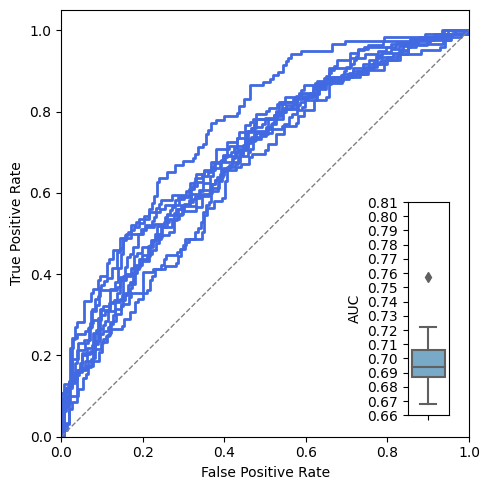

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc

# Assuming df is defined and contains the necessary data

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# ROC Curves
auc_values = []

# Iterate over the folds
for fold in np.arange(1, 11):
    # Get the FPR and TPR values for the current fold
    fpr_seq = df.loc[df['fold'] == fold, 'FPR'].values
    tpr_seq = df.loc[df['fold'] == fold, 'TPR'].values

    fpr = np.array(fpr_seq[0].tolist())
    tpr = np.array(tpr_seq[0].tolist())

    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)

    axs.plot(fpr, tpr, color='royalblue', lw=2)

# Plot the random guess line
axs.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set the limits and labels of the ROC plot
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')

# Calculate the position for the embedded box plot
box_left = 0.85
box_bottom = 0.05
box_width = 0.1
box_height = 0.5

# Create an inset axes within the current axes
ax_box = axs.inset_axes([box_left, box_bottom, box_width, box_height])

# Use seaborn boxplot
sns.boxplot(y=auc_values, ax=ax_box, palette="Blues")

# Set the y-axis limits for the box plot
ax_box.set_ylim([0.75, 0.81])

# Set y-axis ticks for better visualization
ax_box.set_yticks(np.arange(0.66, 0.81, 0.01))

ax_box.set_ylabel('AUC')

# Uncomment the following lines if you want to add a horizontal line for mean AUC
# ax_box.axhline(y=np.mean(auc_values), color='r', linestyle='--', label='Mean AUC')
# ax_box.legend(loc='best')

plt.tight_layout()
plt.show()


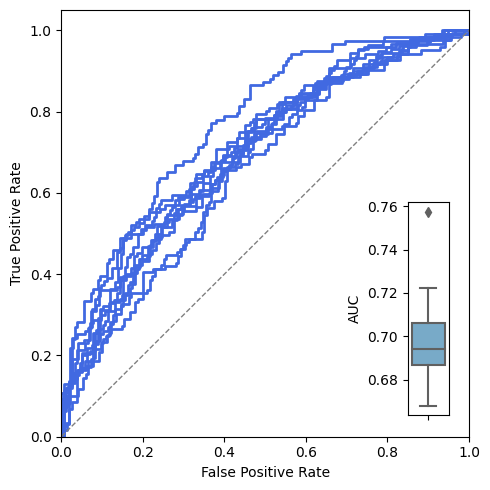

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# ROC Curves
# axs.set_title('ROC Curves for Different Folds')
auc_values = []

# Iterate over the folds
for fold in np.arange(1, 11):
    # Get the FPR and TPR values for the current fold
    fpr_seq = df.loc[df['fold'] == fold, 'FPR'].values
    tpr_seq = df.loc[df['fold'] == fold, 'TPR'].values

    fpr = np.array(fpr_seq[0].tolist())
    tpr = np.array(tpr_seq[0].tolist())

    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)

    axs.plot(fpr, tpr, color='royalblue',lw=2)

    # # Plot ROC curve with a different color for each fold
    # axs.plot(fpr, tpr, lw=2, label='Fold %d' % (fold))

# Plot the random guess line
axs.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set the limits and labels of the ROC plot
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')

# Create a legend with two columns and smaller font size
# legend = axs.legend(loc='upper left', ncol=2, fontsize='small')
# legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3), ncol=3, fontsize='small')

# Calculate the position for the embedded box plot
box_left = 0.85
box_bottom = 0.05
box_width = 0.1
box_height = 0.5

# Create an inset axes within the current axes
ax_box = axs.inset_axes([box_left, box_bottom, box_width, box_height])

# Use seaborn boxplot
sns.boxplot(y=auc_values, ax=ax_box, palette="Blues")
# ax_box.set_xlabel('Folds')
ax_box.set_ylabel('AUC')

# Add a y-axis to the box plot
# ax_box.axhline(y=np.mean(auc_values), color='r', linestyle='--', label='Mean AUC')
# ax_box.legend(loc='best')

plt.tight_layout()
plt.show()

# Hyperparameterization

## Hyperband optimization

In [56]:
from optimize_model import * 
import keras_tuner as kt

params= json.load(open('Exp4E_oneRainfall.json','r'))
# print(params)

X_train = [env_array[idx_tr],last_reading[idx_tr]]
Y_train = landslide_array[idx_tr]

obj = optimize_model(params['modelparam'])
objfunc = kt.Objective('val_auc', direction='max')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)
tuner2 = kt.Hyperband(obj, objective=objfunc, 
                       max_epochs=150, factor=3, 
                      project_name='msc-tuning-hyperband-4e-14days-baseline',
                      overwrite=True, seed=10)
tuner2.search(X_train, Y_train, epochs=200, validation_split=0.2, callbacks=[stop_early]) #tf.keras.callbacks.TensorBoard("/tmp/tb_logs")
best_hps = tuner2.get_best_hyperparameters(num_trials=2)[0]

Trial 254 Complete [00h 01m 13s]
val_auc: 0.5682762265205383

Best val_auc So Far: 0.7507935166358948
Total elapsed time: 04h 09m 17s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps.values

NameError: name 'best_hps' is not defined

## Bayesian optimization

In [24]:
from optimize_model import * 
import keras_tuner as kt

params= json.load(open('Exp4E_oneRainfall.json','r'))

X_train = [env_array[idx_tr],last_reading[idx_tr]]
Y_train = landslide_array[idx_tr]
objfunc = kt.Objective('val_auc', direction='max')
obj = optimize_model(params['modelparam'])

# note that in older versions, it's obj.build but as of 4/4/23, if build is there, batch size somehow ain't hyperparameterized.
tuner3 = kt.BayesianOptimization(obj, objective=objfunc, 
                      project_name='msc-tuning-bay-4e-14days-baseline', max_trials=50, max_retries_per_trial=5,
                      overwrite=True, seed=10)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)
tuner3.search(X_train, Y_train, epochs=200, validation_split=0.2, callbacks=[stop_early])
best_hps3 = tuner3.get_best_hyperparameters(num_trials=2)[0]

Trial 50 Complete [00h 00m 49s]
val_auc: 0.6316980719566345

Best val_auc So Far: 0.7609689831733704
Total elapsed time: 01h 39m 13s


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps3.values


{'GRU Layer': 64,
 'Env Layer': 16,
 'Combined Layer': 16,
 'Env depth': 2,
 'Comb depth': 1,
 'learning_rate': 1e-05,
 'GRU activation': 'relu',
 'Env activation': 'tanh',
 'Comb activation': 'swish',
 'gru dropout ratio': 0.05,
 'env dropout ratio': 0.1,
 'comb dropout ratio': 0.15,
 'batch_size': 21}